# Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using AlexNet as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the AlexNet model pretrained on Imagenet dataset to extract AlexNet activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from AlexNet activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set. 
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord
!git clone https://github.com/eldhusfifl07/nmaDL-project.git
%cd /content/nmaDL-project/BaselineRun

current directory set to

```
# !git clone https://github.com/eldhusfifl07/nmaDL-project.git
```
Change directory to Baseline Run for output


In [ ]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
#@title this does the PCA. It doesn't save it's only for chosing the dimension

import glob
import numpy as np

def do_PCA(activations_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_5']
    n_components = 100
    for layer in layers:
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        start_time = time.time()
        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=np.random.seed(1))
        ipca.fit(x)

        x = ipca.transform(x)

        return x

        
X = do_PCA('activations_alexnet')



In [ ]:
#@title This builds the matrix to check the amount of variance explaind by this dimension vectors
from pandas import DataFrame

pca = PCA(n_components=50).fit(X)
sum(pca.explained_variance_ratio_)
# ev = pca.singular_values_**2
# DataFrame(np.array([ev, ev/sum(ev), pca.explained_variance_ratio_]),
#           columns=["PC 1", "PC 2", "PC3"],
#           index=["Eigenvalues", "Explained Variance", "sklearn's Explained Variance"])

NameError: ignored

Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9). 

In [ ]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [ ]:
#@title Utility functions for data loading - need to download data for these functions
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021' 
  track = "full_track"
  results_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun'
  track_dir = os.path.join(fmri_dir, track) 
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [ ]:
#@title Loading fMRI data and inspecting dimensions
# sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

# ROI = 'LOC'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

# ######## fMRI data loader wrapper code ###################################
# fmri_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/participants_data_v2021' 
# if ROI == "WB":
#     track = "full_track"
# else:
#     track = "mini_track"
# results_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/'
# track_dir = os.path.join(fmri_dir, track) 
# sub_fmri_dir = os.path.join(track_dir, sub)
# if track == "full_track":
#     fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
# else:
#     fmri_train_all = get_fmri(sub_fmri_dir,ROI)

# ######## fMRI data loader wrapper code ###################################


# f, ax = plt.subplots(figsize=(12, 5))
# ax.set(xlabel="Voxel", ylabel="Stimulus")
# heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
# f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
# f.tight_layout()

In [ ]:
#@title Visualize video
# vid_id = 266 #@param {type: "integer"}
# video_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/AlgonautsVideos268_All_30fpsmax'

# ########### Video display code #################################################
# video_list = glob.glob(video_dir + '/*.mp4')
# video_list.sort()

# #visualize_brain_activity(video_dir,fmri_train_all,vid_id)
# from IPython.display import HTML
# from base64 import b64encode

# mp4 = open(video_list[vid_id],'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#     <source src="%s" type="video/mp4">
# </video>
# """ % data_url)
# ########### Video display code #################################################

In [ ]:
#@title Visualize corresponding brain response
# visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model definition (AlexNet)

Run the next cell to define the architecture of the model using pytorch.

In [ ]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [ ]:
##@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """


    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    return model

def print_alexnet_predictions(output):
    with open('class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    

def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==7:
                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        print_alexnet_predictions(feat)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)

def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_5']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

NameError: ignored

In [ ]:
#@title PCA visualization code
import sys 
sys.path.append("../")
from utils import *

from scipy.stats import ortho_group
from sklearn.decomposition import PCA
np.random.seed(1)

layers = ['layer_5']
n_components = 3
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for layer in tqdm(layers):
    activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
    activations_file_list.sort()
    feature_dim = np.load(activations_file_list[0])
    x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
    for i,activation_file in enumerate(activations_file_list):
        temp = np.load(activation_file)
        x[i,:] = temp
    x_train = x[:1000,:]
    x_test = x[1000:,:]

    start_time = time.time()
    x_test = StandardScaler().fit_transform(x_test)
    x_train = StandardScaler().fit_transform(x_train)
    ipca = PCA(n_components=n_components,random_state=seed)
    ipca.fit(x_train)

    x_train = ipca.transform(x_train)
    x_test = ipca.transform(x_test)
X = x_train  # just so it will match the rest of the code

color_scheme = ["rgb(189,6,96)", "rgb(6,189,99)", "rgb(6,96,189)"]

def plot_principal_component(pca, i):
# Get PC representation as a subspace with size proportional to the corresponding singular value
  size = np.sqrt(pca.singular_values_[i])
  pc = np.outer(pca.components_[i], np.array([-1,1])) * size

return go.Scatter3d(x=pc[0], y=pc[1], z=pc[2], mode="lines", opacity=.5,
                    line=dict(color=color_scheme[i], width=2*size), name='PC {}'.format(i+1))





ModuleNotFoundError: ignored

In [ ]:
pca = PCA(n_components=3).fit(X) # change the number of n_components to search for the best subspace

go.Figure(data = [go.Scatter3d(x = X[:, 0], y=X[:, 1], z=X[:, 2], opacity = .75, mode = 'markers', 
                               marker=dict(size=3, color="black"), showlegend=False)] + 
                 [plot_principal_component(pca, i) for i in range(3)],
          layout = go.Layout(title=r"$\text{(1) Original Dataset with PC Components}$", 
                             scene = scene, scene_aspectmode="cube"))  

In [ ]:
#@title This code implement the pca and shows what part of the data varinace is explained
from pandas import DataFrame

pca = PCA(n_components=3).fit(X) # change the number of n_components to search for the best subspace

ev = pca.singular_values_**2
DataFrame(np.array([ev, ev/sum(ev), pca.explained_variance_ratio_]),
          columns=["PC 1", "PC 2", "PC3"],
          index=["Eigenvalues", "Explained Variance", "sklearn's Explained Variance"])
variance = list(np.around(100*pca.explained_variance_ratio_, 2)) + [100]

fig = make_subplots(rows=1, cols=2, subplot_titles=[r"$\text{Eigenvalues}$", r"$\text{Cumulative Explained Variance}$"],
                    specs=[[{'type': 'Bar'}, {'type': 'Waterfall'}]])

fig.add_traces([go.Bar(x=['PC1', 'PC2', 'PC3'], y=pca.singular_values_, marker_color = color_scheme),
                go.Waterfall(x=["PC1", "PC2", "PC3", "Total"],
                             y=variance,
                             text=[f"{v}%" for v in variance],
                             textposition = "outside",
                             totals = {"marker":{"color":"black"}},
                             measure = ["relative", "relative", "relative", "total"])],
               rows=[1,1], cols=[1,2])

fig.add_shape(type="rect", xref="x", yref="y", x0=-0.4, x1=0.4, y0=0.0, y1=fig.data[1].y[0], 
              fillcolor=color_scheme[0], line=dict(color=color_scheme[0]), opacity=1,row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=0.6, x1=1.4, y0=fig.data[1].y[0], y1=fig.data[1].y[0]+fig.data[1].y[1],
              fillcolor=color_scheme[1], line=dict(color=color_scheme[1]), opacity=1, row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=1.6, x1=2.4, y0=fig.data[1].y[0]+fig.data[1].y[1], y1=fig.data[1].y[0]+fig.data[1].y[1]+fig.data[1].y[2], 
              fillcolor=color_scheme[2], line=dict(color=color_scheme[2]), opacity=1, row=1, col=2)

fig.update_layout(showlegend=False, title=r"$\text{(4) PCA Explained Variance}$", margin=dict(t=100))
fig.show()

In [ ]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, video_list, activations_dir)

Total Number of Videos:  1102


  0%|          | 0/1102 [00:00<?, ?it/s]

-------------Saving activations ----------------------------

Top-5 Predictions for the video id:  0001_0-0-1-6-7-2-8-0-17500167280
red-breasted merganser, Mergus serrator: 47.7815%
American coot, marsh hen, mud hen, water hen, Fulica americana: 31.1670%
oystercatcher, oyster catcher: 4.4099%
drake: 3.4130%
dowitcher: 1.9694%


  0%|          | 1/1102 [00:00<14:59,  1.22it/s]


Top-5 Predictions for the video id:  0002_0-0-4-3146384004
Bouvier des Flandres, Bouviers des Flandres: 28.6874%
Scottish deerhound, deerhound: 9.3555%
standard schnauzer: 6.3326%
bulletproof vest: 5.2905%
Irish wolfhound: 3.4212%


  0%|          | 2/1102 [00:01<14:34,  1.26it/s]


Top-5 Predictions for the video id:  0003_0-0-8-1-2-4-0-0-3500812400
croquet ball: 65.1708%
golf ball: 8.7599%
soccer ball: 3.3364%
Bouvier des Flandres, Bouviers des Flandres: 2.7174%
parachute, chute: 1.4735%


  0%|          | 3/1102 [00:02<14:32,  1.26it/s]


Top-5 Predictions for the video id:  0004_0-1-2-9-1-9-9-5-2401291995
snowmobile: 44.3372%
bobsled, bobsleigh, bob: 23.6392%
dogsled, dog sled, dog sleigh: 19.1859%
ski: 5.0737%
swing: 1.1241%


  0%|          | 4/1102 [00:03<14:20,  1.28it/s]


Top-5 Predictions for the video id:  0005_0-1-7-8-3-6-4-8-4401783648
toyshop: 13.8475%
bobsled, bobsleigh, bob: 8.1229%
unicycle, monocycle: 5.9295%
barbershop: 5.1377%
volleyball: 3.8439%


  0%|          | 5/1102 [00:03<14:08,  1.29it/s]


Top-5 Predictions for the video id:  0006_0-1-9-9-8-6-5-9-4701998659
space bar: 50.3252%
crossword puzzle, crossword: 5.1862%
grocery store, grocery, food market, market: 4.6133%
library: 4.4329%
balance beam, beam: 3.9810%


  1%|          | 6/1102 [00:04<13:58,  1.31it/s]


Top-5 Predictions for the video id:  0007_0-2-3-14056753023
restaurant, eating house, eating place, eatery: 81.0067%
fire screen, fireguard: 1.4924%
cello, violoncello: 0.9864%
academic gown, academic robe, judge's robe: 0.8578%
palace: 0.7574%


  1%|          | 7/1102 [00:05<14:22,  1.27it/s]


Top-5 Predictions for the video id:  0008_0-2-9-6-5-7-2-3-16002965723_1
laptop, laptop computer: 8.9172%
desk: 8.2000%
perfume, essence: 6.2538%
carton: 3.1992%
face powder: 3.1583%


  1%|          | 8/1102 [00:06<13:53,  1.31it/s]


Top-5 Predictions for the video id:  0009_0-3-5-4-1-3-6-2-8603541362
plastic bag: 7.3394%
triceratops: 6.5798%
candle, taper, wax light: 5.6289%
half track: 4.9909%
dogsled, dog sled, dog sleigh: 4.2834%


  1%|          | 9/1102 [00:06<13:38,  1.34it/s]


Top-5 Predictions for the video id:  0010_0-3-6-10842732036
restaurant, eating house, eating place, eatery: 27.0274%
theater curtain, theatre curtain: 23.0737%
bassoon: 14.7807%
marimba, xylophone: 6.0117%
steel drum: 4.7818%


  1%|          | 10/1102 [00:07<13:28,  1.35it/s]


Top-5 Predictions for the video id:  0011_0-3-6-2-3-3-4-4-8103623344
ocarina, sweet potato: 16.9343%
restaurant, eating house, eating place, eatery: 13.4099%
dining table, board: 7.8686%
desk: 4.5309%
bakery, bakeshop, bakehouse: 4.1378%


  1%|          | 11/1102 [00:08<13:18,  1.37it/s]


Top-5 Predictions for the video id:  0012_0-5-3-7-6-2-8-4-24105376284
moving van: 17.5330%
bullet train, bullet: 12.8398%
photocopier: 9.4730%
passenger car, coach, carriage: 9.1307%
minibus: 8.6300%


  1%|          | 12/1102 [00:09<13:11,  1.38it/s]


Top-5 Predictions for the video id:  0013_0-5-3-8-6-8-2-6-4805386826
Welsh springer spaniel: 33.6901%
Brittany spaniel: 29.0788%
gyromitra: 13.2180%
basset, basset hound: 3.4578%
wire-haired fox terrier: 2.9208%


  1%|          | 13/1102 [00:09<13:06,  1.38it/s]


Top-5 Predictions for the video id:  0014_0-5-6-8272016056_edit
potter's wheel: 59.9948%
lab coat, laboratory coat: 5.2551%
stretcher: 4.5747%
barbershop: 3.3313%
oxygen mask: 3.0769%


  1%|▏         | 14/1102 [00:10<13:21,  1.36it/s]


Top-5 Predictions for the video id:  0015_0-6-1-9759583061
pool table, billiard table, snooker table: 34.9675%
wall clock: 8.8172%
croquet ball: 7.6403%
Petri dish: 5.5917%
tennis ball: 3.6144%


  1%|▏         | 15/1102 [00:11<13:19,  1.36it/s]


Top-5 Predictions for the video id:  0016_0-6-6-1-5-8-2-5-14806615825
potter's wheel: 61.7221%
iron, smoothing iron: 17.3939%
nipple: 4.4071%
beaker: 4.4053%
Petri dish: 2.6440%


  1%|▏         | 16/1102 [00:11<13:20,  1.36it/s]


Top-5 Predictions for the video id:  0017_0-7-3-5856076073
scoreboard: 10.3737%
tennis ball: 8.1147%
fire engine, fire truck: 5.0683%
torch: 4.6415%
comic book: 3.9524%


  2%|▏         | 17/1102 [00:12<13:20,  1.36it/s]


Top-5 Predictions for the video id:  0018_0-7-7-9-8-1-7-4-24407798174
ski: 90.2314%
bobsled, bobsleigh, bob: 3.2888%
dogsled, dog sled, dog sleigh: 1.9902%
snowmobile: 1.4551%
stretcher: 0.9759%


  2%|▏         | 18/1102 [00:13<13:19,  1.36it/s]


Top-5 Predictions for the video id:  0019_0-7-9-9-7-7-1-5-4307997715
fox squirrel, eastern fox squirrel, Sciurus niger: 95.3870%
grey fox, gray fox, Urocyon cinereoargenteus: 4.0744%
kit fox, Vulpes macrotis: 0.4042%
wood rabbit, cottontail, cottontail rabbit: 0.0967%
hare: 0.0138%


  2%|▏         | 19/1102 [00:14<13:24,  1.35it/s]


Top-5 Predictions for the video id:  0020_0-8-0-0-3-9-3-9-7108003939
pajama, pyjama, pj's, jammies: 8.6980%
balance beam, beam: 7.8879%
photocopier: 4.0504%
crib, cot: 3.0423%
feather boa, boa: 2.3383%


  2%|▏         | 20/1102 [00:14<13:15,  1.36it/s]


Top-5 Predictions for the video id:  0021_0-8-0-8-6-5-4-5-4708086545
agama: 5.6122%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 5.1275%
fox squirrel, eastern fox squirrel, Sciurus niger: 4.9952%
marmot: 4.2800%
mongoose: 4.1799%


  2%|▏         | 21/1102 [00:15<13:22,  1.35it/s]


Top-5 Predictions for the video id:  0022_0-8-7-7-9-6-5-5-6508779655
plate: 18.6961%
restaurant, eating house, eating place, eatery: 16.6330%
dining table, board: 8.1665%
Crock Pot: 7.0667%
consomme: 5.5125%


  2%|▏         | 22/1102 [00:16<13:28,  1.34it/s]


Top-5 Predictions for the video id:  0023_0-8-8-7346836088
ping-pong ball: 38.0100%
whistle: 6.3536%
neck brace: 4.6343%
bathing cap, swimming cap: 3.7324%
tricycle, trike, velocipede: 3.6218%


  2%|▏         | 23/1102 [00:17<13:23,  1.34it/s]


Top-5 Predictions for the video id:  0024_0-9-3-5943645093
African elephant, Loxodonta africana: 63.3650%
Indian elephant, Elephas maximus: 32.5669%
tusker: 2.2469%
swimming trunks, bathing trunks: 0.3448%
hog, pig, grunter, squealer, Sus scrofa: 0.3022%


  2%|▏         | 24/1102 [00:17<13:14,  1.36it/s]


Top-5 Predictions for the video id:  0025_0-9-5-1-8-2-6-6-4009518266
airliner: 64.1826%
warplane, military plane: 29.2540%
wing: 2.7389%
space shuttle: 1.3083%
projectile, missile: 1.0785%


  2%|▏         | 25/1102 [00:18<13:14,  1.36it/s]


Top-5 Predictions for the video id:  0026_0-9-9-8-0-5-8-5-4909980585
ambulance: 17.5926%
minibus: 14.6496%
stretcher: 13.1669%
limousine, limo: 12.7438%
recreational vehicle, RV, R.V.: 9.9508%


  2%|▏         | 26/1102 [00:19<13:21,  1.34it/s]


Top-5 Predictions for the video id:  0027_03chvdioZYI_85
trombone: 29.4326%
oboe, hautboy, hautbois: 11.6784%
flute, transverse flute: 10.5321%
cornet, horn, trumpet, trump: 8.9461%
stage: 5.9007%


  2%|▏         | 27/1102 [00:20<13:28,  1.33it/s]


Top-5 Predictions for the video id:  0028_0P6FNr_6XWo_35
oxygen mask: 5.5768%
banjo: 5.5729%
electric guitar: 4.6230%
oboe, hautboy, hautbois: 3.6623%
sax, saxophone: 3.5153%


  3%|▎         | 28/1102 [00:20<13:36,  1.32it/s]


Top-5 Predictions for the video id:  0029_1-0-7-2-7-1-8-6-2810727186
potter's wheel: 29.4646%
toyshop: 9.1368%
eggnog: 9.1065%
maraca: 3.9285%
mortar: 3.0411%


  3%|▎         | 29/1102 [00:21<13:32,  1.32it/s]


Top-5 Predictions for the video id:  0030_1-1-5-6-1-6-5-2-2811561652
hair slide: 19.1100%
maraca: 10.8801%
piggy bank, penny bank: 6.9237%
nipple: 6.1097%
whistle: 4.0518%


  3%|▎         | 30/1102 [00:22<13:36,  1.31it/s]


Top-5 Predictions for the video id:  0031_1-1-8-8-3-2-8-3-13711883283
ski: 90.0950%
snowmobile: 1.2529%
puck, hockey puck: 0.7729%
reel: 0.7473%
bobsled, bobsleigh, bob: 0.7393%


  3%|▎         | 31/1102 [00:23<13:37,  1.31it/s]


Top-5 Predictions for the video id:  0032_1-2-0-9-0-9-1-6-3812090916_61
corkscrew, bottle screw: 21.0736%
whistle: 9.6433%
pick, plectrum, plectron: 7.0266%
lighter, light, igniter, ignitor: 4.3538%
padlock: 3.8497%


  3%|▎         | 32/1102 [00:23<13:32,  1.32it/s]


Top-5 Predictions for the video id:  0033_1-2-5-1-2-7-6-2-2512512762
speedboat: 8.9592%
lakeside, lakeshore: 4.3363%
go-kart: 4.0416%
convertible: 4.0233%
seashore, coast, seacoast, sea-coast: 3.8942%


  3%|▎         | 33/1102 [00:24<13:24,  1.33it/s]


Top-5 Predictions for the video id:  0034_1-2-5-3344278125
bicycle-built-for-two, tandem bicycle, tandem: 91.9200%
mountain bike, all-terrain bike, off-roader: 3.3763%
tricycle, trike, velocipede: 2.6454%
moped: 1.1575%
jinrikisha, ricksha, rickshaw: 0.4862%


  3%|▎         | 34/1102 [00:25<13:31,  1.32it/s]


Top-5 Predictions for the video id:  0035_1-2-6-3176369126
dogsled, dog sled, dog sleigh: 39.5635%
snowmobile: 23.4207%
ski: 16.5065%
malamute, malemute, Alaskan malamute: 1.6480%
German shepherd, German shepherd dog, German police dog, alsatian: 1.6139%


  3%|▎         | 35/1102 [00:26<13:23,  1.33it/s]


Top-5 Predictions for the video id:  0036_1-2-6-9-6-8-2-1-22212696821
tabby, tabby cat: 23.1049%
Egyptian cat: 11.4876%
tiger cat: 7.6166%
shower cap: 3.6122%
nipple: 2.8544%


  3%|▎         | 36/1102 [00:26<13:22,  1.33it/s]


Top-5 Predictions for the video id:  0037_1-3-9-9-9-6-4-3-3213999643
plate: 40.1760%
hot pot, hotpot: 31.7699%
potpie: 5.6449%
waffle iron: 5.1513%
restaurant, eating house, eating place, eatery: 3.7122%


  3%|▎         | 37/1102 [00:27<13:20,  1.33it/s]


Top-5 Predictions for the video id:  0038_1-4-3-5-8-6-2-5-3114358625
ski: 52.8184%
snowplow, snowplough: 12.4699%
alp: 10.7795%
drilling platform, offshore rig: 4.0692%
swing: 1.5711%


  3%|▎         | 38/1102 [00:28<13:20,  1.33it/s]


Top-5 Predictions for the video id:  0039_1-4-4-4086629144
radio telescope, radio reflector: 15.0307%
solar dish, solar collector, solar furnace: 11.9817%
schooner: 6.9110%
water tower: 6.5359%
beaker: 5.0895%


  4%|▎         | 39/1102 [00:29<13:18,  1.33it/s]


Top-5 Predictions for the video id:  0040_1-4-8-8-7-8-7-5-3914887875_56
four-poster: 22.8341%
mosquito net: 15.0712%
binder, ring-binder: 8.8734%
envelope: 6.5363%
screen, CRT screen: 4.6836%


  4%|▎         | 40/1102 [00:29<13:19,  1.33it/s]


Top-5 Predictions for the video id:  0041_1-5-0-0-4-9-7-8-2915004978_2
lawn mower, mower: 63.0275%
golfcart, golf cart: 5.3989%
go-kart: 3.2590%
tractor: 3.2461%
Model T: 1.8554%


  4%|▎         | 41/1102 [00:30<13:27,  1.31it/s]


Top-5 Predictions for the video id:  0042_1-5-8-9-2-4-5-4-7815892454
balance beam, beam: 38.8750%
horizontal bar, high bar: 28.0120%
racket, racquet: 5.0945%
ballplayer, baseball player: 3.2515%
parallel bars, bars: 3.1110%


  4%|▍         | 42/1102 [00:31<13:23,  1.32it/s]


Top-5 Predictions for the video id:  0043_1-6-0-2796094160
scuba diver: 99.7952%
sea snake: 0.0561%
tiger shark, Galeocerdo cuvieri: 0.0444%
coral reef: 0.0259%
snorkel: 0.0209%


  4%|▍         | 43/1102 [00:32<13:22,  1.32it/s]


Top-5 Predictions for the video id:  0044_1-6-0-7-7-6-4-6-7816077646
planetarium: 31.1557%
lakeside, lakeshore: 6.6940%
parachute, chute: 3.8081%
alp: 3.0122%
airship, dirigible: 2.9564%


  4%|▍         | 44/1102 [00:33<13:31,  1.30it/s]


Top-5 Predictions for the video id:  0045_1-6-8-0-7-6-7-4-3816807674
neck brace: 21.6971%
oboe, hautboy, hautbois: 6.4805%
nipple: 5.7390%
whistle: 4.3828%
stethoscope: 4.2811%


  4%|▍         | 45/1102 [00:33<13:24,  1.31it/s]


Top-5 Predictions for the video id:  0046_1-6-8-5795643168
geyser: 50.4555%
valley, vale: 30.9154%
promontory, headland, head, foreland: 3.4545%
cliff, drop, drop-off: 3.1948%
yawl: 1.4022%


  4%|▍         | 46/1102 [00:34<13:19,  1.32it/s]


Top-5 Predictions for the video id:  0047_1-7-1-8-6-3-6-2-3417186362
warplane, military plane: 32.0766%
aircraft carrier, carrier, flattop, attack aircraft carrier: 16.4007%
liner, ocean liner: 3.5949%
projectile, missile: 3.0011%
spotlight, spot: 2.3500%


  4%|▍         | 47/1102 [00:35<13:12,  1.33it/s]


Top-5 Predictions for the video id:  0048_1-7-2-5-5-0-7-5-25617255075
abaya: 7.5130%
parallel bars, bars: 6.3811%
cliff dwelling: 4.3702%
stretcher: 3.6802%
bow: 2.8851%


  4%|▍         | 48/1102 [00:36<13:24,  1.31it/s]


Top-5 Predictions for the video id:  0049_1-7-4-5-3-8-3-6-3017453836
steel drum: 19.9976%
unicycle, monocycle: 10.1172%
stage: 7.3316%
Sussex spaniel: 3.6645%
rugby ball: 3.6102%


  4%|▍         | 49/1102 [00:36<13:30,  1.30it/s]


Top-5 Predictions for the video id:  0050_1-8-5-7127344185
tennis ball: 47.1392%
swimming trunks, bathing trunks: 4.9366%
trimaran: 3.5589%
racket, racquet: 3.4024%
catamaran: 3.1213%


  5%|▍         | 50/1102 [00:37<13:30,  1.30it/s]


Top-5 Predictions for the video id:  0051_1-8-7-1-1-9-6-6-5418711966
snowplow, snowplough: 93.1088%
snowmobile: 4.1928%
chain saw, chainsaw: 0.5644%
tractor: 0.4835%
lawn mower, mower: 0.3606%


  5%|▍         | 51/1102 [00:38<13:20,  1.31it/s]


Top-5 Predictions for the video id:  0052_1-9-3-0-9-4-6-4-4719309464
oxcart: 69.4455%
Arabian camel, dromedary, Camelus dromedarius: 20.2383%
Indian elephant, Elephas maximus: 4.7792%
horse cart, horse-cart: 1.1166%
tusker: 1.0265%


  5%|▍         | 52/1102 [00:39<13:28,  1.30it/s]


Top-5 Predictions for the video id:  0053_1-9-3-2-8-0-1-3-3919328013
comic book: 27.1962%
Afghan hound, Afghan: 7.1560%
Appenzeller: 3.9994%
bloodhound, sleuthhound: 3.3441%
tennis ball: 2.9833%


  5%|▍         | 53/1102 [00:39<13:24,  1.30it/s]


Top-5 Predictions for the video id:  0054_1-9-3-9-3-8-2-2-23719393822
seashore, coast, seacoast, sea-coast: 20.8343%
fountain: 15.0230%
water tower: 14.8683%
lakeside, lakeshore: 11.2506%
speedboat: 5.8616%


  5%|▍         | 54/1102 [00:40<13:20,  1.31it/s]


Top-5 Predictions for the video id:  0055_1-9-6-7-5-1-9-8-3119675198
potter's wheel: 54.4028%
eggnog: 4.8977%
restaurant, eating house, eating place, eatery: 4.1783%
toyshop: 4.0643%
shoe shop, shoe-shop, shoe store: 3.8969%


  5%|▍         | 55/1102 [00:41<12:44,  1.37it/s]


Top-5 Predictions for the video id:  0056_2-0-0-3614591200
promontory, headland, head, foreland: 52.2155%
seashore, coast, seacoast, sea-coast: 18.7104%
cliff, drop, drop-off: 7.2135%
geyser: 3.3414%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.7757%


  5%|▌         | 56/1102 [00:41<12:13,  1.43it/s]


Top-5 Predictions for the video id:  0057_2-0-9-8159444209
dam, dike, dyke: 77.6569%
fireboat: 5.1814%
lakeside, lakeshore: 3.9691%
geyser: 3.8282%
yawl: 1.9440%


  5%|▌         | 57/1102 [00:42<11:49,  1.47it/s]


Top-5 Predictions for the video id:  0058_2-4-3-5345273243
stage: 67.8044%
theater curtain, theatre curtain: 2.9890%
unicycle, monocycle: 1.3026%
panpipe, pandean pipe, syrinx: 1.2485%
cornet, horn, trumpet, trump: 0.9106%


  5%|▌         | 58/1102 [00:43<11:35,  1.50it/s]


Top-5 Predictions for the video id:  0059_2-5-7-6889839257
ski: 61.6501%
alp: 3.9059%
snowplow, snowplough: 2.1221%
shovel: 1.8552%
stretcher: 1.7831%


  5%|▌         | 59/1102 [00:43<11:22,  1.53it/s]


Top-5 Predictions for the video id:  0060_2-6-5-12330534265
dining table, board: 10.9146%
eggnog: 8.0571%
toyshop: 7.6350%
restaurant, eating house, eating place, eatery: 6.3897%
jigsaw puzzle: 3.8341%


  5%|▌         | 60/1102 [00:44<11:18,  1.54it/s]


Top-5 Predictions for the video id:  0061_2-9-5-4309863295
power drill: 7.7803%
barbershop: 7.4126%
oxygen mask: 4.3192%
jersey, T-shirt, tee shirt: 4.1658%
dumbbell: 3.7548%


  6%|▌         | 61/1102 [00:45<11:08,  1.56it/s]


Top-5 Predictions for the video id:  0062_2EMSeADyrrQ_35
rock beauty, Holocanthus tricolor: 22.9797%
tennis ball: 9.0473%
shopping basket: 6.8172%
space heater: 5.5584%
indigo bunting, indigo finch, indigo bird, Passerina cyanea: 2.8479%


  6%|▌         | 62/1102 [00:45<11:05,  1.56it/s]


Top-5 Predictions for the video id:  0063_2Ng8UYBFhbU_91
meat loaf, meatloaf: 13.7084%
dishrag, dishcloth: 13.4375%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 7.9136%
pot, flowerpot: 4.4932%
Crock Pot: 3.2832%


  6%|▌         | 63/1102 [00:46<10:59,  1.58it/s]


Top-5 Predictions for the video id:  0064_2Tm26dLw29A_69
lawn mower, mower: 22.3871%
harvester, reaper: 19.1011%
tractor: 13.2705%
mobile home, manufactured home: 10.1148%
solar dish, solar collector, solar furnace: 3.2780%


  6%|▌         | 64/1102 [00:47<11:03,  1.56it/s]


Top-5 Predictions for the video id:  0065_2aG9AaxuGSU_148
television, television system: 40.9287%
home theater, home theatre: 25.5994%
monitor: 16.3699%
screen, CRT screen: 4.4081%
laptop, laptop computer: 3.1461%


  6%|▌         | 65/1102 [00:47<10:55,  1.58it/s]


Top-5 Predictions for the video id:  0066_2cCnDHUV0W8_35
miniskirt, mini: 28.0900%
abaya: 27.4706%
overskirt: 11.6431%
trench coat: 5.7322%
cowboy boot: 3.9417%


  6%|▌         | 66/1102 [00:48<10:52,  1.59it/s]


Top-5 Predictions for the video id:  0067_2h1Mj2ymyj8_121
unicycle, monocycle: 40.2339%
jinrikisha, ricksha, rickshaw: 10.7405%
tricycle, trike, velocipede: 8.8133%
bicycle-built-for-two, tandem bicycle, tandem: 7.1734%
oxcart: 4.2945%


  6%|▌         | 67/1102 [00:48<10:56,  1.58it/s]


Top-5 Predictions for the video id:  0068_3-0-4-4343808304
grocery store, grocery, food market, market: 56.8885%
toyshop: 16.8737%
confectionery, confectionary, candy store: 12.5146%
banana: 2.6219%
vending machine: 2.0241%


  6%|▌         | 68/1102 [00:49<10:58,  1.57it/s]


Top-5 Predictions for the video id:  0069_3-0-5-3-4-3-5-2-4730534352
oxcart: 30.2290%
potter's wheel: 7.7686%
stretcher: 5.9041%
assault rifle, assault gun: 4.2416%
sturgeon: 2.9993%


  6%|▋         | 69/1102 [00:50<10:55,  1.58it/s]


Top-5 Predictions for the video id:  0070_3-3-6-8-2-7-6-6-3533682766
vizsla, Hungarian pointer: 18.0677%
bloodhound, sleuthhound: 12.2340%
Rhodesian ridgeback: 7.7773%
bull mastiff: 3.9307%
malinois: 3.6033%


  6%|▋         | 70/1102 [00:50<10:56,  1.57it/s]


Top-5 Predictions for the video id:  0071_3-4-9-8-4-7-4-8-4434984748
airliner: 49.1065%
sports car, sport car: 8.9614%
racer, race car, racing car: 7.6791%
warplane, military plane: 3.7220%
mobile home, manufactured home: 3.2780%


  6%|▋         | 71/1102 [00:51<10:54,  1.58it/s]


Top-5 Predictions for the video id:  0072_3-5-0-4261181350
library: 15.8419%
potter's wheel: 12.3591%
guinea pig, Cavia cobaya: 12.2113%
toyshop: 9.7891%
barbershop: 6.3820%


  7%|▋         | 72/1102 [00:52<10:56,  1.57it/s]


Top-5 Predictions for the video id:  0073_3-5-8-9-9-5-9-8-4335899598
shovel: 54.1489%
ski: 20.4652%
ski mask: 12.0272%
chain saw, chainsaw: 2.4026%
bobsled, bobsleigh, bob: 2.3907%


  7%|▋         | 73/1102 [00:52<10:50,  1.58it/s]


Top-5 Predictions for the video id:  0074_3-6-5-3-3-4-4-5-23036533445
toyshop: 8.3309%
maillot, tank suit: 6.3982%
kimono: 5.3921%
sarong: 3.5969%
maillot: 2.9890%


  7%|▋         | 74/1102 [00:53<10:52,  1.58it/s]


Top-5 Predictions for the video id:  0075_3-7-0-7-1-5-3-0-4937071530
ping-pong ball: 14.6644%
nipple: 5.4701%
torch: 4.9702%
screen, CRT screen: 4.3836%
spaghetti squash: 3.0403%


  7%|▋         | 75/1102 [00:54<10:48,  1.58it/s]


Top-5 Predictions for the video id:  0076_3-7-3-13269577373
lifeboat: 34.4908%
speedboat: 29.8782%
trimaran: 11.5311%
fireboat: 9.6292%
yawl: 5.5523%


  7%|▋         | 76/1102 [00:54<10:49,  1.58it/s]


Top-5 Predictions for the video id:  0077_3-7-3-7-1-7-0-1-2537371701
plunger, plumber's helper: 8.9009%
dumbbell: 7.2793%
potter's wheel: 6.6854%
gasmask, respirator, gas helmet: 6.0035%
maraca: 5.8419%


  7%|▋         | 77/1102 [00:55<10:43,  1.59it/s]


Top-5 Predictions for the video id:  0078_3-7-5-4-7-7-8-9-8037547789
studio couch, day bed: 20.5237%
four-poster: 13.0122%
quilt, comforter, comfort, puff: 11.1804%
hair spray: 4.9677%
window shade: 3.3090%


  7%|▋         | 78/1102 [00:55<10:50,  1.57it/s]


Top-5 Predictions for the video id:  0079_3-7-5-6-6-4-1-7-3437566417
bicycle-built-for-two, tandem bicycle, tandem: 28.0281%
motor scooter, scooter: 18.0278%
moped: 10.6404%
crash helmet: 7.9676%
unicycle, monocycle: 7.8389%


  7%|▋         | 79/1102 [00:56<10:50,  1.57it/s]


Top-5 Predictions for the video id:  0080_3-9-0-6-4-2-6-6-3339064266
horizontal bar, high bar: 22.1114%
parallel bars, bars: 13.9227%
croquet ball: 8.7384%
tricycle, trike, velocipede: 7.6724%
swing: 3.3219%


  7%|▋         | 80/1102 [00:57<10:52,  1.57it/s]


Top-5 Predictions for the video id:  0081_4-0-6-7-6-1-4-5-4540676145
axolotl, mud puppy, Ambystoma mexicanum: 28.5932%
hamster: 24.2028%
piggy bank, penny bank: 6.5012%
nipple: 5.2234%
Angora, Angora rabbit: 2.2926%


  7%|▋         | 81/1102 [00:57<10:44,  1.58it/s]


Top-5 Predictions for the video id:  0082_4-2-5-6-5-3-6-5-16342565365
acoustic guitar: 86.9788%
electric guitar: 9.6700%
neck brace: 0.7793%
pick, plectrum, plectron: 0.6123%
banjo: 0.3772%


  7%|▋         | 82/1102 [00:58<10:39,  1.59it/s]


Top-5 Predictions for the video id:  0083_4-3-3-1-0-6-4-0-8743310640
water jug: 24.7157%
beaker: 17.9540%
hourglass: 12.4268%
Petri dish: 6.2065%
oxygen mask: 4.2580%


  8%|▊         | 83/1102 [00:59<10:39,  1.59it/s]


Top-5 Predictions for the video id:  0084_4-3-4-8736778434
joystick: 11.8122%
remote control, remote: 5.4620%
hand-held computer, hand-held microcomputer: 5.4021%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 4.7615%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 4.6924%


  8%|▊         | 84/1102 [00:59<10:39,  1.59it/s]


Top-5 Predictions for the video id:  0085_4-3-5-6-0-8-0-8-5543560808
shovel: 8.6908%
bobsled, bobsleigh, bob: 6.7516%
yurt: 3.6815%
Irish wolfhound: 3.6662%
hog, pig, grunter, squealer, Sus scrofa: 3.4720%


  8%|▊         | 85/1102 [01:00<10:36,  1.60it/s]


Top-5 Predictions for the video id:  0086_4-3-5-9059723435
nipple: 73.4687%
cradle: 5.3283%
diaper, nappy, napkin: 4.8853%
tub, vat: 3.1955%
ear, spike, capitulum: 2.5764%


  8%|▊         | 86/1102 [01:00<10:38,  1.59it/s]


Top-5 Predictions for the video id:  0087_4-3-7-4396869437
ski: 62.1981%
bobsled, bobsleigh, bob: 13.3328%
dogsled, dog sled, dog sleigh: 8.6053%
snowmobile: 7.4596%
shovel: 1.6614%


  8%|▊         | 87/1102 [01:01<10:37,  1.59it/s]


Top-5 Predictions for the video id:  0088_4-3-7-4889733437
tripod: 5.4908%
guillotine: 4.0252%
harp: 3.0746%
joystick: 2.4154%
candle, taper, wax light: 2.3334%


  8%|▊         | 88/1102 [01:02<10:40,  1.58it/s]


Top-5 Predictions for the video id:  0089_4-3-8-2-7-7-4-3-9043827743
valley, vale: 67.9513%
lakeside, lakeshore: 8.2157%
seashore, coast, seacoast, sea-coast: 1.7646%
head cabbage: 1.2822%
alp: 1.2739%


  8%|▊         | 89/1102 [01:02<10:38,  1.59it/s]


Top-5 Predictions for the video id:  0090_4-4-7-5-2-9-5-4-4744752954
paddle, boat paddle: 69.9482%
canoe: 21.7079%
barracouta, snoek: 2.1697%
yawl: 1.4623%
gar, garfish, garpike, billfish, Lepisosteus osseus: 1.1867%


  8%|▊         | 90/1102 [01:03<10:38,  1.59it/s]


Top-5 Predictions for the video id:  0091_4-5-0-1-4-3-5-1-15645014351
snowplow, snowplough: 23.1540%
parallel bars, bars: 16.5702%
puck, hockey puck: 14.6715%
bobsled, bobsleigh, bob: 6.9074%
amphibian, amphibious vehicle: 3.8160%


  8%|▊         | 91/1102 [01:04<10:35,  1.59it/s]


Top-5 Predictions for the video id:  0092_4-5-7-1-7-9-4-4-5945717944
warplane, military plane: 72.8838%
airliner: 8.8820%
wing: 6.7222%
space shuttle: 4.3859%
bow: 2.4760%


  8%|▊         | 92/1102 [01:04<10:38,  1.58it/s]


Top-5 Predictions for the video id:  0093_4-5-7-5265004457
plate: 12.3658%
candle, taper, wax light: 10.4903%
trifle: 4.9494%
hair slide: 4.4524%
ice cream, icecream: 4.3883%


  8%|▊         | 93/1102 [01:05<10:34,  1.59it/s]


Top-5 Predictions for the video id:  0094_4-5-9-2-3-0-7-9-15245923079
sturgeon: 35.4434%
gar, garfish, garpike, billfish, Lepisosteus osseus: 9.7309%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 9.2981%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 7.8149%
barracouta, snoek: 5.6505%


  9%|▊         | 94/1102 [01:05<10:34,  1.59it/s]


Top-5 Predictions for the video id:  0095_4-6-1-9-8-5-2-4-25546198524
ballplayer, baseball player: 73.5525%
baseball: 21.4157%
scoreboard: 1.0818%
racket, racquet: 1.0811%
pole: 0.6956%


  9%|▊         | 95/1102 [01:06<10:33,  1.59it/s]


Top-5 Predictions for the video id:  0096_4-7-1-1-2-8-3-0-25247112830
speedboat: 89.1187%
sandbar, sand bar: 3.2168%
canoe: 1.1479%
catamaran: 0.8856%
container ship, containership, container vessel: 0.5678%


  9%|▊         | 96/1102 [01:07<10:39,  1.57it/s]


Top-5 Predictions for the video id:  0097_4-7-9-4959184479
theater curtain, theatre curtain: 11.6676%
Afghan hound, Afghan: 10.5618%
torch: 4.1420%
unicycle, monocycle: 3.3103%
Welsh springer spaniel: 3.3026%


  9%|▉         | 97/1102 [01:07<10:34,  1.58it/s]


Top-5 Predictions for the video id:  0098_4-7-9-5224564479
lipstick, lip rouge: 12.4349%
punching bag, punch bag, punching ball, punchball: 9.2012%
bookcase: 8.0137%
turnstile: 7.1568%
lighter, light, igniter, ignitor: 4.1218%


  9%|▉         | 98/1102 [01:08<10:33,  1.58it/s]


Top-5 Predictions for the video id:  0099_4-7-9-5897473479
stretcher: 48.4355%
broom: 19.4662%
academic gown, academic robe, judge's robe: 2.4435%
maypole: 2.1959%
Loafer: 1.8344%


  9%|▉         | 99/1102 [01:09<10:34,  1.58it/s]


Top-5 Predictions for the video id:  0100_4-7-9-7-6-5-8-0-2647976580
balance beam, beam: 51.8487%
horizontal bar, high bar: 15.5109%
parallel bars, bars: 10.4668%
ping-pong ball: 9.0338%
maillot, tank suit: 4.7662%


  9%|▉         | 100/1102 [01:09<10:32,  1.58it/s]


Top-5 Predictions for the video id:  0101_4-8-4-5-2-8-6-4-12748452864
geyser: 70.7554%
volcano: 2.7387%
airship, dirigible: 2.1916%
fireboat: 1.4685%
beacon, lighthouse, beacon light, pharos: 0.9378%


  9%|▉         | 101/1102 [01:10<10:30,  1.59it/s]


Top-5 Predictions for the video id:  0102_4-8-9-2-5-7-3-1-3848925731
ice lolly, lolly, lollipop, popsicle: 30.7264%
maraca: 14.0335%
nipple: 11.4169%
whistle: 3.8696%
diaper, nappy, napkin: 3.6447%


  9%|▉         | 102/1102 [01:11<10:28,  1.59it/s]


Top-5 Predictions for the video id:  0103_4-9-0-4-8-4-8-7-3949048487
geyser: 99.8260%
volcano: 0.0421%
seashore, coast, seacoast, sea-coast: 0.0197%
beacon, lighthouse, beacon light, pharos: 0.0117%
hay: 0.0115%


  9%|▉         | 103/1102 [01:11<10:24,  1.60it/s]


Top-5 Predictions for the video id:  0104_4_mAU3U33fU_224
thresher, thrasher, threshing machine: 18.0561%
fire engine, fire truck: 16.1037%
tractor: 12.5859%
snowplow, snowplough: 7.4495%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 5.9408%


  9%|▉         | 104/1102 [01:12<10:26,  1.59it/s]


Top-5 Predictions for the video id:  0105_5-0-2-9044555502
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 17.3022%
limousine, limo: 13.7519%
recreational vehicle, RV, R.V.: 10.0080%
passenger car, coach, carriage: 8.0405%
moving van: 7.4675%


 10%|▉         | 105/1102 [01:12<10:29,  1.59it/s]


Top-5 Predictions for the video id:  0106_5-0-6-7-7-5-7-6-14950677576_1
mobile home, manufactured home: 36.6857%
go-kart: 6.0776%
garbage truck, dustcart: 4.3465%
lakeside, lakeshore: 3.4010%
recreational vehicle, RV, R.V.: 3.3481%


 10%|▉         | 106/1102 [01:13<10:28,  1.59it/s]


Top-5 Predictions for the video id:  0107_5-2-4-5-8-0-7-9-4752458079
mobile home, manufactured home: 7.2513%
pedestal, plinth, footstall: 5.4193%
guillotine: 4.7547%
bell cote, bell cot: 4.4704%
submarine, pigboat, sub, U-boat: 4.3032%


 10%|▉         | 107/1102 [01:14<10:26,  1.59it/s]


Top-5 Predictions for the video id:  0108_5-3-4-9966677534
speedboat: 25.0549%
lifeboat: 16.7740%
canoe: 16.0911%
fireboat: 9.4292%
snorkel: 7.9994%


 10%|▉         | 108/1102 [01:14<10:26,  1.59it/s]


Top-5 Predictions for the video id:  0109_5-3-7-1-9-2-1-2-3453719212
printer: 14.7183%
photocopier: 8.0648%
plate: 7.4713%
toaster: 7.2779%
cleaver, meat cleaver, chopper: 5.3874%


 10%|▉         | 109/1102 [01:15<10:20,  1.60it/s]


Top-5 Predictions for the video id:  0110_5-4-0-2405298540
trimaran: 74.0233%
catamaran: 13.2104%
speedboat: 5.7367%
yawl: 1.9589%
seashore, coast, seacoast, sea-coast: 0.8907%


 10%|▉         | 110/1102 [01:16<10:20,  1.60it/s]


Top-5 Predictions for the video id:  0111_5-4-2-6-1-5-0-7-5654261507
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 9.6398%
Norwegian elkhound, elkhound: 8.3697%
ox: 5.4078%
dogsled, dog sled, dog sleigh: 3.6922%
English setter: 3.2701%


 10%|█         | 111/1102 [01:16<10:17,  1.61it/s]


Top-5 Predictions for the video id:  0112_5-4-2-6-3-7-5-4-7854263754
skunk, polecat, wood pussy: 28.1598%
Old English sheepdog, bobtail: 7.5092%
valley, vale: 6.4346%
American alligator, Alligator mississipiensis: 5.1304%
komondor: 4.1310%


 10%|█         | 112/1102 [01:17<10:22,  1.59it/s]


Top-5 Predictions for the video id:  0113_5-4-3-5-0-8-5-4-13654350854_22
laptop, laptop computer: 23.8081%
library: 17.2314%
potter's wheel: 7.3541%
washer, automatic washer, washing machine: 4.9900%
stethoscope: 4.6290%


 10%|█         | 113/1102 [01:17<10:24,  1.58it/s]


Top-5 Predictions for the video id:  0114_5-4-5-2-2-4-8-5-8454522485
hot pot, hotpot: 49.6444%
consomme: 8.8958%
plate: 7.7670%
frying pan, frypan, skillet: 6.8989%
Dutch oven: 4.4427%


 10%|█         | 114/1102 [01:18<10:22,  1.59it/s]


Top-5 Predictions for the video id:  0115_5-4-5-4-1-8-6-5-8254541865_29
Sussex spaniel: 30.7805%
Irish setter, red setter: 17.2273%
briard: 14.8614%
Airedale, Airedale terrier: 6.7738%
Irish terrier: 2.5271%


 10%|█         | 115/1102 [01:19<10:24,  1.58it/s]


Top-5 Predictions for the video id:  0116_5-6-5-5-1-6-7-5-23256551675
face powder: 62.6878%
consomme: 28.7078%
espresso: 1.4723%
Petri dish: 1.2350%
beaker: 0.5596%


 11%|█         | 116/1102 [01:19<10:20,  1.59it/s]


Top-5 Predictions for the video id:  0117_5-6-6-3042970566
solar dish, solar collector, solar furnace: 6.9337%
standard poodle: 6.5854%
steel drum: 3.6910%
hoopskirt, crinoline: 3.1906%
Cardigan, Cardigan Welsh corgi: 2.9434%


 11%|█         | 117/1102 [01:20<10:18,  1.59it/s]


Top-5 Predictions for the video id:  0118_5-6-7-7-6-0-9-9-3756776099
lawn mower, mower: 8.6979%
apiary, bee house: 7.3189%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 5.4236%
milk can: 3.7698%
sundial: 3.0976%


 11%|█         | 118/1102 [01:21<10:19,  1.59it/s]


Top-5 Predictions for the video id:  0119_5-7-0-7-8-9-1-3-4257078913
theater curtain, theatre curtain: 32.5871%
vestment: 21.7120%
academic gown, academic robe, judge's robe: 14.8931%
Afghan hound, Afghan: 4.2963%
altar: 2.4350%


 11%|█         | 119/1102 [01:21<10:19,  1.59it/s]


Top-5 Predictions for the video id:  0120_5-7-5-3760841575
canoe: 29.2221%
speedboat: 15.7935%
sandbar, sand bar: 9.0619%
paddle, boat paddle: 8.1637%
lakeside, lakeshore: 8.0853%


 11%|█         | 120/1102 [01:22<10:20,  1.58it/s]


Top-5 Predictions for the video id:  0121_5-7-6-1-2-1-4-3-17357612143
jacamar: 56.5022%
bulbul: 14.2953%
squirrel monkey, Saimiri sciureus: 5.7082%
brambling, Fringilla montifringilla: 4.1074%
titi, titi monkey: 3.8150%


 11%|█         | 121/1102 [01:22<10:17,  1.59it/s]


Top-5 Predictions for the video id:  0122_5-7-6-9-5-4-8-2-5457695482
swimming trunks, bathing trunks: 24.1289%
diaper, nappy, napkin: 15.2859%
bathtub, bathing tub, bath, tub: 11.5346%
tub, vat: 9.0694%
parallel bars, bars: 7.1058%


 11%|█         | 122/1102 [01:23<10:13,  1.60it/s]


Top-5 Predictions for the video id:  0123_5-9-0-1-9-6-9-0-5259019690
pinwheel: 64.9620%
whistle: 10.5163%
rubber eraser, rubber, pencil eraser: 5.0325%
pick, plectrum, plectron: 2.5952%
jigsaw puzzle: 2.2884%


 11%|█         | 123/1102 [01:24<10:14,  1.59it/s]


Top-5 Predictions for the video id:  0124_5-9-1-5611850591
bobsled, bobsleigh, bob: 12.5232%
barbell: 9.6555%
balance beam, beam: 6.8340%
stretcher: 4.8798%
television, television system: 4.5948%


 11%|█▏        | 124/1102 [01:24<10:12,  1.60it/s]


Top-5 Predictions for the video id:  0125_5-9-4-9166960594
maypole: 39.7981%
ski: 8.2665%
oxcart: 5.6904%
jinrikisha, ricksha, rickshaw: 4.3732%
Afghan hound, Afghan: 3.1071%


 11%|█▏        | 125/1102 [01:25<10:17,  1.58it/s]


Top-5 Predictions for the video id:  0126_5-9-7-5-7-9-9-8-2859757998
valley, vale: 34.2188%
cliff, drop, drop-off: 10.7689%
fountain: 10.6228%
indri, indris, Indri indri, Indri brevicaudatus: 5.2414%
pedestal, plinth, footstall: 1.4909%


 11%|█▏        | 126/1102 [01:26<10:17,  1.58it/s]


Top-5 Predictions for the video id:  0127_5541389947
bobsled, bobsleigh, bob: 21.5143%
maillot: 13.8002%
throne: 3.7697%
kimono: 2.4866%
balance beam, beam: 2.3934%


 12%|█▏        | 127/1102 [01:26<10:16,  1.58it/s]


Top-5 Predictions for the video id:  0128_5948238182
balance beam, beam: 12.0762%
bathtub, bathing tub, bath, tub: 10.6159%
cradle: 7.1204%
tub, vat: 6.1445%
parallel bars, bars: 4.9634%


 12%|█▏        | 128/1102 [01:27<10:20,  1.57it/s]


Top-5 Predictions for the video id:  0129_5pZ8Z7icwxE_276
bookshop, bookstore, bookstall: 15.6836%
library: 10.7101%
refrigerator, icebox: 4.8201%
medicine chest, medicine cabinet: 4.5761%
carton: 4.3272%


 12%|█▏        | 129/1102 [01:28<10:15,  1.58it/s]


Top-5 Predictions for the video id:  0130_6-0-7-6496350607
soccer ball: 30.9839%
rugby ball: 15.0943%
croquet ball: 14.8818%
Saluki, gazelle hound: 5.9458%
football helmet: 5.6038%


 12%|█▏        | 130/1102 [01:28<10:11,  1.59it/s]


Top-5 Predictions for the video id:  0131_6-0-9-5-1-4-3-4-3260951434
ocarina, sweet potato: 11.7015%
hair slide: 5.0765%
acorn squash: 3.6733%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 3.5050%
quill, quill pen: 3.0966%


 12%|█▏        | 131/1102 [01:29<10:12,  1.59it/s]


Top-5 Predictions for the video id:  0132_6-1-0-8-4-3-3-3-2461084333
candle, taper, wax light: 9.7378%
Petri dish: 8.3365%
hair slide: 8.3164%
consomme: 5.3571%
trifle: 4.6003%


 12%|█▏        | 132/1102 [01:29<10:07,  1.60it/s]


Top-5 Predictions for the video id:  0133_6-2-2-4-7-1-0-3-6562247103
dumbbell: 27.8000%
parallel bars, bars: 7.8264%
horizontal bar, high bar: 6.0628%
ping-pong ball: 5.4728%
notebook, notebook computer: 4.6490%


 12%|█▏        | 133/1102 [01:30<10:07,  1.60it/s]


Top-5 Predictions for the video id:  0134_6-3-7-7169142637
electric locomotive: 82.5976%
passenger car, coach, carriage: 11.9735%
streetcar, tram, tramcar, trolley, trolley car: 2.6360%
steam locomotive: 0.4965%
garbage truck, dustcart: 0.4787%


 12%|█▏        | 134/1102 [01:31<10:09,  1.59it/s]


Top-5 Predictions for the video id:  0135_6-4-0-3-0-0-4-4-22064030044
basketball: 67.7084%
football helmet: 9.1052%
German shepherd, German shepherd dog, German police dog, alsatian: 3.2086%
soccer ball: 2.4058%
scoreboard: 2.3883%


 12%|█▏        | 135/1102 [01:31<10:10,  1.58it/s]


Top-5 Predictions for the video id:  0136_6-4-4-8-8-6-2-5-8164488625
caldron, cauldron: 21.0729%
frying pan, frypan, skillet: 13.9568%
wok: 11.9441%
Dutch oven: 6.4416%
barrow, garden cart, lawn cart, wheelbarrow: 6.0941%


 12%|█▏        | 136/1102 [01:32<10:21,  1.55it/s]


Top-5 Predictions for the video id:  0137_6-5-9-3859686659
steel drum: 16.8230%
toyshop: 9.2881%
confectionery, confectionary, candy store: 4.2424%
fountain: 3.6757%
desk: 3.3358%


 12%|█▏        | 137/1102 [01:33<10:25,  1.54it/s]


Top-5 Predictions for the video id:  0138_6-6-1-2641881661
canoe: 35.6317%
paddle, boat paddle: 17.7347%
drilling platform, offshore rig: 9.8829%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 4.3000%
snorkel: 3.8251%


 13%|█▎        | 138/1102 [01:33<10:22,  1.55it/s]


Top-5 Predictions for the video id:  0139_6-6-6-7-7-0-2-9-6866677029_1
stingray: 38.1402%
snorkel: 15.2338%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 5.0021%
swimming trunks, bathing trunks: 4.7619%
bathing cap, swimming cap: 2.7673%


 13%|█▎        | 139/1102 [01:34<10:24,  1.54it/s]


Top-5 Predictions for the video id:  0140_6-6-8-7-5-4-8-7-8066875487_24
cab, hack, taxi, taxicab: 21.2469%
streetcar, tram, tramcar, trolley, trolley car: 16.0540%
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 15.7113%
ambulance: 11.8477%
racer, race car, racing car: 6.6008%


 13%|█▎        | 140/1102 [01:35<10:18,  1.55it/s]


Top-5 Predictions for the video id:  0141_6-7-0-1-4-8-8-0-9267014880
bee: 71.3690%
ant, emmet, pismire: 10.9912%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 2.5369%
cauliflower: 1.9059%
hair slide: 1.7287%


 13%|█▎        | 141/1102 [01:35<10:14,  1.56it/s]


Top-5 Predictions for the video id:  0142_6-8-1-3-0-3-6-5-11768130365
oxcart: 58.9961%
horse cart, horse-cart: 23.9059%
dogsled, dog sled, dog sleigh: 4.4794%
Great Dane: 4.3957%
ox: 2.4044%


 13%|█▎        | 142/1102 [01:36<10:15,  1.56it/s]


Top-5 Predictions for the video id:  0143_6-8-5-2652653685
mobile home, manufactured home: 13.7692%
tow truck, tow car, wrecker: 9.3430%
limousine, limo: 8.3100%
amphibian, amphibious vehicle: 7.1317%
garbage truck, dustcart: 5.7384%


 13%|█▎        | 143/1102 [01:36<10:09,  1.57it/s]


Top-5 Predictions for the video id:  0144_6-gEVb8H_fk_649
envelope: 14.6930%
rubber eraser, rubber, pencil eraser: 6.4294%
sunglass: 4.0291%
swimming trunks, bathing trunks: 3.7677%
sunglasses, dark glasses, shades: 3.3900%


 13%|█▎        | 144/1102 [01:37<10:16,  1.55it/s]


Top-5 Predictions for the video id:  0145_7-0-7-8-4-7-5-8-14570784758
croquet ball: 25.5098%
Irish wolfhound: 11.7390%
chain saw, chainsaw: 5.5277%
Airedale, Airedale terrier: 5.0136%
Bouvier des Flandres, Bouviers des Flandres: 4.8378%


 13%|█▎        | 145/1102 [01:38<10:11,  1.56it/s]


Top-5 Predictions for the video id:  0146_7-1-5-1-5-3-3-7-7171515337
capuchin, ringtail, Cebus capucinus: 52.9895%
titi, titi monkey: 13.6432%
macaque: 9.8378%
gibbon, Hylobates lar: 7.4388%
patas, hussar monkey, Erythrocebus patas: 4.4453%


 13%|█▎        | 146/1102 [01:38<10:13,  1.56it/s]


Top-5 Predictions for the video id:  0147_7-1-6-7637947716
bearskin, busby, shako: 6.4773%
accordion, piano accordion, squeeze box: 5.5660%
abaya: 4.9736%
moving van: 3.4563%
fur coat: 3.3144%


 13%|█▎        | 147/1102 [01:39<10:11,  1.56it/s]


Top-5 Predictions for the video id:  0148_7-1-8-0-6-6-5-3-2471806653
umbrella: 7.0191%
horizontal bar, high bar: 6.2065%
feather boa, boa: 4.8944%
brassiere, bra, bandeau: 4.7959%
swing: 4.3358%


 13%|█▎        | 148/1102 [01:40<10:13,  1.56it/s]


Top-5 Predictions for the video id:  0149_7-1-8-7-4-8-0-6-2471874806
marimba, xylophone: 43.9263%
military uniform: 7.1480%
tobacco shop, tobacconist shop, tobacconist: 3.1457%
jinrikisha, ricksha, rickshaw: 2.9907%
mobile home, manufactured home: 2.5646%


 14%|█▎        | 149/1102 [01:40<10:12,  1.56it/s]


Top-5 Predictions for the video id:  0150_7-2-3-4-0-4-6-7-3872340467
Dutch oven: 65.4131%
frying pan, frypan, skillet: 10.7603%
caldron, cauldron: 7.7669%
stove: 4.6296%
Crock Pot: 2.5748%


 14%|█▎        | 150/1102 [01:41<10:15,  1.55it/s]


Top-5 Predictions for the video id:  0151_7-2-5-2-4-9-1-1-3572524911
diaper, nappy, napkin: 11.2092%
nipple: 10.9410%
candle, taper, wax light: 6.6078%
bathtub, bathing tub, bath, tub: 6.3215%
piggy bank, penny bank: 5.4085%


 14%|█▎        | 151/1102 [01:42<10:08,  1.56it/s]


Top-5 Predictions for the video id:  0152_7-3-2-8-5-5-7-0-2773285570_7
sea snake: 27.9529%
spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 19.7557%
electric ray, crampfish, numbfish, torpedo: 17.9212%
stingray: 8.4832%
eel: 8.0073%


 14%|█▍        | 152/1102 [01:42<10:15,  1.54it/s]


Top-5 Predictions for the video id:  0153_7-3-3-3-1-1-7-8-5973331178
abaya: 7.7607%
overskirt: 6.8564%
miniskirt, mini: 5.0705%
horizontal bar, high bar: 4.5533%
pole: 4.3010%


 14%|█▍        | 153/1102 [01:43<10:12,  1.55it/s]


Top-5 Predictions for the video id:  0154_7-3-3-8-1-7-0-5-5773381705
hot pot, hotpot: 32.5969%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 16.1011%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 9.1699%
gyromitra: 8.4618%
rotisserie: 6.1540%


 14%|█▍        | 154/1102 [01:44<10:04,  1.57it/s]


Top-5 Predictions for the video id:  0155_7-3-3-9823355733
croquet ball: 15.7866%
Scottish deerhound, deerhound: 10.9400%
unicycle, monocycle: 7.4836%
Irish wolfhound: 4.2949%
golf ball: 4.0514%


 14%|█▍        | 155/1102 [01:44<10:00,  1.58it/s]


Top-5 Predictions for the video id:  0156_7-3-8-8-3-3-3-0-6873883330_5
stingray: 18.2102%
coral reef: 18.2055%
electric ray, crampfish, numbfish, torpedo: 14.6022%
hammerhead, hammerhead shark: 8.7807%
loggerhead, loggerhead turtle, Caretta caretta: 7.9907%


 14%|█▍        | 156/1102 [01:45<10:10,  1.55it/s]


Top-5 Predictions for the video id:  0157_7-4-3-9701238743
racket, racquet: 26.0962%
croquet ball: 9.2648%
golf ball: 8.2828%
ballplayer, baseball player: 4.7838%
bow: 3.6052%


 14%|█▍        | 157/1102 [01:45<10:06,  1.56it/s]


Top-5 Predictions for the video id:  0158_7-5-4-8-3-8-3-6-25975483836
ballplayer, baseball player: 79.2168%
baseball: 15.6934%
racket, racquet: 1.1217%
basenji: 0.7751%
volleyball: 0.2540%


 14%|█▍        | 158/1102 [01:46<10:02,  1.57it/s]


Top-5 Predictions for the video id:  0159_7-6-3-1-6-7-9-2-7876316792_13
geyser: 7.9953%
umbrella: 7.5237%
shovel: 5.1842%
swab, swob, mop: 4.1523%
crutch: 3.9741%


 14%|█▍        | 159/1102 [01:47<10:03,  1.56it/s]


Top-5 Predictions for the video id:  0160_7-7-0-2652639770
bicycle-built-for-two, tandem bicycle, tandem: 74.4223%
mountain bike, all-terrain bike, off-roader: 21.9802%
unicycle, monocycle: 1.0131%
tricycle, trike, velocipede: 0.5888%
Arabian camel, dromedary, Camelus dromedarius: 0.4417%


 15%|█▍        | 160/1102 [01:47<10:06,  1.55it/s]


Top-5 Predictions for the video id:  0161_7-7-2-8-9-8-8-7-3077289887
grocery store, grocery, food market, market: 61.2507%
toyshop: 17.0377%
tobacco shop, tobacconist shop, tobacconist: 4.4026%
confectionery, confectionary, candy store: 3.0072%
bakery, bakeshop, bakehouse: 2.7813%


 15%|█▍        | 161/1102 [01:48<10:00,  1.57it/s]


Top-5 Predictions for the video id:  0162_7-7-4-0-8-2-3-2-21577408232
croquet ball: 13.7232%
soccer ball: 11.3303%
golf ball: 6.9921%
rugby ball: 5.0593%
Rhodesian ridgeback: 2.8236%


 15%|█▍        | 162/1102 [01:49<09:59,  1.57it/s]


Top-5 Predictions for the video id:  0163_7-8-4-11617872784
coral reef: 81.8129%
sea snake: 8.6412%
scuba diver: 3.1898%
rock beauty, Holocanthus tricolor: 2.1236%
brain coral: 1.6884%


 15%|█▍        | 163/1102 [01:49<09:59,  1.57it/s]


Top-5 Predictions for the video id:  0164_7-8-4-4-0-9-0-9-3778440909
garbage truck, dustcart: 13.2817%
thresher, thrasher, threshing machine: 5.5753%
horse cart, horse-cart: 5.1698%
komondor: 3.9112%
Irish wolfhound: 3.3930%


 15%|█▍        | 164/1102 [01:50<09:53,  1.58it/s]


Top-5 Predictions for the video id:  0165_7-8-5-4189422785
croquet ball: 28.1015%
maypole: 18.9728%
lawn mower, mower: 6.4617%
soccer ball: 4.2242%
schipperke: 1.9453%


 15%|█▍        | 165/1102 [01:51<09:49,  1.59it/s]


Top-5 Predictions for the video id:  0166_7-9-1-9-1-3-1-5-5879191315
swing: 39.0958%
horizontal bar, high bar: 11.3429%
ballplayer, baseball player: 8.5840%
bow: 8.4823%
volleyball: 4.1888%


 15%|█▌        | 166/1102 [01:51<09:50,  1.59it/s]


Top-5 Predictions for the video id:  0167_7-9-2-5805821792
toyshop: 19.6372%
tobacco shop, tobacconist shop, tobacconist: 10.8150%
shoe shop, shoe-shop, shoe store: 8.8565%
grocery store, grocery, food market, market: 5.1370%
library: 4.6325%


 15%|█▌        | 167/1102 [01:52<09:51,  1.58it/s]


Top-5 Predictions for the video id:  0168_7-9-2-6804993792
croquet ball: 34.0405%
Irish wolfhound: 8.3143%
ballplayer, baseball player: 7.5028%
Saluki, gazelle hound: 6.4789%
baseball: 4.2976%


 15%|█▌        | 168/1102 [01:52<09:47,  1.59it/s]


Top-5 Predictions for the video id:  0169_7-9-4-13012552794
dugong, Dugong dugon: 19.8288%
hammerhead, hammerhead shark: 17.5900%
electric ray, crampfish, numbfish, torpedo: 5.9932%
tiger shark, Galeocerdo cuvieri: 5.8871%
sea snake: 5.5657%


 15%|█▌        | 169/1102 [01:53<09:48,  1.59it/s]


Top-5 Predictions for the video id:  0170_75FvTr78rVo_238
pinwheel: 11.0753%
piggy bank, penny bank: 10.9671%
whistle: 9.1593%
toaster: 8.5445%
rubber eraser, rubber, pencil eraser: 6.9844%


 15%|█▌        | 170/1102 [01:54<09:47,  1.59it/s]


Top-5 Predictions for the video id:  0171_8-1-0-2784666810
trimaran: 75.4765%
catamaran: 22.4948%
yawl: 0.5665%
schooner: 0.3017%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.2547%


 16%|█▌        | 171/1102 [01:54<09:43,  1.59it/s]


Top-5 Predictions for the video id:  0172_8-3-1-7-3-3-2-6-3583173326_54
stretcher: 12.9885%
golfcart, golf cart: 11.8858%
punching bag, punch bag, punching ball, punchball: 5.3317%
balance beam, beam: 5.1536%
gong, tam-tam: 3.9901%


 16%|█▌        | 172/1102 [01:55<09:49,  1.58it/s]


Top-5 Predictions for the video id:  0173_8-5-6-13941149856
Appenzeller: 11.4869%
standard schnauzer: 7.8894%
Saluki, gazelle hound: 7.7039%
Border collie: 7.4326%
Cardigan, Cardigan Welsh corgi: 4.5379%


 16%|█▌        | 173/1102 [01:56<09:53,  1.57it/s]


Top-5 Predictions for the video id:  0174_8-6-1-3575610861
tricycle, trike, velocipede: 10.4468%
neck brace: 5.5255%
maraca: 5.4622%
swab, swob, mop: 4.4126%
pay-phone, pay-station: 4.0888%


 16%|█▌        | 174/1102 [01:56<09:53,  1.56it/s]


Top-5 Predictions for the video id:  0175_8-6-7-3034848867
hair spray: 5.3185%
Indian cobra, Naja naja: 3.1188%
punching bag, punch bag, punching ball, punchball: 2.9461%
cowboy boot: 2.4455%
oxygen mask: 2.2501%


 16%|█▌        | 175/1102 [01:57<09:52,  1.56it/s]


Top-5 Predictions for the video id:  0176_8-7-1-7072478871
parallel bars, bars: 10.1814%
balance beam, beam: 9.6144%
swimming trunks, bathing trunks: 8.8730%
library: 7.9024%
sarong: 5.1767%


 16%|█▌        | 176/1102 [01:58<09:52,  1.56it/s]


Top-5 Predictions for the video id:  0177_8-7-5-4-7-4-9-9-6687547499
neck brace: 17.6027%
maraca: 15.4338%
balance beam, beam: 5.5446%
hair spray: 4.8215%
pajama, pyjama, pj's, jammies: 3.4237%


 16%|█▌        | 177/1102 [01:58<09:47,  1.57it/s]


Top-5 Predictions for the video id:  0178_8-7-8-2585165878
grocery store, grocery, food market, market: 48.4252%
shopping basket: 12.0676%
library: 8.3209%
toyshop: 5.5224%
tobacco shop, tobacconist shop, tobacconist: 5.3535%


 16%|█▌        | 178/1102 [01:59<09:48,  1.57it/s]


Top-5 Predictions for the video id:  0179_8-7-8-4802252878
tricycle, trike, velocipede: 89.8512%
lawn mower, mower: 4.3397%
swing: 3.4272%
croquet ball: 0.5228%
soccer ball: 0.5060%


 16%|█▌        | 179/1102 [01:59<09:48,  1.57it/s]


Top-5 Predictions for the video id:  0180_8-8-1-8014192881
comic book: 27.9558%
swimming trunks, bathing trunks: 13.0896%
snorkel: 9.0374%
stretcher: 8.4207%
whistle: 3.3265%


 16%|█▋        | 180/1102 [02:00<09:48,  1.57it/s]


Top-5 Predictions for the video id:  0181_8-9-0-3381035890
parallel bars, bars: 17.3785%
library: 14.2378%
bannister, banister, balustrade, balusters, handrail: 6.4617%
bullet train, bullet: 5.8276%
cradle: 3.1450%


 16%|█▋        | 181/1102 [02:01<09:42,  1.58it/s]


Top-5 Predictions for the video id:  0182_8-9-7-3822181897
golfcart, golf cart: 11.2939%
dumbbell: 10.2412%
neck brace: 8.9992%
maillot, tank suit: 8.0516%
brassiere, bra, bandeau: 4.0472%


 17%|█▋        | 182/1102 [02:01<09:44,  1.57it/s]


Top-5 Predictions for the video id:  0183_8709292427
potter's wheel: 18.3261%
oxygen mask: 8.0022%
library: 7.6853%
nipple: 5.7492%
candle, taper, wax light: 5.1869%


 17%|█▋        | 183/1102 [02:02<09:43,  1.58it/s]


Top-5 Predictions for the video id:  0184_8bbL5ZTo8J4_322
spaghetti squash: 14.1190%
space bar: 12.3375%
conch: 8.4229%
ear, spike, capitulum: 4.7803%
typewriter keyboard: 3.3226%


 17%|█▋        | 184/1102 [02:03<09:46,  1.56it/s]


Top-5 Predictions for the video id:  0185_9-0-0-5-1-3-8-3-14090051383
geyser: 98.3247%
volcano: 1.4351%
seashore, coast, seacoast, sea-coast: 0.0726%
alp: 0.0126%
lakeside, lakeshore: 0.0106%


 17%|█▋        | 185/1102 [02:03<09:43,  1.57it/s]


Top-5 Predictions for the video id:  0186_9-0-3-0-6-1-0-2-16890306102
canoe: 27.6843%
maypole: 22.8382%
paddle, boat paddle: 20.8219%
volleyball: 3.5973%
go-kart: 1.8320%


 17%|█▋        | 186/1102 [02:04<09:44,  1.57it/s]


Top-5 Predictions for the video id:  0187_9-1-4-8-0-4-3-2-4391480432
library: 18.2764%
tobacco shop, tobacconist shop, tobacconist: 16.4179%
toyshop: 15.9808%
grocery store, grocery, food market, market: 10.1144%
stretcher: 2.9129%


 17%|█▋        | 187/1102 [02:05<09:47,  1.56it/s]


Top-5 Predictions for the video id:  0188_9-1-6-3-6-9-9-7-4791636997
scuba diver: 60.6568%
snorkel: 14.4378%
dugong, Dugong dugon: 6.3567%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 2.8810%
tiger shark, Galeocerdo cuvieri: 2.5979%


 17%|█▋        | 188/1102 [02:05<09:43,  1.57it/s]


Top-5 Predictions for the video id:  0189_9-3-3-3-4-8-5-2-3193334852
geyser: 98.4016%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.6568%
volcano: 0.3640%
seashore, coast, seacoast, sea-coast: 0.1681%
fountain: 0.0543%


 17%|█▋        | 189/1102 [02:06<09:38,  1.58it/s]


Top-5 Predictions for the video id:  0190_9-3-6-5336600936
shovel: 46.1955%
ski: 17.4531%
snorkel: 5.0102%
catamaran: 1.9128%
scuba diver: 1.8703%


 17%|█▋        | 190/1102 [02:06<09:44,  1.56it/s]


Top-5 Predictions for the video id:  0191_9-3-7-9-4-7-7-2-15393794772
scuba diver: 39.7942%
hammerhead, hammerhead shark: 15.2200%
jellyfish: 11.6735%
dugong, Dugong dugon: 7.3942%
coral reef: 4.8706%


 17%|█▋        | 191/1102 [02:07<09:37,  1.58it/s]


Top-5 Predictions for the video id:  0192_9-4-9-8061428949
ballplayer, baseball player: 11.1755%
feather boa, boa: 8.4836%
axolotl, mud puppy, Ambystoma mexicanum: 6.1439%
standard poodle: 3.5549%
swimming trunks, bathing trunks: 2.8037%


 17%|█▋        | 192/1102 [02:08<09:35,  1.58it/s]


Top-5 Predictions for the video id:  0193_9-5-5-4087587955
balance beam, beam: 13.6576%
potter's wheel: 13.4578%
dumbbell: 4.5288%
paddle, boat paddle: 3.2628%
hair spray: 2.9689%


 18%|█▊        | 193/1102 [02:08<09:34,  1.58it/s]


Top-5 Predictions for the video id:  0194_9-6-0-4-3-8-6-5-17196043865
library: 17.4376%
barbell: 16.2363%
Kerry blue terrier: 11.7006%
dumbbell: 7.9798%
parallel bars, bars: 5.3043%


 18%|█▊        | 194/1102 [02:09<09:36,  1.57it/s]


Top-5 Predictions for the video id:  0195_9-8-1-5713854981
punching bag, punch bag, punching ball, punchball: 18.9479%
bobsled, bobsleigh, bob: 9.1251%
balloon: 7.8823%
toyshop: 3.3718%
maraca: 3.3006%


 18%|█▊        | 195/1102 [02:10<09:40,  1.56it/s]


Top-5 Predictions for the video id:  0196_9-8-8-3-3-0-9-9-3998833099
bobsled, bobsleigh, bob: 8.1257%
library: 7.6868%
academic gown, academic robe, judge's robe: 7.5247%
barbershop: 7.0344%
hand-held computer, hand-held microcomputer: 5.0914%


 18%|█▊        | 196/1102 [02:10<09:38,  1.56it/s]


Top-5 Predictions for the video id:  0197_C_T0k4u1WVA_6
pool table, billiard table, snooker table: 15.2407%
punching bag, punch bag, punching ball, punchball: 4.9491%
television, television system: 4.6161%
Mexican hairless: 3.9117%
power drill: 3.8516%


 18%|█▊        | 197/1102 [02:11<09:38,  1.57it/s]


Top-5 Predictions for the video id:  0198_HK42zQTEb1g_232
stage: 53.3899%
bassoon: 7.9255%
trombone: 6.0386%
drumstick: 4.7363%
cornet, horn, trumpet, trump: 4.1270%


 18%|█▊        | 198/1102 [02:12<09:36,  1.57it/s]


Top-5 Predictions for the video id:  0199_KrKLuEmzcBM_26
hamper: 11.8482%
quilt, comforter, comfort, puff: 9.9667%
Chihuahua: 7.1406%
trifle: 4.7080%
bassinet: 3.9831%


 18%|█▊        | 199/1102 [02:12<09:33,  1.57it/s]


Top-5 Predictions for the video id:  0200_L0axrvyv6co_40
dumbbell: 47.5922%
barbell: 5.0760%
Mexican hairless: 4.0554%
punching bag, punch bag, punching ball, punchball: 3.5524%
neck brace: 2.6581%


 18%|█▊        | 200/1102 [02:13<09:38,  1.56it/s]


Top-5 Predictions for the video id:  0201_LnIGqQ6uIls_28
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 32.3337%
barbell: 19.1885%
ping-pong ball: 10.2886%
web site, website, internet site, site: 6.5289%
moving van: 2.6951%


 18%|█▊        | 201/1102 [02:13<09:35,  1.56it/s]


Top-5 Predictions for the video id:  0202_OeYnX9NwB1k_7
beagle: 72.4475%
basset, basset hound: 9.3562%
Blenheim spaniel: 2.6224%
Brittany spaniel: 2.2318%
boxer: 1.5587%


 18%|█▊        | 202/1102 [02:14<09:33,  1.57it/s]


Top-5 Predictions for the video id:  0203_VJkSUu4f83Q_50
snowplow, snowplough: 44.4939%
tractor: 39.3395%
harvester, reaper: 5.0309%
half track: 4.1894%
thresher, thrasher, threshing machine: 3.2457%


 18%|█▊        | 203/1102 [02:15<09:32,  1.57it/s]


Top-5 Predictions for the video id:  0204_a7hMxItSNjQ_99
parallel bars, bars: 24.8686%
barbell: 9.0490%
jinrikisha, ricksha, rickshaw: 8.5442%
bearskin, busby, shako: 7.3569%
volleyball: 6.5139%


 19%|█▊        | 204/1102 [02:15<09:34,  1.56it/s]


Top-5 Predictions for the video id:  0205_aahG-A2T4Ro_192
rubber eraser, rubber, pencil eraser: 50.7429%
pill bottle: 20.1187%
jigsaw puzzle: 5.0953%
pinwheel: 4.5922%
ping-pong ball: 3.5545%


 19%|█▊        | 205/1102 [02:16<09:34,  1.56it/s]


Top-5 Predictions for the video id:  0206_attsYxVO2pM_122
balance beam, beam: 23.8261%
barbell: 7.7089%
horizontal bar, high bar: 5.8259%
parallel bars, bars: 4.1524%
spotlight, spot: 2.7812%


 19%|█▊        | 206/1102 [02:17<09:32,  1.56it/s]


Top-5 Predictions for the video id:  0207_bing-www_dailymotion_com_video_x68vowz_2
axolotl, mud puppy, Ambystoma mexicanum: 68.6159%
brassiere, bra, bandeau: 2.9140%
ice cream, icecream: 1.4282%
earthstar: 1.1389%
tick: 0.9867%


 19%|█▉        | 207/1102 [02:17<09:25,  1.58it/s]


Top-5 Predictions for the video id:  0208_bing-www_facebook_com_sewwhatalicia_videos_1148889631878967__612
hand blower, blow dryer, blow drier, hair dryer, hair drier: 14.5319%
oxygen mask: 4.9023%
cradle: 4.1536%
balance beam, beam: 4.1475%
neck brace: 4.1124%


 19%|█▉        | 208/1102 [02:18<09:30,  1.57it/s]


Top-5 Predictions for the video id:  0209_bing-www_wikihow_com_Button-a-Suit_82
seat belt, seatbelt: 28.2443%
suit, suit of clothes: 3.2999%
parallel bars, bars: 3.1620%
lab coat, laboratory coat: 2.4483%
cloak: 2.2273%


 19%|█▉        | 209/1102 [02:19<09:27,  1.57it/s]


Top-5 Predictions for the video id:  0210_dwxnKkVw4Z0_143
crib, cot: 8.2594%
dumbbell: 8.2125%
parallel bars, bars: 8.1610%
prison, prison house: 6.2023%
plunger, plumber's helper: 5.2735%


 19%|█▉        | 210/1102 [02:19<09:29,  1.57it/s]


Top-5 Predictions for the video id:  0211_flickr-0-0-0-0-3-1-1-4-16000003114_1
croquet ball: 19.4527%
chimpanzee, chimp, Pan troglodytes: 10.6845%
curly-coated retriever: 5.3357%
Sealyham terrier, Sealyham: 2.7843%
Kerry blue terrier: 2.1434%


 19%|█▉        | 211/1102 [02:20<09:24,  1.58it/s]


Top-5 Predictions for the video id:  0212_flickr-0-0-0-1-9-7-6-6-5700019766_5
swing: 34.4253%
wire-haired fox terrier: 11.4095%
horizontal bar, high bar: 10.3973%
standard schnauzer: 3.8474%
malamute, malemute, Alaskan malamute: 3.4939%


 19%|█▉        | 212/1102 [02:20<09:31,  1.56it/s]


Top-5 Predictions for the video id:  0213_flickr-0-0-2-0-8-2-2-8-2400208228_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 51.0978%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 10.6099%
crayfish, crawfish, crawdad, crawdaddy: 8.4621%
hot pot, hotpot: 5.0779%
wok: 3.7652%


 19%|█▉        | 213/1102 [02:21<09:28,  1.56it/s]


Top-5 Predictions for the video id:  0214_flickr-0-0-2-6-5-7-8-4-10900265784_27
punching bag, punch bag, punching ball, punchball: 11.0486%
barbershop: 8.0168%
oxygen mask: 7.1656%
potter's wheel: 5.1475%
hair spray: 2.9966%


 19%|█▉        | 214/1102 [02:22<09:25,  1.57it/s]


Top-5 Predictions for the video id:  0215_flickr-0-0-3-7-1-7-7-4-10300371774_13
racer, race car, racing car: 44.1293%
go-kart: 14.0069%
sports car, sport car: 7.3422%
tow truck, tow car, wrecker: 6.1696%
bobsled, bobsleigh, bob: 4.6970%


 20%|█▉        | 215/1102 [02:22<09:25,  1.57it/s]


Top-5 Predictions for the video id:  0216_flickr-0-0-3-8-0-2-1-4-7000380214_32
alp: 58.2049%
seashore, coast, seacoast, sea-coast: 12.2999%
recreational vehicle, RV, R.V.: 3.2548%
lakeside, lakeshore: 2.9054%
valley, vale: 2.7005%


 20%|█▉        | 216/1102 [02:23<09:28,  1.56it/s]


Top-5 Predictions for the video id:  0217_flickr-0-0-3-8-6-7-6-9-18500386769_7
swimming trunks, bathing trunks: 78.5865%
bikini, two-piece: 8.7866%
bathing cap, swimming cap: 4.4528%
maillot, tank suit: 2.6123%
snorkel: 2.2890%


 20%|█▉        | 217/1102 [02:24<09:29,  1.55it/s]


Top-5 Predictions for the video id:  0218_flickr-0-0-3-9-1-2-6-1-2600391261_12
sandbar, sand bar: 44.0349%
canoe: 14.9446%
speedboat: 11.6676%
seashore, coast, seacoast, sea-coast: 9.6319%
paddle, boat paddle: 3.1774%


 20%|█▉        | 218/1102 [02:24<09:25,  1.56it/s]


Top-5 Predictions for the video id:  0219_flickr-0-0-5-0-5-7-9-5-4200505795_2
snowmobile: 37.7665%
Appenzeller: 5.8759%
ski: 5.5120%
flat-coated retriever: 4.2446%
Scotch terrier, Scottish terrier, Scottie: 4.1219%


 20%|█▉        | 219/1102 [02:25<09:20,  1.58it/s]


Top-5 Predictions for the video id:  0220_flickr-0-0-5-7-8-8-8-6-4800578886_8
plunger, plumber's helper: 11.2155%
bow: 8.1256%
swab, swob, mop: 6.0756%
tick: 5.2893%
vacuum, vacuum cleaner: 3.4695%


 20%|█▉        | 220/1102 [02:26<09:19,  1.58it/s]


Top-5 Predictions for the video id:  0221_flickr-0-0-6-6-3-9-4-5-4900663945_62
beer glass: 10.7848%
tray: 9.7398%
ping-pong ball: 7.5139%
beaker: 6.0829%
refrigerator, icebox: 4.7893%


 20%|██        | 221/1102 [02:26<09:13,  1.59it/s]


Top-5 Predictions for the video id:  0222_flickr-0-0-6-8-8-6-4-9-18100688649_2
unicycle, monocycle: 10.4030%
stretcher: 9.5319%
barrow, garden cart, lawn cart, wheelbarrow: 8.0371%
bicycle-built-for-two, tandem bicycle, tandem: 6.0737%
bobsled, bobsleigh, bob: 3.8011%


 20%|██        | 222/1102 [02:27<09:18,  1.58it/s]


Top-5 Predictions for the video id:  0223_flickr-0-0-8-4-5-7-3-6-3000845736_3
shower curtain: 29.4548%
jigsaw puzzle: 15.0115%
tray: 7.6856%
bib: 4.8740%
apron: 3.5902%


 20%|██        | 223/1102 [02:27<09:18,  1.57it/s]


Top-5 Predictions for the video id:  0224_flickr-0-0-8-6-3-9-7-8-4700863978_6
paddle, boat paddle: 15.6808%
snorkel: 9.3061%
canoe: 8.4697%
sandbar, sand bar: 7.8013%
bathing cap, swimming cap: 6.6365%


 20%|██        | 224/1102 [02:28<09:28,  1.55it/s]


Top-5 Predictions for the video id:  0225_flickr-0-0-9-0-4-3-5-7-14400904357_12
trilobite: 12.8622%
porcupine, hedgehog: 12.2245%
eggnog: 5.8140%
gong, tam-tam: 5.7729%
dowitcher: 4.4276%


 20%|██        | 225/1102 [02:29<09:26,  1.55it/s]


Top-5 Predictions for the video id:  0226_flickr-0-1-1-4-7-8-8-0-2801147880_27
maillot: 18.1507%
bikini, two-piece: 10.2903%
maillot, tank suit: 8.0882%
snorkel: 6.1308%
sunscreen, sunblock, sun blocker: 5.7270%


 21%|██        | 226/1102 [02:29<09:27,  1.54it/s]


Top-5 Predictions for the video id:  0227_flickr-0-1-6-1-8-9-0-0-5601618900_7
parallel bars, bars: 10.6941%
balance beam, beam: 7.6596%
whistle: 5.8865%
horizontal bar, high bar: 5.2378%
swing: 4.6877%


 21%|██        | 227/1102 [02:30<09:27,  1.54it/s]


Top-5 Predictions for the video id:  0228_flickr-0-1-6-4-5-9-7-4-12301645974_3
English springer, English springer spaniel: 13.4078%
shovel: 8.9338%
standard poodle: 7.1412%
Weimaraner: 4.2624%
ski: 3.7935%


 21%|██        | 228/1102 [02:31<09:32,  1.53it/s]


Top-5 Predictions for the video id:  0229_flickr-0-1-6-5-6-1-9-9-4701656199_6
hot pot, hotpot: 42.7439%
consomme: 17.8657%
wok: 4.6920%
frying pan, frypan, skillet: 4.5155%
caldron, cauldron: 4.3228%


 21%|██        | 229/1102 [02:31<09:24,  1.55it/s]


Top-5 Predictions for the video id:  0230_flickr-0-1-7-9-2-7-7-4-16001792774_3
Bouvier des Flandres, Bouviers des Flandres: 22.0356%
croquet ball: 8.4554%
barrow, garden cart, lawn cart, wheelbarrow: 5.8265%
apiary, bee house: 5.6570%
standard schnauzer: 5.5580%


 21%|██        | 230/1102 [02:32<09:18,  1.56it/s]


Top-5 Predictions for the video id:  0231_flickr-0-2-0-6-5-9-0-9-2402065909_10
bathing cap, swimming cap: 11.0030%
snowmobile: 7.9333%
shovel: 5.4818%
swimming trunks, bathing trunks: 5.4378%
snowplow, snowplough: 4.7434%


 21%|██        | 231/1102 [02:33<09:19,  1.56it/s]


Top-5 Predictions for the video id:  0232_flickr-0-2-3-12544471023_3_edit
paddle, boat paddle: 56.3223%
canoe: 41.4348%
snorkel: 0.8180%
stretcher: 0.4752%
bikini, two-piece: 0.2072%


 21%|██        | 232/1102 [02:33<09:25,  1.54it/s]


Top-5 Predictions for the video id:  0233_flickr-0-2-4-5-1-7-7-2-15002451772_20
cradle: 8.1318%
diaper, nappy, napkin: 5.3826%
bathtub, bathing tub, bath, tub: 4.2126%
tricycle, trike, velocipede: 4.1083%
tub, vat: 3.6230%


 21%|██        | 233/1102 [02:34<09:18,  1.56it/s]


Top-5 Predictions for the video id:  0234_flickr-0-2-5-2-4-5-4-3-2402524543_23
potter's wheel: 29.7271%
hand-held computer, hand-held microcomputer: 16.5149%
oxygen mask: 2.0247%
neck brace: 1.9634%
tobacco shop, tobacconist shop, tobacconist: 1.8233%


 21%|██        | 234/1102 [02:35<09:11,  1.57it/s]


Top-5 Predictions for the video id:  0235_flickr-0-2-5-6-0-1-4-0-2602560140_2
barracouta, snoek: 11.9953%
sturgeon: 11.3977%
tiger shark, Galeocerdo cuvieri: 7.3118%
shower cap: 5.0359%
hammerhead, hammerhead shark: 3.4938%


 21%|██▏       | 235/1102 [02:35<09:18,  1.55it/s]


Top-5 Predictions for the video id:  0236_flickr-0-2-8-1-1-8-8-3-5502811883_2
restaurant, eating house, eating place, eatery: 19.6376%
butcher shop, meat market: 13.9007%
bakery, bakeshop, bakehouse: 13.2403%
grocery store, grocery, food market, market: 11.8886%
confectionery, confectionary, candy store: 10.9625%


 21%|██▏       | 236/1102 [02:36<09:19,  1.55it/s]


Top-5 Predictions for the video id:  0237_flickr-0-2-8-2-2-8-3-3-16002822833_4
tench, Tinca tinca: 10.9193%
barrow, garden cart, lawn cart, wheelbarrow: 9.7382%
curly-coated retriever: 9.4844%
black-and-tan coonhound: 3.0285%
academic gown, academic robe, judge's robe: 2.4190%


 22%|██▏       | 237/1102 [02:37<09:17,  1.55it/s]


Top-5 Predictions for the video id:  0238_flickr-0-2-8-4-3-6-5-9-4702843659_25
maraca: 13.2231%
piggy bank, penny bank: 10.1779%
rubber eraser, rubber, pencil eraser: 5.6741%
sock: 3.2424%
snail: 2.7859%


 22%|██▏       | 238/1102 [02:37<09:13,  1.56it/s]


Top-5 Predictions for the video id:  0239_flickr-0-2-8-6-7-4-1-6-2502867416_28
vestment: 5.7115%
maypole: 5.3489%
crutch: 5.0881%
academic gown, academic robe, judge's robe: 3.9297%
neck brace: 3.5113%


 22%|██▏       | 239/1102 [02:38<09:19,  1.54it/s]


Top-5 Predictions for the video id:  0240_flickr-0-2-9-8-3-1-1-8-14302983118_5
Petri dish: 29.1085%
frying pan, frypan, skillet: 9.3632%
hair slide: 6.3578%
toilet seat: 2.9403%
eggnog: 2.9218%


 22%|██▏       | 240/1102 [02:38<09:19,  1.54it/s]


Top-5 Predictions for the video id:  0241_flickr-0-2-9-9-4-2-5-2-6002994252_14
maypole: 30.6195%
bearskin, busby, shako: 11.1985%
academic gown, academic robe, judge's robe: 9.0635%
bow: 3.0420%
Bouvier des Flandres, Bouviers des Flandres: 2.9597%


 22%|██▏       | 241/1102 [02:39<09:19,  1.54it/s]


Top-5 Predictions for the video id:  0242_flickr-0-3-0-7-9-7-3-7-15303079737_5
library: 47.8234%
bookshop, bookstore, bookstall: 42.2130%
bookcase: 5.4161%
tobacco shop, tobacconist shop, tobacconist: 0.7933%
comic book: 0.6009%


 22%|██▏       | 242/1102 [02:40<09:21,  1.53it/s]


Top-5 Predictions for the video id:  0243_flickr-0-3-1-9-1-9-8-3-16003191983_3
diaper, nappy, napkin: 22.3553%
nipple: 17.8280%
Band Aid: 11.4790%
brassiere, bra, bandeau: 6.9103%
soap dispenser: 4.6937%


 22%|██▏       | 243/1102 [02:40<09:15,  1.55it/s]


Top-5 Predictions for the video id:  0244_flickr-0-3-4-0-6-1-0-2-4203406102_32
ski: 59.7830%
dogsled, dog sled, dog sleigh: 22.1606%
shovel: 10.1147%
snowmobile: 4.1210%
puck, hockey puck: 1.2897%


 22%|██▏       | 244/1102 [02:41<09:13,  1.55it/s]


Top-5 Predictions for the video id:  0245_flickr-0-3-5-7-4-0-5-2-7303574052_27
Ibizan hound, Ibizan Podenco: 5.5717%
Pekinese, Pekingese, Peke: 4.9017%
Chihuahua: 4.5320%
Saint Bernard, St Bernard: 3.9539%
axolotl, mud puppy, Ambystoma mexicanum: 3.2493%


 22%|██▏       | 245/1102 [02:42<09:13,  1.55it/s]


Top-5 Predictions for the video id:  0246_flickr-0-3-5-8-0-4-5-4-5603580454_12
tank, army tank, armored combat vehicle, armoured combat vehicle: 69.5520%
tow truck, tow car, wrecker: 6.8602%
snowplow, snowplough: 4.9583%
amphibian, amphibious vehicle: 4.1880%
half track: 3.6661%


 22%|██▏       | 246/1102 [02:42<09:11,  1.55it/s]


Top-5 Predictions for the video id:  0247_flickr-0-3-6-1-2-6-1-2-8603612612_3
nipple: 35.2357%
maraca: 20.1801%
diaper, nappy, napkin: 5.2606%
ear, spike, capitulum: 4.6684%
croquet ball: 1.9217%


 22%|██▏       | 247/1102 [02:43<09:08,  1.56it/s]


Top-5 Predictions for the video id:  0248_flickr-0-3-6-8-9-9-8-3-5603689983_73
balance beam, beam: 36.5183%
parallel bars, bars: 27.4303%
broom: 14.1053%
horizontal bar, high bar: 7.0151%
swab, swob, mop: 1.1799%


 23%|██▎       | 248/1102 [02:44<09:06,  1.56it/s]


Top-5 Predictions for the video id:  0249_flickr-0-3-7-0-8-2-3-6-4803708236_1
bison: 31.2314%
hartebeest: 22.7101%
warthog: 5.0549%
ostrich, Struthio camelus: 4.3407%
gazelle: 3.9957%


 23%|██▎       | 249/1102 [02:44<09:06,  1.56it/s]


Top-5 Predictions for the video id:  0250_flickr-0-3-7-4-5-4-2-7-3103745427_3
Afghan hound, Afghan: 15.1386%
vizsla, Hungarian pointer: 14.4483%
tusker: 13.3696%
Chesapeake Bay retriever: 9.3089%
golden retriever: 6.4933%


 23%|██▎       | 250/1102 [02:45<09:05,  1.56it/s]


Top-5 Predictions for the video id:  0251_flickr-0-3-7-7-5-2-7-4-4103775274_4
speedboat: 54.8645%
mountain tent: 5.8822%
convertible: 4.4665%
canoe: 3.7449%
lakeside, lakeshore: 2.0022%


 23%|██▎       | 251/1102 [02:46<09:05,  1.56it/s]


Top-5 Predictions for the video id:  0252_flickr-0-3-8-9-3-9-2-3-21303893923_17
medicine chest, medicine cabinet: 36.6240%
refrigerator, icebox: 23.1122%
desk: 6.4127%
joystick: 2.9025%
screen, CRT screen: 2.0883%


 23%|██▎       | 252/1102 [02:46<09:03,  1.56it/s]


Top-5 Predictions for the video id:  0253_flickr-0-4-0-4-6-6-0-7-5504046607_55
warplane, military plane: 36.9790%
crane: 17.5550%
space shuttle: 8.9445%
traffic light, traffic signal, stoplight: 4.3053%
pirate, pirate ship: 3.7080%


 23%|██▎       | 253/1102 [02:47<09:00,  1.57it/s]


Top-5 Predictions for the video id:  0254_flickr-0-4-0-8-8-1-7-2-14904088172_6
computer keyboard, keypad: 85.7018%
typewriter keyboard: 6.4308%
space bar: 5.9496%
jigsaw puzzle: 0.7303%
cuirass: 0.2212%


 23%|██▎       | 254/1102 [02:47<09:01,  1.57it/s]


Top-5 Predictions for the video id:  0255_flickr-0-4-1-8-7-1-9-3-5404187193_18
Staffordshire bullterrier, Staffordshire bull terrier: 25.0305%
black grouse: 13.2182%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 7.6431%
kelpie: 6.6181%
Great Dane: 5.5518%


 23%|██▎       | 255/1102 [02:48<08:59,  1.57it/s]


Top-5 Predictions for the video id:  0256_flickr-0-4-2-3-4-8-2-7-2704234827_48
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 31.4779%
gar, garfish, garpike, billfish, Lepisosteus osseus: 25.7290%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 8.9260%
barracouta, snoek: 7.1288%
lakeside, lakeshore: 4.4643%


 23%|██▎       | 256/1102 [02:49<09:12,  1.53it/s]


Top-5 Predictions for the video id:  0257_flickr-0-4-2-5-3-4-5-6-2804253456_5
stage: 70.5420%
microphone, mike: 3.7212%
beaker: 2.4160%
candle, taper, wax light: 2.3248%
cello, violoncello: 1.9324%


 23%|██▎       | 257/1102 [02:49<09:09,  1.54it/s]


Top-5 Predictions for the video id:  0258_flickr-0-4-2-8-4-5-1-8-7404284518_3
bathing cap, swimming cap: 42.5334%
snorkel: 18.0429%
tub, vat: 13.6673%
stingray: 9.3712%
swimming trunks, bathing trunks: 1.8490%


 23%|██▎       | 258/1102 [02:50<09:16,  1.52it/s]


Top-5 Predictions for the video id:  0259_flickr-0-4-2-9-9-2-1-2-5704299212_23
chickadee: 4.1837%
guenon, guenon monkey: 2.5105%
titi, titi monkey: 2.3460%
basset, basset hound: 2.3054%
bull mastiff: 2.2606%


 24%|██▎       | 259/1102 [02:51<09:08,  1.54it/s]


Top-5 Predictions for the video id:  0260_flickr-0-4-3-3-2-9-6-0-6004332960_22
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 23.9559%
sandbar, sand bar: 4.1125%
aircraft carrier, carrier, flattop, attack aircraft carrier: 3.7691%
pelican: 3.7216%
projectile, missile: 2.6435%


 24%|██▎       | 260/1102 [02:51<09:08,  1.54it/s]


Top-5 Predictions for the video id:  0261_flickr-0-4-3-8586022043_54
Angora, Angora rabbit: 42.2716%
Japanese spaniel: 9.6796%
Great Dane: 4.6722%
dalmatian, coach dog, carriage dog: 3.9336%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 2.9322%


 24%|██▎       | 261/1102 [02:52<09:01,  1.55it/s]


Top-5 Predictions for the video id:  0262_flickr-0-4-6-7-5-5-6-8-4104675568_14
pinwheel: 11.4239%
swing: 9.4704%
umbrella: 4.1783%
balloon: 3.6291%
ice lolly, lolly, lollipop, popsicle: 3.4613%


 24%|██▍       | 262/1102 [02:53<09:07,  1.53it/s]


Top-5 Predictions for the video id:  0263_flickr-0-4-7-4-3-5-2-3-16004743523_7
nipple: 27.9190%
beaker: 5.6415%
shopping basket: 5.2994%
potter's wheel: 3.9086%
diaper, nappy, napkin: 3.4756%


 24%|██▍       | 263/1102 [02:53<08:58,  1.56it/s]


Top-5 Predictions for the video id:  0264_flickr-0-4-9-8-1-8-2-0-2604981820_14
paddle, boat paddle: 16.5984%
snorkel: 13.2743%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 11.4699%
canoe: 9.6773%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 5.5327%


 24%|██▍       | 264/1102 [02:54<09:08,  1.53it/s]


Top-5 Predictions for the video id:  0265_flickr-0-5-1-4-4-8-1-6-14805144816_10
paddle, boat paddle: 40.1613%
speedboat: 21.7648%
canoe: 17.2609%
snowmobile: 15.2674%
lifeboat: 1.8104%


 24%|██▍       | 265/1102 [02:55<09:10,  1.52it/s]


Top-5 Predictions for the video id:  0266_flickr-0-5-1-8-3-4-4-6-2405183446_28
volleyball: 12.5051%
miniskirt, mini: 10.4437%
dishwasher, dish washer, dishwashing machine: 8.5537%
knee pad: 5.9568%
balance beam, beam: 4.0996%


 24%|██▍       | 266/1102 [02:55<09:08,  1.52it/s]


Top-5 Predictions for the video id:  0267_flickr-0-5-2-0-1-7-0-1-2605201701_15
bathing cap, swimming cap: 14.3014%
paddle, boat paddle: 10.0109%
motor scooter, scooter: 8.5497%
water bottle: 7.1719%
snorkel: 4.0096%


 24%|██▍       | 267/1102 [02:56<09:04,  1.53it/s]


Top-5 Predictions for the video id:  0268_flickr-0-5-3-3-8-8-4-5-2805338845_4
oystercatcher, oyster catcher: 6.1612%
albatross, mollymawk: 4.9492%
seashore, coast, seacoast, sea-coast: 4.8247%
dingo, warrigal, warragal, Canis dingo: 4.7069%
Ibizan hound, Ibizan Podenco: 4.5756%


 24%|██▍       | 268/1102 [02:57<09:05,  1.53it/s]


Top-5 Predictions for the video id:  0269_flickr-0-5-3-6-8-4-1-5-6605368415_74
park bench: 15.0156%
stretcher: 8.1085%
lawn mower, mower: 6.0399%
ballplayer, baseball player: 5.8208%
barrow, garden cart, lawn cart, wheelbarrow: 4.9765%


 24%|██▍       | 269/1102 [02:57<08:58,  1.55it/s]


Top-5 Predictions for the video id:  0270_flickr-0-5-4-1-6-2-4-5-25805416245_171
king penguin, Aptenodytes patagonica: 51.8341%
nail: 8.9244%
goose: 6.2986%
albatross, mollymawk: 3.8991%
meerkat, mierkat: 2.4731%


 25%|██▍       | 270/1102 [02:58<08:59,  1.54it/s]


Top-5 Predictions for the video id:  0271_flickr-0-5-5-2-9-5-2-0-4605529520_17
snowplow, snowplough: 20.0457%
amphibian, amphibious vehicle: 15.1043%
bobsled, bobsleigh, bob: 12.0339%
drilling platform, offshore rig: 7.4597%
parallel bars, bars: 6.1032%


 25%|██▍       | 271/1102 [02:59<09:02,  1.53it/s]


Top-5 Predictions for the video id:  0272_flickr-0-5-6-9-8-9-1-3-3105698913_9
vizsla, Hungarian pointer: 11.2188%
redbone: 7.1516%
bloodhound, sleuthhound: 6.2805%
diaper, nappy, napkin: 3.7566%
Rhodesian ridgeback: 2.8975%


 25%|██▍       | 272/1102 [02:59<09:08,  1.51it/s]


Top-5 Predictions for the video id:  0273_flickr-0-5-7-2-5-7-0-9-4505725709_54
acoustic guitar: 67.2674%
drumstick: 9.3163%
banjo: 9.1697%
violin, fiddle: 1.9707%
cello, violoncello: 1.7716%


 25%|██▍       | 273/1102 [03:00<09:07,  1.51it/s]


Top-5 Predictions for the video id:  0274_flickr-0-5-8-4899813058_1
bobsled, bobsleigh, bob: 50.4920%
go-kart: 4.7440%
canoe: 4.0766%
balance beam, beam: 4.0465%
restaurant, eating house, eating place, eatery: 3.4704%


 25%|██▍       | 274/1102 [03:01<09:06,  1.52it/s]


Top-5 Predictions for the video id:  0275_flickr-0-5-8-8-4-5-7-1-3605884571_1
unicycle, monocycle: 20.8750%
school bus: 10.4038%
tricycle, trike, velocipede: 5.7192%
moped: 5.1270%
volleyball: 3.8675%


 25%|██▍       | 275/1102 [03:01<09:02,  1.52it/s]


Top-5 Predictions for the video id:  0276_flickr-0-5-9-1-7-6-0-8-4605917608_13
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 26.8348%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 12.8853%
beaver: 10.8928%
otter: 6.2548%
sea lion: 4.2511%


 25%|██▌       | 276/1102 [03:02<09:06,  1.51it/s]


Top-5 Predictions for the video id:  0277_flickr-0-5-9-2-3-9-0-6-2905923906_6
catamaran: 48.5384%
trimaran: 20.3101%
yawl: 7.8115%
schooner: 3.6639%
sandbar, sand bar: 2.5682%


 25%|██▌       | 277/1102 [03:03<09:03,  1.52it/s]


Top-5 Predictions for the video id:  0278_flickr-0-5-9-4073111059_5
ping-pong ball: 19.5860%
comic book: 9.6072%
chimpanzee, chimp, Pan troglodytes: 6.1746%
tennis ball: 4.6674%
stretcher: 3.2530%


 25%|██▌       | 278/1102 [03:03<09:00,  1.52it/s]


Top-5 Predictions for the video id:  0279_flickr-0-5-9-9-5-4-2-9-8005995429_13
parallel bars, bars: 8.5627%
barbell: 5.4337%
prison, prison house: 5.1766%
jinrikisha, ricksha, rickshaw: 5.0287%
steel drum: 4.9706%


 25%|██▌       | 279/1102 [03:04<08:54,  1.54it/s]


Top-5 Predictions for the video id:  0280_flickr-0-6-0-2-0-2-0-7-7106020207_5
orangutan, orang, orangutang, Pongo pygmaeus: 21.0753%
coucal: 12.5130%
bee eater: 10.0761%
house finch, linnet, Carpodacus mexicanus: 7.7270%
hummingbird: 3.7278%


 25%|██▌       | 280/1102 [03:04<08:45,  1.56it/s]


Top-5 Predictions for the video id:  0281_flickr-0-6-0-2-7-3-3-7-2606027337_1
cliff, drop, drop-off: 36.0988%
necklace: 10.9903%
bikini, two-piece: 5.8877%
sarong: 4.2452%
cliff dwelling: 3.9790%


 25%|██▌       | 281/1102 [03:05<08:43,  1.57it/s]


Top-5 Predictions for the video id:  0282_flickr-0-6-0-4-8-3-3-3-18406048333_4
king penguin, Aptenodytes patagonica: 4.6230%
knee pad: 4.1985%
tripod: 3.8119%
bobsled, bobsleigh, bob: 3.2082%
ski: 2.3617%


 26%|██▌       | 282/1102 [03:06<08:43,  1.57it/s]


Top-5 Predictions for the video id:  0283_flickr-0-6-2-7-5-3-8-1-2406275381_10
bakery, bakeshop, bakehouse: 37.7134%
toyshop: 21.7890%
teapot: 6.1155%
soap dispenser: 3.8297%
nipple: 1.3269%


 26%|██▌       | 283/1102 [03:06<08:42,  1.57it/s]


Top-5 Predictions for the video id:  0284_flickr-0-6-3-9-5-7-1-3-2406395713_3
promontory, headland, head, foreland: 19.8002%
seashore, coast, seacoast, sea-coast: 14.3200%
lakeside, lakeshore: 12.2880%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 11.2269%
speedboat: 7.5771%


 26%|██▌       | 284/1102 [03:07<08:46,  1.55it/s]


Top-5 Predictions for the video id:  0285_flickr-0-6-6-8-2-5-3-7-4606682537_18
cinema, movie theater, movie theatre, movie house, picture palace: 7.6467%
stage: 6.1571%
home theater, home theatre: 5.4777%
academic gown, academic robe, judge's robe: 4.5509%
candle, taper, wax light: 4.1223%


 26%|██▌       | 285/1102 [03:08<08:42,  1.56it/s]


Top-5 Predictions for the video id:  0286_flickr-0-6-8-3-0-7-4-5-7006830745_2
swing: 23.9065%
gar, garfish, garpike, billfish, Lepisosteus osseus: 17.9670%
orangutan, orang, orangutang, Pongo pygmaeus: 11.1791%
suspension bridge: 2.8853%
spider monkey, Ateles geoffroyi: 2.0675%


 26%|██▌       | 286/1102 [03:08<08:43,  1.56it/s]


Top-5 Predictions for the video id:  0287_flickr-0-6-9-0-8-5-4-6-4106908546_2
tricycle, trike, velocipede: 40.3516%
power drill: 18.0296%
maraca: 5.2833%
candle, taper, wax light: 4.8854%
abacus: 3.5921%


 26%|██▌       | 287/1102 [03:09<08:43,  1.56it/s]


Top-5 Predictions for the video id:  0288_flickr-0-6-9-2-6-4-2-4-7206926424_6
Rottweiler: 59.0699%
kelpie: 15.7618%
Doberman, Doberman pinscher: 11.7476%
miniature pinscher: 4.7703%
black-and-tan coonhound: 3.2003%


 26%|██▌       | 288/1102 [03:10<08:50,  1.53it/s]


Top-5 Predictions for the video id:  0289_flickr-0-6-9-4-4-0-1-4-2406944014_44
electric ray, crampfish, numbfish, torpedo: 24.4857%
hammerhead, hammerhead shark: 21.1862%
dugong, Dugong dugon: 18.6469%
tiger shark, Galeocerdo cuvieri: 13.2756%
stingray: 12.6484%


 26%|██▌       | 289/1102 [03:10<08:45,  1.55it/s]


Top-5 Predictions for the video id:  0290_flickr-0-7-0-1-1-7-8-1-4007011781_26
trimaran: 25.7542%
paddle, boat paddle: 20.0280%
canoe: 7.3102%
sandbar, sand bar: 6.7268%
fireboat: 5.8913%


 26%|██▋       | 290/1102 [03:11<08:41,  1.56it/s]


Top-5 Predictions for the video id:  0291_flickr-0-7-5-8-6-6-9-6-16307586696_12
basketball: 34.1082%
horizontal bar, high bar: 12.1021%
volleyball: 8.5037%
medicine chest, medicine cabinet: 4.5666%
parallel bars, bars: 3.5788%


 26%|██▋       | 291/1102 [03:11<08:36,  1.57it/s]


Top-5 Predictions for the video id:  0292_flickr-0-7-6-1-6-9-6-4-18707616964_18
violin, fiddle: 5.9343%
library: 5.8109%
shopping basket: 3.8171%
apron: 3.6897%
shoe shop, shoe-shop, shoe store: 2.8047%


 26%|██▋       | 292/1102 [03:12<08:44,  1.55it/s]


Top-5 Predictions for the video id:  0293_flickr-0-8-0-5-8-5-6-3-8608058563_4
parallel bars, bars: 6.1088%
pole: 5.8323%
swing: 5.5749%
umbrella: 4.3153%
horizontal bar, high bar: 3.8548%


 27%|██▋       | 293/1102 [03:13<08:44,  1.54it/s]


Top-5 Predictions for the video id:  0294_flickr-0-8-0-9-2-1-8-6-4408092186_1
knee pad: 23.5478%
Boston bull, Boston terrier: 10.5743%
tricycle, trike, velocipede: 1.9354%
English springer, English springer spaniel: 1.9094%
toy terrier: 1.7650%


 27%|██▋       | 294/1102 [03:13<08:40,  1.55it/s]


Top-5 Predictions for the video id:  0295_flickr-0-8-1-3-1-2-7-5-20908131275_19
abacus: 26.7454%
pop bottle, soda bottle: 5.1281%
folding chair: 3.5098%
oxcart: 3.1248%
croquet ball: 2.5263%


 27%|██▋       | 295/1102 [03:14<08:43,  1.54it/s]


Top-5 Predictions for the video id:  0296_flickr-0-8-2-9-9-5-7-5-2508299575_5
lab coat, laboratory coat: 10.6330%
catamaran: 10.0953%
yawl: 8.4703%
gar, garfish, garpike, billfish, Lepisosteus osseus: 8.0824%
trimaran: 6.7310%


 27%|██▋       | 296/1102 [03:15<08:42,  1.54it/s]


Top-5 Predictions for the video id:  0297_flickr-0-8-3-1-3-9-9-3-5608313993_3
dumbbell: 9.4845%
plunger, plumber's helper: 3.6977%
barbell: 3.6941%
Scotch terrier, Scottish terrier, Scottie: 2.8227%
jigsaw puzzle: 2.8042%


 27%|██▋       | 297/1102 [03:15<08:38,  1.55it/s]


Top-5 Predictions for the video id:  0298_flickr-0-8-6-3-0-1-7-9-2708630179_6
snorkel: 22.1195%
swimming trunks, bathing trunks: 11.7991%
tricycle, trike, velocipede: 7.4473%
bucket, pail: 6.0093%
motor scooter, scooter: 5.5407%


 27%|██▋       | 298/1102 [03:16<08:43,  1.54it/s]


Top-5 Predictions for the video id:  0299_flickr-0-8-6-7264391086_18
alp: 33.5479%
projectile, missile: 11.9704%
warplane, military plane: 9.3568%
ski: 5.4757%
radio telescope, radio reflector: 4.6485%


 27%|██▋       | 299/1102 [03:17<08:37,  1.55it/s]


Top-5 Predictions for the video id:  0300_flickr-0-8-7-2-7-6-5-9-4808727659_1
balance beam, beam: 10.7524%
parallel bars, bars: 8.7186%
binder, ring-binder: 4.3387%
flagpole, flagstaff: 3.7870%
container ship, containership, container vessel: 2.8680%


 27%|██▋       | 300/1102 [03:17<08:35,  1.56it/s]


Top-5 Predictions for the video id:  0301_flickr-0-8-8-7-2-4-7-2-5808872472_8
volcano: 84.4749%
black grouse: 6.9111%
torch: 2.1763%
hornbill: 0.7666%
oystercatcher, oyster catcher: 0.3733%


 27%|██▋       | 301/1102 [03:18<08:31,  1.57it/s]


Top-5 Predictions for the video id:  0302_flickr-0-8-8-9-8-5-8-9-5808898589_41
brassiere, bra, bandeau: 15.2106%
piggy bank, penny bank: 7.1348%
diaper, nappy, napkin: 4.6282%
bikini, two-piece: 3.8271%
stethoscope: 3.1772%


 27%|██▋       | 302/1102 [03:19<08:28,  1.57it/s]


Top-5 Predictions for the video id:  0303_flickr-0-8-9-4-7-3-8-1-25008947381_2
sewing machine: 16.1197%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 12.3244%
space bar: 8.0487%
joystick: 6.6957%
photocopier: 4.6727%


 27%|██▋       | 303/1102 [03:19<08:28,  1.57it/s]


Top-5 Predictions for the video id:  0304_flickr-0-8-9-6-3-0-0-2-4108963002_3
paddle, boat paddle: 84.1817%
speedboat: 7.2411%
canoe: 4.5900%
lifeboat: 3.7459%
amphibian, amphibious vehicle: 0.1424%


 28%|██▊       | 304/1102 [03:20<08:34,  1.55it/s]


Top-5 Predictions for the video id:  0305_flickr-0-9-0-2-4-0-8-5-2709024085_14
grocery store, grocery, food market, market: 52.5762%
shopping basket: 20.4606%
confectionery, confectionary, candy store: 6.7411%
shopping cart: 2.5554%
toyshop: 2.5074%


 28%|██▊       | 305/1102 [03:21<08:35,  1.55it/s]


Top-5 Predictions for the video id:  0306_flickr-0-9-0-4-0-9-6-9-3109040969_4
restaurant, eating house, eating place, eatery: 21.1379%
Crock Pot: 11.0847%
lab coat, laboratory coat: 9.5459%
bakery, bakeshop, bakehouse: 5.7534%
desk: 4.4884%


 28%|██▊       | 306/1102 [03:21<08:33,  1.55it/s]


Top-5 Predictions for the video id:  0307_flickr-0-9-3-0-3-3-6-8-2409303368_2
Arabian camel, dromedary, Camelus dromedarius: 14.6322%
swimming trunks, bathing trunks: 11.8651%
maillot, tank suit: 9.4090%
bathing cap, swimming cap: 9.0192%
bikini, two-piece: 6.8010%


 28%|██▊       | 307/1102 [03:22<08:32,  1.55it/s]


Top-5 Predictions for the video id:  0308_flickr-0-9-5-2-0-1-3-0-2609520130_68
punching bag, punch bag, punching ball, punchball: 7.8511%
ice lolly, lolly, lollipop, popsicle: 6.4481%
bell pepper: 5.4022%
whistle: 4.5761%
lorikeet: 2.6768%


 28%|██▊       | 308/1102 [03:22<08:31,  1.55it/s]


Top-5 Predictions for the video id:  0309_flickr-0-9-5-2-6-8-5-8-3309526858_1
balloon: 7.4413%
airship, dirigible: 4.8814%
lakeside, lakeshore: 3.1694%
comic book: 2.7435%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 2.3028%


 28%|██▊       | 309/1102 [03:23<08:33,  1.54it/s]


Top-5 Predictions for the video id:  0310_flickr-0-9-6-6-7-2-0-5-5909667205_1
American coot, marsh hen, mud hen, water hen, Fulica americana: 5.3156%
ruddy turnstone, Arenaria interpres: 4.8611%
black swan, Cygnus atratus: 3.7945%
red-breasted merganser, Mergus serrator: 3.3042%
oystercatcher, oyster catcher: 3.2377%


 28%|██▊       | 310/1102 [03:24<08:32,  1.55it/s]


Top-5 Predictions for the video id:  0311_flickr-0-9-7-4-9-5-4-8-3109749548_27
mountain bike, all-terrain bike, off-roader: 85.7331%
bicycle-built-for-two, tandem bicycle, tandem: 3.3353%
moped: 1.5993%
plow, plough: 1.5208%
tractor: 1.1845%


 28%|██▊       | 311/1102 [03:24<08:32,  1.54it/s]


Top-5 Predictions for the video id:  0312_flickr-0-9-7-5-3-6-5-6-13909753656_75
sports car, sport car: 21.2269%
cab, hack, taxi, taxicab: 13.9796%
racer, race car, racing car: 9.9098%
limousine, limo: 6.1309%
convertible: 6.0284%


 28%|██▊       | 312/1102 [03:25<08:33,  1.54it/s]


Top-5 Predictions for the video id:  0313_flickr-0-9-7-5-8-5-1-2-7909758512_7
torch: 22.7719%
toyshop: 8.1179%
pinwheel: 7.2136%
unicycle, monocycle: 6.5285%
jinrikisha, ricksha, rickshaw: 4.8902%


 28%|██▊       | 313/1102 [03:26<08:34,  1.53it/s]


Top-5 Predictions for the video id:  0314_flickr-0-9-9-0-5-6-3-4-8609905634_4
parallel bars, bars: 7.8176%
turnstile: 7.5772%
steel drum: 5.4497%
barrel, cask: 3.7952%
sorrel: 3.7533%


 28%|██▊       | 314/1102 [03:26<08:32,  1.54it/s]


Top-5 Predictions for the video id:  0315_flickr-0-9-9-3-9-2-4-8-7409939248_27
apiary, bee house: 17.0808%
lawn mower, mower: 10.9481%
chain saw, chainsaw: 6.4399%
bicycle-built-for-two, tandem bicycle, tandem: 5.0692%
tench, Tinca tinca: 4.6253%


 29%|██▊       | 315/1102 [03:27<08:29,  1.55it/s]


Top-5 Predictions for the video id:  0316_flickr-0-9-9-9-1-2-4-8-2909991248_1
balance beam, beam: 29.2982%
parallel bars, bars: 7.7479%
bow: 5.4612%
canoe: 3.7356%
horizontal bar, high bar: 3.7173%


 29%|██▊       | 316/1102 [03:28<08:28,  1.55it/s]


Top-5 Predictions for the video id:  0317_flickr-0-9-9-9-4-8-9-4-3509994894_14
ocarina, sweet potato: 32.7950%
ice lolly, lolly, lollipop, popsicle: 11.9327%
lipstick, lip rouge: 5.1714%
nipple: 4.8495%
spatula: 4.3443%


 29%|██▉       | 317/1102 [03:28<08:27,  1.55it/s]


Top-5 Predictions for the video id:  0318_flickr-1-0-0-6-5-9-6-0-8310065960_10
American lobster, Northern lobster, Maine lobster, Homarus americanus: 40.5464%
oxygen mask: 12.6451%
crayfish, crawfish, crawdad, crawdaddy: 7.9698%
jellyfish: 3.7112%
fiddler crab: 2.3476%


 29%|██▉       | 318/1102 [03:29<08:24,  1.55it/s]


Top-5 Predictions for the video id:  0319_flickr-1-0-3-6-5-6-5-1-4210365651_58
titi, titi monkey: 22.7997%
macaque: 18.4650%
squirrel monkey, Saimiri sciureus: 17.2421%
fox squirrel, eastern fox squirrel, Sciurus niger: 13.4342%
spider monkey, Ateles geoffroyi: 10.6016%


 29%|██▉       | 319/1102 [03:30<08:28,  1.54it/s]


Top-5 Predictions for the video id:  0320_flickr-1-0-6-4-2-3-3-2-5710642332_15
toyshop: 41.0729%
slot, one-armed bandit: 9.8447%
feather boa, boa: 3.9492%
confectionery, confectionary, candy store: 3.4031%
maraca: 2.2897%


 29%|██▉       | 320/1102 [03:30<08:25,  1.55it/s]


Top-5 Predictions for the video id:  0321_flickr-1-0-7-5-8-2-0-5-9110758205_15
rotisserie: 40.6120%
pool table, billiard table, snooker table: 18.7656%
fire engine, fire truck: 7.4293%
butcher shop, meat market: 3.0659%
stretcher: 3.0227%


 29%|██▉       | 321/1102 [03:31<08:24,  1.55it/s]


Top-5 Predictions for the video id:  0322_flickr-1-0-7-9-0-2-7-3-5310790273_65
volleyball: 38.5486%
unicycle, monocycle: 37.4912%
puck, hockey puck: 6.2398%
basketball: 2.7793%
parallel bars, bars: 1.6408%


 29%|██▉       | 322/1102 [03:32<08:27,  1.54it/s]


Top-5 Predictions for the video id:  0323_flickr-1-1-3-3-0-6-5-4-5611330654_24
French horn, horn: 21.0437%
chambered nautilus, pearly nautilus, nautilus: 14.0345%
teapot: 5.7996%
pick, plectrum, plectron: 5.2652%
jersey, T-shirt, tee shirt: 4.2800%


 29%|██▉       | 323/1102 [03:32<08:30,  1.53it/s]


Top-5 Predictions for the video id:  0324_flickr-1-1-4-7-0-2-2-7-14611470227_3
ballplayer, baseball player: 28.4377%
thresher, thrasher, threshing machine: 24.3188%
harvester, reaper: 23.5960%
warplane, military plane: 3.6123%
plow, plough: 3.4685%


 29%|██▉       | 324/1102 [03:33<08:24,  1.54it/s]


Top-5 Predictions for the video id:  0325_flickr-1-1-4-9-2-7-0-5-17311492705_6
trifle: 21.9586%
red wine: 13.0128%
plate: 6.9281%
chocolate sauce, chocolate syrup: 6.7886%
consomme: 4.6158%


 29%|██▉       | 325/1102 [03:33<08:16,  1.56it/s]


Top-5 Predictions for the video id:  0326_flickr-1-1-5-8-1-6-0-2-3511581602_10
nipple: 43.7643%
diaper, nappy, napkin: 18.6681%
butternut squash: 6.1690%
spaghetti squash: 5.8824%
stethoscope: 2.1204%


 30%|██▉       | 326/1102 [03:34<08:17,  1.56it/s]


Top-5 Predictions for the video id:  0327_flickr-1-1-8-0-0-2-8-3-5311800283_51
red-backed sandpiper, dunlin, Erolia alpina: 46.3325%
lakeside, lakeshore: 16.4199%
seashore, coast, seacoast, sea-coast: 11.4809%
albatross, mollymawk: 5.0822%
spoonbill: 3.3153%


 30%|██▉       | 327/1102 [03:35<08:28,  1.52it/s]


Top-5 Predictions for the video id:  0328_flickr-1-2-5-8694421125_8
lab coat, laboratory coat: 42.2408%
crossword puzzle, crossword: 6.9531%
computer keyboard, keypad: 6.1520%
laptop, laptop computer: 4.5770%
photocopier: 4.2557%


 30%|██▉       | 328/1102 [03:35<08:24,  1.53it/s]


Top-5 Predictions for the video id:  0329_flickr-1-2-5-9-6-3-3-4-11912596334_16
volleyball: 30.7671%
dumbbell: 20.9939%
punching bag, punch bag, punching ball, punchball: 5.5352%
miniskirt, mini: 2.3636%
restaurant, eating house, eating place, eatery: 2.2718%


 30%|██▉       | 329/1102 [03:36<08:19,  1.55it/s]


Top-5 Predictions for the video id:  0330_flickr-1-2-6-6021305126_23
plane, carpenter's plane, woodworking plane: 24.8639%
joystick: 4.9489%
mousetrap: 4.2944%
switch, electric switch, electrical switch: 4.0102%
disk brake, disc brake: 3.2287%


 30%|██▉       | 330/1102 [03:37<08:16,  1.56it/s]


Top-5 Predictions for the video id:  0331_flickr-1-2-6-9-2-7-6-4-5312692764_5
military uniform: 46.8810%
steel drum: 6.1537%
drum, membranophone, tympan: 3.9164%
marimba, xylophone: 3.8849%
unicycle, monocycle: 3.8180%


 30%|███       | 331/1102 [03:37<08:15,  1.56it/s]


Top-5 Predictions for the video id:  0332_flickr-1-2-9-4-2-2-9-8-7712942298_13
croquet ball: 10.3154%
tractor: 9.1084%
lawn mower, mower: 8.9673%
mobile home, manufactured home: 4.5692%
flagpole, flagstaff: 3.7763%


 30%|███       | 332/1102 [03:38<08:14,  1.56it/s]


Top-5 Predictions for the video id:  0333_flickr-1-3-1-6-4-6-6-3-3813164663_1
parallel bars, bars: 36.2900%
horizontal bar, high bar: 19.8836%
swing: 11.0307%
golfcart, golf cart: 2.5023%
mountain bike, all-terrain bike, off-roader: 1.2305%


 30%|███       | 333/1102 [03:39<08:13,  1.56it/s]


Top-5 Predictions for the video id:  0334_flickr-1-3-1-7-4-9-0-5-4613174905_9
television, television system: 18.3799%
screen, CRT screen: 9.8768%
web site, website, internet site, site: 6.5060%
bathtub, bathing tub, bath, tub: 6.0681%
tub, vat: 4.5335%


 30%|███       | 334/1102 [03:39<08:13,  1.56it/s]


Top-5 Predictions for the video id:  0335_flickr-1-3-3-9-7-7-8-7-4613397787_41
academic gown, academic robe, judge's robe: 13.0966%
military uniform: 10.9315%
jinrikisha, ricksha, rickshaw: 10.1848%
bearskin, busby, shako: 8.2801%
stretcher: 7.5725%


 30%|███       | 335/1102 [03:40<08:15,  1.55it/s]


Top-5 Predictions for the video id:  0336_flickr-1-3-9-6679895139_93
nipple: 16.0020%
ear, spike, capitulum: 14.3524%
ocarina, sweet potato: 4.7139%
potter's wheel: 4.4725%
diaper, nappy, napkin: 1.9918%


 30%|███       | 336/1102 [03:41<08:14,  1.55it/s]


Top-5 Predictions for the video id:  0337_flickr-1-4-0-2-9-9-3-6-6114029936_15
snowplow, snowplough: 34.5745%
cab, hack, taxi, taxicab: 12.2431%
trolleybus, trolley coach, trackless trolley: 10.5219%
tow truck, tow car, wrecker: 6.9020%
fire engine, fire truck: 6.5168%


 31%|███       | 337/1102 [03:41<08:11,  1.56it/s]


Top-5 Predictions for the video id:  0338_flickr-1-4-0-7-8-1-9-3-6114078193_31
limousine, limo: 10.0007%
streetcar, tram, tramcar, trolley, trolley car: 7.0865%
water tower: 4.8663%
trolleybus, trolley coach, trackless trolley: 3.7960%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 2.9757%


 31%|███       | 338/1102 [03:42<08:07,  1.57it/s]


Top-5 Predictions for the video id:  0339_flickr-1-4-1-6-7-5-8-9-5414167589_43
bicycle-built-for-two, tandem bicycle, tandem: 18.4521%
mountain bike, all-terrain bike, off-roader: 15.0418%
unicycle, monocycle: 9.2314%
swing: 6.5434%
jinrikisha, ricksha, rickshaw: 3.1984%


 31%|███       | 339/1102 [03:42<08:12,  1.55it/s]


Top-5 Predictions for the video id:  0340_flickr-1-4-2-5-6-9-3-9-5214256939_3
swab, swob, mop: 10.3831%
file, file cabinet, filing cabinet: 8.3640%
basketball: 3.1910%
parallel bars, bars: 2.1900%
vacuum, vacuum cleaner: 2.1775%


 31%|███       | 340/1102 [03:43<08:12,  1.55it/s]


Top-5 Predictions for the video id:  0341_flickr-1-4-3-6815990143_3
weasel: 22.9075%
wood rabbit, cottontail, cottontail rabbit: 9.1990%
hare: 7.7075%
dhole, Cuon alpinus: 5.2201%
kelpie: 3.3669%


 31%|███       | 341/1102 [03:44<08:12,  1.54it/s]


Top-5 Predictions for the video id:  0342_flickr-1-4-6-8-8-2-1-1-4314688211_37
piggy bank, penny bank: 62.0502%
saltshaker, salt shaker: 10.1815%
ocarina, sweet potato: 5.4058%
rubber eraser, rubber, pencil eraser: 3.9863%
pencil sharpener: 3.6656%


 31%|███       | 342/1102 [03:44<08:09,  1.55it/s]


Top-5 Predictions for the video id:  0343_flickr-1-4-6-9-7-5-3-3-3414697533_9
otter: 80.5672%
beaver: 3.9288%
American coot, marsh hen, mud hen, water hen, Fulica americana: 2.9551%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 1.4595%
sea lion: 1.3434%


 31%|███       | 343/1102 [03:45<08:07,  1.56it/s]


Top-5 Predictions for the video id:  0344_flickr-1-4-7-9-7-0-4-4-11814797044_8
abacus: 35.7391%
bakery, bakeshop, bakehouse: 25.5706%
jackfruit, jak, jack: 4.0953%
grocery store, grocery, food market, market: 3.8847%
corn: 2.7025%


 31%|███       | 344/1102 [03:46<08:08,  1.55it/s]


Top-5 Predictions for the video id:  0345_flickr-1-5-2-5-5-2-4-9-5115255249_1
horse cart, horse-cart: 18.7834%
swing: 18.3880%
unicycle, monocycle: 9.3794%
palace: 7.2053%
oxcart: 2.1653%


 31%|███▏      | 345/1102 [03:46<08:07,  1.55it/s]


Top-5 Predictions for the video id:  0346_flickr-1-5-2-7-8-9-2-5-5515278925_11
orange: 93.8787%
sarong: 2.0138%
volcano: 0.6528%
honeycomb: 0.3522%
lemon: 0.3367%


 31%|███▏      | 346/1102 [03:47<08:11,  1.54it/s]


Top-5 Predictions for the video id:  0347_flickr-1-5-2-9-9-5-0-6-3115299506_11
snowmobile: 44.9156%
snowplow, snowplough: 10.3555%
alp: 6.3067%
dogsled, dog sled, dog sleigh: 3.8652%
ski: 2.4603%


 31%|███▏      | 347/1102 [03:48<08:08,  1.54it/s]


Top-5 Predictions for the video id:  0348_flickr-1-5-3-8-7-3-3-9-2715387339_1
redbone: 22.9207%
Labrador retriever: 21.3248%
English foxhound: 15.1213%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 6.4445%
Italian greyhound: 4.8129%


 32%|███▏      | 348/1102 [03:48<08:08,  1.54it/s]


Top-5 Predictions for the video id:  0349_flickr-1-5-4-4-2-2-8-9-3315442289_5
ballplayer, baseball player: 47.5165%
scoreboard: 27.5750%
horizontal bar, high bar: 6.0188%
container ship, containership, container vessel: 2.6546%
tennis ball: 2.2467%


 32%|███▏      | 349/1102 [03:49<08:07,  1.55it/s]


Top-5 Predictions for the video id:  0350_flickr-1-5-4-6-6-9-4-2-2815466942_13
unicycle, monocycle: 66.3399%
stretcher: 4.0396%
balance beam, beam: 3.0403%
soccer ball: 2.9963%
paddle, boat paddle: 2.5614%


 32%|███▏      | 350/1102 [03:50<08:15,  1.52it/s]


Top-5 Predictions for the video id:  0351_flickr-1-5-4-8-5-6-8-7-5415485687_9
shovel: 59.9542%
Irish wolfhound: 7.2470%
ski: 7.1958%
snowmobile: 4.9876%
yurt: 2.7950%


 32%|███▏      | 351/1102 [03:50<08:12,  1.53it/s]


Top-5 Predictions for the video id:  0352_flickr-1-5-6-8-7-5-1-6-18715687516_8
stretcher: 13.9447%
steel drum: 6.8849%
potter's wheel: 6.3357%
Kerry blue terrier: 4.6550%
horse cart, horse-cart: 3.7868%


 32%|███▏      | 352/1102 [03:51<08:07,  1.54it/s]


Top-5 Predictions for the video id:  0353_flickr-1-5-6-9-2-2-5-4-7815692254_29
bonnet, poke bonnet: 31.7446%
vestment: 18.3667%
swing: 17.2446%
mortarboard: 6.6225%
academic gown, academic robe, judge's robe: 5.3608%


 32%|███▏      | 353/1102 [03:52<08:05,  1.54it/s]


Top-5 Predictions for the video id:  0354_flickr-1-5-6-9-7-0-2-3-4915697023_1
black grouse: 8.1033%
giant schnauzer: 4.4435%
Scotch terrier, Scottish terrier, Scottie: 3.7328%
standard poodle: 3.4437%
French bulldog: 2.8987%


 32%|███▏      | 354/1102 [03:52<08:05,  1.54it/s]


Top-5 Predictions for the video id:  0355_flickr-1-5-7-7-5-1-1-1-2415775111_2
pop bottle, soda bottle: 5.7355%
eggnog: 3.5952%
puck, hockey puck: 3.2012%
tobacco shop, tobacconist shop, tobacconist: 2.8322%
mousetrap: 2.6708%


 32%|███▏      | 355/1102 [03:53<08:05,  1.54it/s]


Top-5 Predictions for the video id:  0356_flickr-1-5-9-9-6-4-8-5-23815996485_6
swab, swob, mop: 22.8473%
scale, weighing machine: 20.6914%
parallel bars, bars: 5.4974%
balance beam, beam: 2.6088%
sewing machine: 2.5712%


 32%|███▏      | 356/1102 [03:54<08:04,  1.54it/s]


Top-5 Predictions for the video id:  0357_flickr-1-6-1-2-3-2-2-6-4316123226_14
feather boa, boa: 22.9644%
ocarina, sweet potato: 20.8584%
Irish water spaniel: 4.2780%
accordion, piano accordion, squeeze box: 2.8140%
groenendael: 2.5244%


 32%|███▏      | 357/1102 [03:54<08:07,  1.53it/s]


Top-5 Predictions for the video id:  0358_flickr-1-6-1-8-6-6-4-5-8316186645_17
stove: 18.5415%
bakery, bakeshop, bakehouse: 11.0309%
microwave, microwave oven: 8.6019%
wok: 7.6108%
waffle iron: 4.6139%


 32%|███▏      | 358/1102 [03:55<08:02,  1.54it/s]


Top-5 Predictions for the video id:  0359_flickr-1-6-2-3-0-0-5-1-5016230051_8
chiton, coat-of-mail shell, sea cradle, polyplacophore: 20.9777%
shower cap: 15.2721%
tray: 7.7850%
vase: 4.7277%
sea urchin: 3.0872%


 33%|███▎      | 359/1102 [03:55<08:03,  1.54it/s]


Top-5 Predictions for the video id:  0360_flickr-1-6-2-3-9-1-3-3-7016239133_10
geyser: 59.0337%
valley, vale: 10.9569%
cliff, drop, drop-off: 9.5226%
dam, dike, dyke: 7.8507%
fountain: 4.2320%


 33%|███▎      | 360/1102 [03:56<08:03,  1.54it/s]


Top-5 Predictions for the video id:  0361_flickr-1-6-5-4-8-1-5-8-3816548158_2
pajama, pyjama, pj's, jammies: 5.7399%
maillot, tank suit: 4.3536%
potter's wheel: 3.1674%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 2.6560%
crossword puzzle, crossword: 2.3740%


 33%|███▎      | 361/1102 [03:57<08:02,  1.54it/s]


Top-5 Predictions for the video id:  0362_flickr-1-6-8-5-1-5-0-6-5016851506_19
jellyfish: 26.2059%
chiton, coat-of-mail shell, sea cradle, polyplacophore: 17.6766%
candle, taper, wax light: 6.8380%
coil, spiral, volute, whorl, helix: 4.5385%
Petri dish: 3.1015%


 33%|███▎      | 362/1102 [03:57<08:02,  1.53it/s]


Top-5 Predictions for the video id:  0363_flickr-1-7-1-1-6-6-4-3-6517116643_4
torch: 9.9831%
hair spray: 6.2888%
maraca: 5.3745%
plunger, plumber's helper: 4.4276%
ice lolly, lolly, lollipop, popsicle: 2.9755%


 33%|███▎      | 363/1102 [03:58<08:02,  1.53it/s]


Top-5 Predictions for the video id:  0364_flickr-1-7-3-5-9-5-8-4-9617359584_7
ping-pong ball: 13.7643%
balance beam, beam: 10.0275%
shoji: 8.8355%
prison, prison house: 7.9197%
horizontal bar, high bar: 4.8421%


 33%|███▎      | 364/1102 [03:59<07:58,  1.54it/s]


Top-5 Predictions for the video id:  0365_flickr-1-7-4-9-9-0-5-7-2917499057_2
swing: 49.7724%
oxcart: 12.5414%
horizontal bar, high bar: 12.2335%
parallel bars, bars: 1.7659%
guillotine: 1.5377%


 33%|███▎      | 365/1102 [03:59<07:56,  1.55it/s]


Top-5 Predictions for the video id:  0366_flickr-1-7-6-8-9-2-5-6-3117689256_10
oxygen mask: 45.7223%
potter's wheel: 9.2091%
snorkel: 6.1052%
gasmask, respirator, gas helmet: 4.6196%
neck brace: 3.4289%


 33%|███▎      | 366/1102 [04:00<07:56,  1.54it/s]


Top-5 Predictions for the video id:  0367_flickr-1-7-6-9-4-6-4-5-5617694645_23
nipple: 17.0705%
diaper, nappy, napkin: 6.7762%
tench, Tinca tinca: 4.2285%
whistle: 2.9971%
tub, vat: 2.8515%


 33%|███▎      | 367/1102 [04:01<07:58,  1.54it/s]


Top-5 Predictions for the video id:  0368_flickr-1-7-7-4-9-3-9-0-3617749390_25
volleyball: 26.7318%
parallel bars, bars: 22.8012%
soccer ball: 16.2413%
horizontal bar, high bar: 9.5713%
basketball: 4.1675%


 33%|███▎      | 368/1102 [04:01<07:58,  1.54it/s]


Top-5 Predictions for the video id:  0369_flickr-1-7-8-3-7-4-8-7-2817837487_1
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 46.6058%
snorkel: 20.3823%
gar, garfish, garpike, billfish, Lepisosteus osseus: 15.3687%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.6296%
canoe: 1.5297%


 33%|███▎      | 369/1102 [04:02<08:01,  1.52it/s]


Top-5 Predictions for the video id:  0370_flickr-1-7-9-4-4-9-4-4-7617944944_22
tench, Tinca tinca: 17.3290%
vizsla, Hungarian pointer: 11.6287%
malinois: 5.3397%
Staffordshire bullterrier, Staffordshire bull terrier: 3.7640%
German shepherd, German shepherd dog, German police dog, alsatian: 3.7421%


 34%|███▎      | 370/1102 [04:03<08:00,  1.52it/s]


Top-5 Predictions for the video id:  0371_flickr-1-7-9-5-9-9-4-8-22417959948_18
hot pot, hotpot: 14.1363%
consomme: 12.4045%
soup bowl: 7.7004%
ladle: 4.9598%
wok: 4.6944%


 34%|███▎      | 371/1102 [04:03<07:56,  1.53it/s]


Top-5 Predictions for the video id:  0372_flickr-1-8-0-2-3-9-5-9-4918023959_4
eggnog: 27.9020%
hot pot, hotpot: 14.8326%
plate: 11.0094%
restaurant, eating house, eating place, eatery: 6.2190%
butternut squash: 3.5328%


 34%|███▍      | 372/1102 [04:04<07:52,  1.55it/s]


Top-5 Predictions for the video id:  0373_flickr-1-8-7-4-5-1-0-5-4518745105_8
tusker: 33.9583%
African elephant, Loxodonta africana: 14.1466%
triceratops: 4.5347%
Indian elephant, Elephas maximus: 4.5118%
Arabian camel, dromedary, Camelus dromedarius: 2.5860%


 34%|███▍      | 373/1102 [04:05<07:54,  1.54it/s]


Top-5 Predictions for the video id:  0374_flickr-1-9-1-9-7-1-5-5-17219197155_2_edit
ballplayer, baseball player: 81.8156%
baseball: 8.8079%
soccer ball: 4.6278%
parachute, chute: 1.5155%
football helmet: 0.3483%


 34%|███▍      | 374/1102 [04:05<07:49,  1.55it/s]


Top-5 Predictions for the video id:  0375_flickr-1-9-5-5-9-4-1-2-6119559412_17
unicycle, monocycle: 48.9727%
ballplayer, baseball player: 20.5489%
racket, racquet: 7.3439%
maze, labyrinth: 5.0600%
knee pad: 4.7391%


 34%|███▍      | 375/1102 [04:06<07:48,  1.55it/s]


Top-5 Predictions for the video id:  0376_flickr-1-9-6-8-8-5-8-2-15619688582_87
racer, race car, racing car: 58.5870%
go-kart: 28.6584%
sports car, sport car: 11.2192%
speedboat: 0.2056%
tow truck, tow car, wrecker: 0.1949%


 34%|███▍      | 376/1102 [04:06<07:46,  1.56it/s]


Top-5 Predictions for the video id:  0377_flickr-1-9-9-7-1-3-5-0-5419971350_12
valley, vale: 24.9360%
cliff, drop, drop-off: 10.9010%
stretcher: 7.9477%
alp: 4.3693%
chain saw, chainsaw: 3.0323%


 34%|███▍      | 377/1102 [04:07<07:46,  1.55it/s]


Top-5 Predictions for the video id:  0378_flickr-2-0-2-8568328202_159
snorkel: 47.6387%
stingray: 32.5647%
bathing cap, swimming cap: 9.0380%
swimming trunks, bathing trunks: 3.6194%
bikini, two-piece: 2.9703%


 34%|███▍      | 378/1102 [04:08<07:46,  1.55it/s]


Top-5 Predictions for the video id:  0379_flickr-2-0-5-10028691205_3
bearskin, busby, shako: 14.6652%
basketball: 12.6838%
torch: 8.7253%
volleyball: 7.2348%
knee pad: 6.9399%


 34%|███▍      | 379/1102 [04:08<07:45,  1.55it/s]


Top-5 Predictions for the video id:  0380_flickr-2-0-5-8313532205_4
toyshop: 15.0709%
hamper: 7.5168%
bubble: 5.1546%
maraca: 3.3397%
hair spray: 2.8190%


 34%|███▍      | 380/1102 [04:09<07:45,  1.55it/s]


Top-5 Predictions for the video id:  0381_flickr-2-0-6-0-5-8-8-4-20420605884_112
potter's wheel: 25.1035%
stretcher: 7.2999%
wok: 5.1547%
mortar: 4.5491%
croquet ball: 2.7082%


 35%|███▍      | 381/1102 [04:10<07:44,  1.55it/s]


Top-5 Predictions for the video id:  0382_flickr-2-0-8-2-2-5-4-6-22620822546_96
stretcher: 25.8207%
parachute, chute: 8.7247%
soccer ball: 8.1613%
projectile, missile: 4.0841%
mortarboard: 3.3813%


 35%|███▍      | 382/1102 [04:10<07:45,  1.55it/s]


Top-5 Predictions for the video id:  0383_flickr-2-0-8-3-2-4-0-4-15920832404_19
soap dispenser: 10.9466%
cradle: 10.2866%
potter's wheel: 6.3976%
nipple: 5.8341%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 3.9253%


 35%|███▍      | 383/1102 [04:11<07:39,  1.57it/s]


Top-5 Predictions for the video id:  0384_flickr-2-0-9-4-2-3-5-8-8320942358_28
baseball: 16.2423%
pool table, billiard table, snooker table: 8.2587%
rugby ball: 3.5946%
punching bag, punch bag, punching ball, punchball: 2.7089%
power drill: 2.6338%


 35%|███▍      | 384/1102 [04:12<07:39,  1.56it/s]


Top-5 Predictions for the video id:  0385_flickr-2-1-0-9-1-4-7-1-16621091471_6
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 15.5603%
trolleybus, trolley coach, trackless trolley: 15.3180%
moving van: 13.4275%
streetcar, tram, tramcar, trolley, trolley car: 11.7822%
fire engine, fire truck: 11.1142%


 35%|███▍      | 385/1102 [04:12<07:38,  1.56it/s]


Top-5 Predictions for the video id:  0386_flickr-2-1-2-2-8-3-9-1-15721228391_4
trifle: 11.0197%
plate: 5.5516%
cheeseburger: 5.0266%
bagel, beigel: 3.3555%
bakery, bakeshop, bakehouse: 3.2396%


 35%|███▌      | 386/1102 [04:13<07:38,  1.56it/s]


Top-5 Predictions for the video id:  0387_flickr-2-1-4-1-7-8-4-4-3321417844_2
ski: 79.0248%
snowmobile: 7.8289%
dogsled, dog sled, dog sleigh: 5.7926%
bobsled, bobsleigh, bob: 1.6218%
ski mask: 0.7742%


 35%|███▌      | 387/1102 [04:14<07:35,  1.57it/s]


Top-5 Predictions for the video id:  0388_flickr-2-1-5-9-7-4-5-7-15121597457_4
stretcher: 10.1834%
speedboat: 7.5881%
croquet ball: 5.3171%
torch: 4.4653%
sports car, sport car: 3.8452%


 35%|███▌      | 388/1102 [04:14<07:35,  1.57it/s]


Top-5 Predictions for the video id:  0389_flickr-2-1-6-5-5-0-2-7-4021655027_12
plate: 12.2798%
grocery store, grocery, food market, market: 5.3704%
pineapple, ananas: 4.8039%
spaghetti squash: 4.6638%
candle, taper, wax light: 4.2577%


 35%|███▌      | 389/1102 [04:15<07:32,  1.58it/s]


Top-5 Predictions for the video id:  0390_flickr-2-1-7-9-2-7-6-1-16621792761_12
notebook, notebook computer: 7.7859%
mouse, computer mouse: 5.0195%
television, television system: 3.9504%
car mirror: 3.8304%
paintbrush: 3.1243%


 35%|███▌      | 390/1102 [04:15<07:29,  1.58it/s]


Top-5 Predictions for the video id:  0391_flickr-2-1-8-9-8-3-7-6-2621898376_13
soap dispenser: 11.0573%
hourglass: 9.2102%
thimble: 7.8139%
diaper, nappy, napkin: 4.3630%
hair slide: 4.0411%


 35%|███▌      | 391/1102 [04:16<07:31,  1.57it/s]


Top-5 Predictions for the video id:  0392_flickr-2-2-3-3-5-1-1-5-16622335115_8
sandbar, sand bar: 18.9601%
swimming trunks, bathing trunks: 14.7514%
seashore, coast, seacoast, sea-coast: 14.1868%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 8.0280%
promontory, headland, head, foreland: 7.7466%


 36%|███▌      | 392/1102 [04:17<07:30,  1.58it/s]


Top-5 Predictions for the video id:  0393_flickr-2-2-4-0-5-4-2-0-8322405420_55
potter's wheel: 13.4845%
bassinet: 10.0992%
nipple: 4.4898%
neck brace: 3.8102%
diaper, nappy, napkin: 3.7121%


 36%|███▌      | 393/1102 [04:17<07:31,  1.57it/s]


Top-5 Predictions for the video id:  0394_flickr-2-2-5-9-2-6-8-7-5222592687_13
bell pepper: 19.4163%
Petri dish: 5.0217%
oxygen mask: 4.4336%
ear, spike, capitulum: 4.3294%
whistle: 3.8509%


 36%|███▌      | 394/1102 [04:18<07:31,  1.57it/s]


Top-5 Predictions for the video id:  0395_flickr-2-2-6-9-9-3-0-8-3422699308_1
puck, hockey puck: 96.5066%
broom: 3.1690%
ski: 0.0766%
balance beam, beam: 0.0319%
stretcher: 0.0229%


 36%|███▌      | 395/1102 [04:19<07:30,  1.57it/s]


Top-5 Predictions for the video id:  0396_flickr-2-2-9-7975460229_7
balance beam, beam: 57.3259%
parallel bars, bars: 19.4570%
horizontal bar, high bar: 6.7698%
shoe shop, shoe-shop, shoe store: 4.5961%
barbell: 1.7014%


 36%|███▌      | 396/1102 [04:19<07:32,  1.56it/s]


Top-5 Predictions for the video id:  0397_flickr-2-3-2-4-2-2-1-8-5323242218_7
hot pot, hotpot: 34.9617%
goldfish, Carassius auratus: 9.6598%
wok: 9.5495%
caldron, cauldron: 4.4016%
frying pan, frypan, skillet: 2.9685%


 36%|███▌      | 397/1102 [04:20<07:32,  1.56it/s]


Top-5 Predictions for the video id:  0398_flickr-2-3-3-6-7-8-6-6-15123367866_15
sarong: 9.5903%
maillot, tank suit: 4.9485%
Indian cobra, Naja naja: 4.5517%
sturgeon: 3.0564%
catamaran: 2.4661%


 36%|███▌      | 398/1102 [04:21<07:35,  1.55it/s]


Top-5 Predictions for the video id:  0399_flickr-2-3-5-4-6-5-5-2-6923546552_6
bullet train, bullet: 27.4408%
puck, hockey puck: 24.8339%
parallel bars, bars: 23.3747%
stretcher: 2.8584%
projectile, missile: 2.6440%


 36%|███▌      | 399/1102 [04:21<07:33,  1.55it/s]


Top-5 Predictions for the video id:  0400_flickr-2-3-7-2-1-7-0-1-16623721701_7
dowitcher: 33.7442%
redshank, Tringa totanus: 30.4174%
hummingbird: 8.9160%
red-breasted merganser, Mergus serrator: 6.0944%
house finch, linnet, Carpodacus mexicanus: 4.2613%


 36%|███▋      | 400/1102 [04:22<07:30,  1.56it/s]


Top-5 Predictions for the video id:  0401_flickr-2-3-7-2-4-7-9-5-5823724795_5
Welsh springer spaniel: 43.1773%
Brittany spaniel: 10.6702%
English springer, English springer spaniel: 9.6534%
Sussex spaniel: 6.0060%
clumber, clumber spaniel: 5.6556%


 36%|███▋      | 401/1102 [04:22<07:31,  1.55it/s]


Top-5 Predictions for the video id:  0402_flickr-2-3-7-9-4-9-7-6-2923794976_16
gar, garfish, garpike, billfish, Lepisosteus osseus: 17.8603%
bow: 9.4444%
ice lolly, lolly, lollipop, popsicle: 7.7227%
bikini, two-piece: 5.5371%
swimming trunks, bathing trunks: 3.9680%


 36%|███▋      | 402/1102 [04:23<07:29,  1.56it/s]


Top-5 Predictions for the video id:  0403_flickr-2-3-8-2-3-9-0-2-15823823902_19
paddle, boat paddle: 45.6263%
barracouta, snoek: 18.5425%
sturgeon: 7.4185%
gar, garfish, garpike, billfish, Lepisosteus osseus: 6.5501%
canoe: 2.4870%


 37%|███▋      | 403/1102 [04:24<07:32,  1.54it/s]


Top-5 Predictions for the video id:  0404_flickr-2-4-0-2-2-7-7-1-2424022771_4
bathing cap, swimming cap: 22.9467%
barracouta, snoek: 17.9915%
paddle, boat paddle: 12.7022%
snorkel: 11.6268%
parachute, chute: 5.9005%


 37%|███▋      | 404/1102 [04:24<07:30,  1.55it/s]


Top-5 Predictions for the video id:  0405_flickr-2-4-1-5-4-5-5-4-4724154554_8
torch: 16.2412%
punching bag, punch bag, punching ball, punchball: 10.4566%
balance beam, beam: 3.9550%
ski: 3.4359%
bow: 3.2001%


 37%|███▋      | 405/1102 [04:25<07:27,  1.56it/s]


Top-5 Predictions for the video id:  0406_flickr-2-4-2-2-5-5-1-5-16624225515_5
paddle, boat paddle: 3.2329%
schipperke: 2.4178%
Great Dane: 2.1563%
Arabian camel, dromedary, Camelus dromedarius: 1.9887%
Doberman, Doberman pinscher: 1.9499%


 37%|███▋      | 406/1102 [04:26<07:21,  1.58it/s]


Top-5 Predictions for the video id:  0407_flickr-2-4-2-4-4-5-5-1-6524244551_4
ski: 75.5875%
dogsled, dog sled, dog sleigh: 10.9989%
alp: 5.2930%
snowmobile: 2.4365%
shovel: 1.4772%


 37%|███▋      | 407/1102 [04:26<07:26,  1.56it/s]


Top-5 Predictions for the video id:  0408_flickr-2-4-2-6-7-9-3-0-4524267930_1
dumbbell: 9.5700%
waffle iron: 8.2108%
barrow, garden cart, lawn cart, wheelbarrow: 3.6700%
plunger, plumber's helper: 2.4276%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 2.4266%


 37%|███▋      | 408/1102 [04:27<07:25,  1.56it/s]


Top-5 Predictions for the video id:  0409_flickr-2-4-8-2436811248_77
hand-held computer, hand-held microcomputer: 40.1377%
pay-phone, pay-station: 8.9640%
remote control, remote: 6.1669%
laptop, laptop computer: 5.7850%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 4.3746%


 37%|███▋      | 409/1102 [04:28<07:23,  1.56it/s]


Top-5 Predictions for the video id:  0410_flickr-2-4-8-7-5-8-8-0-2424875880_4
puck, hockey puck: 51.5157%
broom: 18.0275%
ski: 6.5696%
stretcher: 5.0137%
shovel: 4.9916%


 37%|███▋      | 410/1102 [04:28<07:20,  1.57it/s]


Top-5 Predictions for the video id:  0411_flickr-2-4-9-3-6-1-9-4-14024936194_35
hot pot, hotpot: 30.9020%
custard apple: 14.1551%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 13.3289%
acorn squash: 10.8277%
acorn: 3.7609%


 37%|███▋      | 411/1102 [04:29<07:22,  1.56it/s]


Top-5 Predictions for the video id:  0412_flickr-2-4-9-8-1-0-6-8-3224981068_1
ping-pong ball: 6.0540%
barber chair: 5.7050%
desk: 5.1210%
dumbbell: 3.9110%
shopping basket: 2.8382%


 37%|███▋      | 412/1102 [04:30<07:20,  1.57it/s]


Top-5 Predictions for the video id:  0413_flickr-2-4-9-8-7-4-7-9-24224987479_4
black widow, Latrodectus mactans: 5.1381%
snowplow, snowplough: 4.2543%
caldron, cauldron: 4.1098%
barrow, garden cart, lawn cart, wheelbarrow: 3.2238%
gondola: 2.7881%


 37%|███▋      | 413/1102 [04:30<07:21,  1.56it/s]


Top-5 Predictions for the video id:  0414_flickr-2-5-4-4-3-9-5-9-8625443959_8
parallel bars, bars: 12.0538%
volleyball: 11.8632%
horizontal bar, high bar: 10.0140%
unicycle, monocycle: 6.0635%
toyshop: 3.8628%


 38%|███▊      | 414/1102 [04:31<07:24,  1.55it/s]


Top-5 Predictions for the video id:  0415_flickr-2-5-7-0-8-8-8-8-6225708888_12
snowplow, snowplough: 80.4870%
tow truck, tow car, wrecker: 3.0704%
pickup, pickup truck: 2.7825%
cab, hack, taxi, taxicab: 1.9238%
ambulance: 1.4705%


 38%|███▊      | 415/1102 [04:32<07:27,  1.53it/s]


Top-5 Predictions for the video id:  0416_flickr-2-5-9-0-7-1-0-7-6225907107_10
Angora, Angora rabbit: 35.2039%
hare: 12.2015%
polecat, fitch, foulmart, foumart, Mustela putorius: 8.4197%
hamster: 8.1925%
weasel: 5.0707%


 38%|███▊      | 416/1102 [04:32<07:24,  1.54it/s]


Top-5 Predictions for the video id:  0417_flickr-2-5-9-4-2-0-8-5-4425942085_11
corn: 23.0826%
hot pot, hotpot: 19.8349%
axolotl, mud puppy, Ambystoma mexicanum: 7.0012%
ping-pong ball: 5.2402%
hamper: 4.7423%


 38%|███▊      | 417/1102 [04:33<07:24,  1.54it/s]


Top-5 Predictions for the video id:  0418_flickr-2-6-6-4784306266_9
redbone: 12.3140%
coucal: 10.5460%
Irish setter, red setter: 7.7574%
Brabancon griffon: 6.5161%
orangutan, orang, orangutang, Pongo pygmaeus: 6.0635%


 38%|███▊      | 418/1102 [04:33<07:22,  1.54it/s]


Top-5 Predictions for the video id:  0419_flickr-2-6-6-6-6-4-6-1-19826666461_117
Mexican hairless: 40.4165%
basenji: 4.8190%
toy terrier: 3.9712%
cello, violoncello: 3.7206%
Doberman, Doberman pinscher: 2.5916%


 38%|███▊      | 419/1102 [04:34<07:22,  1.54it/s]


Top-5 Predictions for the video id:  0420_flickr-2-6-7-0-3-1-7-5-24326703175_2
goose: 16.2853%
red-breasted merganser, Mergus serrator: 16.1180%
drake: 10.4113%
American egret, great white heron, Egretta albus: 5.1927%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 4.0791%


 38%|███▊      | 420/1102 [04:35<07:21,  1.54it/s]


Top-5 Predictions for the video id:  0421_flickr-2-6-7-1-1-7-8-3-14526711783_2
pole: 15.6676%
flagpole, flagstaff: 11.5137%
seashore, coast, seacoast, sea-coast: 8.9165%
bow: 6.1816%
unicycle, monocycle: 6.1361%


 38%|███▊      | 421/1102 [04:35<07:16,  1.56it/s]


Top-5 Predictions for the video id:  0422_flickr-2-6-7-4396444267_6
brassiere, bra, bandeau: 17.1240%
potter's wheel: 5.7679%
oxygen mask: 5.1717%
gasmask, respirator, gas helmet: 4.6422%
toilet seat: 3.9523%


 38%|███▊      | 422/1102 [04:36<07:16,  1.56it/s]


Top-5 Predictions for the video id:  0423_flickr-2-7-0-5-3-0-2-1-3127053021_6
go-kart: 10.9724%
abacus: 8.4637%
stretcher: 5.6550%
volleyball: 4.7098%
tricycle, trike, velocipede: 4.4214%


 38%|███▊      | 423/1102 [04:37<07:15,  1.56it/s]


Top-5 Predictions for the video id:  0424_flickr-2-7-1-1-4-5-2-6-4027114526_68
Petri dish: 35.3844%
can opener, tin opener: 10.1175%
eggnog: 9.7935%
loupe, jeweler's loupe: 6.6485%
face powder: 6.2321%


 38%|███▊      | 424/1102 [04:37<07:11,  1.57it/s]


Top-5 Predictions for the video id:  0425_flickr-2-7-4-4-6-6-4-5-3427446645_2
horizontal bar, high bar: 8.0819%
chain saw, chainsaw: 7.9144%
mountain bike, all-terrain bike, off-roader: 7.7281%
patas, hussar monkey, Erythrocebus patas: 6.9123%
macaque: 5.2024%


 39%|███▊      | 425/1102 [04:38<07:18,  1.55it/s]


Top-5 Predictions for the video id:  0426_flickr-2-7-4-8-7-0-5-5-20127487055_45
balance beam, beam: 3.6415%
drumstick: 3.6002%
parallel bars, bars: 3.0354%
paintbrush: 2.7305%
horizontal bar, high bar: 2.7293%


 39%|███▊      | 426/1102 [04:39<07:12,  1.56it/s]


Top-5 Predictions for the video id:  0427_flickr-2-7-6-1-5-5-9-1-9127615591_2
sorrel: 77.8860%
oxcart: 9.0676%
hartebeest: 8.0669%
ox: 2.6721%
Arabian camel, dromedary, Camelus dromedarius: 0.6220%


 39%|███▊      | 427/1102 [04:39<07:14,  1.56it/s]


Top-5 Predictions for the video id:  0428_flickr-2-7-7-2-1-6-8-8-5327721688_3
sorrel: 63.5293%
horse cart, horse-cart: 16.4950%
Great Dane: 5.4079%
oxcart: 3.9028%
ox: 1.9315%


 39%|███▉      | 428/1102 [04:40<07:12,  1.56it/s]


Top-5 Predictions for the video id:  0429_flickr-2-7-8-2-3-7-0-7-7127823707_44
suit, suit of clothes: 16.1235%
trench coat: 6.5085%
miniskirt, mini: 4.7957%
Windsor tie: 4.7147%
king penguin, Aptenodytes patagonica: 4.3014%


 39%|███▉      | 429/1102 [04:41<07:13,  1.55it/s]


Top-5 Predictions for the video id:  0430_flickr-2-8-0-0-8-7-9-3-23628008793_8
wok: 18.8961%
hot pot, hotpot: 18.1868%
consomme: 16.4320%
frying pan, frypan, skillet: 16.3365%
wooden spoon: 11.1467%


 39%|███▉      | 430/1102 [04:41<07:14,  1.55it/s]


Top-5 Predictions for the video id:  0431_flickr-2-8-1-7183499281_5
scuba diver: 25.3675%
coral reef: 18.4803%
snorkel: 7.8513%
sea snake: 7.7246%
sea cucumber, holothurian: 5.8730%


 39%|███▉      | 431/1102 [04:42<07:11,  1.56it/s]


Top-5 Predictions for the video id:  0432_flickr-2-8-5-8-1-6-8-0-4128581680_9
steel drum: 16.7685%
academic gown, academic robe, judge's robe: 16.5103%
library: 7.5234%
bearskin, busby, shako: 6.1798%
scoreboard: 3.8911%


 39%|███▉      | 432/1102 [04:42<07:13,  1.55it/s]


Top-5 Predictions for the video id:  0433_flickr-2-8-8-7-2-7-0-1-4828872701_1
pajama, pyjama, pj's, jammies: 14.3603%
hoopskirt, crinoline: 10.3547%
neck brace: 8.4331%
oxygen mask: 6.7314%
jigsaw puzzle: 4.7314%


 39%|███▉      | 433/1102 [04:43<07:11,  1.55it/s]


Top-5 Predictions for the video id:  0434_flickr-2-9-0-7-9-9-3-3-16529079933_1
altar: 14.7733%
toyshop: 9.5751%
milk can: 6.0908%
lampshade, lamp shade: 3.9548%
hair slide: 3.7113%


 39%|███▉      | 434/1102 [04:44<07:09,  1.56it/s]


Top-5 Predictions for the video id:  0435_flickr-2-9-0-9-0-5-4-2-3229090542_33
quilt, comforter, comfort, puff: 15.5671%
maze, labyrinth: 5.9873%
refrigerator, icebox: 3.9402%
washer, automatic washer, washing machine: 3.5835%
screwdriver: 3.4357%


 39%|███▉      | 435/1102 [04:44<07:05,  1.57it/s]


Top-5 Predictions for the video id:  0436_flickr-2-9-0-9-7-4-0-3-20129097403_59
Petri dish: 7.4000%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 6.3283%
croquet ball: 4.0534%
American coot, marsh hen, mud hen, water hen, Fulica americana: 3.8053%
canoe: 3.7510%


 40%|███▉      | 436/1102 [04:45<07:05,  1.56it/s]


Top-5 Predictions for the video id:  0437_flickr-2-9-3-0-2-4-6-0-3529302460_36
sorrel: 59.5228%
oxcart: 17.3926%
horse cart, horse-cart: 14.2564%
ox: 2.3893%
plow, plough: 0.6990%


 40%|███▉      | 437/1102 [04:46<07:04,  1.57it/s]


Top-5 Predictions for the video id:  0438_flickr-2-9-5-0-5-0-4-6-5329505046_38
barracouta, snoek: 8.2681%
mountain bike, all-terrain bike, off-roader: 4.6588%
Kerry blue terrier: 4.1071%
German short-haired pointer: 3.8630%
chain saw, chainsaw: 3.5686%


 40%|███▉      | 438/1102 [04:46<07:02,  1.57it/s]


Top-5 Predictions for the video id:  0439_flickr-2-9-5-4347204295_14
ski: 47.4473%
dogsled, dog sled, dog sleigh: 8.6304%
shovel: 6.4617%
ski mask: 4.9420%
Staffordshire bullterrier, Staffordshire bull terrier: 3.2176%


 40%|███▉      | 439/1102 [04:47<07:03,  1.57it/s]


Top-5 Predictions for the video id:  0440_flickr-2-9-8-3-2-1-2-0-9129832120_20
baboon: 14.5770%
swimming trunks, bathing trunks: 9.9501%
macaque: 6.3673%
bikini, two-piece: 6.2436%
tricycle, trike, velocipede: 6.1218%


 40%|███▉      | 440/1102 [04:48<07:01,  1.57it/s]


Top-5 Predictions for the video id:  0441_flickr-2-9-9-5-9-0-8-4-7929959084_4
restaurant, eating house, eating place, eatery: 28.5839%
candle, taper, wax light: 21.2171%
confectionery, confectionary, candy store: 8.7396%
grocery store, grocery, food market, market: 5.7592%
bakery, bakeshop, bakehouse: 4.3933%


 40%|████      | 441/1102 [04:48<07:01,  1.57it/s]


Top-5 Predictions for the video id:  0442_flickr-2-9-9-8-3-0-1-7-4329983017_15
wild boar, boar, Sus scrofa: 15.3370%
warthog: 11.2485%
American black bear, black bear, Ursus americanus, Euarctos americanus: 10.9529%
mongoose: 4.8422%
brown bear, bruin, Ursus arctos: 4.5910%


 40%|████      | 442/1102 [04:49<06:57,  1.58it/s]


Top-5 Predictions for the video id:  0443_flickr-3-0-0-8-9-8-3-5-16230089835_5
stingray: 34.8776%
electric ray, crampfish, numbfish, torpedo: 32.5659%
loggerhead, loggerhead turtle, Caretta caretta: 23.2920%
jellyfish: 3.3429%
tiger shark, Galeocerdo cuvieri: 1.4807%


 40%|████      | 443/1102 [04:49<06:56,  1.58it/s]


Top-5 Predictions for the video id:  0444_flickr-3-0-1-3006399301_11
tricycle, trike, velocipede: 17.2452%
toyshop: 8.1588%
balloon: 5.2868%
soccer ball: 5.1576%
whistle: 5.0885%


 40%|████      | 444/1102 [04:50<06:59,  1.57it/s]


Top-5 Predictions for the video id:  0445_flickr-3-0-2-0-1-8-7-4-2530201874_12
grocery store, grocery, food market, market: 5.3354%
candle, taper, wax light: 4.5834%
restaurant, eating house, eating place, eatery: 3.4383%
laptop, laptop computer: 3.3934%
tobacco shop, tobacconist shop, tobacconist: 3.2368%


 40%|████      | 445/1102 [04:51<06:58,  1.57it/s]


Top-5 Predictions for the video id:  0446_flickr-3-0-2-2-2-9-5-2-18130222952_49
carton: 8.0066%
crib, cot: 7.4671%
nipple: 6.3133%
Band Aid: 6.1076%
chest: 5.9763%


 40%|████      | 446/1102 [04:51<06:55,  1.58it/s]


Top-5 Predictions for the video id:  0447_flickr-3-0-2-8-4-3-3-1-3630284331_26
pajama, pyjama, pj's, jammies: 22.7325%
piggy bank, penny bank: 15.2037%
rocking chair, rocker: 3.7082%
water jug: 2.4690%
maraca: 2.2286%


 41%|████      | 447/1102 [04:52<06:54,  1.58it/s]


Top-5 Predictions for the video id:  0448_flickr-3-0-3-4-4-0-5-9-2430344059_11
mountain bike, all-terrain bike, off-roader: 61.4931%
bicycle-built-for-two, tandem bicycle, tandem: 13.2186%
unicycle, monocycle: 11.2456%
alp: 4.0805%
parachute, chute: 3.9965%


 41%|████      | 448/1102 [04:53<07:01,  1.55it/s]


Top-5 Predictions for the video id:  0449_flickr-3-0-3-4844566303_17
carpenter's kit, tool kit: 10.8762%
binder, ring-binder: 9.9795%
ballpoint, ballpoint pen, ballpen, Biro: 7.7988%
plane, carpenter's plane, woodworking plane: 5.8578%
switch, electric switch, electrical switch: 4.0846%


 41%|████      | 449/1102 [04:53<07:02,  1.55it/s]


Top-5 Predictions for the video id:  0450_flickr-3-0-4-4997186304_22
toyshop: 19.3298%
balloon: 16.8275%
ping-pong ball: 3.9851%
punching bag, punch bag, punching ball, punchball: 3.8479%
knee pad: 2.9895%


 41%|████      | 450/1102 [04:54<07:00,  1.55it/s]


Top-5 Predictions for the video id:  0451_flickr-3-0-8-9-1-7-0-3-5530891703_51
hot pot, hotpot: 27.5254%
Dutch oven: 9.3693%
eggnog: 8.2327%
caldron, cauldron: 6.5774%
wok: 4.7102%


 41%|████      | 451/1102 [04:55<07:01,  1.55it/s]


Top-5 Predictions for the video id:  0452_flickr-3-1-0-1-7-3-6-2-7831017362_46
soap dispenser: 12.8379%
sewing machine: 8.0067%
hair spray: 6.6400%
lipstick, lip rouge: 5.1199%
medicine chest, medicine cabinet: 4.4072%


 41%|████      | 452/1102 [04:55<06:58,  1.55it/s]


Top-5 Predictions for the video id:  0453_flickr-3-1-1-1-2-7-9-5-3931112795_7
llama: 56.2065%
gibbon, Hylobates lar: 7.5319%
Pekinese, Pekingese, Peke: 3.9538%
white wolf, Arctic wolf, Canis lupus tundrarum: 2.7239%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 2.2367%


 41%|████      | 453/1102 [04:56<06:59,  1.55it/s]


Top-5 Predictions for the video id:  0454_flickr-3-1-6-1-3-5-5-2-15131613552_40
solar dish, solar collector, solar furnace: 16.3313%
maze, labyrinth: 12.6293%
ice lolly, lolly, lollipop, popsicle: 4.2286%
swimming trunks, bathing trunks: 3.9343%
balance beam, beam: 3.7833%


 41%|████      | 454/1102 [04:57<07:03,  1.53it/s]


Top-5 Predictions for the video id:  0455_flickr-3-1-6-5690390316_5
basketball: 77.1584%
balance beam, beam: 3.1438%
soccer ball: 2.6131%
parallel bars, bars: 2.0919%
puck, hockey puck: 1.6526%


 41%|████▏     | 455/1102 [04:57<07:00,  1.54it/s]


Top-5 Predictions for the video id:  0456_flickr-3-1-6-8-0-3-4-3-2531680343_3
basketball: 68.3460%
horizontal bar, high bar: 17.0385%
volleyball: 6.0320%
parallel bars, bars: 5.6745%
balance beam, beam: 1.0367%


 41%|████▏     | 456/1102 [04:58<06:56,  1.55it/s]


Top-5 Predictions for the video id:  0457_flickr-3-1-7-9-4-5-7-6-23631794576_15
racket, racquet: 29.8336%
torch: 18.1803%
crutch: 13.4189%
miniskirt, mini: 9.3357%
Ibizan hound, Ibizan Podenco: 4.2641%


 41%|████▏     | 457/1102 [04:58<06:58,  1.54it/s]


Top-5 Predictions for the video id:  0458_flickr-3-1-8-0-9-1-9-5-2731809195_2
Indian elephant, Elephas maximus: 75.5489%
African elephant, Loxodonta africana: 19.5596%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 1.8925%
tusker: 1.0002%
oxcart: 0.5658%


 42%|████▏     | 458/1102 [04:59<06:57,  1.54it/s]


Top-5 Predictions for the video id:  0459_flickr-3-1-8-7-5-2-2-4-19231875224_17
bucket, pail: 60.1206%
rain barrel: 5.4346%
mortar: 4.8014%
sundial: 4.0162%
caldron, cauldron: 3.4414%


 42%|████▏     | 459/1102 [05:00<06:55,  1.55it/s]


Top-5 Predictions for the video id:  0460_flickr-3-1-9-3-3-8-8-1-5331933881_2
swimming trunks, bathing trunks: 47.4295%
bikini, two-piece: 16.1028%
bathing cap, swimming cap: 6.9748%
paddle, boat paddle: 6.8243%
maillot, tank suit: 4.3800%


 42%|████▏     | 460/1102 [05:00<06:56,  1.54it/s]


Top-5 Predictions for the video id:  0461_flickr-3-2-1-3-8-8-5-0-4132138850_1
basketball: 27.1581%
barbell: 11.9071%
unicycle, monocycle: 8.4433%
mousetrap: 6.0317%
volleyball: 5.4862%


 42%|████▏     | 461/1102 [05:01<06:56,  1.54it/s]


Top-5 Predictions for the video id:  0462_flickr-3-2-5-5905609325_2
dogsled, dog sled, dog sleigh: 17.4002%
snowmobile: 16.5829%
paddle, boat paddle: 3.7362%
ski: 3.6345%
sleeping bag: 3.1760%


 42%|████▏     | 462/1102 [05:02<06:57,  1.53it/s]


Top-5 Predictions for the video id:  0463_flickr-3-2-5-6-3-4-7-3-13532563473_69
shovel: 17.7274%
swing: 13.0151%
harvester, reaper: 11.4841%
bow: 5.1090%
flagpole, flagstaff: 4.9811%


 42%|████▏     | 463/1102 [05:02<07:04,  1.51it/s]


Top-5 Predictions for the video id:  0464_flickr-3-2-6-1-3-2-1-4-11532613214_32
snorkel: 23.6468%
oxcart: 9.0949%
bathing cap, swimming cap: 8.2993%
swimming trunks, bathing trunks: 6.9710%
bikini, two-piece: 6.7185%


 42%|████▏     | 464/1102 [05:03<07:03,  1.51it/s]


Top-5 Predictions for the video id:  0465_flickr-3-2-7-8-5-7-8-0-4532785780_3
white wolf, Arctic wolf, Canis lupus tundrarum: 14.7664%
Saluki, gazelle hound: 8.0912%
warthog: 7.1073%
kuvasz: 5.6431%
Arctic fox, white fox, Alopex lagopus: 5.0451%


 42%|████▏     | 465/1102 [05:04<06:58,  1.52it/s]


Top-5 Predictions for the video id:  0466_flickr-3-2-8-2-1-7-3-6-26332821736_9
crib, cot: 12.3010%
pajama, pyjama, pj's, jammies: 9.9143%
diaper, nappy, napkin: 4.7448%
paper towel: 4.6359%
handkerchief, hankie, hanky, hankey: 4.3057%


 42%|████▏     | 466/1102 [05:04<06:58,  1.52it/s]


Top-5 Predictions for the video id:  0467_flickr-3-2-9-8272259329_11
potter's wheel: 10.6494%
hand-held computer, hand-held microcomputer: 9.9999%
steel drum: 7.8823%
plunger, plumber's helper: 4.1349%
bulletproof vest: 3.0887%


 42%|████▏     | 467/1102 [05:05<06:51,  1.54it/s]


Top-5 Predictions for the video id:  0468_flickr-3-3-1-5-3-1-6-2-4133153162_54
trimaran: 44.5340%
yawl: 29.9499%
catamaran: 21.3232%
airliner: 3.6027%
schooner: 0.2892%


 42%|████▏     | 468/1102 [05:06<06:48,  1.55it/s]


Top-5 Predictions for the video id:  0469_flickr-3-3-3-4-7-1-3-6-2733347136_6
crib, cot: 40.4623%
bassinet: 6.3652%
rocking chair, rocker: 5.7548%
cradle: 4.2060%
panpipe, pandean pipe, syrinx: 3.6096%


 43%|████▎     | 469/1102 [05:06<06:51,  1.54it/s]


Top-5 Predictions for the video id:  0470_flickr-3-3-6-0-8-7-1-3-2933608713_1
hammerhead, hammerhead shark: 32.5774%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 11.3151%
stingray: 9.3345%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 8.5573%
tiger shark, Galeocerdo cuvieri: 7.2861%


 43%|████▎     | 470/1102 [05:07<06:50,  1.54it/s]


Top-5 Predictions for the video id:  0471_flickr-3-3-7-3-7-9-2-7-2633737927_23
swimming trunks, bathing trunks: 38.1519%
snorkel: 16.2514%
bathing cap, swimming cap: 7.7500%
sandbar, sand bar: 6.0985%
stingray: 5.7281%


 43%|████▎     | 471/1102 [05:08<06:50,  1.54it/s]


Top-5 Predictions for the video id:  0472_flickr-3-3-9-0-0-5-9-8-4333900598_9
tank, army tank, armored combat vehicle, armoured combat vehicle: 51.1260%
tow truck, tow car, wrecker: 22.8909%
missile: 3.7674%
projectile, missile: 2.3394%
ambulance: 1.9405%


 43%|████▎     | 472/1102 [05:08<06:51,  1.53it/s]


Top-5 Predictions for the video id:  0473_flickr-3-3-9-5-2-7-5-7-3833952757_3
Ibizan hound, Ibizan Podenco: 61.1486%
Brittany spaniel: 12.5875%
Welsh springer spaniel: 4.4673%
basset, basset hound: 4.1653%
beagle: 2.3768%


 43%|████▎     | 473/1102 [05:09<06:50,  1.53it/s]


Top-5 Predictions for the video id:  0474_flickr-3-4-4-10578385344_4
ping-pong ball: 41.1758%
balance beam, beam: 18.3262%
pool table, billiard table, snooker table: 9.4997%
television, television system: 7.8144%
desk: 3.5835%


 43%|████▎     | 474/1102 [05:10<06:47,  1.54it/s]


Top-5 Predictions for the video id:  0475_flickr-3-4-4-6-6-4-5-6-4534466456_16
steel drum: 16.2008%
toyshop: 15.6449%
drum, membranophone, tympan: 6.0954%
kimono: 4.9698%
sarong: 4.1150%


 43%|████▎     | 475/1102 [05:10<06:50,  1.53it/s]


Top-5 Predictions for the video id:  0476_flickr-3-4-5-8-0-0-0-8-2934580008_12
chain saw, chainsaw: 9.7507%
unicycle, monocycle: 8.1059%
balance beam, beam: 5.6787%
bluetick: 4.3264%
assault rifle, assault gun: 3.8325%


 43%|████▎     | 476/1102 [05:11<06:56,  1.50it/s]


Top-5 Predictions for the video id:  0477_flickr-3-4-7-3-3-3-3-9-6034733339_21
oscilloscope, scope, cathode-ray oscilloscope, CRO: 29.6901%
barbershop: 5.6856%
barber chair: 5.5450%
library: 3.8261%
beaker: 3.4709%


 43%|████▎     | 477/1102 [05:12<06:54,  1.51it/s]


Top-5 Predictions for the video id:  0478_flickr-3-5-4-0-1-6-6-0-16435401660_9
bikini, two-piece: 18.7362%
maillot: 12.8895%
swimming trunks, bathing trunks: 9.5243%
maillot, tank suit: 6.7931%
sarong: 4.9210%


 43%|████▎     | 478/1102 [05:12<06:52,  1.51it/s]


Top-5 Predictions for the video id:  0479_flickr-3-5-4-8-7-5-4-5-6735487545_33
giant schnauzer: 49.7457%
standard poodle: 11.5206%
Irish wolfhound: 3.6334%
Bouvier des Flandres, Bouviers des Flandres: 2.5563%
park bench: 2.3103%


 43%|████▎     | 479/1102 [05:13<06:51,  1.51it/s]


Top-5 Predictions for the video id:  0480_flickr-3-5-7-9-3-0-7-2-16035793072_4
barrow, garden cart, lawn cart, wheelbarrow: 9.4537%
golfcart, golf cart: 5.7726%
bicycle-built-for-two, tandem bicycle, tandem: 5.2166%
balance beam, beam: 4.3351%
stretcher: 3.3011%


 44%|████▎     | 480/1102 [05:14<06:49,  1.52it/s]


Top-5 Predictions for the video id:  0481_flickr-3-5-8-7-6-6-7-1-8035876671_24
horizontal bar, high bar: 81.9678%
parallel bars, bars: 9.3668%
balance beam, beam: 4.3938%
barbell: 1.5324%
dumbbell: 0.6408%


 44%|████▎     | 481/1102 [05:14<06:46,  1.53it/s]


Top-5 Predictions for the video id:  0482_flickr-3-6-1-5-3-4-7-1-4736153471_25
European gallinule, Porphyrio porphyrio: 9.2423%
indigo bunting, indigo finch, indigo bird, Passerina cyanea: 6.0235%
leaf beetle, chrysomelid: 4.7211%
cardoon: 4.4617%
robin, American robin, Turdus migratorius: 3.0635%


 44%|████▎     | 482/1102 [05:15<06:51,  1.51it/s]


Top-5 Predictions for the video id:  0483_flickr-3-6-2-8-2-8-1-0-2436282810_3
snorkel: 36.0012%
jellyfish: 13.0286%
swimming trunks, bathing trunks: 6.1329%
goldfish, Carassius auratus: 3.0098%
bathing cap, swimming cap: 2.6283%


 44%|████▍     | 483/1102 [05:16<06:44,  1.53it/s]


Top-5 Predictions for the video id:  0484_flickr-3-6-3-5-3-2-4-9-2536353249_3
bonnet, poke bonnet: 7.5445%
kimono: 6.7704%
tricycle, trike, velocipede: 4.8531%
birdhouse: 4.7733%
overskirt: 4.0559%


 44%|████▍     | 484/1102 [05:16<06:45,  1.52it/s]


Top-5 Predictions for the video id:  0485_flickr-3-6-5-3-6-4-5-4-3436536454_4
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 16.1121%
garbage truck, dustcart: 10.3753%
fire engine, fire truck: 5.6489%
golfcart, golf cart: 4.7497%
tow truck, tow car, wrecker: 4.6593%


 44%|████▍     | 485/1102 [05:17<06:43,  1.53it/s]


Top-5 Predictions for the video id:  0486_flickr-3-6-6-0-6-4-2-9-5636606429_16
soap dispenser: 16.5817%
hoopskirt, crinoline: 10.2868%
dining table, board: 4.2613%
dishwasher, dish washer, dishwashing machine: 3.4194%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 2.9421%


 44%|████▍     | 486/1102 [05:17<06:45,  1.52it/s]


Top-5 Predictions for the video id:  0487_flickr-3-6-7-6-1-2-9-0-16436761290_7
academic gown, academic robe, judge's robe: 6.1931%
mortarboard: 4.7640%
matchstick: 3.8115%
gown: 3.1835%
bow: 2.4531%


 44%|████▍     | 487/1102 [05:18<06:39,  1.54it/s]


Top-5 Predictions for the video id:  0488_flickr-3-6-7-9-2-2-8-9-25236792289_3
barber chair: 44.3139%
barbershop: 16.0996%
plunger, plumber's helper: 7.1436%
goblet: 5.4859%
joystick: 2.9122%


 44%|████▍     | 488/1102 [05:19<06:38,  1.54it/s]


Top-5 Predictions for the video id:  0489_flickr-3-7-0-3-0-2-0-2-4837030202_4
borzoi, Russian wolfhound: 32.2713%
Great Pyrenees: 16.2403%
kuvasz: 12.2947%
clumber, clumber spaniel: 10.8924%
golden retriever: 6.1911%


 44%|████▍     | 489/1102 [05:19<06:39,  1.54it/s]


Top-5 Predictions for the video id:  0490_flickr-3-7-0-9-9-8-0-5-2937099805_4
hammerhead, hammerhead shark: 17.8444%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 14.6601%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 7.9903%
sea snake: 6.6929%
stingray: 5.5458%


 44%|████▍     | 490/1102 [05:20<06:36,  1.54it/s]


Top-5 Predictions for the video id:  0491_flickr-3-7-3-4-7-6-3-9-16437347639_5
ping-pong ball: 19.9592%
bathing cap, swimming cap: 16.7226%
volleyball: 8.7928%
maraca: 4.8745%
maillot, tank suit: 4.4969%


 45%|████▍     | 491/1102 [05:21<06:33,  1.55it/s]


Top-5 Predictions for the video id:  0492_flickr-3-7-4-6-0-0-6-1-2837460061_26
water bottle: 6.7712%
barrow, garden cart, lawn cart, wheelbarrow: 6.1499%
shower cap: 6.1326%
bucket, pail: 5.1628%
soccer ball: 4.6818%


 45%|████▍     | 492/1102 [05:21<06:34,  1.55it/s]


Top-5 Predictions for the video id:  0493_flickr-3-7-5-0-5-7-1-0-24837505710_1
ping-pong ball: 3.1892%
maraca: 2.7182%
unicycle, monocycle: 2.6259%
stage: 2.2015%
maillot: 2.1581%


 45%|████▍     | 493/1102 [05:22<06:34,  1.54it/s]


Top-5 Predictions for the video id:  0494_flickr-3-7-5-3-3-0-5-9-4037533059_4
tub, vat: 64.1566%
bathtub, bathing tub, bath, tub: 25.1467%
diaper, nappy, napkin: 1.8245%
ice lolly, lolly, lollipop, popsicle: 1.2087%
bucket, pail: 0.5339%


 45%|████▍     | 494/1102 [05:23<06:37,  1.53it/s]


Top-5 Predictions for the video id:  0495_flickr-3-7-7-4-2-5-7-6-14437742576_59
torch: 10.2337%
pajama, pyjama, pj's, jammies: 5.3257%
balance beam, beam: 4.3749%
tricycle, trike, velocipede: 2.8611%
unicycle, monocycle: 2.8590%


 45%|████▍     | 495/1102 [05:23<06:38,  1.52it/s]


Top-5 Predictions for the video id:  0496_flickr-3-7-7-4-3-9-9-6-6337743996_11
hippopotamus, hippo, river horse, Hippopotamus amphibius: 42.0736%
tusker: 11.6657%
Chesapeake Bay retriever: 6.9182%
Weimaraner: 6.5444%
macaque: 5.8482%


 45%|████▌     | 496/1102 [05:24<06:43,  1.50it/s]


Top-5 Predictions for the video id:  0497_flickr-3-7-8-4-8-3-4-9-3637848349_1
Doberman, Doberman pinscher: 21.3688%
Labrador retriever: 19.6367%
flat-coated retriever: 9.5695%
Great Dane: 5.8822%
Weimaraner: 5.6707%


 45%|████▌     | 497/1102 [05:25<06:37,  1.52it/s]


Top-5 Predictions for the video id:  0498_flickr-3-8-1-6-3-8-6-8-5438163868_20
library: 9.1287%
joystick: 4.6830%
oxygen mask: 3.7766%
laptop, laptop computer: 2.9558%
hand-held computer, hand-held microcomputer: 2.8608%


 45%|████▌     | 498/1102 [05:25<06:35,  1.53it/s]


Top-5 Predictions for the video id:  0499_flickr-3-8-4-0-9-5-4-6-2938409546_11
goldfish, Carassius auratus: 9.2694%
nipple: 9.1756%
candle, taper, wax light: 7.5324%
maraca: 6.8312%
seat belt, seatbelt: 4.8396%


 45%|████▌     | 499/1102 [05:26<06:31,  1.54it/s]


Top-5 Predictions for the video id:  0500_flickr-3-8-5-1-6-3-6-9-16538516369_2
torch: 16.0827%
pole: 8.6810%
stretcher: 7.9653%
stage: 6.1573%
cello, violoncello: 4.4911%


 45%|████▌     | 500/1102 [05:27<06:29,  1.54it/s]


Top-5 Predictions for the video id:  0501_flickr-3-8-5-7-5-9-3-9-16038575939_43_edit
candle, taper, wax light: 94.1573%
bikini, two-piece: 0.5729%
butternut squash: 0.4853%
pencil sharpener: 0.2056%
pomegranate: 0.1980%


 45%|████▌     | 501/1102 [05:27<06:31,  1.53it/s]


Top-5 Predictions for the video id:  0502_flickr-3-8-5-9-3-8-0-6-4938593806_4
seashore, coast, seacoast, sea-coast: 40.6365%
sandbar, sand bar: 30.1414%
speedboat: 5.3276%
projectile, missile: 3.1872%
missile: 2.4809%


 46%|████▌     | 502/1102 [05:28<06:28,  1.55it/s]


Top-5 Predictions for the video id:  0503_flickr-3-8-6-7-0-4-9-6-2838670496_41
vestment: 67.4084%
lab coat, laboratory coat: 14.1290%
altar: 3.1613%
groom, bridegroom: 1.5082%
kimono: 1.0732%


 46%|████▌     | 503/1102 [05:29<06:31,  1.53it/s]


Top-5 Predictions for the video id:  0504_flickr-3-8-7-3-0-7-3-4-3838730734_35
boathouse: 9.8912%
worm fence, snake fence, snake-rail fence, Virginia fence: 7.9505%
plow, plough: 5.9559%
steel arch bridge: 5.2799%
dam, dike, dyke: 5.2752%


 46%|████▌     | 504/1102 [05:29<06:33,  1.52it/s]


Top-5 Predictions for the video id:  0505_flickr-3-8-7-3-9-3-4-2-3138739342_35
piggy bank, penny bank: 11.8512%
toy terrier: 6.5521%
syringe: 5.1514%
pinwheel: 4.5104%
sea slug, nudibranch: 4.2811%


 46%|████▌     | 505/1102 [05:30<06:30,  1.53it/s]


Top-5 Predictions for the video id:  0506_flickr-3-8-8-6-3-7-5-7-9538863757_48
consomme: 28.1162%
piggy bank, penny bank: 19.0791%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 8.7362%
plate: 3.3464%
bathtub, bathing tub, bath, tub: 2.8210%


 46%|████▌     | 506/1102 [05:30<06:26,  1.54it/s]


Top-5 Predictions for the video id:  0507_flickr-3-9-0-9-6-4-0-2-25839096402_143
acoustic guitar: 53.5690%
banjo: 34.9517%
electric guitar: 10.8953%
cello, violoncello: 0.2490%
violin, fiddle: 0.1229%


 46%|████▌     | 507/1102 [05:31<06:24,  1.55it/s]


Top-5 Predictions for the video id:  0508_flickr-3-9-1-6-8-5-2-5-12039168525_1
ski: 29.7607%
gar, garfish, garpike, billfish, Lepisosteus osseus: 24.2069%
barracouta, snoek: 11.0167%
paddle, boat paddle: 7.0536%
snorkel: 5.0355%


 46%|████▌     | 508/1102 [05:32<06:23,  1.55it/s]


Top-5 Predictions for the video id:  0509_flickr-3-9-3-3-6-0-2-5-16839336025_13
diaper, nappy, napkin: 28.8441%
Christmas stocking: 13.5799%
pajama, pyjama, pj's, jammies: 7.2989%
swimming trunks, bathing trunks: 3.6783%
nipple: 2.1235%


 46%|████▌     | 509/1102 [05:32<06:25,  1.54it/s]


Top-5 Predictions for the video id:  0510_flickr-3-9-3-5-6-4-7-1-3139356471_14
desk: 20.4057%
file, file cabinet, filing cabinet: 8.9995%
television, television system: 4.9046%
laptop, laptop computer: 3.7936%
monitor: 3.4217%


 46%|████▋     | 510/1102 [05:33<06:21,  1.55it/s]


Top-5 Predictions for the video id:  0511_flickr-3-9-4-0-1-1-7-3-9939401173_11
potter's wheel: 30.8305%
dough: 7.1001%
paper towel: 4.8716%
diaper, nappy, napkin: 2.9396%
lab coat, laboratory coat: 2.7366%


 46%|████▋     | 511/1102 [05:34<06:19,  1.56it/s]


Top-5 Predictions for the video id:  0512_flickr-3-9-5-3668296395_18
diaper, nappy, napkin: 24.4372%
bathtub, bathing tub, bath, tub: 8.8428%
potter's wheel: 8.1952%
nipple: 6.0607%
shower cap: 4.6167%


 46%|████▋     | 512/1102 [05:34<06:18,  1.56it/s]


Top-5 Predictions for the video id:  0513_flickr-3-9-6-7367078396_14
tricycle, trike, velocipede: 39.3052%
parallel bars, bars: 7.3969%
balance beam, beam: 6.7823%
overskirt: 3.6051%
hoopskirt, crinoline: 3.2887%


 47%|████▋     | 513/1102 [05:35<06:14,  1.57it/s]


Top-5 Predictions for the video id:  0514_flickr-3-9-7-8-1-6-2-9-22639781629_108
croquet ball: 33.9407%
canoe: 8.4499%
parallel bars, bars: 5.9123%
stretcher: 4.4115%
horizontal bar, high bar: 2.4085%


 47%|████▋     | 514/1102 [05:36<06:16,  1.56it/s]


Top-5 Predictions for the video id:  0515_flickr-4-0-0-0-4-8-9-6-2440004896_51
ski: 69.2167%
shovel: 2.5779%
snowmobile: 2.3582%
dogsled, dog sled, dog sleigh: 2.2316%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 1.5212%


 47%|████▋     | 515/1102 [05:36<06:14,  1.57it/s]


Top-5 Predictions for the video id:  0516_flickr-4-0-0-2-8-6-9-6-3140028696_6-converted_edit
spaghetti squash: 20.7906%
potpie: 10.0792%
bolete: 8.2034%
wooden spoon: 7.6059%
carbonara: 5.6468%


 47%|████▋     | 516/1102 [05:37<06:16,  1.56it/s]


Top-5 Predictions for the video id:  0517_flickr-4-0-1-6-2-7-4-6-7640162746_3
tricycle, trike, velocipede: 97.2975%
unicycle, monocycle: 1.5384%
knee pad: 0.2447%
motor scooter, scooter: 0.2084%
barbell: 0.1417%


 47%|████▋     | 517/1102 [05:38<06:16,  1.56it/s]


Top-5 Predictions for the video id:  0518_flickr-4-0-1-8-0-2-5-3-3640180253_53
dogsled, dog sled, dog sleigh: 15.2377%
stretcher: 10.1709%
bobsled, bobsleigh, bob: 3.4660%
komondor: 3.2514%
jinrikisha, ricksha, rickshaw: 3.1166%


 47%|████▋     | 518/1102 [05:38<06:15,  1.55it/s]


Top-5 Predictions for the video id:  0519_flickr-4-0-1-9-9-8-9-0-3940199890_39
gar, garfish, garpike, billfish, Lepisosteus osseus: 17.6803%
whiptail, whiptail lizard: 12.9779%
eel: 5.5341%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 3.9083%
barracouta, snoek: 3.7146%


 47%|████▋     | 519/1102 [05:39<06:15,  1.55it/s]


Top-5 Predictions for the video id:  0520_flickr-4-0-4-2-6-8-8-4-2540426884_8
goldfish, Carassius auratus: 74.0599%
Petri dish: 6.4448%
guacamole: 2.9752%
terrapin: 1.7553%
tray: 1.1780%


 47%|████▋     | 520/1102 [05:40<06:18,  1.54it/s]


Top-5 Predictions for the video id:  0521_flickr-4-0-5-9928892405_17
ballplayer, baseball player: 57.5024%
croquet ball: 6.8530%
basketball: 4.3245%
lawn mower, mower: 3.6506%
golf ball: 3.2634%


 47%|████▋     | 521/1102 [05:40<06:20,  1.53it/s]


Top-5 Predictions for the video id:  0522_flickr-4-0-7-1-3-2-0-4-3340713204_7
geyser: 79.2974%
fountain: 7.7246%
missile: 2.4429%
projectile, missile: 1.6824%
space shuttle: 1.4627%


 47%|████▋     | 522/1102 [05:41<06:21,  1.52it/s]


Top-5 Predictions for the video id:  0523_flickr-4-0-7-7-3-4-9-6-2840773496_13
diaper, nappy, napkin: 31.1019%
nipple: 15.0374%
bassinet: 12.7998%
shower cap: 4.6671%
crib, cot: 3.6440%


 47%|████▋     | 523/1102 [05:41<06:17,  1.53it/s]


Top-5 Predictions for the video id:  0524_flickr-4-0-8-5-1-2-1-4-2540851214_1
torch: 17.7839%
punching bag, punch bag, punching ball, punchball: 17.6889%
bobsled, bobsleigh, bob: 6.4438%
barbell: 6.3241%
whistle: 4.0798%


 48%|████▊     | 524/1102 [05:42<06:15,  1.54it/s]


Top-5 Predictions for the video id:  0525_flickr-4-0-9-5-6-4-6-6-2840956466_18
hamper: 10.7053%
potter's wheel: 9.9548%
toyshop: 9.1123%
screen, CRT screen: 6.0834%
neck brace: 3.8618%


 48%|████▊     | 525/1102 [05:43<06:16,  1.53it/s]


Top-5 Predictions for the video id:  0526_flickr-4-1-1-0-3-6-8-6-10341103686_12
sewing machine: 41.6633%
photocopier: 14.3340%
desk: 10.6987%
soap dispenser: 6.7609%
projector: 3.1457%


 48%|████▊     | 526/1102 [05:43<06:15,  1.54it/s]


Top-5 Predictions for the video id:  0527_flickr-4-1-1-5-3-8-8-3-4141153883_14
steam locomotive: 38.2166%
viaduct: 12.3699%
passenger car, coach, carriage: 5.3584%
dam, dike, dyke: 4.7550%
freight car: 4.4822%


 48%|████▊     | 527/1102 [05:44<06:14,  1.54it/s]


Top-5 Predictions for the video id:  0528_flickr-4-1-1-6-0-8-2-4-5441160824_31
limousine, limo: 11.8769%
seashore, coast, seacoast, sea-coast: 10.6487%
unicycle, monocycle: 6.8358%
airship, dirigible: 5.1120%
projectile, missile: 3.5086%


 48%|████▊     | 528/1102 [05:45<06:07,  1.56it/s]


Top-5 Predictions for the video id:  0529_flickr-4-1-3-0-4-6-0-6-9141304606_6
maraca: 10.7180%
bubble: 8.3933%
bucket, pail: 7.5907%
mixing bowl: 5.6836%
soup bowl: 4.9193%


 48%|████▊     | 529/1102 [05:45<06:04,  1.57it/s]


Top-5 Predictions for the video id:  0530_flickr-4-1-4-5-3-3-2-0-9641453320_11
unicycle, monocycle: 8.6987%
shoe shop, shoe-shop, shoe store: 8.6714%
crutch: 4.8445%
cowboy boot: 4.3641%
Great Dane: 4.2964%


 48%|████▊     | 530/1102 [05:46<06:08,  1.55it/s]


Top-5 Predictions for the video id:  0531_flickr-4-1-4-7-9-0-4-4-13341479044_23
sarong: 30.9327%
hoopskirt, crinoline: 2.7878%
plastic bag: 2.6193%
gown: 2.3407%
kimono: 2.0919%


 48%|████▊     | 531/1102 [05:47<06:09,  1.55it/s]


Top-5 Predictions for the video id:  0532_flickr-4-1-4-8-3-2-0-0-7341483200_27
unicycle, monocycle: 6.3569%
library: 5.9791%
shoe shop, shoe-shop, shoe store: 5.9336%
golfcart, golf cart: 5.0646%
bathing cap, swimming cap: 3.6151%


 48%|████▊     | 532/1102 [05:47<06:10,  1.54it/s]


Top-5 Predictions for the video id:  0533_flickr-4-2-0-7-1-7-2-3-12442071723_2_edit
scuba diver: 97.6380%
snorkel: 0.9032%
conch: 0.4797%
sea lion: 0.3006%
electric ray, crampfish, numbfish, torpedo: 0.0894%


 48%|████▊     | 533/1102 [05:48<06:07,  1.55it/s]


Top-5 Predictions for the video id:  0534_flickr-4-2-2-9-5-4-1-5-3342295415_45
briard: 22.7833%
standard schnauzer: 8.9158%
Border terrier: 7.5100%
wombat: 7.4787%
bull mastiff: 5.4619%


 48%|████▊     | 534/1102 [05:49<06:07,  1.55it/s]


Top-5 Predictions for the video id:  0535_flickr-4-2-3-1-9-6-3-6-8642319636_7
stage: 50.2808%
sax, saxophone: 7.1132%
marimba, xylophone: 3.8102%
beaker: 2.8463%
monitor: 2.1052%


 49%|████▊     | 535/1102 [05:49<06:09,  1.53it/s]


Top-5 Predictions for the video id:  0536_flickr-4-2-4-0-9-0-5-6-17342409056_7
racket, racquet: 29.0007%
torch: 16.9133%
basketball: 6.7463%
running shoe: 4.4715%
tennis ball: 4.4364%


 49%|████▊     | 536/1102 [05:50<06:15,  1.51it/s]


Top-5 Predictions for the video id:  0537_flickr-4-2-4-7-5-5-8-7-15242475587_2
airliner: 10.8065%
unicycle, monocycle: 6.3438%
airship, dirigible: 4.4698%
horse cart, horse-cart: 3.9132%
warplane, military plane: 3.7080%


 49%|████▊     | 537/1102 [05:51<06:10,  1.52it/s]


Top-5 Predictions for the video id:  0538_flickr-4-2-5-9-6-5-4-7-4042596547_9
matchstick: 10.2720%
paddlewheel, paddle wheel: 5.5471%
rubber eraser, rubber, pencil eraser: 4.5875%
drumstick: 3.5781%
folding chair: 3.0852%


 49%|████▉     | 538/1102 [05:51<06:09,  1.53it/s]


Top-5 Predictions for the video id:  0539_flickr-4-2-6-2-3-1-4-5-12742623145_12
catamaran: 66.0618%
trimaran: 22.9367%
yawl: 4.2946%
airliner: 1.3050%
schooner: 0.9491%


 49%|████▉     | 539/1102 [05:52<06:07,  1.53it/s]


Top-5 Predictions for the video id:  0540_flickr-4-2-8-3-4-7-9-1-19442834791_112
beaver: 36.0579%
black swan, Cygnus atratus: 12.2679%
otter: 8.6936%
oystercatcher, oyster catcher: 4.3041%
ruddy turnstone, Arenaria interpres: 4.1763%


 49%|████▉     | 540/1102 [05:53<06:05,  1.54it/s]


Top-5 Predictions for the video id:  0541_flickr-4-2-8-7574522428_16
ballplayer, baseball player: 61.4443%
baseball: 34.1109%
soccer ball: 1.9129%
croquet ball: 0.9255%
scoreboard: 0.4890%


 49%|████▉     | 541/1102 [05:53<06:01,  1.55it/s]


Top-5 Predictions for the video id:  0542_flickr-4-2-8-9-8-2-3-8-14142898238_5
bloodhound, sleuthhound: 17.4646%
German shepherd, German shepherd dog, German police dog, alsatian: 13.4128%
malinois: 9.2115%
basset, basset hound: 7.0149%
Doberman, Doberman pinscher: 3.8607%


 49%|████▉     | 542/1102 [05:54<05:58,  1.56it/s]


Top-5 Predictions for the video id:  0543_flickr-4-2-9-1-4-9-3-3-24542914933_8
Scotch terrier, Scottish terrier, Scottie: 20.9176%
Bouvier des Flandres, Bouviers des Flandres: 14.9070%
giant schnauzer: 11.8091%
briard: 8.1749%
toy poodle: 7.1384%


 49%|████▉     | 543/1102 [05:54<05:58,  1.56it/s]


Top-5 Predictions for the video id:  0544_flickr-4-2-9-6476110429_3
bikini, two-piece: 30.3241%
maillot, tank suit: 22.0536%
swimming trunks, bathing trunks: 18.4166%
maillot: 9.3760%
tub, vat: 5.3466%


 49%|████▉     | 544/1102 [05:55<05:57,  1.56it/s]


Top-5 Predictions for the video id:  0545_flickr-4-3-1-2-5-0-5-4-7443125054_16
bubble: 6.0774%
oxygen mask: 5.4793%
maypole: 4.0728%
torch: 3.2950%
umbrella: 3.2819%


 49%|████▉     | 545/1102 [05:56<05:55,  1.57it/s]


Top-5 Predictions for the video id:  0546_flickr-4-3-2-2-6-4-7-0-15243226470_5
sorrel: 80.8239%
ox: 4.0197%
assault rifle, assault gun: 1.1499%
plow, plough: 0.9745%
Arabian camel, dromedary, Camelus dromedarius: 0.9570%


 50%|████▉     | 546/1102 [05:56<05:54,  1.57it/s]


Top-5 Predictions for the video id:  0547_flickr-4-3-3-9-2-5-8-9-5943392589_2
trimaran: 10.0757%
beaker: 9.2793%
stretcher: 9.1347%
mousetrap: 7.6268%
catamaran: 5.9714%


 50%|████▉     | 547/1102 [05:57<05:53,  1.57it/s]


Top-5 Predictions for the video id:  0548_flickr-4-3-4-4-1-3-1-2-2743441312_3
gong, tam-tam: 6.3356%
stretcher: 4.9233%
shield, buckler: 4.6769%
drum, membranophone, tympan: 3.8430%
maypole: 3.6492%


 50%|████▉     | 548/1102 [05:58<05:54,  1.56it/s]


Top-5 Predictions for the video id:  0549_flickr-4-3-5-10101990435_3
Bedlington terrier: 7.0736%
comic book: 5.3426%
whistle: 3.5819%
toy poodle: 3.4660%
Chihuahua: 3.2050%


 50%|████▉     | 549/1102 [05:58<05:54,  1.56it/s]


Top-5 Predictions for the video id:  0550_flickr-4-3-5-3-4-3-2-2-16143534322_17
ping-pong ball: 8.3832%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 7.3174%
stethoscope: 7.0735%
wig: 6.7694%
drumstick: 5.8715%


 50%|████▉     | 550/1102 [05:59<05:55,  1.55it/s]


Top-5 Predictions for the video id:  0551_flickr-4-3-5-9-2-1-9-9-5943592199_28_edit
speedboat: 63.1674%
canoe: 20.7721%
paddle, boat paddle: 7.3301%
sandbar, sand bar: 2.3134%
pelican: 0.8077%


 50%|█████     | 551/1102 [06:00<05:55,  1.55it/s]


Top-5 Predictions for the video id:  0552_flickr-4-3-6-5-9-2-5-4-2843659254_1-converted_edit
seashore, coast, seacoast, sea-coast: 31.0782%
racer, race car, racing car: 21.0242%
sandbar, sand bar: 10.2761%
amphibian, amphibious vehicle: 3.8218%
speedboat: 2.4798%


 50%|█████     | 552/1102 [06:00<05:52,  1.56it/s]


Top-5 Predictions for the video id:  0553_flickr-4-3-9-3-7-8-6-2-23543937862_5
ear, spike, capitulum: 10.1206%
head cabbage: 7.7953%
cauliflower: 5.9254%
three-toed sloth, ai, Bradypus tridactylus: 4.9870%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 3.6859%


 50%|█████     | 553/1102 [06:01<05:54,  1.55it/s]


Top-5 Predictions for the video id:  0554_flickr-4-4-0-2-8-4-0-5-14244028405_17
maraca: 23.5371%
confectionery, confectionary, candy store: 8.1491%
piggy bank, penny bank: 6.0574%
pinwheel: 3.4566%
toyshop: 3.3201%


 50%|█████     | 554/1102 [06:01<05:55,  1.54it/s]


Top-5 Predictions for the video id:  0555_flickr-4-4-1-5-9-1-8-3-4944159183_18
racer, race car, racing car: 12.7476%
safety pin: 8.6899%
water bottle: 7.0667%
nipple: 5.1991%
cab, hack, taxi, taxicab: 4.9932%


 50%|█████     | 555/1102 [06:02<05:58,  1.53it/s]


Top-5 Predictions for the video id:  0556_flickr-4-4-3-3-5-8-1-3-9144335813_7
ox: 13.5210%
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 11.9522%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 11.7845%
Mexican hairless: 10.8069%
Great Dane: 10.7956%


 50%|█████     | 556/1102 [06:03<06:00,  1.52it/s]


Top-5 Predictions for the video id:  0557_flickr-4-4-4-0-2-3-4-0-7444402340_17
hand blower, blow dryer, blow drier, hair dryer, hair drier: 9.3419%
shower curtain: 5.2551%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 4.4522%
hair spray: 3.3163%
pay-phone, pay-station: 3.1760%


 51%|█████     | 557/1102 [06:04<06:02,  1.50it/s]


Top-5 Predictions for the video id:  0558_flickr-4-4-5-3-3-5-4-4-8244533544_3
Weimaraner: 24.1333%
Mexican hairless: 19.7630%
Chesapeake Bay retriever: 13.5220%
redbone: 4.6328%
oxygen mask: 2.8468%


 51%|█████     | 558/1102 [06:04<05:55,  1.53it/s]


Top-5 Predictions for the video id:  0559_flickr-4-4-5-9-9-2-0-5-9644599205_13
tench, Tinca tinca: 56.4159%
acoustic guitar: 12.9176%
spaghetti squash: 2.8805%
swing: 2.6522%
polecat, fitch, foulmart, foumart, Mustela putorius: 1.7990%


 51%|█████     | 559/1102 [06:05<05:52,  1.54it/s]


Top-5 Predictions for the video id:  0560_flickr-4-4-7-6-0-0-6-2-3544760062_29
bicycle-built-for-two, tandem bicycle, tandem: 36.7937%
bannister, banister, balustrade, balusters, handrail: 10.3516%
solar dish, solar collector, solar furnace: 8.2276%
steel drum: 4.4304%
park bench: 4.3982%


 51%|█████     | 560/1102 [06:05<05:54,  1.53it/s]


Top-5 Predictions for the video id:  0561_flickr-4-4-7-8-4-8-5-4-16644784854_1
oxcart: 77.6042%
plow, plough: 4.4763%
ox: 2.8104%
horse cart, horse-cart: 1.8129%
Mexican hairless: 1.3116%


 51%|█████     | 561/1102 [06:06<05:54,  1.52it/s]


Top-5 Predictions for the video id:  0562_flickr-4-5-1-1-8-8-1-1-5545118811_54
brassiere, bra, bandeau: 38.5002%
diaper, nappy, napkin: 14.3075%
Band Aid: 9.6441%
swimming trunks, bathing trunks: 6.0965%
bathtub, bathing tub, bath, tub: 3.1366%


 51%|█████     | 562/1102 [06:07<05:51,  1.54it/s]


Top-5 Predictions for the video id:  0563_flickr-4-5-2-3-9-5-1-6-5845239516_2
steel drum: 18.7351%
rain barrel: 4.7836%
Dutch oven: 4.5612%
barrow, garden cart, lawn cart, wheelbarrow: 4.3633%
carton: 3.9215%


 51%|█████     | 563/1102 [06:07<05:52,  1.53it/s]


Top-5 Predictions for the video id:  0564_flickr-4-5-2-5-9-5-8-0-19845259580_58
ostrich, Struthio camelus: 23.0395%
spider monkey, Ateles geoffroyi: 9.8153%
lynx, catamount: 9.3503%
Madagascar cat, ring-tailed lemur, Lemur catta: 6.3897%
snow leopard, ounce, Panthera uncia: 6.0701%


 51%|█████     | 564/1102 [06:08<05:54,  1.52it/s]


Top-5 Predictions for the video id:  0565_flickr-4-5-8-8-7-8-6-6-2945887866_2
swing: 22.7006%
horizontal bar, high bar: 4.3409%
bow: 3.5109%
cowboy hat, ten-gallon hat: 2.9755%
jean, blue jean, denim: 2.9627%


 51%|█████▏    | 565/1102 [06:09<05:59,  1.49it/s]


Top-5 Predictions for the video id:  0566_flickr-4-5-9-0-9-4-8-6-11445909486_36
pajama, pyjama, pj's, jammies: 11.5463%
apron: 9.5171%
sarong: 9.2203%
maillot, tank suit: 6.9474%
purse: 3.8131%


 51%|█████▏    | 566/1102 [06:09<05:54,  1.51it/s]


Top-5 Predictions for the video id:  0567_flickr-4-5-9-4-3-5-9-8-5045943598_15_edit
academic gown, academic robe, judge's robe: 58.5328%
sweatshirt: 9.2133%
jersey, T-shirt, tee shirt: 5.6286%
abaya: 3.4529%
kimono: 2.4796%


 51%|█████▏    | 567/1102 [06:10<05:52,  1.52it/s]


Top-5 Predictions for the video id:  0568_flickr-4-6-1-6-2-8-2-7-9646162827_8
football helmet: 17.7119%
soccer ball: 14.1354%
bearskin, busby, shako: 4.2720%
rugby ball: 3.8347%
hummingbird: 3.3419%


 52%|█████▏    | 568/1102 [06:11<05:53,  1.51it/s]


Top-5 Predictions for the video id:  0569_flickr-4-6-2-1-0-7-8-1-5246210781_26
tricycle, trike, velocipede: 42.5873%
unicycle, monocycle: 18.9582%
bicycle-built-for-two, tandem bicycle, tandem: 14.6346%
jinrikisha, ricksha, rickshaw: 5.2435%
moped: 3.9097%


 52%|█████▏    | 569/1102 [06:11<05:47,  1.53it/s]


Top-5 Predictions for the video id:  0570_flickr-4-6-2-1-2-2-3-1-15246212231_2
unicycle, monocycle: 42.3833%
bicycle-built-for-two, tandem bicycle, tandem: 17.1418%
bathing cap, swimming cap: 11.0742%
mountain bike, all-terrain bike, off-roader: 3.0239%
knee pad: 2.0445%


 52%|█████▏    | 570/1102 [06:12<05:45,  1.54it/s]


Top-5 Predictions for the video id:  0571_flickr-4-6-2-4-4-1-5-1-4646244151_28
speedboat: 26.1116%
sports car, sport car: 14.1088%
bullet train, bullet: 8.7448%
convertible: 6.1520%
tub, vat: 4.2908%


 52%|█████▏    | 571/1102 [06:13<05:46,  1.53it/s]


Top-5 Predictions for the video id:  0572_flickr-4-6-2-6-6-9-8-1-3346266981_3
thimble: 14.1587%
piggy bank, penny bank: 10.0754%
ping-pong ball: 7.4215%
pencil sharpener: 6.8323%
rubber eraser, rubber, pencil eraser: 6.7130%


 52%|█████▏    | 572/1102 [06:13<05:41,  1.55it/s]


Top-5 Predictions for the video id:  0573_flickr-4-6-2-9160936462_48
rubber eraser, rubber, pencil eraser: 21.6616%
wing: 17.1599%
envelope: 13.2654%
radio telescope, radio reflector: 12.7022%
binder, ring-binder: 9.6941%


 52%|█████▏    | 573/1102 [06:14<05:41,  1.55it/s]


Top-5 Predictions for the video id:  0574_flickr-4-6-5-0-2-9-7-8-6946502978_14
harvester, reaper: 12.0301%
toyshop: 8.8343%
tractor: 7.0126%
drilling platform, offshore rig: 6.5311%
lawn mower, mower: 5.5273%


 52%|█████▏    | 574/1102 [06:15<05:41,  1.54it/s]


Top-5 Predictions for the video id:  0575_flickr-4-6-5-8-1-4-3-1-4646581431_6
consomme: 24.3967%
caldron, cauldron: 21.0592%
soup bowl: 15.4350%
espresso: 7.9106%
eggnog: 6.6819%


 52%|█████▏    | 575/1102 [06:15<05:40,  1.55it/s]


Top-5 Predictions for the video id:  0576_flickr-4-6-6-1-8-2-5-7-4646618257_2
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 31.6319%
artichoke, globe artichoke: 7.1140%
pretzel: 4.4651%
pill bottle: 3.6118%
ear, spike, capitulum: 3.6112%


 52%|█████▏    | 576/1102 [06:16<05:37,  1.56it/s]


Top-5 Predictions for the video id:  0577_flickr-4-6-6-8-9-2-5-6-23946689256_4
basenji: 12.6533%
Pembroke, Pembroke Welsh corgi: 7.8848%
Old English sheepdog, bobtail: 4.7993%
dumbbell: 3.2805%
golden retriever: 3.2140%


 52%|█████▏    | 577/1102 [06:17<05:36,  1.56it/s]


Top-5 Predictions for the video id:  0578_flickr-4-6-8-9-0-0-6-2-7946890062_17
abacus: 28.5101%
crate: 26.7316%
pill bottle: 5.0227%
computer keyboard, keypad: 4.6799%
tray: 4.6671%


 52%|█████▏    | 578/1102 [06:17<05:36,  1.56it/s]


Top-5 Predictions for the video id:  0579_flickr-4-6-9-7-7-2-5-4-6046977254_12
swing: 42.6978%
poncho: 2.4744%
unicycle, monocycle: 2.1062%
maypole: 2.0742%
balloon: 1.9215%


 53%|█████▎    | 579/1102 [06:18<05:34,  1.56it/s]


Top-5 Predictions for the video id:  0580_flickr-4-7-1-2-3-5-5-9-6347123559_19
steel drum: 10.0147%
streetcar, tram, tramcar, trolley, trolley car: 4.1795%
library: 3.7999%
sax, saxophone: 3.6780%
bassoon: 2.5130%


 53%|█████▎    | 580/1102 [06:18<05:39,  1.54it/s]


Top-5 Predictions for the video id:  0581_flickr-4-7-2-1-3-3-5-4-7347213354_3
parallel bars, bars: 25.8202%
bobsled, bobsleigh, bob: 15.7693%
balance beam, beam: 11.1064%
horizontal bar, high bar: 9.1321%
swimming trunks, bathing trunks: 3.8144%


 53%|█████▎    | 581/1102 [06:19<05:39,  1.54it/s]


Top-5 Predictions for the video id:  0582_flickr-4-7-4-2-1-4-5-0-20047421450_1
swimming trunks, bathing trunks: 21.4831%
maze, labyrinth: 4.1667%
neck brace: 2.9271%
horizontal bar, high bar: 2.8932%
miniskirt, mini: 2.4502%


 53%|█████▎    | 582/1102 [06:20<05:39,  1.53it/s]


Top-5 Predictions for the video id:  0583_flickr-4-7-5-4-1-0-8-5-11147541085_15
airliner: 80.6632%
warplane, military plane: 8.8152%
wing: 5.6301%
space shuttle: 2.5992%
airship, dirigible: 0.6928%


 53%|█████▎    | 583/1102 [06:20<05:36,  1.54it/s]


Top-5 Predictions for the video id:  0584_flickr-4-7-6-2-6-0-4-0-2947626040_6
potter's wheel: 12.0597%
plane, carpenter's plane, woodworking plane: 5.2672%
drumstick: 3.3673%
projector: 2.9936%
shoe shop, shoe-shop, shoe store: 2.6802%


 53%|█████▎    | 584/1102 [06:21<05:35,  1.54it/s]


Top-5 Predictions for the video id:  0585_flickr-4-8-1-0-1-0-5-1-20748101051_2
canoe: 48.2050%
plow, plough: 10.0024%
lakeside, lakeshore: 6.2531%
sandbar, sand bar: 3.5550%
maze, labyrinth: 2.0933%


 53%|█████▎    | 585/1102 [06:22<05:32,  1.56it/s]


Top-5 Predictions for the video id:  0586_flickr-4-8-7-6475562487_18
barber chair: 21.5897%
restaurant, eating house, eating place, eatery: 6.4514%
barbershop: 6.1095%
stretcher: 5.4574%
toyshop: 4.7632%


 53%|█████▎    | 586/1102 [06:22<05:33,  1.55it/s]


Top-5 Predictions for the video id:  0587_flickr-4-9-0-3-2-4-7-2-4649032472_3
go-kart: 44.0212%
canoe: 10.9322%
sports car, sport car: 5.5838%
bobsled, bobsleigh, bob: 3.0770%
convertible: 2.7657%


 53%|█████▎    | 587/1102 [06:23<05:31,  1.55it/s]


Top-5 Predictions for the video id:  0588_flickr-4-9-1-0-5-9-7-6-3849105976_4
cliff, drop, drop-off: 15.6858%
ibex, Capra ibex: 11.1090%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 9.7853%
cliff dwelling: 6.0477%
valley, vale: 5.7915%


 53%|█████▎    | 588/1102 [06:24<05:31,  1.55it/s]


Top-5 Predictions for the video id:  0589_flickr-4-9-1-1-4-5-0-7-8849114507_2
Border collie: 10.9877%
skunk, polecat, wood pussy: 8.3237%
Cardigan, Cardigan Welsh corgi: 8.1274%
Boston bull, Boston terrier: 7.8963%
Newfoundland, Newfoundland dog: 6.3246%


 53%|█████▎    | 589/1102 [06:24<05:28,  1.56it/s]


Top-5 Predictions for the video id:  0590_flickr-4-9-2-4-9-0-9-6-2949249096_23
orangutan, orang, orangutang, Pongo pygmaeus: 11.7750%
squirrel monkey, Saimiri sciureus: 9.4673%
proboscis monkey, Nasalis larvatus: 7.4077%
titi, titi monkey: 6.6944%
spider monkey, Ateles geoffroyi: 4.9666%


 54%|█████▎    | 590/1102 [06:25<05:30,  1.55it/s]


Top-5 Predictions for the video id:  0591_flickr-4-9-2-9111895492_1
unicycle, monocycle: 54.2993%
bicycle-built-for-two, tandem bicycle, tandem: 19.7441%
canoe: 4.0839%
swimming trunks, bathing trunks: 2.5794%
racket, racquet: 1.8017%


 54%|█████▎    | 591/1102 [06:26<05:29,  1.55it/s]


Top-5 Predictions for the video id:  0592_flickr-4-9-3-3-4-9-1-9-3349334919_4
carousel, carrousel, merry-go-round, roundabout, whirligig: 8.7830%
restaurant, eating house, eating place, eatery: 7.6618%
confectionery, confectionary, candy store: 5.5649%
feather boa, boa: 4.1275%
toyshop: 3.1189%


 54%|█████▎    | 592/1102 [06:26<05:29,  1.55it/s]


Top-5 Predictions for the video id:  0593_flickr-4-9-4-4-6-8-6-6-18849446866_1
syringe: 12.0862%
quill, quill pen: 6.0905%
bassoon: 4.4425%
lab coat, laboratory coat: 4.0787%
oboe, hautboy, hautbois: 3.1947%


 54%|█████▍    | 593/1102 [06:27<05:28,  1.55it/s]


Top-5 Predictions for the video id:  0594_flickr-4-9-5-6-3-2-2-1-8749563221_8
barrow, garden cart, lawn cart, wheelbarrow: 8.9632%
bathing cap, swimming cap: 4.4340%
sturgeon: 3.3642%
thresher, thrasher, threshing machine: 3.1068%
water bottle: 3.0841%


 54%|█████▍    | 594/1102 [06:28<05:29,  1.54it/s]


Top-5 Predictions for the video id:  0595_flickr-4-9-5-6-6-6-4-0-8549566640_7
chain saw, chainsaw: 26.5600%
lawn mower, mower: 5.0758%
shovel: 3.8686%
Bouvier des Flandres, Bouviers des Flandres: 3.6288%
assault rifle, assault gun: 2.5664%


 54%|█████▍    | 595/1102 [06:28<05:32,  1.52it/s]


Top-5 Predictions for the video id:  0596_flickr-4-9-6-1-7-1-9-2-2949617192_8
diaper, nappy, napkin: 41.8566%
crossword puzzle, crossword: 6.6293%
bath towel: 5.0748%
nipple: 4.9417%
bassinet: 3.6835%


 54%|█████▍    | 596/1102 [06:29<05:32,  1.52it/s]


Top-5 Predictions for the video id:  0597_flickr-4-9-6-3589026496_2
unicycle, monocycle: 46.9667%
cliff, drop, drop-off: 8.8517%
kite: 5.9006%
mountain bike, all-terrain bike, off-roader: 5.8986%
black grouse: 4.2197%


 54%|█████▍    | 597/1102 [06:29<05:31,  1.52it/s]


Top-5 Predictions for the video id:  0598_flickr-4-9-6-9737299496_2
paddle, boat paddle: 31.6322%
canoe: 21.4222%
bathing cap, swimming cap: 9.0268%
lifeboat: 5.8316%
snorkel: 4.7404%


 54%|█████▍    | 598/1102 [06:30<05:32,  1.52it/s]


Top-5 Predictions for the video id:  0599_flickr-4-9-9-2-0-8-6-2-4049920862_34
hare: 42.4865%
guenon, guenon monkey: 6.8714%
water ouzel, dipper: 6.7231%
grey fox, gray fox, Urocyon cinereoargenteus: 6.5629%
wallaby, brush kangaroo: 3.8699%


 54%|█████▍    | 599/1102 [06:31<05:28,  1.53it/s]


Top-5 Predictions for the video id:  0600_flickr-5-0-0-3-7-5-4-9-8850037549_16
croquet ball: 24.0317%
panpipe, pandean pipe, syrinx: 9.6026%
German shepherd, German shepherd dog, German police dog, alsatian: 9.4351%
lawn mower, mower: 6.9937%
barrow, garden cart, lawn cart, wheelbarrow: 4.9721%


 54%|█████▍    | 600/1102 [06:31<05:26,  1.54it/s]


Top-5 Predictions for the video id:  0601_flickr-5-0-1-5152849501_55
volcano: 88.7630%
torch: 2.9125%
fire screen, fireguard: 2.2852%
rotisserie: 1.1691%
Dutch oven: 0.9237%


 55%|█████▍    | 601/1102 [06:32<05:26,  1.53it/s]


Top-5 Predictions for the video id:  0602_flickr-5-0-1-9-8-5-1-5-26450198515_4
nipple: 25.9621%
diaper, nappy, napkin: 6.6496%
bonnet, poke bonnet: 4.6801%
ice lolly, lolly, lollipop, popsicle: 4.4470%
pajama, pyjama, pj's, jammies: 4.2712%


 55%|█████▍    | 602/1102 [06:33<05:23,  1.55it/s]


Top-5 Predictions for the video id:  0603_flickr-5-0-2-4-2-0-0-0-7450242000_21
peacock: 94.2388%
beaver: 0.5459%
porcupine, hedgehog: 0.4064%
fountain: 0.3116%
skunk, polecat, wood pussy: 0.1814%


 55%|█████▍    | 603/1102 [06:33<05:23,  1.54it/s]


Top-5 Predictions for the video id:  0604_flickr-5-0-4-1-7-5-9-5-5150417595_7
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 15.8585%
speedboat: 15.7341%
lakeside, lakeshore: 10.4537%
sandbar, sand bar: 8.9720%
amphibian, amphibious vehicle: 5.9522%


 55%|█████▍    | 604/1102 [06:34<05:25,  1.53it/s]


Top-5 Predictions for the video id:  0605_flickr-5-0-5-1-7-4-1-2-2750517412_23
jellyfish: 56.5837%
snorkel: 4.5202%
coral reef: 3.8664%
goldfish, Carassius auratus: 3.4380%
stage: 2.7083%


 55%|█████▍    | 605/1102 [06:35<05:27,  1.52it/s]


Top-5 Predictions for the video id:  0606_flickr-5-0-5-8-9-7-7-0-3450589770_38
toyshop: 24.9107%
clumber, clumber spaniel: 3.9047%
punching bag, punch bag, punching ball, punchball: 3.1577%
bobsled, bobsleigh, bob: 2.8562%
carousel, carrousel, merry-go-round, roundabout, whirligig: 2.3506%


 55%|█████▍    | 606/1102 [06:35<05:26,  1.52it/s]


Top-5 Predictions for the video id:  0607_flickr-5-0-7-3-7-8-4-9-20050737849_11
bubble: 23.6299%
bucket, pail: 11.3221%
Petri dish: 7.0945%
analog clock: 3.5729%
tub, vat: 3.4310%


 55%|█████▌    | 607/1102 [06:36<05:24,  1.53it/s]


Top-5 Predictions for the video id:  0608_flickr-5-0-7-6-4-9-8-4-4050764984_13
jellyfish: 76.7469%
loggerhead, loggerhead turtle, Caretta caretta: 4.0532%
electric ray, crampfish, numbfish, torpedo: 3.4273%
sea snake: 2.6249%
dugong, Dugong dugon: 2.5882%


 55%|█████▌    | 608/1102 [06:37<05:19,  1.55it/s]


Top-5 Predictions for the video id:  0609_flickr-5-0-8-2-3-0-8-6-3350823086_9
mobile home, manufactured home: 19.6381%
photocopier: 11.0422%
recreational vehicle, RV, R.V.: 9.6812%
desk: 2.4827%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 1.9669%


 55%|█████▌    | 609/1102 [06:37<05:15,  1.56it/s]


Top-5 Predictions for the video id:  0610_flickr-5-0-8-8-6-8-9-4-8550886894_2
tricycle, trike, velocipede: 9.2946%
stretcher: 6.2030%
potter's wheel: 5.7697%
toyshop: 3.8771%
candle, taper, wax light: 3.0360%


 55%|█████▌    | 610/1102 [06:38<05:16,  1.56it/s]


Top-5 Predictions for the video id:  0611_flickr-5-0-8-9-2-3-6-3-3350892363_15_edit
puck, hockey puck: 94.8761%
knee pad: 2.8569%
tripod: 0.9771%
broom: 0.3248%
ski: 0.1282%


 55%|█████▌    | 611/1102 [06:39<05:16,  1.55it/s]


Top-5 Predictions for the video id:  0612_flickr-5-1-3-7-3-0-4-0-3151373040_12
scuba diver: 95.0382%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.8475%
snorkel: 0.5376%
tiger shark, Galeocerdo cuvieri: 0.4973%
dugong, Dugong dugon: 0.4553%


 56%|█████▌    | 612/1102 [06:39<05:13,  1.56it/s]


Top-5 Predictions for the video id:  0613_flickr-5-1-4-5-0-6-7-1-8551450671_8
ballplayer, baseball player: 83.4030%
baseball: 15.6717%
scoreboard: 0.3141%
racket, racquet: 0.3032%
croquet ball: 0.0439%


 56%|█████▌    | 613/1102 [06:40<05:11,  1.57it/s]


Top-5 Predictions for the video id:  0614_flickr-5-1-5-7-0-3-9-1-14951570391_13
brown bear, bruin, Ursus arctos: 39.9599%
otter: 19.5451%
Chesapeake Bay retriever: 9.7164%
tusker: 8.2082%
Labrador retriever: 2.7470%


 56%|█████▌    | 614/1102 [06:41<05:15,  1.55it/s]


Top-5 Predictions for the video id:  0615_flickr-5-1-7-7-8-5-2-2-7351778522_15
toyshop: 19.3943%
shopping basket: 3.7970%
lawn mower, mower: 2.7828%
sewing machine: 2.6233%
confectionery, confectionary, candy store: 1.7766%


 56%|█████▌    | 615/1102 [06:41<05:17,  1.53it/s]


Top-5 Predictions for the video id:  0616_flickr-5-1-7-8-1-3-7-8-14351781378_2
lakeside, lakeshore: 45.9110%
boathouse: 5.5553%
canoe: 5.1207%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 5.0942%
paddlewheel, paddle wheel: 3.8411%


 56%|█████▌    | 616/1102 [06:42<05:18,  1.53it/s]


Top-5 Predictions for the video id:  0617_flickr-5-1-8-8-1-9-9-9-14951881999_13
redbone: 10.2086%
bloodhound, sleuthhound: 6.7221%
shoji: 6.5517%
swab, swob, mop: 4.7256%
vizsla, Hungarian pointer: 3.4851%


 56%|█████▌    | 617/1102 [06:42<05:15,  1.54it/s]


Top-5 Predictions for the video id:  0618_flickr-5-1-8-9-4-5-0-6-4551894506_22
horse cart, horse-cart: 43.1244%
oxcart: 30.6102%
plow, plough: 5.9189%
Great Dane: 4.6596%
ox: 3.9314%


 56%|█████▌    | 618/1102 [06:43<05:13,  1.54it/s]


Top-5 Predictions for the video id:  0619_flickr-5-1-9-5-4-7-6-7-4751954767_87
potter's wheel: 7.4666%
Windsor tie: 5.5110%
hand-held computer, hand-held microcomputer: 5.4734%
tench, Tinca tinca: 3.8785%
lab coat, laboratory coat: 3.0794%


 56%|█████▌    | 619/1102 [06:44<05:11,  1.55it/s]


Top-5 Predictions for the video id:  0620_flickr-5-2-1-9-1-4-7-5-6452191475_7
barracouta, snoek: 8.5040%
revolver, six-gun, six-shooter: 6.2052%
assault rifle, assault gun: 5.5417%
holster: 5.0165%
dam, dike, dyke: 3.8536%


 56%|█████▋    | 620/1102 [06:44<05:09,  1.56it/s]


Top-5 Predictions for the video id:  0621_flickr-5-2-3-7-4-4-5-9-5452374459_35
photocopier: 15.1619%
oxygen mask: 8.7653%
printer: 7.0932%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 4.3867%
potter's wheel: 4.3457%


 56%|█████▋    | 621/1102 [06:45<05:10,  1.55it/s]


Top-5 Predictions for the video id:  0622_flickr-5-2-4-4-4-5-4-5-2752444545_4
bubble: 11.7268%
ox: 7.9321%
bikini, two-piece: 2.7860%
Arabian camel, dromedary, Camelus dromedarius: 2.3209%
cliff, drop, drop-off: 2.0288%


 56%|█████▋    | 622/1102 [06:46<05:08,  1.56it/s]


Top-5 Predictions for the video id:  0623_flickr-5-2-5-4-2-9-7-7-8052542977_33
oxygen mask: 25.2510%
barbershop: 3.8873%
diaper, nappy, napkin: 3.8066%
lab coat, laboratory coat: 3.5341%
military uniform: 3.3519%


 57%|█████▋    | 623/1102 [06:46<05:06,  1.56it/s]


Top-5 Predictions for the video id:  0624_flickr-5-2-8-9-7-4-1-5-5352897415_4
oxygen mask: 40.9652%
nipple: 3.0986%
perfume, essence: 3.0566%
sunglass: 2.6112%
beer glass: 1.7588%


 57%|█████▋    | 624/1102 [06:47<05:07,  1.56it/s]


Top-5 Predictions for the video id:  0625_flickr-5-2-9-9-5-4-1-6-4452995416_6
puck, hockey puck: 66.5944%
broom: 28.4147%
stretcher: 0.9937%
ski: 0.6259%
chain saw, chainsaw: 0.5294%


 57%|█████▋    | 625/1102 [06:48<05:04,  1.56it/s]


Top-5 Predictions for the video id:  0626_flickr-5-3-3-10202267533_4
plastic bag: 9.7152%
pinwheel: 8.0670%
kimono: 5.3434%
overskirt: 4.3607%
oxygen mask: 3.2106%


 57%|█████▋    | 626/1102 [06:48<05:03,  1.57it/s]


Top-5 Predictions for the video id:  0627_flickr-5-3-4-2-3-6-6-6-8353423666_1
pier: 45.6506%
bannister, banister, balustrade, balusters, handrail: 11.5282%
swing: 6.8984%
boathouse: 5.4568%
steel arch bridge: 4.6672%


 57%|█████▋    | 627/1102 [06:49<05:03,  1.57it/s]


Top-5 Predictions for the video id:  0628_flickr-5-3-4-9-7-8-5-0-3453497850_42
bobsled, bobsleigh, bob: 4.7573%
Rottweiler: 4.3775%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 4.0094%
bullet train, bullet: 3.7830%
fur coat: 3.0340%


 57%|█████▋    | 628/1102 [06:50<05:03,  1.56it/s]


Top-5 Predictions for the video id:  0629_flickr-5-3-5-1-6-0-8-8-15953516088_13
toyshop: 19.0568%
parallel bars, bars: 13.9214%
swing: 4.4711%
balance beam, beam: 3.6636%
cradle: 3.2518%


 57%|█████▋    | 629/1102 [06:50<05:06,  1.54it/s]


Top-5 Predictions for the video id:  0630_flickr-5-3-5-7-0-4-7-3-5253570473_4
theater curtain, theatre curtain: 10.4459%
four-poster: 9.8459%
gown: 9.2747%
harp: 8.9005%
hoopskirt, crinoline: 8.8721%


 57%|█████▋    | 630/1102 [06:51<05:04,  1.55it/s]


Top-5 Predictions for the video id:  0631_flickr-5-3-6-6-5-9-1-6-5153665916_19
tricycle, trike, velocipede: 56.0460%
bucket, pail: 4.6642%
bubble: 2.4087%
motor scooter, scooter: 1.7934%
hair spray: 1.7519%


 57%|█████▋    | 631/1102 [06:51<05:06,  1.54it/s]


Top-5 Predictions for the video id:  0632_flickr-5-3-7-9-4-3-2-4-4353794324_6
barn: 12.7239%
fountain: 8.5533%
snowplow, snowplough: 5.9433%
suspension bridge: 5.3967%
radio telescope, radio reflector: 3.3030%


 57%|█████▋    | 632/1102 [06:52<05:05,  1.54it/s]


Top-5 Predictions for the video id:  0633_flickr-5-3-8-3932851538_3
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 11.8806%
banded gecko: 4.9975%
frilled lizard, Chlamydosaurus kingi: 4.9623%
rock crab, Cancer irroratus: 4.7846%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 4.7362%


 57%|█████▋    | 633/1102 [06:53<05:03,  1.55it/s]


Top-5 Predictions for the video id:  0634_flickr-5-4-2-0-4-8-3-1-3554204831_56
Bouvier des Flandres, Bouviers des Flandres: 8.6984%
chain saw, chainsaw: 7.5890%
bluetick: 7.4226%
croquet ball: 5.5573%
German short-haired pointer: 5.4877%


 58%|█████▊    | 634/1102 [06:53<05:01,  1.55it/s]


Top-5 Predictions for the video id:  0635_flickr-5-4-3-9-3-0-0-6-3254393006_9
clumber, clumber spaniel: 9.8597%
macaque: 8.1829%
Great Pyrenees: 4.2497%
Sussex spaniel: 4.1913%
Welsh springer spaniel: 4.0449%


 58%|█████▊    | 635/1102 [06:54<05:03,  1.54it/s]


Top-5 Predictions for the video id:  0636_flickr-5-4-4-0-5-6-5-5-8054405655_3
swing: 8.4107%
pajama, pyjama, pj's, jammies: 6.2689%
kimono: 5.6804%
maraca: 5.0653%
toyshop: 4.3656%


 58%|█████▊    | 636/1102 [06:55<05:05,  1.52it/s]


Top-5 Predictions for the video id:  0637_flickr-5-4-4-2-4-3-9-4-2554424394_19
spatula: 4.0688%
gar, garfish, garpike, billfish, Lepisosteus osseus: 3.7989%
solar dish, solar collector, solar furnace: 3.2751%
Dutch oven: 2.7435%
lumbermill, sawmill: 2.6062%


 58%|█████▊    | 637/1102 [06:55<05:05,  1.52it/s]


Top-5 Predictions for the video id:  0638_flickr-5-4-4-4-0-9-2-6-12054440926_113
mousetrap: 36.8424%
power drill: 7.7142%
joystick: 6.0533%
shoe shop, shoe-shop, shoe store: 4.8132%
dumbbell: 2.1366%


 58%|█████▊    | 638/1102 [06:56<05:00,  1.54it/s]


Top-5 Predictions for the video id:  0639_flickr-5-4-4-8-6-3-6-9-15354486369_1
spoonbill: 68.5217%
goose: 14.5806%
flamingo: 5.2168%
pelican: 4.4822%
American egret, great white heron, Egretta albus: 1.7384%


 58%|█████▊    | 639/1102 [06:57<04:59,  1.54it/s]


Top-5 Predictions for the video id:  0640_flickr-5-4-8-8-9-6-3-3-4454889633_12
upright, upright piano: 11.2943%
organ, pipe organ: 7.7921%
accordion, piano accordion, squeeze box: 6.3552%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 4.0883%
pencil sharpener: 3.8354%


 58%|█████▊    | 640/1102 [06:57<04:58,  1.55it/s]


Top-5 Predictions for the video id:  0641_flickr-5-4-9-5-5-9-2-5-4354955925_9
ice lolly, lolly, lollipop, popsicle: 22.1387%
bikini, two-piece: 12.6714%
swimming trunks, bathing trunks: 7.8118%
swing: 7.5419%
sunscreen, sunblock, sun blocker: 5.5075%


 58%|█████▊    | 641/1102 [06:58<04:59,  1.54it/s]


Top-5 Predictions for the video id:  0642_flickr-5-4-9-6-8-3-3-0-5254968330_29
Mexican hairless: 10.9150%
Staffordshire bullterrier, Staffordshire bull terrier: 5.7839%
flat-coated retriever: 5.5388%
acorn squash: 4.3455%
affenpinscher, monkey pinscher, monkey dog: 4.1532%


 58%|█████▊    | 642/1102 [06:59<04:57,  1.55it/s]


Top-5 Predictions for the video id:  0643_flickr-5-5-0-6-7-0-3-5-9155067035_2
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 60.8618%
sea lion: 6.7711%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 4.5945%
promontory, headland, head, foreland: 3.2079%
Chesapeake Bay retriever: 3.0125%


 58%|█████▊    | 643/1102 [06:59<04:59,  1.53it/s]


Top-5 Predictions for the video id:  0644_flickr-5-5-1-2-1-1-0-9-4255121109_4
puck, hockey puck: 70.0834%
parallel bars, bars: 5.3455%
broom: 3.6477%
stretcher: 3.2246%
ski: 2.4967%


 58%|█████▊    | 644/1102 [07:00<04:57,  1.54it/s]


Top-5 Predictions for the video id:  0645_flickr-5-5-2-0-0-6-5-7-6655200657_1
butcher shop, meat market: 8.7556%
power drill: 8.4255%
dough: 7.8772%
scale, weighing machine: 7.2149%
lumbermill, sawmill: 5.5773%


 59%|█████▊    | 645/1102 [07:01<05:00,  1.52it/s]


Top-5 Predictions for the video id:  0646_flickr-5-5-2-4-1-5-8-8-14255241588_5
geyser: 49.8759%
sea lion: 5.5224%
conch: 3.4404%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 2.9480%
bathing cap, swimming cap: 1.7274%


 59%|█████▊    | 646/1102 [07:01<04:56,  1.54it/s]


Top-5 Predictions for the video id:  0647_flickr-5-5-3-7-6-7-0-5-2955376705_11
lumbermill, sawmill: 48.4430%
thresher, thrasher, threshing machine: 11.0528%
harvester, reaper: 10.6205%
canoe: 3.8023%
steam locomotive: 3.7767%


 59%|█████▊    | 647/1102 [07:02<04:58,  1.52it/s]


Top-5 Predictions for the video id:  0648_flickr-5-5-4-13308123554_20
passenger car, coach, carriage: 58.5396%
minibus: 7.6858%
trolleybus, trolley coach, trackless trolley: 6.4295%
electric locomotive: 4.6823%
streetcar, tram, tramcar, trolley, trolley car: 4.6562%


 59%|█████▉    | 648/1102 [07:03<04:53,  1.55it/s]


Top-5 Predictions for the video id:  0649_flickr-5-5-4-4-4-4-3-7-2455444437_14
diaper, nappy, napkin: 5.6638%
pajama, pyjama, pj's, jammies: 5.0391%
vizsla, Hungarian pointer: 3.8481%
confectionery, confectionary, candy store: 3.4931%
dining table, board: 3.3706%


 59%|█████▉    | 649/1102 [07:03<04:52,  1.55it/s]


Top-5 Predictions for the video id:  0650_flickr-5-5-4-8-2-0-0-3-6455482003_2
bucket, pail: 66.0351%
mixing bowl: 4.1560%
sports car, sport car: 3.1583%
mortar: 2.3048%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 2.0779%


 59%|█████▉    | 650/1102 [07:04<04:48,  1.57it/s]


Top-5 Predictions for the video id:  0651_flickr-5-5-6-3-5-9-7-7-3855635977_36
hammerhead, hammerhead shark: 30.3721%
stingray: 19.2480%
tiger shark, Galeocerdo cuvieri: 18.2002%
electric ray, crampfish, numbfish, torpedo: 17.2077%
scuba diver: 3.5405%


 59%|█████▉    | 651/1102 [07:04<04:51,  1.55it/s]


Top-5 Predictions for the video id:  0652_flickr-5-5-7-0-2-5-1-8-7555702518_5
European gallinule, Porphyrio porphyrio: 61.9275%
American coot, marsh hen, mud hen, water hen, Fulica americana: 8.1444%
black swan, Cygnus atratus: 4.3496%
toucan: 2.2659%
goldfinch, Carduelis carduelis: 1.7220%


 59%|█████▉    | 652/1102 [07:05<04:51,  1.55it/s]


Top-5 Predictions for the video id:  0653_flickr-5-5-7-6-1-9-9-5-4055761995_29
sewing machine: 78.6786%
desk: 3.7067%
photocopier: 3.1561%
soap dispenser: 2.2158%
refrigerator, icebox: 2.2022%


 59%|█████▉    | 653/1102 [07:06<04:49,  1.55it/s]


Top-5 Predictions for the video id:  0654_flickr-5-6-0-6-6-0-3-1-8156066031_8
feather boa, boa: 59.7510%
altar: 8.9662%
theater curtain, theatre curtain: 4.4171%
stage: 3.6321%
gong, tam-tam: 1.7842%


 59%|█████▉    | 654/1102 [07:06<04:59,  1.50it/s]


Top-5 Predictions for the video id:  0655_flickr-5-6-1-9-0-0-9-3-8456190093_44
ski: 92.7585%
bow: 1.2298%
shovel: 0.9236%
puck, hockey puck: 0.4811%
diaper, nappy, napkin: 0.3776%


 59%|█████▉    | 655/1102 [07:07<04:54,  1.52it/s]


Top-5 Predictions for the video id:  0656_flickr-5-6-3-8-9-9-2-3-4156389923_2
sandbar, sand bar: 38.8163%
seashore, coast, seacoast, sea-coast: 19.8936%
go-kart: 9.8379%
canoe: 4.9803%
amphibian, amphibious vehicle: 4.1670%


 60%|█████▉    | 656/1102 [07:08<04:52,  1.53it/s]


Top-5 Predictions for the video id:  0657_flickr-5-6-4-6989037564_35
bow: 14.0411%
marimba, xylophone: 3.5523%
restaurant, eating house, eating place, eatery: 3.3779%
grocery store, grocery, food market, market: 2.6580%
tobacco shop, tobacconist shop, tobacconist: 2.2135%


 60%|█████▉    | 657/1102 [07:08<04:50,  1.53it/s]


Top-5 Predictions for the video id:  0658_flickr-5-6-5-8-9-7-1-8-4756589718_2
sandbar, sand bar: 23.1127%
maze, labyrinth: 13.0366%
bucket, pail: 8.6147%
seashore, coast, seacoast, sea-coast: 7.9120%
swimming trunks, bathing trunks: 5.1026%


 60%|█████▉    | 658/1102 [07:09<04:50,  1.53it/s]


Top-5 Predictions for the video id:  0659_flickr-5-6-7-4-0-2-3-9-8856740239_22
bicycle-built-for-two, tandem bicycle, tandem: 22.8360%
steel drum: 9.4630%
Dutch oven: 7.9934%
unicycle, monocycle: 4.3873%
jinrikisha, ricksha, rickshaw: 2.8282%


 60%|█████▉    | 659/1102 [07:10<04:48,  1.53it/s]


Top-5 Predictions for the video id:  0660_flickr-5-6-7-9255629567_11_edit
library: 10.4085%
potter's wheel: 8.1406%
barbershop: 4.6138%
neck brace: 4.2430%
toyshop: 2.9555%


 60%|█████▉    | 660/1102 [07:10<04:48,  1.53it/s]


Top-5 Predictions for the video id:  0661_flickr-5-6-8-7-7-1-1-3-5356877113_9
aircraft carrier, carrier, flattop, attack aircraft carrier: 19.9786%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 8.2834%
lakeside, lakeshore: 3.2962%
seashore, coast, seacoast, sea-coast: 3.1774%
pier: 3.0987%


 60%|█████▉    | 661/1102 [07:11<04:48,  1.53it/s]


Top-5 Predictions for the video id:  0662_flickr-5-7-0-6-7-7-0-4-7457067704_11
banana: 19.5780%
hummingbird: 8.7390%
ocarina, sweet potato: 6.8209%
jack-o'-lantern: 4.8544%
butternut squash: 4.7730%


 60%|██████    | 662/1102 [07:12<04:45,  1.54it/s]


Top-5 Predictions for the video id:  0663_flickr-5-7-1-2-8-4-9-1-8257128491_71
Mexican hairless: 41.0888%
Doberman, Doberman pinscher: 16.3856%
black-and-tan coonhound: 13.1498%
kelpie: 7.0491%
miniature pinscher: 3.6264%


 60%|██████    | 663/1102 [07:12<04:44,  1.54it/s]


Top-5 Predictions for the video id:  0664_flickr-5-7-2-7-6-4-0-0-2457276400_12
abacus: 7.0034%
power drill: 3.5639%
candle, taper, wax light: 3.3467%
plunger, plumber's helper: 2.3958%
library: 2.0529%


 60%|██████    | 664/1102 [07:13<04:43,  1.54it/s]


Top-5 Predictions for the video id:  0665_flickr-5-7-3-1-2-3-5-2-3157312352_6
lakeside, lakeshore: 14.2319%
seashore, coast, seacoast, sea-coast: 12.3413%
snorkel: 9.9112%
bathing cap, swimming cap: 4.4037%
paddle, boat paddle: 3.0900%


 60%|██████    | 665/1102 [07:14<04:41,  1.55it/s]


Top-5 Predictions for the video id:  0666_flickr-5-7-5-0-7-7-8-8-20957507788_15
lakeside, lakeshore: 19.0712%
canoe: 17.3613%
boathouse: 8.1580%
paddle, boat paddle: 7.1201%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 3.6931%


 60%|██████    | 666/1102 [07:14<04:44,  1.53it/s]


Top-5 Predictions for the video id:  0667_flickr-5-7-5-1-6-9-7-1-22357516971_3
scuba diver: 98.3078%
snorkel: 0.7535%
sea lion: 0.2264%
sea snake: 0.1404%
Labrador retriever: 0.1085%


 61%|██████    | 667/1102 [07:15<04:42,  1.54it/s]


Top-5 Predictions for the video id:  0668_flickr-5-7-6-2-0-8-5-4-4357620854_2
ski: 94.8285%
shovel: 2.0517%
alp: 1.6523%
dogsled, dog sled, dog sleigh: 0.5456%
snowmobile: 0.2701%


 61%|██████    | 668/1102 [07:16<04:43,  1.53it/s]


Top-5 Predictions for the video id:  0669_flickr-5-7-6-2-9-6-8-2-4757629682_11
Model T: 13.5907%
moped: 13.5472%
motor scooter, scooter: 7.1854%
go-kart: 6.1359%
knee pad: 5.0601%


 61%|██████    | 669/1102 [07:16<04:41,  1.54it/s]


Top-5 Predictions for the video id:  0670_flickr-5-7-7-5-4-6-5-8-7657754658_4
warplane, military plane: 81.2613%
airliner: 7.6809%
wing: 3.3317%
space shuttle: 1.1807%
airship, dirigible: 0.9875%


 61%|██████    | 670/1102 [07:17<04:39,  1.55it/s]


Top-5 Predictions for the video id:  0671_flickr-5-7-8-5-9-7-7-5-10657859775_33
black grouse: 31.1482%
hornbill: 15.6952%
American black bear, black bear, Ursus americanus, Euarctos americanus: 12.5799%
vulture: 5.3940%
toucan: 4.3924%


 61%|██████    | 671/1102 [07:17<04:38,  1.54it/s]


Top-5 Predictions for the video id:  0672_flickr-5-7-8-9-9-9-7-6-12157899976_11
dowitcher: 38.6646%
red-backed sandpiper, dunlin, Erolia alpina: 7.7014%
brambling, Fringilla montifringilla: 5.4386%
whippet: 4.7616%
Saluki, gazelle hound: 3.7217%


 61%|██████    | 672/1102 [07:18<04:40,  1.53it/s]


Top-5 Predictions for the video id:  0673_flickr-5-8-0-3-5-0-6-6-6058035066_3
fountain: 52.0991%
geyser: 40.3642%
obelisk: 3.2202%
maze, labyrinth: 1.6380%
valley, vale: 1.3016%


 61%|██████    | 673/1102 [07:19<04:40,  1.53it/s]


Top-5 Predictions for the video id:  0674_flickr-5-8-0-9-4-5-0-3-7058094503_11
magpie: 55.6683%
goose: 25.0115%
black stork, Ciconia nigra: 6.9548%
red-breasted merganser, Mergus serrator: 4.3673%
crane: 1.3077%


 61%|██████    | 674/1102 [07:19<04:40,  1.53it/s]


Top-5 Predictions for the video id:  0675_flickr-5-8-1-0-4-9-2-6-9058104926_36
scuba diver: 45.1218%
snorkel: 15.8564%
hammerhead, hammerhead shark: 8.1461%
sea snake: 7.3762%
dugong, Dugong dugon: 6.9458%


 61%|██████▏   | 675/1102 [07:20<04:35,  1.55it/s]


Top-5 Predictions for the video id:  0676_flickr-5-8-2-1-4-1-4-4-3058214144_1
cradle: 14.9344%
neck brace: 14.3313%
bathtub, bathing tub, bath, tub: 12.0431%
tub, vat: 8.1628%
diaper, nappy, napkin: 6.6025%


 61%|██████▏   | 676/1102 [07:21<04:33,  1.56it/s]


Top-5 Predictions for the video id:  0677_flickr-5-8-3-1-8-7-2-5-4658318725_12
balance beam, beam: 10.3641%
rocking chair, rocker: 6.7115%
parallel bars, bars: 6.1496%
cradle: 5.0590%
bassinet: 3.5739%


 61%|██████▏   | 677/1102 [07:21<04:31,  1.56it/s]


Top-5 Predictions for the video id:  0678_flickr-5-8-3-9-1-7-0-0-4358391700_8
Italian greyhound: 33.2232%
basenji: 27.1876%
Ibizan hound, Ibizan Podenco: 8.2841%
whippet: 6.3919%
boxer: 2.6975%


 62%|██████▏   | 678/1102 [07:22<04:31,  1.56it/s]


Top-5 Predictions for the video id:  0679_flickr-5-8-4-2-3-3-7-9-15958423379_7
dumbbell: 17.4239%
soccer ball: 7.4637%
racket, racquet: 6.3638%
Staffordshire bullterrier, Staffordshire bull terrier: 3.7301%
seashore, coast, seacoast, sea-coast: 2.7694%


 62%|██████▏   | 679/1102 [07:23<04:30,  1.56it/s]


Top-5 Predictions for the video id:  0680_flickr-5-8-4-6-8-2-6-4-3458468264_8
seashore, coast, seacoast, sea-coast: 48.1259%
promontory, headland, head, foreland: 20.9764%
sandbar, sand bar: 13.5076%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 3.2350%
lakeside, lakeshore: 1.9349%


 62%|██████▏   | 680/1102 [07:23<04:31,  1.56it/s]


Top-5 Predictions for the video id:  0681_flickr-5-8-4-9-9-9-4-9-4358499949_13
parachute, chute: 23.3236%
swing: 10.7200%
barrow, garden cart, lawn cart, wheelbarrow: 4.4238%
tricycle, trike, velocipede: 3.7687%
volleyball: 2.8290%


 62%|██████▏   | 681/1102 [07:24<04:32,  1.55it/s]


Top-5 Predictions for the video id:  0682_flickr-5-8-5-10246196585_2
thresher, thrasher, threshing machine: 10.9914%
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus: 3.8062%
broom: 2.9451%
rule, ruler: 2.4709%
ant, emmet, pismire: 2.3649%


 62%|██████▏   | 682/1102 [07:25<04:32,  1.54it/s]


Top-5 Predictions for the video id:  0683_flickr-5-8-5-5-7-1-4-1-2558557141_49
potter's wheel: 22.6037%
face powder: 2.4584%
plane, carpenter's plane, woodworking plane: 2.4286%
bonnet, poke bonnet: 2.0475%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 2.0065%


 62%|██████▏   | 683/1102 [07:25<04:32,  1.54it/s]


Top-5 Predictions for the video id:  0684_flickr-5-8-5-6-0-0-3-1-8758560031_55
swing: 27.3041%
ear, spike, capitulum: 4.3031%
sarong: 3.8713%
barrow, garden cart, lawn cart, wheelbarrow: 3.6271%
croquet ball: 3.5931%


 62%|██████▏   | 684/1102 [07:26<04:31,  1.54it/s]


Top-5 Predictions for the video id:  0685_flickr-5-8-6-6-5-8-2-1-4958665821_12
Shih-Tzu: 15.7048%
Tibetan terrier, chrysanthemum dog: 13.7447%
Old English sheepdog, bobtail: 8.2072%
Maltese dog, Maltese terrier, Maltese: 7.5837%
clumber, clumber spaniel: 6.5807%


 62%|██████▏   | 685/1102 [07:27<04:31,  1.54it/s]


Top-5 Predictions for the video id:  0686_flickr-5-8-7-0-3-2-6-8-3658703268_2
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 11.6063%
Gordon setter: 5.7063%
Staffordshire bullterrier, Staffordshire bull terrier: 5.1399%
giant schnauzer: 4.6643%
Irish wolfhound: 4.6251%


 62%|██████▏   | 686/1102 [07:27<04:32,  1.52it/s]


Top-5 Predictions for the video id:  0687_flickr-5-8-9-2-8-2-5-3-17858928253_69
Dandie Dinmont, Dandie Dinmont terrier: 25.8866%
Tibetan terrier, chrysanthemum dog: 9.0839%
miniature schnauzer: 5.0203%
Shih-Tzu: 4.3333%
wire-haired fox terrier: 4.0735%


 62%|██████▏   | 687/1102 [07:28<04:30,  1.53it/s]


Top-5 Predictions for the video id:  0688_flickr-5-9-1-1-0-3-4-7-6759110347_27
horizontal bar, high bar: 13.2565%
racket, racquet: 8.3228%
oxygen mask: 7.7862%
bow: 4.6523%
bathtub, bathing tub, bath, tub: 4.1304%


 62%|██████▏   | 688/1102 [07:29<04:30,  1.53it/s]


Top-5 Predictions for the video id:  0689_flickr-5-9-1-8-3-4-9-3-24059183493_14
bicycle-built-for-two, tandem bicycle, tandem: 54.7343%
moped: 10.4633%
mountain bike, all-terrain bike, off-roader: 9.8494%
motor scooter, scooter: 5.0596%
tricycle, trike, velocipede: 5.0280%


 63%|██████▎   | 689/1102 [07:29<04:29,  1.53it/s]


Top-5 Predictions for the video id:  0690_flickr-5-9-3-9-5-4-6-4-8659395464_5
swing: 98.4254%
parallel bars, bars: 0.3021%
horizontal bar, high bar: 0.2904%
pinwheel: 0.2453%
bow: 0.0781%


 63%|██████▎   | 690/1102 [07:30<04:28,  1.53it/s]


Top-5 Predictions for the video id:  0691_flickr-5-9-6-3-0-5-7-1-5459630571_4
basketball: 51.8898%
volleyball: 35.3181%
unicycle, monocycle: 9.7673%
knee pad: 0.6502%
Cardigan, Cardigan Welsh corgi: 0.4534%


 63%|██████▎   | 691/1102 [07:30<04:30,  1.52it/s]


Top-5 Predictions for the video id:  0692_flickr-5-9-7-5-7-7-6-3-2559757763_3
mountain bike, all-terrain bike, off-roader: 90.4671%
unicycle, monocycle: 2.3515%
moped: 1.0508%
bicycle-built-for-two, tandem bicycle, tandem: 0.6857%
horse cart, horse-cart: 0.4583%


 63%|██████▎   | 692/1102 [07:31<04:31,  1.51it/s]


Top-5 Predictions for the video id:  0693_flickr-5-9-7-7-1-8-9-6-3859771896_17
mousetrap: 22.9610%
waffle iron: 8.0464%
plunger, plumber's helper: 6.2811%
nipple: 5.1198%
can opener, tin opener: 4.0363%


 63%|██████▎   | 693/1102 [07:32<04:28,  1.53it/s]


Top-5 Predictions for the video id:  0694_flickr-5-9-7-8-5-3-1-8-5359785318_14
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 98.5310%
water snake: 0.3612%
terrapin: 0.3093%
beaver: 0.1508%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 0.1085%


 63%|██████▎   | 694/1102 [07:32<04:29,  1.51it/s]


Top-5 Predictions for the video id:  0695_flickr-5-9-8-7-4-6-3-8-7559874638_28
toucan: 44.3908%
African grey, African gray, Psittacus erithacus: 10.6004%
lorikeet: 9.5344%
Samoyed, Samoyede: 3.9689%
hen: 3.3423%


 63%|██████▎   | 695/1102 [07:33<04:28,  1.52it/s]


Top-5 Predictions for the video id:  0696_flickr-51283549@N02-23064904264_16
Saluki, gazelle hound: 10.5114%
bearskin, busby, shako: 7.4695%
Tibetan mastiff: 6.8419%
Gordon setter: 5.5288%
Doberman, Doberman pinscher: 4.6529%


 63%|██████▎   | 696/1102 [07:34<04:27,  1.52it/s]


Top-5 Predictions for the video id:  0697_flickr-6-0-4-0-9-5-0-1-2560409501_7
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 10.9969%
African crocodile, Nile crocodile, Crocodylus niloticus: 6.5322%
seashore, coast, seacoast, sea-coast: 3.5534%
stone wall: 2.7421%
lakeside, lakeshore: 2.7358%


 63%|██████▎   | 697/1102 [07:34<04:24,  1.53it/s]


Top-5 Predictions for the video id:  0698_flickr-6-0-7-3-1-6-5-2-8660731652_43
tricycle, trike, velocipede: 10.9531%
unicycle, monocycle: 5.2484%
kimono: 4.6135%
torch: 4.4786%
panpipe, pandean pipe, syrinx: 4.2588%


 63%|██████▎   | 698/1102 [07:35<04:24,  1.53it/s]


Top-5 Predictions for the video id:  0699_flickr-6-0-9-1-3-0-1-3-3560913013_9
ice cream, icecream: 15.5862%
soup bowl: 10.7556%
mortar: 6.4055%
eggnog: 6.0420%
ladle: 5.7894%


 63%|██████▎   | 699/1102 [07:36<04:22,  1.54it/s]


Top-5 Predictions for the video id:  0700_flickr-6-0-9-4-1-4-4-5-2760941445_8
wombat: 7.6392%
axolotl, mud puppy, Ambystoma mexicanum: 5.0250%
Egyptian cat: 4.8107%
hare: 4.2691%
white wolf, Arctic wolf, Canis lupus tundrarum: 4.1712%


 64%|██████▎   | 700/1102 [07:36<04:20,  1.55it/s]


Top-5 Predictions for the video id:  0701_flickr-6-1-4-8-9-0-6-4-3261489064_13
wok: 43.3535%
hot pot, hotpot: 25.6974%
frying pan, frypan, skillet: 13.7371%
caldron, cauldron: 5.0600%
wooden spoon: 1.8416%


 64%|██████▎   | 701/1102 [07:37<04:19,  1.55it/s]


Top-5 Predictions for the video id:  0702_flickr-6-2-0-1-7-6-9-4-9362017694_4
balance beam, beam: 47.1647%
horizontal bar, high bar: 30.6415%
parallel bars, bars: 7.2982%
barbell: 6.6254%
sea lion: 1.9715%


 64%|██████▎   | 702/1102 [07:38<04:20,  1.54it/s]


Top-5 Predictions for the video id:  0703_flickr-6-2-8-5-7-5-8-8-2762857588_38
nipple: 6.9962%
bubble: 6.1927%
ice lolly, lolly, lollipop, popsicle: 5.4533%
pajama, pyjama, pj's, jammies: 4.5474%
bonnet, poke bonnet: 4.4922%


 64%|██████▍   | 703/1102 [07:38<04:18,  1.54it/s]


Top-5 Predictions for the video id:  0704_flickr-6-3-1-3-6-8-5-1-2863136851_38
steel drum: 72.2468%
wok: 6.3705%
gong, tam-tam: 5.4634%
solar dish, solar collector, solar furnace: 2.8236%
milk can: 2.7668%


 64%|██████▍   | 704/1102 [07:39<04:18,  1.54it/s]


Top-5 Predictions for the video id:  0705_flickr-6-3-4-9-8-3-9-6-7463498396_4
bikini, two-piece: 39.5418%
paddle, boat paddle: 14.1958%
swimming trunks, bathing trunks: 11.7077%
maillot, tank suit: 5.4778%
red-breasted merganser, Mergus serrator: 4.7810%


 64%|██████▍   | 705/1102 [07:40<04:15,  1.55it/s]


Top-5 Predictions for the video id:  0706_flickr-6-4-3-6-4-9-1-7-2464364917_1
school bus: 5.6981%
submarine, pigboat, sub, U-boat: 5.1271%
forklift: 4.3426%
horse cart, horse-cart: 3.8819%
streetcar, tram, tramcar, trolley, trolley car: 3.7982%


 64%|██████▍   | 706/1102 [07:40<04:16,  1.54it/s]


Top-5 Predictions for the video id:  0707_flickr-6-4-4-0-8-9-0-8-3864408908_12
alp: 26.9560%
ski: 9.1995%
Scottish deerhound, deerhound: 6.2108%
dogsled, dog sled, dog sleigh: 4.8618%
coyote, prairie wolf, brush wolf, Canis latrans: 3.0717%


 64%|██████▍   | 707/1102 [07:41<04:15,  1.54it/s]


Top-5 Predictions for the video id:  0708_flickr-6-4-4-7-1-1-9-6-8864471196_31
swimming trunks, bathing trunks: 11.8990%
torch: 10.8357%
bikini, two-piece: 8.2281%
parallel bars, bars: 6.6752%
volleyball: 3.0418%


 64%|██████▍   | 708/1102 [07:42<04:14,  1.55it/s]


Top-5 Predictions for the video id:  0709_flickr-6-4-6-5-1-5-9-8-4164651598_57
plane, carpenter's plane, woodworking plane: 40.9901%
Indian cobra, Naja naja: 6.1685%
nipple: 5.6533%
Petri dish: 3.2226%
potter's wheel: 3.0895%


 64%|██████▍   | 709/1102 [07:42<04:10,  1.57it/s]


Top-5 Predictions for the video id:  0710_flickr-6-5-0-1-2-9-3-9-2865012939_78
library: 57.8161%
potter's wheel: 6.0783%
stethoscope: 2.4238%
laptop, laptop computer: 2.1391%
groom, bridegroom: 1.9458%


 64%|██████▍   | 710/1102 [07:43<04:10,  1.56it/s]


Top-5 Predictions for the video id:  0711_flickr-6-5-1-3-5-5-9-3-2765135593_11
pencil sharpener: 6.3411%
plastic bag: 5.9050%
shower cap: 4.9160%
vase: 2.8634%
shower curtain: 2.8624%


 65%|██████▍   | 711/1102 [07:43<04:10,  1.56it/s]


Top-5 Predictions for the video id:  0712_flickr-6-5-1-5-5-5-6-8-4565155568_13
punching bag, punch bag, punching ball, punchball: 9.8115%
toyshop: 8.4718%
parallel bars, bars: 6.3034%
dumbbell: 5.0546%
balance beam, beam: 4.2713%


 65%|██████▍   | 712/1102 [07:44<04:14,  1.53it/s]


Top-5 Predictions for the video id:  0713_flickr-6-5-5-9-4-4-0-1-3365594401_30
turnstile: 18.3695%
crutch: 5.8076%
paddle, boat paddle: 5.4578%
swab, swob, mop: 4.2466%
croquet ball: 2.9469%


 65%|██████▍   | 713/1102 [07:45<04:14,  1.53it/s]


Top-5 Predictions for the video id:  0714_flickr-6-5-6-7-3-7-0-8-20565673708_10
coral reef: 65.6448%
hammerhead, hammerhead shark: 6.2590%
sea snake: 4.7693%
stingray: 3.9786%
loggerhead, loggerhead turtle, Caretta caretta: 2.9390%


 65%|██████▍   | 714/1102 [07:45<04:15,  1.52it/s]


Top-5 Predictions for the video id:  0715_flickr-6-6-3-2-8-7-4-4-3566328744_18
mosquito net: 17.5459%
dam, dike, dyke: 11.6549%
fountain: 7.7985%
maze, labyrinth: 6.6309%
tub, vat: 5.6653%


 65%|██████▍   | 715/1102 [07:46<04:15,  1.52it/s]


Top-5 Predictions for the video id:  0716_flickr-6-6-3-5-5-6-9-2-25766355692_6
trolleybus, trolley coach, trackless trolley: 25.5992%
bullet train, bullet: 21.7900%
passenger car, coach, carriage: 19.7169%
electric locomotive: 10.7245%
streetcar, tram, tramcar, trolley, trolley car: 8.4777%


 65%|██████▍   | 716/1102 [07:47<04:12,  1.53it/s]


Top-5 Predictions for the video id:  0717_flickr-6-6-5-2-7-5-8-4-7866527584_4
water ouzel, dipper: 5.1246%
jay: 3.4944%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 2.6248%
European fire salamander, Salamandra salamandra: 2.3616%
valley, vale: 1.9208%


 65%|██████▌   | 717/1102 [07:47<04:14,  1.52it/s]


Top-5 Predictions for the video id:  0718_flickr-6-6-5-8607289665_4_edit
lumbermill, sawmill: 5.6715%
ballplayer, baseball player: 4.6538%
parallel bars, bars: 3.8616%
vacuum, vacuum cleaner: 3.6755%
prayer rug, prayer mat: 3.6634%


 65%|██████▌   | 718/1102 [07:48<04:12,  1.52it/s]


Top-5 Predictions for the video id:  0719_flickr-6-6-6-4-4-3-4-3-4366644343_2
ski: 49.4254%
parachute, chute: 14.6746%
umbrella: 8.7056%
shovel: 5.0904%
poncho: 2.2916%


 65%|██████▌   | 719/1102 [07:49<04:09,  1.53it/s]


Top-5 Predictions for the video id:  0720_flickr-6-6-6-4-7-4-5-9-9666647459_2
mountain bike, all-terrain bike, off-roader: 43.7464%
alp: 15.7256%
cliff, drop, drop-off: 11.0215%
promontory, headland, head, foreland: 3.0717%
lakeside, lakeshore: 2.4102%


 65%|██████▌   | 720/1102 [07:49<04:10,  1.52it/s]


Top-5 Predictions for the video id:  0721_flickr-6-7-0-4-0-7-1-2-25667040712_2
barbershop: 9.7149%
potter's wheel: 6.7219%
punching bag, punch bag, punching ball, punchball: 6.3571%
neck brace: 5.1622%
balance beam, beam: 4.7865%


 65%|██████▌   | 721/1102 [07:50<04:16,  1.49it/s]


Top-5 Predictions for the video id:  0722_flickr-6-7-1-1-2-6-2-3-3667112623_51
ballplayer, baseball player: 75.2640%
racket, racquet: 11.5213%
baseball: 5.2207%
scoreboard: 4.7957%
tennis ball: 2.8927%


 66%|██████▌   | 722/1102 [07:51<04:21,  1.45it/s]


Top-5 Predictions for the video id:  0723_flickr-6-7-1-8-0-2-1-6-21767180216_28
parachute, chute: 19.4968%
knee pad: 10.1085%
Bernese mountain dog: 6.1749%
Tibetan mastiff: 5.7691%
parallel bars, bars: 4.7605%


 66%|██████▌   | 723/1102 [07:52<04:24,  1.43it/s]


Top-5 Predictions for the video id:  0724_flickr-6-7-3-8-4-2-3-8-3767384238_7
cockroach, roach: 5.3732%
fly: 4.5650%
magpie: 3.8729%
Cardigan, Cardigan Welsh corgi: 2.5724%
bee: 2.3172%


 66%|██████▌   | 724/1102 [07:52<04:43,  1.33it/s]


Top-5 Predictions for the video id:  0725_flickr-6-7-4-3-7-4-1-8-6967437418_12
tractor: 54.3312%
Model T: 6.3383%
half track: 5.8830%
thresher, thrasher, threshing machine: 4.8258%
tow truck, tow car, wrecker: 4.7029%


 66%|██████▌   | 725/1102 [07:53<04:53,  1.28it/s]


Top-5 Predictions for the video id:  0726_flickr-6-7-5-1-5-0-1-4-4867515014_2
lawn mower, mower: 50.7019%
tractor: 13.1379%
parachute, chute: 7.4430%
croquet ball: 6.9274%
go-kart: 6.6680%


 66%|██████▌   | 726/1102 [07:54<04:48,  1.30it/s]


Top-5 Predictions for the video id:  0727_flickr-6-7-8-0-8-8-2-7-4267808827_81
Appenzeller: 19.2598%
football helmet: 5.0357%
swing: 3.7244%
school bus: 3.5920%
ballplayer, baseball player: 3.3938%


 66%|██████▌   | 727/1102 [07:55<04:31,  1.38it/s]


Top-5 Predictions for the video id:  0728_flickr-6-8-0-9-2-2-2-3-2468092223_7
dumbbell: 10.6812%
horizontal bar, high bar: 6.0885%
torch: 4.5445%
Kerry blue terrier: 4.0088%
Dandie Dinmont, Dandie Dinmont terrier: 3.5119%


 66%|██████▌   | 728/1102 [07:55<04:20,  1.44it/s]


Top-5 Predictions for the video id:  0729_flickr-6-8-4-0-1-9-4-7-5468401947_37
stage: 31.0648%
violin, fiddle: 16.3198%
cello, violoncello: 12.4506%
acoustic guitar: 5.5589%
drumstick: 5.0450%


 66%|██████▌   | 729/1102 [07:56<04:14,  1.47it/s]


Top-5 Predictions for the video id:  0730_flickr-6-8-4-2-0-1-1-3-12368420113_158
hip, rose hip, rosehip: 18.4587%
croquet ball: 7.2610%
lorikeet: 6.5106%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 5.7083%
coucal: 4.2760%


 66%|██████▌   | 730/1102 [07:57<04:10,  1.48it/s]


Top-5 Predictions for the video id:  0731_flickr-6-8-8-6-7-5-8-2-5568867582_36
dough: 10.6079%
jigsaw puzzle: 5.7455%
mixing bowl: 4.3046%
burrito: 3.7493%
pizza, pizza pie: 3.3398%


 66%|██████▋   | 731/1102 [07:57<04:06,  1.50it/s]


Top-5 Predictions for the video id:  0732_flickr-6-8-9-9-0-2-0-3-19168990203_2
croquet ball: 59.1442%
golf ball: 26.4161%
soccer ball: 4.7710%
Bouvier des Flandres, Bouviers des Flandres: 0.8398%
malinois: 0.7196%


 66%|██████▋   | 732/1102 [07:58<04:04,  1.52it/s]


Top-5 Predictions for the video id:  0733_flickr-6-9-0-8-7-0-3-6-18169087036_4
patio, terrace: 10.7830%
Mexican hairless: 5.4862%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 4.6407%
Siberian husky: 3.8838%
Great Dane: 2.9146%


 67%|██████▋   | 733/1102 [07:59<04:02,  1.52it/s]


Top-5 Predictions for the video id:  0734_flickr-6-9-2-8-4-2-2-7-6669284227_51
lumbermill, sawmill: 13.0397%
guillotine: 9.1857%
thresher, thrasher, threshing machine: 6.2230%
hog, pig, grunter, squealer, Sus scrofa: 5.9251%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 4.5339%


 67%|██████▋   | 734/1102 [07:59<04:00,  1.53it/s]


Top-5 Predictions for the video id:  0735_flickr-6-9-3-8-3-6-4-5-5869383645_1
barber chair: 12.4316%
dishwasher, dish washer, dishwashing machine: 6.7629%
screen, CRT screen: 4.5520%
barbershop: 4.4839%
dining table, board: 4.1207%


 67%|██████▋   | 735/1102 [08:00<03:59,  1.53it/s]


Top-5 Predictions for the video id:  0736_flickr-6-9-4-3-0-2-6-6-2869430266_26
geyser: 49.2201%
fireboat: 14.0426%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 7.2504%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 2.8085%
sloth bear, Melursus ursinus, Ursus ursinus: 2.0789%


 67%|██████▋   | 736/1102 [08:00<04:01,  1.52it/s]


Top-5 Predictions for the video id:  0737_flickr-6-9-5-1-2-3-5-1-6869512351_8
hamster: 16.9290%
Pekinese, Pekingese, Peke: 3.8393%
Angora, Angora rabbit: 2.9941%
Lhasa, Lhasa apso: 2.6801%
Persian cat: 2.4269%


 67%|██████▋   | 737/1102 [08:01<04:00,  1.52it/s]


Top-5 Predictions for the video id:  0738_flickr-6-9-5-3-7-3-5-6-5469537356_55
upright, upright piano: 41.5793%
grand piano, grand: 37.1064%
organ, pipe organ: 2.3927%
vacuum, vacuum cleaner: 2.3345%
rubber eraser, rubber, pencil eraser: 1.4181%


 67%|██████▋   | 738/1102 [08:02<03:56,  1.54it/s]


Top-5 Predictions for the video id:  0739_flickr-7-0-3-8-4-6-7-0-5870384670_9
gasmask, respirator, gas helmet: 4.3816%
bow tie, bow-tie, bowtie: 4.1136%
swab, swob, mop: 3.3804%
miniature pinscher: 3.1694%
Doberman, Doberman pinscher: 3.0989%


 67%|██████▋   | 739/1102 [08:02<03:54,  1.55it/s]


Top-5 Predictions for the video id:  0740_flickr-7-0-4-0-7-1-5-2-17370407152_4
bicycle-built-for-two, tandem bicycle, tandem: 34.1991%
jinrikisha, ricksha, rickshaw: 18.9522%
horse cart, horse-cart: 17.9508%
mountain bike, all-terrain bike, off-roader: 4.9231%
unicycle, monocycle: 4.6795%


 67%|██████▋   | 740/1102 [08:03<03:57,  1.53it/s]


Top-5 Predictions for the video id:  0741_flickr-7-0-5-1-4-0-9-6-17370514096_4
plastic bag: 16.2635%
jellyfish: 12.2315%
sturgeon: 11.3961%
shower cap: 6.4579%
stingray: 6.3861%


 67%|██████▋   | 741/1102 [08:04<03:55,  1.53it/s]


Top-5 Predictions for the video id:  0742_flickr-7-0-5-4-0-7-7-1-4670540771_81
cliff, drop, drop-off: 5.4033%
amphibian, amphibious vehicle: 5.2738%
jeep, landrover: 3.7643%
tank, army tank, armored combat vehicle, armoured combat vehicle: 3.4256%
dam, dike, dyke: 3.4135%


 67%|██████▋   | 742/1102 [08:04<03:54,  1.54it/s]


Top-5 Predictions for the video id:  0743_flickr-7-0-9-2-0-7-8-2-15270920782_46
birdhouse: 37.1420%
bolete: 13.6034%
worm fence, snake fence, snake-rail fence, Virginia fence: 10.7788%
fox squirrel, eastern fox squirrel, Sciurus niger: 5.3552%
mushroom: 4.8884%


 67%|██████▋   | 743/1102 [08:05<03:52,  1.54it/s]


Top-5 Predictions for the video id:  0744_flickr-7-1-0-0-6-9-2-0-2471006920_7
hammerhead, hammerhead shark: 47.1528%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.2405%
golf ball: 4.1347%
polecat, fitch, foulmart, foumart, Mustela putorius: 2.7952%
black grouse: 1.9737%


 68%|██████▊   | 744/1102 [08:06<03:53,  1.54it/s]


Top-5 Predictions for the video id:  0745_flickr-7-1-0-0-9-7-3-3-14571009733_1
ram, tup: 32.3533%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 12.0021%
hog, pig, grunter, squealer, Sus scrofa: 8.4194%
ox: 5.6748%
thresher, thrasher, threshing machine: 5.3253%


 68%|██████▊   | 745/1102 [08:06<03:54,  1.52it/s]


Top-5 Predictions for the video id:  0746_flickr-7-1-2-9-1-9-8-8-4671291988_6
paper towel: 23.9888%
oxygen mask: 4.0896%
soap dispenser: 3.8851%
toilet tissue, toilet paper, bathroom tissue: 3.7572%
iron, smoothing iron: 3.0783%


 68%|██████▊   | 746/1102 [08:07<03:54,  1.52it/s]


Top-5 Predictions for the video id:  0747_flickr-7-1-6-8-2-8-4-5-6271682845_16
tusker: 70.9264%
African elephant, Loxodonta africana: 18.1643%
Indian elephant, Elephas maximus: 10.3036%
bison: 0.3048%
warthog: 0.1510%


 68%|██████▊   | 747/1102 [08:08<03:51,  1.53it/s]


Top-5 Predictions for the video id:  0748_flickr-7-2-1-2-5-5-4-7-3272125547_3
stretcher: 11.0403%
steel drum: 11.0267%
academic gown, academic robe, judge's robe: 4.2036%
unicycle, monocycle: 3.6675%
bearskin, busby, shako: 3.2647%


 68%|██████▊   | 748/1102 [08:08<03:50,  1.53it/s]


Top-5 Predictions for the video id:  0749_flickr-7-2-1-5-8-7-0-3-3072158703_40
horizontal bar, high bar: 29.0427%
parallel bars, bars: 22.1935%
volleyball: 8.5862%
panpipe, pandean pipe, syrinx: 7.6665%
croquet ball: 4.4723%


 68%|██████▊   | 749/1102 [08:09<03:50,  1.53it/s]


Top-5 Predictions for the video id:  0750_flickr-7-2-1-7-2-3-6-6-4872172366_20
vestment: 9.9457%
barber chair: 7.6448%
oxygen mask: 6.6581%
lab coat, laboratory coat: 6.0992%
neck brace: 5.9809%


 68%|██████▊   | 750/1102 [08:10<03:47,  1.55it/s]


Top-5 Predictions for the video id:  0751_flickr-7-2-3-1-9-3-4-5-5072319345_33
volleyball: 18.2398%
soccer ball: 11.5637%
basketball: 10.4900%
toyshop: 4.0014%
jigsaw puzzle: 3.9515%


 68%|██████▊   | 751/1102 [08:10<03:47,  1.55it/s]


Top-5 Predictions for the video id:  0752_flickr-7-2-4-9-4-1-2-2-3372494122_13
conch: 19.1955%
swimming trunks, bathing trunks: 14.6133%
sunscreen, sunblock, sun blocker: 9.2054%
ice lolly, lolly, lollipop, popsicle: 6.7529%
bikini, two-piece: 4.0466%


 68%|██████▊   | 752/1102 [08:11<03:47,  1.54it/s]


Top-5 Predictions for the video id:  0753_flickr-7-2-5-3-9-6-4-1-3772539641_4
Angora, Angora rabbit: 34.2852%
axolotl, mud puppy, Ambystoma mexicanum: 5.5065%
sea anemone, anemone: 3.8826%
Pomeranian: 3.5949%
anemone fish: 2.3527%


 68%|██████▊   | 753/1102 [08:12<03:46,  1.54it/s]


Top-5 Predictions for the video id:  0754_flickr-7-2-5-7-9-7-7-5-4472579775_6
pencil sharpener: 11.4128%
pill bottle: 7.5142%
rubber eraser, rubber, pencil eraser: 4.1608%
lighter, light, igniter, ignitor: 3.6326%
water bottle: 3.6167%


 68%|██████▊   | 754/1102 [08:12<03:46,  1.54it/s]


Top-5 Predictions for the video id:  0755_flickr-7-2-7-9-3-7-9-9-3272793799_6
toyshop: 12.3458%
teddy, teddy bear: 4.8075%
bakery, bakeshop, bakehouse: 4.4930%
stretcher: 4.1986%
desk: 3.0895%


 69%|██████▊   | 755/1102 [08:13<03:46,  1.53it/s]


Top-5 Predictions for the video id:  0756_flickr-7-2-8-9-9-5-8-2-6272899582_36
Italian greyhound: 15.1456%
whippet: 14.8266%
pug, pug-dog: 6.2017%
Ibizan hound, Ibizan Podenco: 3.7301%
beagle: 3.0185%


 69%|██████▊   | 756/1102 [08:14<03:46,  1.52it/s]


Top-5 Predictions for the video id:  0757_flickr-7-2-9-0-0-9-3-0-3972900930_25
library: 46.1784%
bookshop, bookstore, bookstall: 40.3132%
bookcase: 11.5096%
comic book: 0.2893%
binder, ring-binder: 0.2410%


 69%|██████▊   | 757/1102 [08:14<03:46,  1.52it/s]


Top-5 Predictions for the video id:  0758_flickr-7-3-1-8-7-2-9-3-5073187293_6
balloon: 99.9866%
airship, dirigible: 0.0070%
parachute, chute: 0.0027%
goldfish, Carassius auratus: 0.0018%
jellyfish: 0.0005%


 69%|██████▉   | 758/1102 [08:15<03:45,  1.53it/s]


Top-5 Predictions for the video id:  0759_flickr-7-3-1-8-7-6-3-3-3573187633_13
bottlecap: 14.3044%
soup bowl: 6.7070%
face powder: 6.6939%
ice cream, icecream: 5.0134%
bucket, pail: 3.7787%


 69%|██████▉   | 759/1102 [08:15<03:44,  1.53it/s]


Top-5 Predictions for the video id:  0760_flickr-7-3-2-2-2-3-9-8-3173222398_1
electric ray, crampfish, numbfish, torpedo: 8.9542%
gar, garfish, garpike, billfish, Lepisosteus osseus: 6.0002%
hammerhead, hammerhead shark: 4.5448%
sea snake: 4.2863%
nematode, nematode worm, roundworm: 3.9315%


 69%|██████▉   | 760/1102 [08:16<03:40,  1.55it/s]


Top-5 Predictions for the video id:  0761_flickr-7-3-3-6-4-9-2-8-8373364928_15
tench, Tinca tinca: 7.6234%
binoculars, field glasses, opera glasses: 4.9324%
croquet ball: 3.0933%
sunglass: 2.4619%
parachute, chute: 2.0763%


 69%|██████▉   | 761/1102 [08:17<03:40,  1.55it/s]


Top-5 Predictions for the video id:  0762_flickr-7-3-3-7-5-9-2-3-3873375923_22
diaper, nappy, napkin: 36.9944%
nipple: 28.3686%
Band Aid: 4.8465%
computer keyboard, keypad: 2.8627%
syringe: 1.9523%


 69%|██████▉   | 762/1102 [08:17<03:40,  1.54it/s]


Top-5 Predictions for the video id:  0763_flickr-7-3-4-1-3-5-4-6-4673413546_4
lakeside, lakeshore: 52.6671%
seashore, coast, seacoast, sea-coast: 8.7314%
solar dish, solar collector, solar furnace: 5.7883%
sandbar, sand bar: 1.9756%
safety pin: 1.7593%


 69%|██████▉   | 763/1102 [08:18<03:38,  1.55it/s]


Top-5 Predictions for the video id:  0764_flickr-7-3-5-7-1-6-9-3-4773571693_5
mobile home, manufactured home: 34.8978%
fire engine, fire truck: 8.1082%
Model T: 6.3221%
go-kart: 5.0612%
minibus: 4.1892%


 69%|██████▉   | 764/1102 [08:19<03:37,  1.55it/s]


Top-5 Predictions for the video id:  0765_flickr-7-3-6-8-4-4-4-3-5573684443_19
ice lolly, lolly, lollipop, popsicle: 56.4327%
whistle: 9.8451%
harmonica, mouth organ, harp, mouth harp: 7.2661%
corn: 4.6578%
nipple: 3.8719%


 69%|██████▉   | 765/1102 [08:19<03:37,  1.55it/s]


Top-5 Predictions for the video id:  0766_flickr-7-3-7-1-4-6-0-3-5673714603_5
iron, smoothing iron: 34.9161%
folding chair: 8.3190%
vacuum, vacuum cleaner: 4.1184%
dining table, board: 3.3497%
oxygen mask: 3.2909%


 70%|██████▉   | 766/1102 [08:20<03:36,  1.55it/s]


Top-5 Predictions for the video id:  0767_flickr-7-3-8-5-3-5-9-5-3573853595_5
dumbbell: 23.1739%
tub, vat: 5.3749%
piggy bank, penny bank: 4.7097%
saltshaker, salt shaker: 4.3336%
nipple: 3.4320%


 70%|██████▉   | 767/1102 [08:21<03:37,  1.54it/s]


Top-5 Predictions for the video id:  0768_flickr-7-3-9-0-8-1-0-9-21873908109_37
lawn mower, mower: 16.7848%
tractor: 6.6253%
jeep, landrover: 5.2852%
canoe: 3.0257%
barrow, garden cart, lawn cart, wheelbarrow: 2.8353%


 70%|██████▉   | 768/1102 [08:21<03:37,  1.53it/s]


Top-5 Predictions for the video id:  0769_flickr-7-3-9-7-0-0-9-8-3373970098_1
turnstile: 10.8403%
patio, terrace: 10.1598%
desk: 9.8910%
dining table, board: 8.8433%
bannister, banister, balustrade, balusters, handrail: 7.7687%


 70%|██████▉   | 769/1102 [08:22<03:36,  1.54it/s]


Top-5 Predictions for the video id:  0770_flickr-7-4-2-6-7-4-4-7-8474267447_52
toyshop: 18.7034%
go-kart: 10.1627%
saltshaker, salt shaker: 6.0366%
crash helmet: 3.8794%
pencil sharpener: 3.0886%


 70%|██████▉   | 770/1102 [08:23<03:35,  1.54it/s]


Top-5 Predictions for the video id:  0771_flickr-7-4-2-8-4-6-5-3-5674284653_24
sandbar, sand bar: 18.6404%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 7.3552%
tub, vat: 5.6173%
swimming trunks, bathing trunks: 5.2792%
patio, terrace: 4.5873%


 70%|██████▉   | 771/1102 [08:23<03:36,  1.53it/s]


Top-5 Predictions for the video id:  0772_flickr-7-4-3-7085402743_61
stretcher: 24.2810%
balance beam, beam: 12.2767%
parallel bars, bars: 5.7858%
punching bag, punch bag, punching ball, punchball: 2.8389%
standard poodle: 2.6157%


 70%|███████   | 772/1102 [08:24<03:38,  1.51it/s]


Top-5 Predictions for the video id:  0773_flickr-7-4-4-5-8-9-9-8-2974458998_13
running shoe: 4.5696%
bucket, pail: 4.4105%
swab, swob, mop: 4.1357%
tricycle, trike, velocipede: 3.4355%
toy terrier: 2.9789%


 70%|███████   | 773/1102 [08:25<03:37,  1.51it/s]


Top-5 Predictions for the video id:  0774_flickr-7-4-4-7-4-4-5-6-4374474456_5
Mexican hairless: 8.5700%
acoustic guitar: 4.3285%
flute, transverse flute: 3.5608%
Norfolk terrier: 2.7835%
titi, titi monkey: 2.3205%


 70%|███████   | 774/1102 [08:25<03:33,  1.53it/s]


Top-5 Predictions for the video id:  0775_flickr-7-4-4-9-1-4-5-9-4474491459_26
screwdriver: 19.5886%
ballpoint, ballpoint pen, ballpen, Biro: 9.7362%
parachute, chute: 4.8418%
paintbrush: 3.6671%
pencil sharpener: 3.2404%


 70%|███████   | 775/1102 [08:26<03:35,  1.52it/s]


Top-5 Predictions for the video id:  0776_flickr-7-4-6-4-3-2-3-7-3374643237_41
bassinet: 24.2088%
diaper, nappy, napkin: 8.6985%
nipple: 5.8485%
cradle: 5.0830%
screen, CRT screen: 2.6799%


 70%|███████   | 776/1102 [08:27<03:31,  1.54it/s]


Top-5 Predictions for the video id:  0777_flickr-7-4-6-7-4-7-9-3-12574674793_14
cello, violoncello: 37.0582%
drum, membranophone, tympan: 14.9775%
bearskin, busby, shako: 8.5899%
stage: 5.7790%
bow: 4.9405%


 71%|███████   | 777/1102 [08:27<03:30,  1.54it/s]


Top-5 Predictions for the video id:  0778_flickr-7-4-6-8-3-5-4-7-5674683547_1
toyshop: 7.5294%
ambulance: 6.8723%
parallel bars, bars: 5.5186%
medicine chest, medicine cabinet: 4.4926%
steel drum: 3.6046%


 71%|███████   | 778/1102 [08:28<03:37,  1.49it/s]


Top-5 Predictions for the video id:  0779_flickr-7-4-6-9-4-0-3-4-2874694034_3
oxcart: 25.5442%
mountain bike, all-terrain bike, off-roader: 5.7570%
ox: 4.2836%
chain saw, chainsaw: 3.6779%
horse cart, horse-cart: 3.4130%


 71%|███████   | 779/1102 [08:29<03:35,  1.50it/s]


Top-5 Predictions for the video id:  0780_flickr-7-4-7-1-1-7-2-0-4974711720_67
lumbermill, sawmill: 9.1035%
potter's wheel: 8.1566%
bakery, bakeshop, bakehouse: 5.8662%
barbershop: 5.8499%
plane, carpenter's plane, woodworking plane: 5.5109%


 71%|███████   | 780/1102 [08:29<03:33,  1.51it/s]


Top-5 Predictions for the video id:  0781_flickr-7-4-8-9-7-8-7-8-4974897878_5
yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum: 16.4073%
bee: 14.9846%
fly: 9.9784%
slug: 3.5133%
sulphur butterfly, sulfur butterfly: 3.2058%


 71%|███████   | 781/1102 [08:30<03:31,  1.52it/s]


Top-5 Predictions for the video id:  0782_flickr-7-4-9-4-2-8-6-0-4474942860_37
sports car, sport car: 26.9336%
racer, race car, racing car: 14.0383%
recreational vehicle, RV, R.V.: 5.2572%
tow truck, tow car, wrecker: 4.7608%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 4.6288%


 71%|███████   | 782/1102 [08:30<03:29,  1.53it/s]


Top-5 Predictions for the video id:  0783_flickr-7-4-9-7-1-8-2-2-4174971822_15
potter's wheel: 18.3660%
diaper, nappy, napkin: 8.9615%
beaker: 7.3401%
lab coat, laboratory coat: 5.2470%
cradle: 4.6349%


 71%|███████   | 783/1102 [08:31<03:27,  1.54it/s]


Top-5 Predictions for the video id:  0784_flickr-7-4-9-8-3-1-1-4-2674983114_6
speedboat: 12.0615%
seashore, coast, seacoast, sea-coast: 11.6738%
lakeside, lakeshore: 8.3410%
monitor: 3.8776%
screen, CRT screen: 3.5527%


 71%|███████   | 784/1102 [08:32<03:28,  1.53it/s]


Top-5 Predictions for the video id:  0785_flickr-7-5-0-9-7-1-8-4-6775097184_8
shovel: 11.8029%
ski: 10.5166%
seashore, coast, seacoast, sea-coast: 4.7516%
ski mask: 3.1981%
suit, suit of clothes: 2.8941%


 71%|███████   | 785/1102 [08:32<03:25,  1.54it/s]


Top-5 Predictions for the video id:  0786_flickr-7-5-1-2-1-4-4-9-14375121449_39
pool table, billiard table, snooker table: 15.1030%
bobsled, bobsleigh, bob: 13.4193%
ping-pong ball: 9.4224%
binder, ring-binder: 8.2357%
comic book: 2.8286%


 71%|███████▏  | 786/1102 [08:33<03:24,  1.54it/s]


Top-5 Predictions for the video id:  0787_flickr-7-5-1-3-3-0-6-2-3075133062_18
Angora, Angora rabbit: 18.9484%
Pekinese, Pekingese, Peke: 5.0266%
Maltese dog, Maltese terrier, Maltese: 4.7709%
Great Pyrenees: 4.7624%
Lhasa, Lhasa apso: 3.9420%


 71%|███████▏  | 787/1102 [08:34<03:25,  1.53it/s]


Top-5 Predictions for the video id:  0788_flickr-7-5-3-0-4-7-5-0-2975304750_79
greenhouse, nursery, glasshouse: 11.3679%
pot, flowerpot: 6.8630%
indigo bunting, indigo finch, indigo bird, Passerina cyanea: 5.5513%
birdhouse: 4.3756%
patio, terrace: 2.8838%


 72%|███████▏  | 788/1102 [08:34<03:26,  1.52it/s]


Top-5 Predictions for the video id:  0789_flickr-7-5-3-6-0-0-7-9-6575360079_13
grocery store, grocery, food market, market: 20.3089%
butcher shop, meat market: 11.4294%
restaurant, eating house, eating place, eatery: 6.7739%
toyshop: 3.0069%
stretcher: 2.7460%


 72%|███████▏  | 789/1102 [08:35<03:25,  1.52it/s]


Top-5 Predictions for the video id:  0790_flickr-7-5-4-8-2-4-6-0-2675482460_6
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 70.7238%
capuchin, ringtail, Cebus capucinus: 9.4505%
indri, indris, Indri indri, Indri brevicaudatus: 3.9783%
gibbon, Hylobates lar: 3.0360%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 2.1635%


 72%|███████▏  | 790/1102 [08:36<03:28,  1.50it/s]


Top-5 Predictions for the video id:  0791_flickr-7-5-4-8-5-9-8-3-2975485983_2
redbone: 31.9386%
vizsla, Hungarian pointer: 11.1818%
Rhodesian ridgeback: 9.5255%
golden retriever: 7.0075%
malinois: 6.9890%


 72%|███████▏  | 791/1102 [08:36<03:26,  1.51it/s]


Top-5 Predictions for the video id:  0792_flickr-7-5-4-8109762754_37
toyshop: 20.5998%
standard poodle: 10.7133%
Old English sheepdog, bobtail: 4.8337%
Afghan hound, Afghan: 4.5122%
punching bag, punch bag, punching ball, punchball: 4.4281%


 72%|███████▏  | 792/1102 [08:37<03:23,  1.52it/s]


Top-5 Predictions for the video id:  0793_flickr-7-5-6-1-8-1-8-7-15975618187_24
swimming trunks, bathing trunks: 49.0693%
bathing cap, swimming cap: 19.1011%
sandbar, sand bar: 9.6351%
snorkel: 6.8566%
bikini, two-piece: 5.7604%


 72%|███████▏  | 793/1102 [08:38<03:22,  1.52it/s]


Top-5 Predictions for the video id:  0794_flickr-7-5-7-3-0-0-5-1-20675730051_8
redbone: 10.3653%
parallel bars, bars: 8.6525%
horizontal bar, high bar: 5.2987%
barbell: 5.0075%
German shepherd, German shepherd dog, German police dog, alsatian: 4.7651%


 72%|███████▏  | 794/1102 [08:38<03:21,  1.53it/s]


Top-5 Predictions for the video id:  0795_flickr-7-5-7-9-7-6-0-5-2775797605_29
punching bag, punch bag, punching ball, punchball: 10.6391%
parallel bars, bars: 10.1108%
dumbbell: 6.5067%
balance beam, beam: 5.3706%
horizontal bar, high bar: 2.4396%


 72%|███████▏  | 795/1102 [08:39<03:20,  1.53it/s]


Top-5 Predictions for the video id:  0796_flickr-7-6-1-0-2-8-6-4-3876102864_32
scuba diver: 68.9309%
hammerhead, hammerhead shark: 4.7218%
tiger shark, Galeocerdo cuvieri: 4.3783%
marimba, xylophone: 4.0145%
wreck: 3.7982%


 72%|███████▏  | 796/1102 [08:40<03:18,  1.54it/s]


Top-5 Predictions for the video id:  0797_flickr-7-6-3-8-0-8-0-4-4976380804_2
vestment: 10.0960%
overskirt: 8.0441%
lab coat, laboratory coat: 7.2594%
ear, spike, capitulum: 6.9960%
oxygen mask: 4.1904%


 72%|███████▏  | 797/1102 [08:40<03:17,  1.55it/s]


Top-5 Predictions for the video id:  0798_flickr-7-6-5-2659065765_4
croquet ball: 41.7905%
bow: 18.9422%
swing: 13.4819%
parallel bars, bars: 5.8830%
lawn mower, mower: 3.5398%


 72%|███████▏  | 798/1102 [08:41<03:16,  1.55it/s]


Top-5 Predictions for the video id:  0799_flickr-7-6-7-0-7-4-5-4-13676707454_41
ping-pong ball: 14.8959%
potter's wheel: 6.8145%
laptop, laptop computer: 5.3678%
notebook, notebook computer: 4.6866%
measuring cup: 3.5111%


 73%|███████▎  | 799/1102 [08:42<03:16,  1.55it/s]


Top-5 Predictions for the video id:  0800_flickr-7-6-8-6-5-1-3-3-2976865133_11
scoreboard: 88.7120%
tennis ball: 1.6633%
television, television system: 0.9147%
ping-pong ball: 0.7765%
digital clock: 0.6080%


 73%|███████▎  | 800/1102 [08:42<03:14,  1.55it/s]


Top-5 Predictions for the video id:  0801_flickr-7-6-8-6-8-0-1-4-4776868014_18
hamster: 12.9725%
carbonara: 4.5659%
strainer: 4.2270%
wooden spoon: 3.6878%
spatula: 2.5817%


 73%|███████▎  | 801/1102 [08:43<03:14,  1.55it/s]


Top-5 Predictions for the video id:  0802_flickr-7-7-1-9-1-6-1-7-2777191617_17
volleyball: 13.9240%
basketball: 5.6231%
swab, swob, mop: 5.3631%
parallel bars, bars: 5.3131%
shoji: 4.5203%


 73%|███████▎  | 802/1102 [08:44<03:13,  1.55it/s]


Top-5 Predictions for the video id:  0803_flickr-7-7-1-9-7-4-8-1-2877197481_36
canoe: 49.1199%
paddle, boat paddle: 31.3425%
snorkel: 2.7484%
sleeping bag: 2.5276%
gondola: 2.4227%


 73%|███████▎  | 803/1102 [08:44<03:15,  1.53it/s]


Top-5 Predictions for the video id:  0804_flickr-7-7-2-3-6-1-4-2-4577236142_6
valley, vale: 24.7792%
dam, dike, dyke: 7.9646%
promontory, headland, head, foreland: 7.0684%
yurt: 5.0812%
alp: 4.1130%


 73%|███████▎  | 804/1102 [08:45<03:15,  1.53it/s]


Top-5 Predictions for the video id:  0805_flickr-7-7-6-9-0-4-6-9-6077690469_72
bathing cap, swimming cap: 27.6153%
snorkel: 16.6679%
tub, vat: 11.6549%
ping-pong ball: 4.4841%
swimming trunks, bathing trunks: 3.2788%


 73%|███████▎  | 805/1102 [08:45<03:14,  1.53it/s]


Top-5 Predictions for the video id:  0806_flickr-7-7-7-3-7-7-9-9-3477737799_2
swing: 6.3016%
plastic bag: 4.4675%
cairn, cairn terrier: 3.5248%
cliff dwelling: 3.2266%
komondor: 3.0637%


 73%|███████▎  | 806/1102 [08:46<03:14,  1.53it/s]


Top-5 Predictions for the video id:  0807_flickr-7-7-8-8-3-9-1-1-6877883911_78
snorkel: 92.5732%
stingray: 2.7929%
scuba diver: 0.3671%
American coot, marsh hen, mud hen, water hen, Fulica americana: 0.2739%
vulture: 0.2496%


 73%|███████▎  | 807/1102 [08:47<03:13,  1.53it/s]


Top-5 Predictions for the video id:  0808_flickr-7-7-9-1-4-0-6-3-9577914063_2
croquet ball: 62.9220%
maypole: 7.5973%
volleyball: 6.9439%
soccer ball: 2.9956%
Saluki, gazelle hound: 2.0763%


 73%|███████▎  | 808/1102 [08:47<03:13,  1.52it/s]


Top-5 Predictions for the video id:  0809_flickr-7-7-9-6-0-1-7-7-9577960177_3
croquet ball: 41.4185%
stretcher: 15.3099%
maze, labyrinth: 15.2549%
maypole: 13.2240%
volleyball: 1.9407%


 73%|███████▎  | 809/1102 [08:48<03:11,  1.53it/s]


Top-5 Predictions for the video id:  0810_flickr-7-8-0-2-4-7-2-6-24478024726_43
ballplayer, baseball player: 21.1021%
horizontal bar, high bar: 12.9911%
parallel bars, bars: 12.5713%
balance beam, beam: 2.7898%
soccer ball: 2.3970%


 74%|███████▎  | 810/1102 [08:49<03:08,  1.55it/s]


Top-5 Predictions for the video id:  0811_flickr-7-8-0-6-3-9-2-0-4878063920_7
airship, dirigible: 26.0221%
airliner: 22.4729%
warplane, military plane: 18.1622%
wing: 15.5172%
space shuttle: 10.6193%


 74%|███████▎  | 811/1102 [08:49<03:10,  1.53it/s]


Top-5 Predictions for the video id:  0812_flickr-7-8-0-9-1-0-0-0-2678091000_3
swimming trunks, bathing trunks: 14.3033%
balance beam, beam: 5.1824%
bow: 5.1255%
croquet ball: 4.9739%
barrow, garden cart, lawn cart, wheelbarrow: 3.9713%


 74%|███████▎  | 812/1102 [08:50<03:11,  1.51it/s]


Top-5 Predictions for the video id:  0813_flickr-7-8-1-0-6-6-1-4-2578106614_9
teapot: 21.6765%
piggy bank, penny bank: 11.2122%
cup: 4.9868%
joystick: 4.3335%
iron, smoothing iron: 2.9079%


 74%|███████▍  | 813/1102 [08:51<03:10,  1.52it/s]


Top-5 Predictions for the video id:  0814_flickr-7-8-1-6-9-7-7-7-6578169777_34
stage: 24.8622%
folding chair: 17.8615%
maypole: 3.4765%
bathing cap, swimming cap: 2.8724%
oxcart: 2.2098%


 74%|███████▍  | 814/1102 [08:51<03:09,  1.52it/s]


Top-5 Predictions for the video id:  0815_flickr-7-8-2-0-8-9-8-7-5278208987_13
fox squirrel, eastern fox squirrel, Sciurus niger: 45.6651%
wood rabbit, cottontail, cottontail rabbit: 15.4908%
titi, titi monkey: 10.8032%
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 8.5130%
guenon, guenon monkey: 6.7697%


 74%|███████▍  | 815/1102 [08:52<03:10,  1.51it/s]


Top-5 Predictions for the video id:  0816_flickr-7-8-2-4-2-8-5-6-6078242856_41
bathing cap, swimming cap: 11.3250%
tub, vat: 8.2753%
swimming trunks, bathing trunks: 6.4898%
snorkel: 5.4842%
rock beauty, Holocanthus tricolor: 4.9324%


 74%|███████▍  | 816/1102 [08:53<03:08,  1.52it/s]


Top-5 Predictions for the video id:  0817_flickr-7-8-3-3-5-9-9-4-4378335994_19
nipple: 29.3948%
oxygen mask: 19.5400%
diaper, nappy, napkin: 5.3969%
Petri dish: 5.1739%
neck brace: 3.6581%


 74%|███████▍  | 817/1102 [08:53<03:06,  1.53it/s]


Top-5 Predictions for the video id:  0818_flickr-7-8-3-5-4-5-0-8-3378354508_7
wallaby, brush kangaroo: 10.8218%
wood rabbit, cottontail, cottontail rabbit: 6.1965%
hare: 5.0463%
baboon: 4.6405%
wild boar, boar, Sus scrofa: 4.4276%


 74%|███████▍  | 818/1102 [08:54<03:13,  1.47it/s]


Top-5 Predictions for the video id:  0819_flickr-7-8-5-8-5-9-8-9-5878585989_16
go-kart: 91.0657%
racer, race car, racing car: 7.3566%
sports car, sport car: 0.3957%
speedboat: 0.3280%
warplane, military plane: 0.2592%


 74%|███████▍  | 819/1102 [08:55<03:09,  1.49it/s]


Top-5 Predictions for the video id:  0820_flickr-7-8-6-0-9-1-3-9-4078609139_13
basketball: 6.0378%
punching bag, punch bag, punching ball, punchball: 5.1585%
night snake, Hypsiglena torquata: 5.0708%
carousel, carrousel, merry-go-round, roundabout, whirligig: 4.1189%
maypole: 2.7103%


 74%|███████▍  | 820/1102 [08:55<03:09,  1.49it/s]


Top-5 Predictions for the video id:  0821_flickr-7-8-6-6-8-9-1-8-2678668918_16
croquet ball: 35.2249%
lawn mower, mower: 7.8533%
maypole: 7.5887%
swing: 5.6666%
soccer ball: 2.5828%


 75%|███████▍  | 821/1102 [08:56<03:07,  1.50it/s]


Top-5 Predictions for the video id:  0822_flickr-7-8-6-9-4-4-0-0-7578694400_52
shopping basket: 4.2957%
ice lolly, lolly, lollipop, popsicle: 3.5468%
rain barrel: 3.4347%
torch: 2.7634%
tricycle, trike, velocipede: 2.5235%


 75%|███████▍  | 822/1102 [08:57<03:04,  1.51it/s]


Top-5 Predictions for the video id:  0823_flickr-7-8-7-2-1-4-7-4-3378721474_30
warplane, military plane: 50.2070%
ballplayer, baseball player: 14.7712%
football helmet: 11.2872%
wing: 10.0723%
scoreboard: 3.2183%


 75%|███████▍  | 823/1102 [08:57<03:04,  1.52it/s]


Top-5 Predictions for the video id:  0824_flickr-7-8-7-4-1-9-8-4-6178741984_38
fox squirrel, eastern fox squirrel, Sciurus niger: 77.5284%
mongoose: 6.5841%
wombat: 4.9173%
grey fox, gray fox, Urocyon cinereoargenteus: 3.8150%
hare: 3.0482%


 75%|███████▍  | 824/1102 [08:58<03:01,  1.53it/s]


Top-5 Predictions for the video id:  0825_flickr-7-8-8-5-6-6-1-7-8078856617_4
maypole: 7.5715%
swing: 5.8454%
pinwheel: 5.2429%
folding chair: 4.6564%
sunscreen, sunblock, sun blocker: 4.1769%


 75%|███████▍  | 825/1102 [08:59<03:00,  1.53it/s]


Top-5 Predictions for the video id:  0826_flickr-7-8-9-2-6-1-1-5-3878926115_30
medicine chest, medicine cabinet: 30.8039%
tobacco shop, tobacconist shop, tobacconist: 22.3260%
hair spray: 10.0908%
toyshop: 7.0876%
shoe shop, shoe-shop, shoe store: 2.3347%


 75%|███████▍  | 826/1102 [08:59<03:00,  1.53it/s]


Top-5 Predictions for the video id:  0827_flickr-7-9-2-8-1-5-5-0-7579281550_84
abacus: 16.8899%
corn: 15.9665%
ear, spike, capitulum: 9.6281%
ice lolly, lolly, lollipop, popsicle: 7.0997%
maraca: 3.6986%


 75%|███████▌  | 827/1102 [09:00<02:58,  1.54it/s]


Top-5 Predictions for the video id:  0828_flickr-7-9-3-11957169793_5_edit
maypole: 28.1739%
volleyball: 10.8015%
unicycle, monocycle: 10.2461%
sandbar, sand bar: 8.9130%
soccer ball: 5.1421%


 75%|███████▌  | 828/1102 [09:01<02:58,  1.54it/s]


Top-5 Predictions for the video id:  0829_flickr-7-9-4-5065721794_17
geyser: 42.7559%
valley, vale: 30.2908%
fountain: 2.1290%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 1.3013%
cliff, drop, drop-off: 0.9974%


 75%|███████▌  | 829/1102 [09:01<02:57,  1.54it/s]


Top-5 Predictions for the video id:  0830_flickr-7-9-4-7-4-5-0-9-8179474509_17
maze, labyrinth: 9.4050%
bloodhound, sleuthhound: 5.9966%
croquet ball: 4.8756%
volleyball: 4.5012%
sorrel: 3.8819%


 75%|███████▌  | 830/1102 [09:02<02:59,  1.52it/s]


Top-5 Predictions for the video id:  0831_flickr-7-9-6-1-1-9-6-8-17879611968_8
bathing cap, swimming cap: 74.4285%
swimming trunks, bathing trunks: 10.4397%
dugong, Dugong dugon: 3.9848%
snorkel: 3.4145%
electric ray, crampfish, numbfish, torpedo: 0.9560%


 75%|███████▌  | 831/1102 [09:03<03:00,  1.50it/s]


Top-5 Predictions for the video id:  0832_flickr-7-9-6-9-8-4-3-7-6279698437_3
hair slide: 41.4010%
pinwheel: 10.9688%
maraca: 4.8021%
tricycle, trike, velocipede: 4.4592%
pencil sharpener: 3.9964%


 75%|███████▌  | 832/1102 [09:03<02:58,  1.51it/s]


Top-5 Predictions for the video id:  0833_flickr-7-9-8-3-1-0-8-0-3579831080_24
marimba, xylophone: 50.7600%
theater curtain, theatre curtain: 6.9053%
bow: 6.8274%
carpenter's kit, tool kit: 6.0737%
upright, upright piano: 4.6958%


 76%|███████▌  | 833/1102 [09:04<02:57,  1.52it/s]


Top-5 Predictions for the video id:  0834_flickr-7-9-8-5-2-1-4-3-23379852143_2
potter's wheel: 17.6969%
beaker: 6.2456%
library: 5.7733%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 3.2585%
oxygen mask: 3.2453%


 76%|███████▌  | 834/1102 [09:05<02:55,  1.52it/s]


Top-5 Predictions for the video id:  0835_flickr-7-9-9-5-6-4-0-6-4479956406_5
volleyball: 4.1500%
plunger, plumber's helper: 4.0534%
shoe shop, shoe-shop, shoe store: 3.5825%
abacus: 3.5552%
mousetrap: 3.4391%


 76%|███████▌  | 835/1102 [09:05<02:54,  1.53it/s]


Top-5 Predictions for the video id:  0836_flickr-7-9-9-9-0-9-4-8-3779990948_37
barbershop: 14.6965%
banjo: 5.1740%
oxygen mask: 4.1084%
barber chair: 3.8225%
neck brace: 3.1241%


 76%|███████▌  | 836/1102 [09:06<02:53,  1.54it/s]


Top-5 Predictions for the video id:  0837_flickr-8-0-1-0-5-1-6-4-4380105164_6
fox squirrel, eastern fox squirrel, Sciurus niger: 99.5449%
wire-haired fox terrier: 0.1198%
Australian terrier: 0.0791%
Lakeland terrier: 0.0376%
Norwich terrier: 0.0326%


 76%|███████▌  | 837/1102 [09:07<02:54,  1.52it/s]


Top-5 Predictions for the video id:  0838_flickr-8-0-1-1-0-5-9-8-3380110598_14
vizsla, Hungarian pointer: 42.7278%
Chesapeake Bay retriever: 11.8583%
Irish terrier: 7.1048%
hare: 4.2052%
redbone: 3.1965%


 76%|███████▌  | 838/1102 [09:07<02:53,  1.52it/s]


Top-5 Predictions for the video id:  0839_flickr-8-0-1-1-0-9-6-3-4480110963_24
lawn mower, mower: 90.7841%
half track: 3.2412%
tractor: 1.8855%
golfcart, golf cart: 0.9350%
Model T: 0.5748%


 76%|███████▌  | 839/1102 [09:08<02:54,  1.51it/s]


Top-5 Predictions for the video id:  0840_flickr-8-0-2-1-2-6-3-1-17180212631_31
warplane, military plane: 83.7429%
wing: 8.7264%
space shuttle: 5.0079%
airliner: 2.2091%
cannon: 0.1640%


 76%|███████▌  | 840/1102 [09:09<02:52,  1.52it/s]


Top-5 Predictions for the video id:  0841_flickr-8-0-4-3-2-1-2-7-3480432127_7
Saint Bernard, St Bernard: 13.0895%
borzoi, Russian wolfhound: 11.6146%
chow, chow chow: 7.3976%
kuvasz: 5.9004%
toy poodle: 4.9405%


 76%|███████▋  | 841/1102 [09:09<02:51,  1.52it/s]


Top-5 Predictions for the video id:  0842_flickr-8-0-7-0-2-3-6-0-9580702360_2
croquet ball: 54.0345%
bow: 2.7413%
sorrel: 2.4159%
maypole: 2.1210%
toy terrier: 2.0175%


 76%|███████▋  | 842/1102 [09:10<02:51,  1.52it/s]


Top-5 Predictions for the video id:  0843_flickr-8-0-8-7-4-1-8-8-3980874188_14
Greater Swiss Mountain dog: 8.4319%
Rottweiler: 7.9665%
Great Dane: 6.5800%
Saluki, gazelle hound: 4.5445%
kelpie: 4.5182%


 76%|███████▋  | 843/1102 [09:11<02:50,  1.52it/s]


Top-5 Predictions for the video id:  0844_flickr-8-0-9-3-5-9-3-4-3380935934_25
alp: 17.8204%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 10.3100%
ski: 9.3073%
snowmobile: 9.2673%
speedboat: 9.0748%


 77%|███████▋  | 844/1102 [09:11<02:52,  1.50it/s]


Top-5 Predictions for the video id:  0845_flickr-8-1-1-5-8-1-8-8-2481158188_1
ballplayer, baseball player: 27.8620%
racket, racquet: 5.6421%
tub, vat: 5.4094%
mousetrap: 3.1865%
seashore, coast, seacoast, sea-coast: 2.6953%


 77%|███████▋  | 845/1102 [09:12<02:49,  1.51it/s]


Top-5 Predictions for the video id:  0846_flickr-8-1-2-1-7-4-6-1-3881217461_23
indri, indris, Indri indri, Indri brevicaudatus: 2.7350%
Saluki, gazelle hound: 2.4275%
Madagascar cat, ring-tailed lemur, Lemur catta: 2.3700%
squirrel monkey, Saimiri sciureus: 2.1488%
three-toed sloth, ai, Bradypus tridactylus: 2.0223%


 77%|███████▋  | 846/1102 [09:13<02:48,  1.52it/s]


Top-5 Predictions for the video id:  0847_flickr-8-1-3-0-5-8-1-3-3381305813_2
potter's wheel: 9.8104%
sea lion: 7.1328%
web site, website, internet site, site: 3.9361%
neck brace: 3.0661%
television, television system: 2.3930%


 77%|███████▋  | 847/1102 [09:13<02:46,  1.53it/s]


Top-5 Predictions for the video id:  0848_flickr-8-1-4-6-7-9-1-2-2481467912_11
ski: 70.7939%
shovel: 3.4714%
hip, rose hip, rosehip: 3.2177%
plastic bag: 2.6574%
parachute, chute: 2.1069%


 77%|███████▋  | 848/1102 [09:14<02:43,  1.55it/s]


Top-5 Predictions for the video id:  0849_flickr-8-1-6-8-1-5-1-5-16881681515_2
thresher, thrasher, threshing machine: 39.6891%
snowplow, snowplough: 22.3069%
harvester, reaper: 13.0703%
tractor: 10.6967%
tow truck, tow car, wrecker: 2.4857%


 77%|███████▋  | 849/1102 [09:14<02:42,  1.56it/s]


Top-5 Predictions for the video id:  0850_flickr-8-1-8-7-7-1-0-9-3281877109_27
Norwegian elkhound, elkhound: 15.6864%
Arctic fox, white fox, Alopex lagopus: 12.1869%
malamute, malemute, Alaskan malamute: 7.5984%
Siberian husky: 6.8248%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 6.3366%


 77%|███████▋  | 850/1102 [09:15<02:41,  1.56it/s]


Top-5 Predictions for the video id:  0851_flickr-8-1-9-6-8-6-4-8-4481968648_38
potter's wheel: 9.5952%
power drill: 8.0441%
hand-held computer, hand-held microcomputer: 4.1373%
knee pad: 4.0693%
neck brace: 3.5901%


 77%|███████▋  | 851/1102 [09:16<02:40,  1.56it/s]


Top-5 Predictions for the video id:  0852_flickr-8-2-1-3-6-7-3-4-4682136734_23
jeep, landrover: 36.0776%
minivan: 12.3229%
canoe: 8.0159%
racer, race car, racing car: 3.8337%
minibus: 3.8315%


 77%|███████▋  | 852/1102 [09:16<02:42,  1.54it/s]


Top-5 Predictions for the video id:  0853_flickr-8-2-1-5-6-5-7-0-4882156570_11
geyser: 18.3090%
alp: 3.8912%
seashore, coast, seacoast, sea-coast: 3.1370%
mountain bike, all-terrain bike, off-roader: 3.0114%
parachute, chute: 2.8931%


 77%|███████▋  | 853/1102 [09:17<02:42,  1.53it/s]


Top-5 Predictions for the video id:  0854_flickr-8-2-1-7-0-3-0-7-2582170307_11
maillot: 8.3171%
maillot, tank suit: 8.0950%
bikini, two-piece: 7.8536%
volleyball: 5.8034%
tricycle, trike, velocipede: 3.6634%


 77%|███████▋  | 854/1102 [09:18<02:41,  1.53it/s]


Top-5 Predictions for the video id:  0855_flickr-8-2-1-7-6-1-3-2-4582176132_22
potter's wheel: 14.1549%
balance beam, beam: 12.9826%
parallel bars, bars: 7.4255%
neck brace: 3.4408%
mouse, computer mouse: 2.2857%


 78%|███████▊  | 855/1102 [09:18<02:38,  1.56it/s]


Top-5 Predictions for the video id:  0856_flickr-8-2-2-5-2-1-8-0-14182252180_49
syringe: 10.0456%
shopping basket: 9.9664%
medicine chest, medicine cabinet: 8.7596%
toyshop: 4.1145%
beaker: 3.9477%


 78%|███████▊  | 856/1102 [09:19<02:38,  1.55it/s]


Top-5 Predictions for the video id:  0857_flickr-8-2-2-6-5-0-1-5-2782265015_1
thresher, thrasher, threshing machine: 50.6692%
plow, plough: 15.6533%
sorrel: 12.9692%
harvester, reaper: 5.3765%
ox: 3.0503%


 78%|███████▊  | 857/1102 [09:20<02:38,  1.55it/s]


Top-5 Predictions for the video id:  0858_flickr-8-2-3-0-5-3-4-8-2982305348_2
neck brace: 11.9354%
stretcher: 7.3412%
espresso maker: 5.8099%
plane, carpenter's plane, woodworking plane: 4.7067%
Petri dish: 3.1352%


 78%|███████▊  | 858/1102 [09:20<02:37,  1.55it/s]


Top-5 Predictions for the video id:  0859_flickr-8-2-3-1-3-8-7-6-24782313876_9
half track: 2.6447%
impala, Aepyceros melampus: 2.1496%
barrow, garden cart, lawn cart, wheelbarrow: 2.0068%
park bench: 1.9558%
gazelle: 1.9046%


 78%|███████▊  | 859/1102 [09:21<02:36,  1.55it/s]


Top-5 Predictions for the video id:  0860_flickr-8-2-6-0-5-2-9-6-4682605296_38
potter's wheel: 8.2959%
steel drum: 6.6415%
oxygen mask: 6.2374%
carousel, carrousel, merry-go-round, roundabout, whirligig: 5.6847%
restaurant, eating house, eating place, eatery: 3.2243%


 78%|███████▊  | 860/1102 [09:22<02:35,  1.56it/s]


Top-5 Predictions for the video id:  0861_flickr-8-2-9-4-7-6-6-9-24682947669_35
puck, hockey puck: 54.0689%
shovel: 14.0061%
broom: 9.1460%
snowmobile: 2.5859%
ski: 2.3428%


 78%|███████▊  | 861/1102 [09:22<02:33,  1.57it/s]


Top-5 Predictions for the video id:  0862_flickr-8-3-0-2-9-8-0-2-17483029802_8
sandbar, sand bar: 12.8703%
boathouse: 5.6458%
container ship, containership, container vessel: 5.0311%
airship, dirigible: 4.8111%
lakeside, lakeshore: 4.1136%


 78%|███████▊  | 862/1102 [09:23<02:33,  1.56it/s]


Top-5 Predictions for the video id:  0863_flickr-8-3-2-7-7-7-0-6-9383277706_3
swing: 9.1613%
croquet ball: 7.1584%
Bouvier des Flandres, Bouviers des Flandres: 4.7461%
Brittany spaniel: 4.2415%
torch: 3.7075%


 78%|███████▊  | 863/1102 [09:23<02:34,  1.55it/s]


Top-5 Predictions for the video id:  0864_flickr-8-3-4-10548149834_25
snorkel: 13.3338%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 7.4310%
garbage truck, dustcart: 4.7804%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 4.3181%
amphibian, amphibious vehicle: 4.3057%


 78%|███████▊  | 864/1102 [09:24<02:33,  1.55it/s]


Top-5 Predictions for the video id:  0865_flickr-8-3-5-9001905835_2
hot pot, hotpot: 35.1896%
carbonara: 27.6450%
wok: 9.7484%
potpie: 7.7041%
plate: 4.9016%


 78%|███████▊  | 865/1102 [09:25<02:33,  1.54it/s]


Top-5 Predictions for the video id:  0866_flickr-8-3-6-4-2-8-6-5-25683642865_13
gazelle: 15.8731%
hartebeest: 13.7344%
patas, hussar monkey, Erythrocebus patas: 11.9668%
dingo, warrigal, warragal, Canis dingo: 6.4946%
sorrel: 6.2920%


 79%|███████▊  | 866/1102 [09:25<02:32,  1.55it/s]


Top-5 Predictions for the video id:  0867_flickr-8-3-7-8-6-6-6-1-4383786661_22
steel drum: 9.6605%
quill, quill pen: 5.9080%
library: 5.7822%
balance beam, beam: 5.7058%
potter's wheel: 4.0879%


 79%|███████▊  | 867/1102 [09:26<02:30,  1.56it/s]


Top-5 Predictions for the video id:  0868_flickr-8-3-9-7-4-3-7-3-7183974373_3
balance beam, beam: 47.4734%
pinwheel: 3.6229%
maze, labyrinth: 3.4572%
window screen: 3.2407%
paddle, boat paddle: 2.0541%


 79%|███████▉  | 868/1102 [09:27<02:30,  1.55it/s]


Top-5 Predictions for the video id:  0869_flickr-8-4-0-0-6-2-0-8-15384006208_15
pier: 16.8125%
parallel bars, bars: 6.0158%
horizontal bar, high bar: 5.5055%
liner, ocean liner: 3.8562%
dock, dockage, docking facility: 3.4260%


 79%|███████▉  | 869/1102 [09:27<02:30,  1.55it/s]


Top-5 Predictions for the video id:  0870_flickr-8-4-1-1-6-6-3-4-4184116634_7
steel drum: 21.5986%
marimba, xylophone: 9.8179%
drum, membranophone, tympan: 8.2986%
candle, taper, wax light: 7.6845%
caldron, cauldron: 4.8098%


 79%|███████▉  | 870/1102 [09:28<02:30,  1.55it/s]


Top-5 Predictions for the video id:  0871_flickr-8-4-2-3-1-4-8-5-5784231485_5
swing: 48.4317%
carousel, carrousel, merry-go-round, roundabout, whirligig: 9.3861%
horizontal bar, high bar: 8.4161%
bow: 7.9263%
parallel bars, bars: 6.6637%


 79%|███████▉  | 871/1102 [09:29<02:29,  1.54it/s]


Top-5 Predictions for the video id:  0872_flickr-8-4-4-0-2-8-1-4-10584402814_128
puck, hockey puck: 19.3350%
knee pad: 8.0698%
dogsled, dog sled, dog sleigh: 5.5735%
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 4.2499%
tricycle, trike, velocipede: 4.1285%


 79%|███████▉  | 872/1102 [09:29<02:28,  1.55it/s]


Top-5 Predictions for the video id:  0873_flickr-8-4-4-7-0-3-6-4-4784470364_4
stethoscope: 8.1475%
nipple: 6.0335%
diaper, nappy, napkin: 5.1633%
quill, quill pen: 4.9191%
potter's wheel: 3.9565%


 79%|███████▉  | 873/1102 [09:30<02:26,  1.56it/s]


Top-5 Predictions for the video id:  0874_flickr-8-4-5-0-4-6-1-5-24584504615_11
can opener, tin opener: 29.6713%
potter's wheel: 18.4861%
Petri dish: 12.0745%
steel drum: 6.9117%
beaker: 3.2425%


 79%|███████▉  | 874/1102 [09:31<02:27,  1.55it/s]


Top-5 Predictions for the video id:  0875_flickr-8-5-5-13084298855_5
balance beam, beam: 23.7665%
cinema, movie theater, movie theatre, movie house, picture palace: 12.5037%
shoe shop, shoe-shop, shoe store: 7.9663%
restaurant, eating house, eating place, eatery: 4.5731%
barbershop: 4.4894%


 79%|███████▉  | 875/1102 [09:31<02:26,  1.55it/s]


Top-5 Predictions for the video id:  0876_flickr-8-5-5-2-7-9-6-9-18385527969_7
Indian elephant, Elephas maximus: 28.1282%
airship, dirigible: 13.4204%
Arabian camel, dromedary, Camelus dromedarius: 12.6881%
warplane, military plane: 9.1969%
African elephant, Loxodonta africana: 8.1652%


 79%|███████▉  | 876/1102 [09:32<02:25,  1.55it/s]


Top-5 Predictions for the video id:  0877_flickr-8-6-0-1-1-5-1-0-26286011510_23
sarong: 11.6880%
restaurant, eating house, eating place, eatery: 5.6777%
potter's wheel: 4.5680%
maillot, tank suit: 4.5070%
neck brace: 3.8343%


 80%|███████▉  | 877/1102 [09:32<02:25,  1.54it/s]


Top-5 Predictions for the video id:  0878_flickr-8-6-1-5-2-3-5-7-3286152357_3
ski: 28.8135%
puck, hockey puck: 16.8893%
broom: 4.2855%
electric guitar: 2.6764%
chain saw, chainsaw: 2.0947%


 80%|███████▉  | 878/1102 [09:33<02:26,  1.53it/s]


Top-5 Predictions for the video id:  0879_flickr-8-6-1-9-2-9-2-5-15886192925_5
swing: 26.5005%
parallel bars, bars: 21.7436%
horizontal bar, high bar: 7.3220%
canoe: 5.5506%
maypole: 4.3448%


 80%|███████▉  | 879/1102 [09:34<02:26,  1.52it/s]


Top-5 Predictions for the video id:  0880_flickr-8-6-2-4-3-6-0-7-3586243607_28
geyser: 96.9108%
volcano: 0.6518%
seashore, coast, seacoast, sea-coast: 0.6086%
sandbar, sand bar: 0.1567%
radio telescope, radio reflector: 0.1105%


 80%|███████▉  | 880/1102 [09:34<02:24,  1.54it/s]


Top-5 Predictions for the video id:  0881_flickr-8-6-2-4-3-7-2-8-5186243728_6
stretcher: 18.4011%
steel drum: 15.6963%
neck brace: 7.7603%
oxygen mask: 6.5079%
solar dish, solar collector, solar furnace: 5.9300%


 80%|███████▉  | 881/1102 [09:35<02:25,  1.52it/s]


Top-5 Predictions for the video id:  0882_flickr-8-6-3-0-0-6-4-4-11986300644_19
plastic bag: 21.6199%
German short-haired pointer: 4.6254%
chimpanzee, chimp, Pan troglodytes: 3.4370%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 2.4492%
schipperke: 1.8811%


 80%|████████  | 882/1102 [09:36<02:25,  1.52it/s]


Top-5 Predictions for the video id:  0883_flickr-8-6-5-6-2-8-3-6-6286562836_8
bell pepper: 27.2586%
stretcher: 16.9214%
spaghetti squash: 7.2595%
butternut squash: 6.7835%
hamper: 3.8684%


 80%|████████  | 883/1102 [09:36<02:22,  1.54it/s]


Top-5 Predictions for the video id:  0884_flickr-8-6-7-7-7-5-4-0-4586777540_6
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 14.1317%
dugong, Dugong dugon: 11.2737%
Bedlington terrier: 7.1721%
German short-haired pointer: 7.0941%
axolotl, mud puppy, Ambystoma mexicanum: 6.1673%


 80%|████████  | 884/1102 [09:37<02:21,  1.55it/s]


Top-5 Predictions for the video id:  0885_flickr-8-6-9-6417563869_3
croquet ball: 26.2216%
standard schnauzer: 8.4882%
soccer ball: 5.3144%
Bouvier des Flandres, Bouviers des Flandres: 4.3037%
miniature poodle: 3.6211%


 80%|████████  | 885/1102 [09:38<02:19,  1.55it/s]


Top-5 Predictions for the video id:  0886_flickr-8-7-1-9-9-3-6-2-9687199362_42
hamster: 23.6514%
wombat: 13.3798%
tabby, tabby cat: 12.6861%
Egyptian cat: 6.8740%
Persian cat: 6.4208%


 80%|████████  | 886/1102 [09:38<02:18,  1.56it/s]


Top-5 Predictions for the video id:  0887_flickr-8-7-2-8-3-4-5-5-11987283455_4
Kerry blue terrier: 9.1958%
Scottish deerhound, deerhound: 8.6368%
torch: 5.0117%
curly-coated retriever: 3.1841%
Afghan hound, Afghan: 3.1188%


 80%|████████  | 887/1102 [09:39<02:17,  1.56it/s]


Top-5 Predictions for the video id:  0888_flickr-8-7-3-0-2-6-1-3-3987302613_9
soap dispenser: 22.6538%
piggy bank, penny bank: 21.1154%
pencil sharpener: 6.8294%
teapot: 5.9134%
saltshaker, salt shaker: 4.6648%


 81%|████████  | 888/1102 [09:40<02:16,  1.57it/s]


Top-5 Predictions for the video id:  0889_flickr-8-7-7-4-7-7-7-8-4487747778_16
crib, cot: 15.8578%
cradle: 11.4121%
diaper, nappy, napkin: 9.7453%
bassinet: 7.3577%
nipple: 6.3434%


 81%|████████  | 889/1102 [09:40<02:17,  1.55it/s]


Top-5 Predictions for the video id:  0890_flickr-8-8-3-4-2-4-0-2-3588342402_22
stretcher: 13.9423%
tow truck, tow car, wrecker: 13.2262%
forklift: 4.9552%
thresher, thrasher, threshing machine: 4.7531%
mousetrap: 4.0758%


 81%|████████  | 890/1102 [09:41<02:17,  1.54it/s]


Top-5 Predictions for the video id:  0891_flickr-8-8-4-1-9-1-1-6-25888419116_36
ant, emmet, pismire: 18.2400%
mantis, mantid: 12.8877%
cricket: 9.8909%
bell pepper: 4.4560%
leafhopper: 3.6632%


 81%|████████  | 891/1102 [09:42<02:15,  1.56it/s]


Top-5 Predictions for the video id:  0892_flickr-8-8-4-5-5-8-2-6-2788455826_26
canoe: 5.3655%
water bottle: 3.2749%
water jug: 3.2515%
trimaran: 3.0027%
sturgeon: 2.5894%


 81%|████████  | 892/1102 [09:42<02:15,  1.55it/s]


Top-5 Predictions for the video id:  0893_flickr-8-8-4-7566759884_4
English foxhound: 17.9889%
German shepherd, German shepherd dog, German police dog, alsatian: 12.4935%
Walker hound, Walker foxhound: 11.0404%
German short-haired pointer: 9.5143%
kelpie: 8.6757%


 81%|████████  | 893/1102 [09:43<02:15,  1.54it/s]


Top-5 Predictions for the video id:  0894_flickr-8-8-6-0-4-7-2-8-8288604728_14
speedboat: 48.8936%
amphibian, amphibious vehicle: 4.8138%
coyote, prairie wolf, brush wolf, Canis latrans: 2.9212%
seashore, coast, seacoast, sea-coast: 1.9373%
black stork, Ciconia nigra: 1.6960%


 81%|████████  | 894/1102 [09:43<02:14,  1.55it/s]


Top-5 Predictions for the video id:  0895_flickr-8-8-7-5-0-3-9-2-6188750392_1
sandbar, sand bar: 13.5025%
Arabian camel, dromedary, Camelus dromedarius: 5.5803%
German short-haired pointer: 5.0729%
seashore, coast, seacoast, sea-coast: 3.9999%
standard schnauzer: 3.0259%


 81%|████████  | 895/1102 [09:44<02:14,  1.54it/s]


Top-5 Predictions for the video id:  0896_flickr-8-9-2-1-2-4-6-3-3189212463_7
German short-haired pointer: 20.5401%
electric ray, crampfish, numbfish, torpedo: 5.8361%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.8474%
Staffordshire bullterrier, Staffordshire bull terrier: 4.2829%
Mexican hairless: 3.3815%


 81%|████████▏ | 896/1102 [09:45<02:14,  1.53it/s]


Top-5 Predictions for the video id:  0897_flickr-8-9-2-1-8-4-0-8-7189218408_13
Pekinese, Pekingese, Peke: 23.9511%
marmoset: 8.3170%
chow, chow chow: 5.6468%
Norfolk terrier: 4.6338%
Border terrier: 3.9482%


 81%|████████▏ | 897/1102 [09:45<02:13,  1.54it/s]


Top-5 Predictions for the video id:  0898_flickr-8-9-3-8-6-5-9-2-4489386592_65
microwave, microwave oven: 5.2357%
potter's wheel: 4.8925%
school bus: 4.1556%
mousetrap: 3.4871%
thresher, thrasher, threshing machine: 2.6213%


 81%|████████▏ | 898/1102 [09:46<02:11,  1.55it/s]


Top-5 Predictions for the video id:  0899_flickr-8-9-4-9-6-6-6-4-2689496664_6
cliff, drop, drop-off: 78.4569%
cliff dwelling: 6.8501%
promontory, headland, head, foreland: 5.5894%
triumphal arch: 2.0556%
obelisk: 1.7605%


 82%|████████▏ | 899/1102 [09:47<02:12,  1.53it/s]


Top-5 Predictions for the video id:  0900_flickr-8-9-5-1-8-5-7-3-9289518573_3
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 7.2556%
wallaby, brush kangaroo: 5.8010%
Chesapeake Bay retriever: 5.5486%
dingo, warrigal, warragal, Canis dingo: 4.8010%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 4.7361%


 82%|████████▏ | 900/1102 [09:47<02:13,  1.52it/s]


Top-5 Predictions for the video id:  0901_flickr-8-9-5-10477544895_6
Norwich terrier: 4.2115%
toyshop: 3.3234%
papillon: 3.1618%
hamster: 3.1247%
balloon: 2.8924%


 82%|████████▏ | 901/1102 [09:48<02:10,  1.54it/s]


Top-5 Predictions for the video id:  0902_flickr-8-9-5-3-6-6-4-4-3189536644_14
potter's wheel: 11.6592%
diaper, nappy, napkin: 11.2663%
nipple: 10.1607%
oxygen mask: 7.0073%
plane, carpenter's plane, woodworking plane: 5.6244%


 82%|████████▏ | 902/1102 [09:49<02:09,  1.55it/s]


Top-5 Predictions for the video id:  0903_flickr-8-9-5-8-8-1-7-2-8389588172_9
steel arch bridge: 84.3023%
pier: 15.2682%
fireboat: 0.1901%
container ship, containership, container vessel: 0.0616%
dam, dike, dyke: 0.0494%


 82%|████████▏ | 903/1102 [09:49<02:07,  1.56it/s]


Top-5 Predictions for the video id:  0904_flickr-8-9-7-1-0-3-7-4-13089710374_7
sturgeon: 40.1691%
trimaran: 12.5123%
speedboat: 11.1751%
amphibian, amphibious vehicle: 4.4008%
tub, vat: 1.8572%


 82%|████████▏ | 904/1102 [09:50<02:07,  1.55it/s]


Top-5 Predictions for the video id:  0905_flickr-8-9-8-1-4-4-5-1-5589814451_5
puck, hockey puck: 19.6907%
assault rifle, assault gun: 11.9505%
ski: 11.2613%
broom: 5.8187%
dogsled, dog sled, dog sleigh: 5.5108%


 82%|████████▏ | 905/1102 [09:51<02:06,  1.56it/s]


Top-5 Predictions for the video id:  0906_flickr-9-0-0-9-5-2-2-6-4790095226_3
canoe: 24.7552%
ski: 11.4690%
snowmobile: 7.9772%
alp: 5.1718%
sleeping bag: 4.8822%


 82%|████████▏ | 906/1102 [09:51<02:07,  1.54it/s]


Top-5 Predictions for the video id:  0907_flickr-9-0-2-3-3-0-6-9-2890233069_1
prison, prison house: 6.1299%
sturgeon: 4.0548%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 3.1409%
otter: 2.9063%
yurt: 2.8688%


 82%|████████▏ | 907/1102 [09:52<02:06,  1.55it/s]


Top-5 Predictions for the video id:  0908_flickr-9-0-3-6-1-8-1-9-3090361819_20
canoe: 35.5538%
snowmobile: 21.2751%
shovel: 12.0994%
ski: 8.0962%
bucket, pail: 6.3543%


 82%|████████▏ | 908/1102 [09:53<02:05,  1.54it/s]


Top-5 Predictions for the video id:  0909_flickr-9-0-3-8574502903_1
bakery, bakeshop, bakehouse: 16.0997%
grocery store, grocery, food market, market: 12.8317%
scale, weighing machine: 9.7787%
butcher shop, meat market: 8.8459%
potter's wheel: 8.8259%


 82%|████████▏ | 909/1102 [09:53<02:05,  1.54it/s]


Top-5 Predictions for the video id:  0910_flickr-9-1-0-0-5-4-4-1-25691005441_35
paddle, boat paddle: 31.0707%
canoe: 29.3971%
valley, vale: 7.8091%
sturgeon: 5.1333%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 3.3511%


 83%|████████▎ | 910/1102 [09:54<02:06,  1.52it/s]


Top-5 Predictions for the video id:  0911_flickr-9-1-0-5-3-3-4-5-3891053345_1
bee: 76.0149%
weevil: 11.7216%
fly: 4.7258%
daisy: 2.2654%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 1.0380%


 83%|████████▎ | 911/1102 [09:55<02:06,  1.51it/s]


Top-5 Predictions for the video id:  0912_flickr-9-1-1-1-1-7-4-2-5591111742_54
comic book: 39.0208%
toyshop: 8.6450%
altar: 8.5279%
book jacket, dust cover, dust jacket, dust wrapper: 5.2474%
goldfish, Carassius auratus: 4.3460%


 83%|████████▎ | 912/1102 [09:55<02:06,  1.50it/s]


Top-5 Predictions for the video id:  0913_flickr-9-1-1-5-1-5-5-0-3691151550_44
potter's wheel: 12.1947%
hair spray: 6.9149%
volleyball: 5.4567%
basketball: 4.8864%
dumbbell: 4.8181%


 83%|████████▎ | 913/1102 [09:56<02:04,  1.52it/s]


Top-5 Predictions for the video id:  0914_flickr-9-1-1-7-7-0-9-7-3591177097_3
speedboat: 92.4143%
fireboat: 3.2302%
canoe: 1.4281%
paddle, boat paddle: 1.1059%
amphibian, amphibious vehicle: 0.2821%


 83%|████████▎ | 914/1102 [09:57<02:04,  1.51it/s]


Top-5 Predictions for the video id:  0915_flickr-9-1-4-0-1-5-8-6-2891401586_5
speedboat: 7.1896%
beacon, lighthouse, beacon light, pharos: 6.7622%
lakeside, lakeshore: 4.5411%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 4.2173%
unicycle, monocycle: 3.4014%


 83%|████████▎ | 915/1102 [09:57<02:04,  1.50it/s]


Top-5 Predictions for the video id:  0916_flickr-9-1-4-7-1-8-1-3-25791471813_4_edit
canoe: 46.4504%
paddle, boat paddle: 44.5250%
fireboat: 3.4735%
speedboat: 0.8206%
black swan, Cygnus atratus: 0.6810%


 83%|████████▎ | 916/1102 [09:58<02:03,  1.51it/s]


Top-5 Predictions for the video id:  0917_flickr-9-1-8-6-2-0-6-5-24891862065_3
trimaran: 12.6243%
missile: 10.8973%
amphibian, amphibious vehicle: 9.8780%
projectile, missile: 8.2137%
aircraft carrier, carrier, flattop, attack aircraft carrier: 7.5259%


 83%|████████▎ | 917/1102 [09:59<02:01,  1.52it/s]


Top-5 Predictions for the video id:  0918_flickr-9-1-8-8-4-4-1-3-5991884413_4
American egret, great white heron, Egretta albus: 62.1928%
black swan, Cygnus atratus: 16.5627%
crane: 6.2655%
goose: 4.2876%
lakeside, lakeshore: 2.8203%


 83%|████████▎ | 918/1102 [09:59<02:01,  1.52it/s]


Top-5 Predictions for the video id:  0919_flickr-9-2-0-5-8-5-1-1-8592058511_9
golfcart, golf cart: 33.0956%
pickup, pickup truck: 14.9470%
minibus: 14.6660%
jeep, landrover: 7.1446%
forklift: 6.5087%


 83%|████████▎ | 919/1102 [10:00<02:00,  1.52it/s]


Top-5 Predictions for the video id:  0920_flickr-9-2-3-5-8-7-1-5-13792358715_14
basketball: 24.7137%
unicycle, monocycle: 17.5705%
balance beam, beam: 8.1379%
miniskirt, mini: 7.6748%
knee pad: 7.3616%


 83%|████████▎ | 920/1102 [10:01<02:00,  1.51it/s]


Top-5 Predictions for the video id:  0921_flickr-9-2-4-0-3-6-2-4-4492403624_7
croquet ball: 70.0879%
golf ball: 24.9107%
swimming trunks, bathing trunks: 0.5027%
barrow, garden cart, lawn cart, wheelbarrow: 0.4623%
lawn mower, mower: 0.3999%


 84%|████████▎ | 921/1102 [10:01<01:58,  1.52it/s]


Top-5 Predictions for the video id:  0922_flickr-9-2-4-4-9-6-1-7-2792449617_10
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 12.1303%
goose: 9.1098%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 4.9630%
Granny Smith: 4.0534%
dugong, Dugong dugon: 3.8874%


 84%|████████▎ | 922/1102 [10:02<01:58,  1.51it/s]


Top-5 Predictions for the video id:  0923_flickr-9-2-5-2-9-6-5-1-3992529651_19
swing: 31.6541%
toyshop: 6.6676%
tricycle, trike, velocipede: 5.1466%
pinwheel: 4.6238%
maraca: 3.4827%


 84%|████████▍ | 923/1102 [10:03<01:58,  1.52it/s]


Top-5 Predictions for the video id:  0924_flickr-9-2-7-3-7-5-7-2-4792737572_5
park bench: 6.9073%
mountain tent: 6.5144%
unicycle, monocycle: 5.0344%
lakeside, lakeshore: 4.8426%
mountain bike, all-terrain bike, off-roader: 4.2522%


 84%|████████▍ | 924/1102 [10:03<01:57,  1.51it/s]


Top-5 Predictions for the video id:  0925_flickr-9-2-9-8-6-6-4-9-3392986649_31
speedboat: 58.1403%
paddle, boat paddle: 25.6531%
lifeboat: 9.6258%
amphibian, amphibious vehicle: 3.8266%
snowplow, snowplough: 1.3637%


 84%|████████▍ | 925/1102 [10:04<01:58,  1.50it/s]


Top-5 Predictions for the video id:  0926_flickr-9-3-1-7-6-3-2-5-3393176325_57
golf ball: 21.7266%
croquet ball: 19.6417%
soccer ball: 2.5566%
umbrella: 2.0992%
miniature poodle: 1.6869%


 84%|████████▍ | 926/1102 [10:04<01:56,  1.52it/s]


Top-5 Predictions for the video id:  0927_flickr-9-3-2-1-5-2-2-9-20893215229_1
switch, electric switch, electrical switch: 18.9025%
iPod: 9.1880%
pencil sharpener: 6.2607%
digital clock: 4.1075%
digital watch: 3.2541%


 84%|████████▍ | 927/1102 [10:05<01:54,  1.53it/s]


Top-5 Predictions for the video id:  0928_flickr-9-3-2-7-6-4-5-1-4593276451_14
hot pot, hotpot: 18.4642%
pizza, pizza pie: 16.5989%
potpie: 12.3223%
plate: 11.9331%
wok: 11.8462%


 84%|████████▍ | 928/1102 [10:06<01:53,  1.53it/s]


Top-5 Predictions for the video id:  0929_flickr-9-3-4-0-2-1-0-5-14493402105_12
shower cap: 59.2895%
bottlecap: 6.6226%
sleeping bag: 2.2670%
soccer ball: 2.1635%
hair slide: 1.5667%


 84%|████████▍ | 929/1102 [10:06<01:52,  1.54it/s]


Top-5 Predictions for the video id:  0930_flickr-9-3-4-12460635934_15
speedboat: 32.5984%
racer, race car, racing car: 8.0977%
aircraft carrier, carrier, flattop, attack aircraft carrier: 7.1015%
airliner: 5.9001%
warplane, military plane: 5.0481%


 84%|████████▍ | 930/1102 [10:07<01:51,  1.54it/s]


Top-5 Predictions for the video id:  0931_flickr-9-3-4-2-0-8-2-1-5093420821_17
warplane, military plane: 22.4964%
airliner: 19.2804%
wing: 16.3674%
limousine, limo: 12.2262%
go-kart: 8.0237%


 84%|████████▍ | 931/1102 [10:08<01:51,  1.53it/s]


Top-5 Predictions for the video id:  0932_flickr-9-3-6-5-1-4-7-6-9493651476_5
boathouse: 44.4664%
submarine, pigboat, sub, U-boat: 8.9839%
speedboat: 8.5317%
fountain: 4.6939%
lakeside, lakeshore: 4.6558%


 85%|████████▍ | 932/1102 [10:08<01:50,  1.54it/s]


Top-5 Predictions for the video id:  0933_flickr-9-3-7-9-4-7-7-2-15393794772_6
scuba diver: 95.6679%
snorkel: 1.6665%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.8092%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.3830%
tiger shark, Galeocerdo cuvieri: 0.3251%


 85%|████████▍ | 933/1102 [10:09<01:49,  1.54it/s]


Top-5 Predictions for the video id:  0934_flickr-9-3-9-4-2-5-1-5-11093942515_6
stretcher: 8.4422%
oxygen mask: 8.1921%
library: 7.2756%
ear, spike, capitulum: 6.6612%
neck brace: 2.5269%


 85%|████████▍ | 934/1102 [10:10<01:48,  1.55it/s]


Top-5 Predictions for the video id:  0935_flickr-9-4-0-7-2-3-0-3-4694072303_25
motor scooter, scooter: 28.8766%
moped: 9.1432%
unicycle, monocycle: 7.4184%
bathing cap, swimming cap: 5.8876%
canoe: 4.5713%


 85%|████████▍ | 935/1102 [10:10<01:49,  1.52it/s]


Top-5 Predictions for the video id:  0936_flickr-9-4-4-2-1-5-0-3-20294421503_130
mashed potato: 9.6671%
corn: 8.1418%
wok: 7.8841%
candle, taper, wax light: 4.8979%
acorn squash: 4.1604%


 85%|████████▍ | 936/1102 [10:11<01:48,  1.53it/s]


Top-5 Predictions for the video id:  0937_flickr-9-4-9-1-1-3-6-8-2594911368_4
sorrel: 83.4607%
Rhodesian ridgeback: 11.1728%
vizsla, Hungarian pointer: 1.2742%
boxer: 0.7661%
ox: 0.5796%


 85%|████████▌ | 937/1102 [10:12<01:48,  1.52it/s]


Top-5 Predictions for the video id:  0938_flickr-9-5-3-1-5-9-9-0-5395315990_9
Italian greyhound: 9.0982%
four-poster: 8.6942%
Chesapeake Bay retriever: 3.6130%
studio couch, day bed: 3.4911%
television, television system: 3.2606%


 85%|████████▌ | 938/1102 [10:12<01:46,  1.54it/s]


Top-5 Predictions for the video id:  0939_flickr-9-5-4-2-1-6-4-6-5295421646_4
library: 7.2618%
hair spray: 3.2312%
toyshop: 2.5317%
neck brace: 2.2799%
pajama, pyjama, pj's, jammies: 2.2127%


 85%|████████▌ | 939/1102 [10:13<01:46,  1.53it/s]


Top-5 Predictions for the video id:  0940_flickr-9-5-6-4-5-6-3-1-2695645631_3
ballplayer, baseball player: 67.5998%
baseball: 22.7062%
soccer ball: 1.6625%
racket, racquet: 1.3148%
golfcart, golf cart: 0.8830%


 85%|████████▌ | 940/1102 [10:14<01:46,  1.52it/s]


Top-5 Predictions for the video id:  0941_flickr-9-5-7-0-0-2-4-1-6695700241_9
pinwheel: 20.1274%
comic book: 7.0148%
rubber eraser, rubber, pencil eraser: 3.2885%
umbrella: 2.1980%
tub, vat: 2.0906%


 85%|████████▌ | 941/1102 [10:14<01:45,  1.53it/s]


Top-5 Predictions for the video id:  0942_flickr-9-6-0-2-5-6-9-9-2796025699_8
shovel: 16.4331%
alp: 12.9562%
dogsled, dog sled, dog sleigh: 12.0062%
ski: 11.4701%
snowplow, snowplough: 5.1599%


 85%|████████▌ | 942/1102 [10:15<01:43,  1.55it/s]


Top-5 Predictions for the video id:  0943_flickr-9-6-0-4-3-0-1-9-5996043019_32
briard: 14.6689%
soft-coated wheaten terrier: 9.2922%
maypole: 4.0014%
stretcher: 3.5478%
paddle, boat paddle: 3.3015%


 86%|████████▌ | 943/1102 [10:16<01:43,  1.54it/s]


Top-5 Predictions for the video id:  0944_flickr-9-6-1-8-7-5-8-2-21596187582_1
Afghan hound, Afghan: 46.2542%
Saluki, gazelle hound: 8.4184%
Scottish deerhound, deerhound: 4.1620%
Dandie Dinmont, Dandie Dinmont terrier: 3.9383%
otterhound, otter hound: 3.3045%


 86%|████████▌ | 944/1102 [10:16<01:42,  1.54it/s]


Top-5 Predictions for the video id:  0945_flickr-9-6-2-2-4-0-0-3-9496224003_33
pajama, pyjama, pj's, jammies: 7.3414%
jigsaw puzzle: 5.3497%
quill, quill pen: 3.6851%
ice lolly, lolly, lollipop, popsicle: 3.1797%
stethoscope: 3.1090%


 86%|████████▌ | 945/1102 [10:17<01:41,  1.54it/s]


Top-5 Predictions for the video id:  0946_flickr-9-6-3-2-0-2-1-6-4096320216_12
red-breasted merganser, Mergus serrator: 29.0585%
American coot, marsh hen, mud hen, water hen, Fulica americana: 22.6643%
goose: 13.5033%
dowitcher: 9.7405%
otter: 3.2750%


 86%|████████▌ | 946/1102 [10:17<01:40,  1.55it/s]


Top-5 Predictions for the video id:  0947_flickr-9-6-4-2-0-5-4-6-16596420546_1
nematode, nematode worm, roundworm: 22.6823%
conch: 14.7748%
electric ray, crampfish, numbfish, torpedo: 10.2761%
banded gecko: 6.6967%
barracouta, snoek: 3.4146%


 86%|████████▌ | 947/1102 [10:18<01:39,  1.55it/s]


Top-5 Predictions for the video id:  0948_flickr-9-6-6-8-4-5-2-2-3496684522_27
Arabian camel, dromedary, Camelus dromedarius: 25.2339%
cliff, drop, drop-off: 19.4150%
volcano: 6.9868%
ibex, Capra ibex: 6.8578%
frilled lizard, Chlamydosaurus kingi: 2.0248%


 86%|████████▌ | 948/1102 [10:19<01:39,  1.54it/s]


Top-5 Predictions for the video id:  0949_flickr-9-6-7-7-1-7-6-8-3196771768_6
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 41.6307%
dhole, Cuon alpinus: 24.3340%
dingo, warrigal, warragal, Canis dingo: 10.8101%
red wolf, maned wolf, Canis rufus, Canis niger: 6.2671%
red fox, Vulpes vulpes: 2.4407%


 86%|████████▌ | 949/1102 [10:19<01:40,  1.53it/s]


Top-5 Predictions for the video id:  0950_flickr-9-6-8-4-1-9-2-4-16596841924_5_edit
ballplayer, baseball player: 24.5924%
park bench: 17.4979%
lumbermill, sawmill: 14.9149%
harvester, reaper: 10.6757%
tractor: 3.4356%


 86%|████████▌ | 950/1102 [10:20<01:39,  1.53it/s]


Top-5 Predictions for the video id:  0951_flickr-9-6-9-1-5-6-2-6-3696915626_7
limousine, limo: 5.9892%
unicycle, monocycle: 4.5867%
mobile home, manufactured home: 4.2198%
steel drum: 2.9074%
horizontal bar, high bar: 2.8972%


 86%|████████▋ | 951/1102 [10:21<01:38,  1.53it/s]


Top-5 Predictions for the video id:  0952_flickr-9-7-1-3-2-0-9-6-19197132096_5
trimaran: 48.9795%
catamaran: 24.7999%
speedboat: 2.7825%
parallel bars, bars: 1.9716%
bobsled, bobsleigh, bob: 1.8744%


 86%|████████▋ | 952/1102 [10:21<01:37,  1.53it/s]


Top-5 Predictions for the video id:  0953_flickr-9-7-2-5-3-5-3-1-14097253531_9
sloth bear, Melursus ursinus, Ursus ursinus: 25.3680%
gibbon, Hylobates lar: 15.9813%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 15.0156%
langur: 6.0289%
titi, titi monkey: 5.3681%


 86%|████████▋ | 953/1102 [10:22<01:36,  1.54it/s]


Top-5 Predictions for the video id:  0954_flickr-9-7-7-0-2-7-1-1-16797702711_7
hair slide: 12.5636%
ice lolly, lolly, lollipop, popsicle: 6.2988%
miniskirt, mini: 6.1534%
lampshade, lamp shade: 5.9300%
feather boa, boa: 5.8158%


 87%|████████▋ | 954/1102 [10:23<01:37,  1.52it/s]


Top-5 Predictions for the video id:  0955_flickr-9-7-7-2-6-3-9-6-23797726396_84
potter's wheel: 7.7896%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 6.6479%
hair spray: 5.6161%
wig: 4.8239%
photocopier: 4.1406%


 87%|████████▋ | 955/1102 [10:23<01:36,  1.52it/s]


Top-5 Predictions for the video id:  0956_flickr-9-8-0-8-1-3-5-1-6098081351_23
warplane, military plane: 50.8379%
airliner: 9.5441%
racer, race car, racing car: 5.8321%
sports car, sport car: 3.9171%
projectile, missile: 3.5558%


 87%|████████▋ | 956/1102 [10:24<01:35,  1.53it/s]


Top-5 Predictions for the video id:  0957_flickr-9-8-1-0-4-2-9-8-6198104298_23
hand-held computer, hand-held microcomputer: 6.0174%
rotisserie: 5.3883%
Polaroid camera, Polaroid Land camera: 5.1629%
cassette player: 5.0084%
television, television system: 4.1750%


 87%|████████▋ | 957/1102 [10:25<01:34,  1.53it/s]


Top-5 Predictions for the video id:  0958_flickr-9-8-1-1-9-9-3-0-8398119930_18
balance beam, beam: 11.6641%
barbell: 10.8041%
tricycle, trike, velocipede: 7.3081%
croquet ball: 4.4915%
soccer ball: 4.2828%


 87%|████████▋ | 958/1102 [10:25<01:33,  1.55it/s]


Top-5 Predictions for the video id:  0959_flickr-9-8-3-9-4-3-1-0-7798394310_2
dam, dike, dyke: 45.0219%
cliff, drop, drop-off: 13.3477%
valley, vale: 11.7379%
promontory, headland, head, foreland: 5.8601%
geyser: 5.1705%


 87%|████████▋ | 959/1102 [10:26<01:33,  1.53it/s]


Top-5 Predictions for the video id:  0960_flickr-9-8-4-9-4-0-5-4-2698494054_5
can opener, tin opener: 5.1445%
rubber eraser, rubber, pencil eraser: 4.9890%
lighter, light, igniter, ignitor: 3.1494%
pick, plectrum, plectron: 2.7077%
paintbrush: 2.3561%


 87%|████████▋ | 960/1102 [10:27<01:32,  1.53it/s]


Top-5 Predictions for the video id:  0961_flickr-9-8-5-4-2-6-5-0-9298542650_11
tench, Tinca tinca: 15.4609%
stone wall: 6.1498%
maze, labyrinth: 5.1529%
park bench: 4.4558%
chain saw, chainsaw: 3.7559%


 87%|████████▋ | 961/1102 [10:27<01:32,  1.52it/s]


Top-5 Predictions for the video id:  0962_flickr-9-8-5-8-8-1-3-8-4898588138_25
dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk: 18.1946%
swab, swob, mop: 16.7951%
broom: 8.6108%
damselfly: 8.0323%
bow: 4.6404%


 87%|████████▋ | 962/1102 [10:28<01:32,  1.52it/s]


Top-5 Predictions for the video id:  0963_flickr-9-8-6-1-9-3-7-2-20198619372_1_edit
horizontal bar, high bar: 17.6303%
balance beam, beam: 13.6936%
pajama, pyjama, pj's, jammies: 11.1758%
kimono: 3.5383%
tricycle, trike, velocipede: 3.2407%


 87%|████████▋ | 963/1102 [10:29<01:30,  1.54it/s]


Top-5 Predictions for the video id:  0964_flickr-9-9-0-7-9-9-1-3-9999079913_39
fireboat: 80.2634%
fountain: 18.8415%
geyser: 0.1188%
solar dish, solar collector, solar furnace: 0.0626%
sturgeon: 0.0497%


 87%|████████▋ | 964/1102 [10:29<01:29,  1.54it/s]


Top-5 Predictions for the video id:  0965_flickr-9-9-4-3-1-1-8-0-6799431180_6
speedboat: 75.4590%
amphibian, amphibious vehicle: 3.8777%
lakeside, lakeshore: 2.9515%
submarine, pigboat, sub, U-boat: 2.9142%
catamaran: 1.8162%


 88%|████████▊ | 965/1102 [10:30<01:29,  1.53it/s]


Top-5 Predictions for the video id:  0966_flickr-9-9-4-4-2-7-9-4-6799442794_1
African elephant, Loxodonta africana: 33.1709%
submarine, pigboat, sub, U-boat: 18.6478%
sandbar, sand bar: 14.2678%
speedboat: 3.4719%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 2.4972%


 88%|████████▊ | 966/1102 [10:31<01:28,  1.54it/s]


Top-5 Predictions for the video id:  0967_flickr-alexik-3583090880_25
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 10.3922%
shoe shop, shoe-shop, shoe store: 7.2898%
joystick: 5.1132%
Petri dish: 4.5016%
potter's wheel: 4.4559%


 88%|████████▊ | 967/1102 [10:31<01:28,  1.53it/s]


Top-5 Predictions for the video id:  0968_flickr-benjerin-2869585008_5
safety pin: 42.2275%
wallet, billfold, notecase, pocketbook: 25.8677%
purse: 6.4684%
sleeping bag: 2.5540%
backpack, back pack, knapsack, packsack, rucksack, haversack: 2.4931%


 88%|████████▊ | 968/1102 [10:32<01:28,  1.52it/s]


Top-5 Predictions for the video id:  0969_flickr-eagledriverwanted-5261541036_34
warplane, military plane: 28.0931%
amphibian, amphibious vehicle: 25.9882%
tank, army tank, armored combat vehicle, armoured combat vehicle: 13.4687%
submarine, pigboat, sub, U-boat: 10.6504%
projectile, missile: 6.3376%


 88%|████████▊ | 969/1102 [10:33<01:26,  1.53it/s]


Top-5 Predictions for the video id:  0970_flickr-ellenich-3144310431_2
lion, king of beasts, Panthera leo: 48.0391%
Afghan hound, Afghan: 32.0293%
gibbon, Hylobates lar: 5.8531%
orangutan, orang, orangutang, Pongo pygmaeus: 3.4465%
Lhasa, Lhasa apso: 3.1118%


 88%|████████▊ | 970/1102 [10:33<01:26,  1.53it/s]


Top-5 Predictions for the video id:  0971_flickr-joschmaltz-4154881329_9
container ship, containership, container vessel: 43.1055%
liner, ocean liner: 11.8461%
catamaran: 9.0778%
aircraft carrier, carrier, flattop, attack aircraft carrier: 5.7858%
lifeboat: 4.8112%


 88%|████████▊ | 971/1102 [10:34<01:26,  1.52it/s]


Top-5 Predictions for the video id:  0972_flickr-kevinharbin-2968738804_3
basketball: 44.1295%
volleyball: 21.6607%
unicycle, monocycle: 7.5686%
puck, hockey puck: 5.5192%
racket, racquet: 2.9106%


 88%|████████▊ | 972/1102 [10:34<01:25,  1.52it/s]


Top-5 Predictions for the video id:  0973_flickr-m-16-3126631046_10
ski: 27.2805%
shovel: 14.4980%
ski mask: 13.4234%
puck, hockey puck: 13.2098%
unicycle, monocycle: 4.8531%


 88%|████████▊ | 973/1102 [10:35<01:23,  1.54it/s]


Top-5 Predictions for the video id:  0974_flickr-shlaci-5896767077_21
bearskin, busby, shako: 20.8765%
tripod: 11.3066%
unicycle, monocycle: 9.4956%
maze, labyrinth: 5.5948%
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 3.7873%


 88%|████████▊ | 974/1102 [10:36<01:23,  1.54it/s]


Top-5 Predictions for the video id:  0975_flickr-thelastdon-8656253413_20
jinrikisha, ricksha, rickshaw: 29.4741%
tractor: 13.2841%
Model T: 5.3085%
mountain bike, all-terrain bike, off-roader: 4.1927%
horse cart, horse-cart: 4.1510%


 88%|████████▊ | 975/1102 [10:36<01:22,  1.55it/s]


Top-5 Predictions for the video id:  0976_hdF6sGclnoE_147
bathing cap, swimming cap: 31.8730%
seashore, coast, seacoast, sea-coast: 13.6090%
scoreboard: 11.8779%
Afghan hound, Afghan: 3.2013%
unicycle, monocycle: 3.1860%


 89%|████████▊ | 976/1102 [10:37<01:21,  1.55it/s]


Top-5 Predictions for the video id:  0977_hwTtZjeQiKI_253
butcher shop, meat market: 23.8877%
volleyball: 18.3484%
grocery store, grocery, food market, market: 14.3922%
planetarium: 4.5205%
unicycle, monocycle: 2.6445%


 89%|████████▊ | 977/1102 [10:38<01:20,  1.55it/s]


Top-5 Predictions for the video id:  0978_jhH3DFwY0l0_32
volleyball: 9.7918%
diaper, nappy, napkin: 6.3030%
maraca: 5.6500%
bucket, pail: 3.7190%
neck brace: 3.4881%


 89%|████████▊ | 978/1102 [10:38<01:19,  1.55it/s]


Top-5 Predictions for the video id:  0979_kFzKGIyXqBE_286
sewing machine: 9.2256%
piggy bank, penny bank: 8.1783%
diaper, nappy, napkin: 6.2891%
Band Aid: 3.7923%
neck brace: 3.6266%


 89%|████████▉ | 979/1102 [10:39<01:18,  1.56it/s]


Top-5 Predictions for the video id:  0980_load
forklift: 35.9044%
harvester, reaper: 30.2492%
crane: 18.9783%
thresher, thrasher, threshing machine: 7.1443%
garbage truck, dustcart: 3.4325%


 89%|████████▉ | 980/1102 [10:40<01:18,  1.55it/s]


Top-5 Predictions for the video id:  0981_meta-11334027_122
valley, vale: 56.4723%
alp: 10.1087%
rapeseed: 2.1034%
worm fence, snake fence, snake-rail fence, Virginia fence: 2.0098%
Irish wolfhound: 1.8739%


 89%|████████▉ | 981/1102 [10:40<01:17,  1.56it/s]


Top-5 Predictions for the video id:  0982_meta-11453840_22
cliff dwelling: 46.7437%
cliff, drop, drop-off: 11.4081%
komondor: 3.6645%
fur coat: 2.6677%
megalith, megalithic structure: 1.3379%


 89%|████████▉ | 982/1102 [10:41<01:17,  1.55it/s]


Top-5 Predictions for the video id:  0983_meta-11480541_5
croquet ball: 12.1560%
broccoli: 5.5879%
Ibizan hound, Ibizan Podenco: 4.6562%
Saluki, gazelle hound: 4.0303%
English foxhound: 3.8890%


 89%|████████▉ | 983/1102 [10:42<01:16,  1.56it/s]


Top-5 Predictions for the video id:  0984_meta-11516941_39
sleeping bag: 8.0161%
pajama, pyjama, pj's, jammies: 6.6423%
seat belt, seatbelt: 5.5190%
velvet: 3.0992%
sarong: 2.6460%


 89%|████████▉ | 984/1102 [10:42<01:15,  1.57it/s]


Top-5 Predictions for the video id:  0985_meta-1429519_23
speedboat: 14.8915%
stretcher: 8.7267%
go-kart: 5.7860%
airship, dirigible: 5.3006%
airliner: 4.0731%


 89%|████████▉ | 985/1102 [10:43<01:14,  1.56it/s]


Top-5 Predictions for the video id:  0986_meta-1510063_6
parallel bars, bars: 17.1245%
submarine, pigboat, sub, U-boat: 15.1244%
trimaran: 6.9712%
speedboat: 5.7373%
balance beam, beam: 4.6049%


 89%|████████▉ | 986/1102 [10:43<01:14,  1.56it/s]


Top-5 Predictions for the video id:  0987_meta-2822775_113
dumbbell: 11.3881%
stretcher: 6.4602%
jinrikisha, ricksha, rickshaw: 5.4610%
punching bag, punch bag, punching ball, punchball: 4.0485%
neck brace: 3.8539%


 90%|████████▉ | 987/1102 [10:44<01:15,  1.52it/s]


Top-5 Predictions for the video id:  0988_meta-351476_83
Band Aid: 7.0262%
nipple: 6.7367%
computer keyboard, keypad: 6.3734%
bikini, two-piece: 5.9153%
iPod: 5.5827%


 90%|████████▉ | 988/1102 [10:45<01:14,  1.53it/s]


Top-5 Predictions for the video id:  0989_meta-424282_8
Band Aid: 14.1718%
mousetrap: 8.9267%
binder, ring-binder: 6.8440%
packet: 5.5188%
jigsaw puzzle: 4.7982%


 90%|████████▉ | 989/1102 [10:45<01:12,  1.55it/s]


Top-5 Predictions for the video id:  0990_meta-824349_21
tripod: 14.9782%
table lamp: 10.0562%
ant, emmet, pismire: 7.6841%
schooner: 4.7717%
lampshade, lamp shade: 2.8502%


 90%|████████▉ | 990/1102 [10:46<01:12,  1.55it/s]


Top-5 Predictions for the video id:  0991_meta-973517_27
Sussex spaniel: 9.1717%
bloodhound, sleuthhound: 8.7837%
redbone: 5.9156%
Great Dane: 5.8014%
Mexican hairless: 4.7163%


 90%|████████▉ | 991/1102 [10:47<01:11,  1.56it/s]


Top-5 Predictions for the video id:  0992_nFjglglvaKo_9
lakeside, lakeshore: 26.4526%
bicycle-built-for-two, tandem bicycle, tandem: 8.3597%
golfcart, golf cart: 7.2180%
unicycle, monocycle: 4.8944%
moped: 4.5857%


 90%|█████████ | 992/1102 [10:47<01:10,  1.56it/s]


Top-5 Predictions for the video id:  0993_owGniEqy7RY_1
barbell: 17.5488%
dumbbell: 10.5668%
paddle, boat paddle: 9.5576%
parallel bars, bars: 8.3798%
horizontal bar, high bar: 7.6132%


 90%|█████████ | 993/1102 [10:48<01:10,  1.55it/s]


Top-5 Predictions for the video id:  0994_peeks-www_k_to_keek_Ci5Rcab_11
plunger, plumber's helper: 35.7731%
balance beam, beam: 10.8654%
parallel bars, bars: 6.9804%
spatula: 5.2609%
horizontal bar, high bar: 3.1692%


 90%|█████████ | 994/1102 [10:49<01:09,  1.55it/s]


Top-5 Predictions for the video id:  0995_uIR8RtI9kaw_3
patas, hussar monkey, Erythrocebus patas: 38.1633%
Afghan hound, Afghan: 25.1532%
dhole, Cuon alpinus: 4.7577%
lion, king of beasts, Panthera leo: 3.0778%
red wolf, maned wolf, Canis rufus, Canis niger: 1.7022%


 90%|█████████ | 995/1102 [10:49<01:08,  1.56it/s]


Top-5 Predictions for the video id:  0996_uXx8kx1leQ4_172
barbell: 37.1441%
parallel bars, bars: 11.6543%
dumbbell: 7.2684%
studio couch, day bed: 6.0392%
punching bag, punch bag, punching ball, punchball: 4.0355%


 90%|█████████ | 996/1102 [10:50<01:08,  1.56it/s]


Top-5 Predictions for the video id:  0997_vsahv0G8oO8_103
groenendael: 12.9781%
flat-coated retriever: 7.6832%
black swan, Cygnus atratus: 6.5020%
schipperke: 5.9976%
American coot, marsh hen, mud hen, water hen, Fulica americana: 5.8215%


 90%|█████████ | 997/1102 [10:51<01:07,  1.55it/s]


Top-5 Predictions for the video id:  0998_wc-8lYUtCY5Er7d_31
comic book: 20.5826%
book jacket, dust cover, dust jacket, dust wrapper: 14.0591%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 9.2832%
packet: 5.8622%
sewing machine: 4.4539%


 91%|█████████ | 998/1102 [10:51<01:06,  1.55it/s]


Top-5 Predictions for the video id:  0999_wc-QqJnzWt2uQtA_34
minibus: 14.4445%
television, television system: 13.4439%
marimba, xylophone: 6.2624%
screen, CRT screen: 4.8860%
monitor: 3.5462%


 91%|█████████ | 999/1102 [10:52<01:06,  1.55it/s]


Top-5 Predictions for the video id:  1000_yt_R-1887PalKvzM_35
rugby ball: 14.9213%
barbell: 12.3632%
power drill: 11.4885%
can opener, tin opener: 10.0862%
dumbbell: 5.5479%


 91%|█████████ | 1000/1102 [10:53<01:05,  1.55it/s]


Top-5 Predictions for the video id:  1001_0-2-4-4-9-1-5-4-6102449154
tractor: 41.6180%
tow truck, tow car, wrecker: 24.9219%
garbage truck, dustcart: 8.4320%
racer, race car, racing car: 7.8061%
plow, plough: 2.3892%


 91%|█████████ | 1001/1102 [10:53<01:04,  1.57it/s]


Top-5 Predictions for the video id:  1002_0-7-1-7-9-2-3-6-5807179236
oxygen mask: 13.4315%
whistle: 11.6115%
stethoscope: 10.1904%
neck brace: 5.9231%
beaker: 5.2009%


 91%|█████████ | 1002/1102 [10:54<01:04,  1.56it/s]


Top-5 Predictions for the video id:  1003_0-7-8-9-3-2-8-6-3907893286
volcano: 45.6941%
megalith, megalithic structure: 13.4117%
seashore, coast, seacoast, sea-coast: 10.0270%
geyser: 5.0529%
thresher, thrasher, threshing machine: 3.8941%


 91%|█████████ | 1003/1102 [10:54<01:02,  1.58it/s]


Top-5 Predictions for the video id:  1004_0-9-6-3-1-2-8-4-2809631284_6
sturgeon: 22.9107%
Dutch oven: 22.1275%
stretcher: 20.9734%
barrow, garden cart, lawn cart, wheelbarrow: 6.2817%
echidna, spiny anteater, anteater: 1.4780%


 91%|█████████ | 1004/1102 [10:55<01:02,  1.56it/s]


Top-5 Predictions for the video id:  1005_1-0-2-1-4-9-8-1-5710214981
soap dispenser: 8.8634%
nipple: 3.8725%
plunger, plumber's helper: 3.4870%
shopping basket: 3.3481%
parallel bars, bars: 3.1517%


 91%|█████████ | 1005/1102 [10:56<01:02,  1.56it/s]


Top-5 Predictions for the video id:  1006_1-9-3-2-5-7-8-5-12619325785
snowmobile: 29.2634%
bobsled, bobsleigh, bob: 18.7014%
ski: 7.4571%
snowplow, snowplough: 5.8392%
black grouse: 4.9307%


 91%|█████████▏| 1006/1102 [10:56<01:01,  1.57it/s]


Top-5 Predictions for the video id:  1007_2-0-0-3348805200
horizontal bar, high bar: 22.9229%
swab, swob, mop: 10.2360%
parallel bars, bars: 8.1348%
swing: 5.9937%
crutch: 5.5894%


 91%|█████████▏| 1007/1102 [10:57<01:00,  1.57it/s]


Top-5 Predictions for the video id:  1008_3-4-6-2-9-5-5-2-3334629552
volleyball: 18.4618%
sandbar, sand bar: 7.9935%
swimming trunks, bathing trunks: 7.6877%
maillot, tank suit: 6.0207%
maillot: 4.8008%


 91%|█████████▏| 1008/1102 [10:58<00:59,  1.57it/s]


Top-5 Predictions for the video id:  1009_4-7-3-6-6-7-6-6-8247366766
bearskin, busby, shako: 52.1342%
military uniform: 21.4712%
ski: 4.3725%
dumbbell: 2.1177%
knee pad: 1.9136%


 92%|█████████▏| 1009/1102 [10:58<00:59,  1.56it/s]


Top-5 Predictions for the video id:  1010_5-3-0-9-0-5-9-2-4353090592
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 4.6732%
pill bottle: 3.8239%
gyromitra: 3.4774%
chow, chow chow: 3.3690%
toyshop: 2.2644%


 92%|█████████▏| 1010/1102 [10:59<00:59,  1.56it/s]


Top-5 Predictions for the video id:  1011_5-8-2-8-6-3-7-6-7658286376
overskirt: 26.5155%
sarong: 20.6264%
hair spray: 9.6837%
maillot, tank suit: 7.4928%
maillot: 7.1774%


 92%|█████████▏| 1011/1102 [11:00<00:58,  1.55it/s]


Top-5 Predictions for the video id:  1012_5-9-8-6-9-4-4-0-16359869440
Yorkshire terrier: 29.2190%
Sussex spaniel: 7.4351%
clumber, clumber spaniel: 6.7957%
soft-coated wheaten terrier: 6.2511%
otterhound, otter hound: 4.7934%


 92%|█████████▏| 1012/1102 [11:00<00:57,  1.56it/s]


Top-5 Predictions for the video id:  1013_6-3-3-1-0-7-8-9-15063310789
tusker: 18.5859%
croquet ball: 8.1663%
golf ball: 8.0452%
Great Dane: 6.4323%
Irish wolfhound: 5.1414%


 92%|█████████▏| 1013/1102 [11:01<00:57,  1.56it/s]


Top-5 Predictions for the video id:  1014_7-5-2-4657425752
abacus: 77.5757%
pill bottle: 5.6466%
croquet ball: 3.2780%
toyshop: 2.6339%
medicine chest, medicine cabinet: 1.7004%


 92%|█████████▏| 1014/1102 [11:01<00:56,  1.57it/s]


Top-5 Predictions for the video id:  1015_7-9-9-5-6-0-9-4-10879956094_8_edit
coral reef: 78.4260%
rock beauty, Holocanthus tricolor: 8.9499%
scuba diver: 5.2992%
brain coral: 3.0979%
goldfish, Carassius auratus: 0.5419%


 92%|█████████▏| 1015/1102 [11:02<00:55,  1.56it/s]


Top-5 Predictions for the video id:  1016_9-2-9-4740974929
broom: 12.9006%
unicycle, monocycle: 4.3008%
bulletproof vest: 3.3230%
power drill: 2.6182%
puck, hockey puck: 2.2359%


 92%|█████████▏| 1016/1102 [11:03<00:55,  1.56it/s]


Top-5 Predictions for the video id:  1017_9-8-2-7578651982
bathing cap, swimming cap: 56.3730%
academic gown, academic robe, judge's robe: 10.9724%
folding chair: 5.7348%
motor scooter, scooter: 3.9589%
mortarboard: 1.9288%


 92%|█████████▏| 1017/1102 [11:03<00:54,  1.56it/s]


Top-5 Predictions for the video id:  1018_KmiziIcOq2E_226
potter's wheel: 99.6439%
joystick: 0.2047%
can opener, tin opener: 0.0267%
plunger, plumber's helper: 0.0266%
mortar: 0.0229%


 92%|█████████▏| 1018/1102 [11:04<00:53,  1.56it/s]


Top-5 Predictions for the video id:  1019_TJbNoMUFJBA_19
web site, website, internet site, site: 12.6177%
carton: 6.3706%
abaya: 4.0063%
envelope: 3.4843%
jersey, T-shirt, tee shirt: 3.3985%


 92%|█████████▏| 1019/1102 [11:05<00:53,  1.54it/s]


Top-5 Predictions for the video id:  1020_WjbU4eGhBXY_177
Great Dane: 12.2944%
kelpie: 12.0212%
German shepherd, German shepherd dog, German police dog, alsatian: 11.2857%
Scottish deerhound, deerhound: 8.2597%
Saluki, gazelle hound: 6.6001%


 93%|█████████▎| 1020/1102 [11:05<00:53,  1.54it/s]


Top-5 Predictions for the video id:  1021_au8PYD-gz5s_265
spaghetti squash: 47.9200%
mashed potato: 21.2291%
carbonara: 4.4166%
guacamole: 4.1584%
head cabbage: 3.9761%


 93%|█████████▎| 1021/1102 [11:06<00:53,  1.53it/s]


Top-5 Predictions for the video id:  1022_bing-vimeo_com_51889469_93
oxygen mask: 15.9907%
ear, spike, capitulum: 9.7008%
hot pot, hotpot: 8.3948%
custard apple: 4.3984%
cleaver, meat cleaver, chopper: 3.9101%


 93%|█████████▎| 1022/1102 [11:07<00:51,  1.54it/s]


Top-5 Predictions for the video id:  1023_flickr-0-0-0-8-7-9-1-8-7200087918_6
sea lion: 27.6155%
otter: 15.8681%
snorkel: 7.2285%
malinois: 4.7632%
German shepherd, German shepherd dog, German police dog, alsatian: 4.6071%


 93%|█████████▎| 1023/1102 [11:07<00:52,  1.52it/s]


Top-5 Predictions for the video id:  1024_flickr-0-2-3-3-1-4-7-1-6502331471_69
swab, swob, mop: 13.8620%
punching bag, punch bag, punching ball, punchball: 5.4682%
power drill: 4.9489%
projector: 4.5523%
plunger, plumber's helper: 4.2618%


 93%|█████████▎| 1024/1102 [11:08<00:50,  1.53it/s]


Top-5 Predictions for the video id:  1025_flickr-0-5-3-6-9-8-3-4-3405369834_9
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 21.8889%
drake: 5.1847%
French bulldog: 4.7064%
albatross, mollymawk: 3.8684%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 3.3637%


 93%|█████████▎| 1025/1102 [11:09<00:50,  1.51it/s]


Top-5 Predictions for the video id:  1026_flickr-0-5-4-0-2-9-4-4-4705402944_1
harvester, reaper: 22.8869%
racer, race car, racing car: 18.8040%
jeep, landrover: 16.1376%
tractor: 8.7648%
go-kart: 5.9839%


 93%|█████████▎| 1026/1102 [11:09<00:49,  1.52it/s]


Top-5 Predictions for the video id:  1027_flickr-0-8-7-7-9-6-5-5-6508779655_4
plate: 25.9406%
restaurant, eating house, eating place, eatery: 9.2516%
Crock Pot: 6.2506%
consomme: 4.0569%
mashed potato: 3.1250%


 93%|█████████▎| 1027/1102 [11:10<00:49,  1.52it/s]


Top-5 Predictions for the video id:  1028_flickr-1-3-3-4-2-0-4-4-8713342044_16
dumbbell: 6.3550%
swab, swob, mop: 6.0008%
pool table, billiard table, snooker table: 5.9486%
barbell: 4.1082%
shoe shop, shoe-shop, shoe store: 4.0562%


 93%|█████████▎| 1028/1102 [11:11<00:48,  1.52it/s]


Top-5 Predictions for the video id:  1029_flickr-1-4-8-9-3-2-7-3-5214893273_51
dowitcher: 31.1343%
water ouzel, dipper: 20.6907%
redshank, Tringa totanus: 16.5297%
red-breasted merganser, Mergus serrator: 9.5520%
red-backed sandpiper, dunlin, Erolia alpina: 9.1869%


 93%|█████████▎| 1029/1102 [11:11<00:47,  1.52it/s]


Top-5 Predictions for the video id:  1030_flickr-1-6-3-4-7-1-2-2-7416347122_13
balance beam, beam: 42.3626%
horizontal bar, high bar: 20.1374%
parallel bars, bars: 11.3647%
dumbbell: 5.7698%
torch: 4.3709%


 93%|█████████▎| 1030/1102 [11:12<00:47,  1.53it/s]


Top-5 Predictions for the video id:  1031_flickr-1-6-4-4-5-3-5-3-8016445353_6
seashore, coast, seacoast, sea-coast: 27.2876%
sandbar, sand bar: 13.0336%
swing: 7.3194%
shovel: 3.9159%
sarong: 3.7274%


 94%|█████████▎| 1031/1102 [11:13<00:46,  1.53it/s]


Top-5 Predictions for the video id:  1032_flickr-1-8-2-7-3-9-4-1-3418273941_1
valley, vale: 42.3782%
alp: 22.5064%
mountain bike, all-terrain bike, off-roader: 5.4842%
cliff, drop, drop-off: 3.4381%
swimming trunks, bathing trunks: 3.1361%


 94%|█████████▎| 1032/1102 [11:13<00:46,  1.52it/s]


Top-5 Predictions for the video id:  1033_flickr-1-8-9-0-8-8-3-5-3118908835_9
drilling platform, offshore rig: 44.1830%
jigsaw puzzle: 16.3157%
snowplow, snowplough: 8.1311%
container ship, containership, container vessel: 5.3647%
altar: 3.3230%


 94%|█████████▎| 1033/1102 [11:14<00:45,  1.52it/s]


Top-5 Predictions for the video id:  1034_flickr-1-9-1-2-0-6-5-7-3419120657_4
pajama, pyjama, pj's, jammies: 23.2458%
maraca: 11.6971%
toyshop: 7.1901%
piggy bank, penny bank: 5.1440%
balloon: 4.0820%


 94%|█████████▍| 1034/1102 [11:15<00:44,  1.52it/s]


Top-5 Predictions for the video id:  1035_flickr-1-9-2-9-1-2-7-9-2819291279_7
beaver: 16.6620%
mongoose: 10.6606%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 8.3744%
marmot: 7.6759%
grey fox, gray fox, Urocyon cinereoargenteus: 5.8148%


 94%|█████████▍| 1035/1102 [11:15<00:44,  1.51it/s]


Top-5 Predictions for the video id:  1036_flickr-2-0-1-5-3-8-4-8-2620153848_7
oil filter: 27.6344%
thimble: 24.5924%
loupe, jeweler's loupe: 7.3654%
microwave, microwave oven: 3.5482%
coffee mug: 2.6919%


 94%|█████████▍| 1036/1102 [11:16<00:43,  1.52it/s]


Top-5 Predictions for the video id:  1037_flickr-2-3-2-2-6-8-3-4-4323226834_12
yawl: 80.9782%
catamaran: 6.3294%
schooner: 6.0136%
trimaran: 5.6964%
projectile, missile: 0.2219%


 94%|█████████▍| 1037/1102 [11:16<00:42,  1.54it/s]


Top-5 Predictions for the video id:  1038_flickr-2-4-1-6-4-7-6-4-25824164764_12
carousel, carrousel, merry-go-round, roundabout, whirligig: 11.3921%
oxygen mask: 8.6830%
barbershop: 7.4849%
toyshop: 6.9698%
potter's wheel: 6.5641%


 94%|█████████▍| 1038/1102 [11:17<00:41,  1.53it/s]


Top-5 Predictions for the video id:  1039_flickr-2-6-9-4-0-2-5-5-23726940255_1
potter's wheel: 9.3133%
butcher shop, meat market: 7.0974%
restaurant, eating house, eating place, eatery: 4.0333%
cleaver, meat cleaver, chopper: 3.4451%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 3.1708%


 94%|█████████▍| 1039/1102 [11:18<00:41,  1.53it/s]


Top-5 Predictions for the video id:  1040_flickr-2-8-2-9-2-9-1-2-5528292912_5
Great Dane: 45.9119%
curly-coated retriever: 17.5864%
Scottish deerhound, deerhound: 7.6135%
Doberman, Doberman pinscher: 7.2660%
Saluki, gazelle hound: 2.7926%


 94%|█████████▍| 1040/1102 [11:18<00:40,  1.52it/s]


Top-5 Predictions for the video id:  1041_flickr-3-0-8-3-3-8-7-0-21830833870_4
ballplayer, baseball player: 68.9779%
baseball: 12.3185%
scoreboard: 10.9808%
basketball: 3.4797%
volleyball: 0.6860%


 94%|█████████▍| 1041/1102 [11:19<00:39,  1.53it/s]


Top-5 Predictions for the video id:  1042_flickr-3-1-6-4273893316_10
basketball: 90.0633%
volleyball: 9.1969%
unicycle, monocycle: 0.3254%
knee pad: 0.1345%
balance beam, beam: 0.0632%


 95%|█████████▍| 1042/1102 [11:20<00:39,  1.53it/s]


Top-5 Predictions for the video id:  1043_flickr-3-3-5-7-3-2-0-1-25133573201_2
kite: 19.0976%
bald eagle, American eagle, Haliaeetus leucocephalus: 12.4885%
capuchin, ringtail, Cebus capucinus: 11.7021%
gibbon, Hylobates lar: 8.7635%
American black bear, black bear, Ursus americanus, Euarctos americanus: 6.0863%


 95%|█████████▍| 1043/1102 [11:20<00:38,  1.54it/s]


Top-5 Predictions for the video id:  1044_flickr-3-6-4-1-2-5-7-1-14436412571_16
bloodhound, sleuthhound: 29.2242%
basset, basset hound: 24.0345%
redbone: 11.8786%
Labrador retriever: 11.4115%
English foxhound: 7.1000%


 95%|█████████▍| 1044/1102 [11:21<00:37,  1.53it/s]


Top-5 Predictions for the video id:  1045_flickr-3-9-0-1-2-9-0-4-5139012904_4
mountain bike, all-terrain bike, off-roader: 34.0663%
cliff, drop, drop-off: 15.7205%
mountain tent: 3.7811%
jeep, landrover: 3.7533%
plow, plough: 2.2278%


 95%|█████████▍| 1045/1102 [11:22<00:37,  1.52it/s]


Top-5 Predictions for the video id:  1046_flickr-3-9-9-6-5-2-2-2-2839965222_1
sea lion: 9.0420%
red-breasted merganser, Mergus serrator: 7.9386%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 6.3174%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 5.2329%
otter: 3.1316%


 95%|█████████▍| 1046/1102 [11:22<00:36,  1.53it/s]


Top-5 Predictions for the video id:  1047_flickr-4-0-9-6-4-2-5-5-3740964255_17
bathing cap, swimming cap: 32.9043%
maillot, tank suit: 22.7845%
swimming trunks, bathing trunks: 7.3714%
bikini, two-piece: 7.3011%
maillot: 4.6793%


 95%|█████████▌| 1047/1102 [11:23<00:36,  1.52it/s]


Top-5 Predictions for the video id:  1048_flickr-4-1-6-8-4-4-3-7-9241684437_1
toyshop: 36.1139%
barbershop: 2.9725%
library: 2.2078%
cowboy boot: 2.1271%
confectionery, confectionary, candy store: 2.0413%


 95%|█████████▌| 1048/1102 [11:24<00:35,  1.52it/s]


Top-5 Predictions for the video id:  1049_flickr-4-2-3-3-7-5-1-1-5742337511_79
swing: 33.4663%
unicycle, monocycle: 18.9101%
maypole: 14.4700%
crutch: 5.8451%
pole: 3.7576%


 95%|█████████▌| 1049/1102 [11:24<00:34,  1.52it/s]


Top-5 Predictions for the video id:  1050_flickr-4-3-8-2-7-2-5-3-24043827253_16
shower cap: 15.6734%
bow tie, bow-tie, bowtie: 7.7939%
pajama, pyjama, pj's, jammies: 5.4425%
kimono: 3.6752%
mask: 2.7533%


 95%|█████████▌| 1050/1102 [11:25<00:34,  1.53it/s]


Top-5 Predictions for the video id:  1051_flickr-4-4-3-4-8-8-0-7-5544348807_2
Doberman, Doberman pinscher: 10.4641%
gar, garfish, garpike, billfish, Lepisosteus osseus: 6.1364%
Greater Swiss Mountain dog: 5.0174%
bloodhound, sleuthhound: 4.5722%
cowboy boot: 3.4382%


 95%|█████████▌| 1051/1102 [11:26<00:33,  1.51it/s]


Top-5 Predictions for the video id:  1052_flickr-4-4-4-6-0-1-7-6-2844460176_19
bassoon: 7.8757%
pool table, billiard table, snooker table: 4.6854%
jinrikisha, ricksha, rickshaw: 4.2318%
steel drum: 3.6375%
accordion, piano accordion, squeeze box: 3.1717%


 95%|█████████▌| 1052/1102 [11:26<00:33,  1.51it/s]


Top-5 Predictions for the video id:  1053_flickr-4-4-6-0-7-0-7-4-18344607074_27
sarong: 18.5476%
hoopskirt, crinoline: 18.3961%
gown: 9.8369%
miniskirt, mini: 4.3209%
pajama, pyjama, pj's, jammies: 3.4563%


 96%|█████████▌| 1053/1102 [11:27<00:32,  1.51it/s]


Top-5 Predictions for the video id:  1054_flickr-4-5-1-3-9-3-3-5-4045139335_26
coral reef: 31.5675%
scuba diver: 14.9148%
wreck: 11.8067%
loggerhead, loggerhead turtle, Caretta caretta: 8.5915%
brain coral: 6.4274%


 96%|█████████▌| 1054/1102 [11:28<00:31,  1.51it/s]


Top-5 Predictions for the video id:  1055_flickr-4-6-1-1-4-8-4-5-5646114845_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 43.3597%
Dungeness crab, Cancer magister: 12.0485%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 9.0513%
rotisserie: 8.4999%
Dutch oven: 6.2460%


 96%|█████████▌| 1055/1102 [11:28<00:31,  1.51it/s]


Top-5 Predictions for the video id:  1056_flickr-4-6-2-0-0-8-2-0-7346200820_3
miniskirt, mini: 9.5791%
jean, blue jean, denim: 6.7336%
croquet ball: 5.8587%
hammer: 4.6322%
crutch: 2.4514%


 96%|█████████▌| 1056/1102 [11:29<00:30,  1.52it/s]


Top-5 Predictions for the video id:  1057_flickr-4-6-3-6-6-6-1-8-5346366618_25
African chameleon, Chamaeleo chamaeleon: 34.0965%
green snake, grass snake: 28.6298%
green mamba: 11.2237%
vine snake: 3.5050%
mantis, mantid: 2.4262%


 96%|█████████▌| 1057/1102 [11:30<00:29,  1.55it/s]


Top-5 Predictions for the video id:  1058_flickr-4-6-5-3-9-2-9-2-8446539292_1
tub, vat: 15.4462%
bikini, two-piece: 11.7062%
bathing cap, swimming cap: 10.9686%
bucket, pail: 10.5770%
diaper, nappy, napkin: 7.7688%


 96%|█████████▌| 1058/1102 [11:30<00:28,  1.53it/s]


Top-5 Predictions for the video id:  1059_flickr-4-7-6-4-2-0-1-9-3147642019_44
nipple: 9.2681%
pajama, pyjama, pj's, jammies: 7.9006%
oxygen mask: 4.3479%
sunscreen, sunblock, sun blocker: 4.1685%
Band Aid: 4.0552%


 96%|█████████▌| 1059/1102 [11:31<00:28,  1.51it/s]


Top-5 Predictions for the video id:  1060_flickr-5-1-1-3-0-6-1-1-5751130611_19
unicycle, monocycle: 28.4072%
Great Dane: 8.8219%
broom: 6.7534%
suit, suit of clothes: 2.9552%
Staffordshire bullterrier, Staffordshire bull terrier: 2.7368%


 96%|█████████▌| 1060/1102 [11:32<00:27,  1.52it/s]


Top-5 Predictions for the video id:  1061_flickr-5-3-2-3-9-9-4-9-6553239949_6
ski: 85.1934%
alp: 10.2720%
snowmobile: 2.5012%
dogsled, dog sled, dog sleigh: 0.7975%
snowplow, snowplough: 0.1937%


 96%|█████████▋| 1061/1102 [11:32<00:26,  1.54it/s]


Top-5 Predictions for the video id:  1062_flickr-5-5-5-2-7-6-7-5-6555527675_63
whippet: 63.4621%
pug, pug-dog: 12.6403%
Siamese cat, Siamese: 3.1174%
Sealyham terrier, Sealyham: 2.9818%
Saint Bernard, St Bernard: 2.0700%


 96%|█████████▋| 1062/1102 [11:33<00:25,  1.56it/s]


Top-5 Predictions for the video id:  1063_flickr-5-6-5-9-6-6-9-8-4056596698_27
desk: 22.5484%
photocopier: 5.5519%
sewing machine: 5.5162%
file, file cabinet, filing cabinet: 4.7462%
crib, cot: 4.4076%


 96%|█████████▋| 1063/1102 [11:34<00:25,  1.55it/s]


Top-5 Predictions for the video id:  1064_flickr-5-8-9-4-3-4-9-1-21858943491_22
Chihuahua: 5.4039%
Brabancon griffon: 4.5371%
miniature pinscher: 4.1656%
redbone: 3.7817%
oxygen mask: 3.6477%


 97%|█████████▋| 1064/1102 [11:34<00:24,  1.55it/s]


Top-5 Predictions for the video id:  1065_flickr-5-9-5-4-5-3-9-6-23759545396_1
Newfoundland, Newfoundland dog: 8.4537%
amphibian, amphibious vehicle: 6.7826%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 4.3249%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 4.2698%
flat-coated retriever: 3.4000%


 97%|█████████▋| 1065/1102 [11:35<00:24,  1.53it/s]


Top-5 Predictions for the video id:  1066_flickr-6-0-4-10248141604_15
parachute, chute: 20.9406%
lawn mower, mower: 9.9495%
ballplayer, baseball player: 8.9061%
racket, racquet: 5.0120%
tennis ball: 3.4036%


 97%|█████████▋| 1066/1102 [11:35<00:23,  1.53it/s]


Top-5 Predictions for the video id:  1067_flickr-6-2-3-8-5-3-2-8-6262385328_12
oxygen mask: 53.6279%
Labrador retriever: 3.7366%
French bulldog: 2.8687%
beaker: 2.7850%
muzzle: 2.4501%


 97%|█████████▋| 1067/1102 [11:36<00:22,  1.53it/s]


Top-5 Predictions for the video id:  1068_flickr-6-3-0-2-0-5-4-6-6163020546_34
CD player: 6.6681%
photocopier: 6.0564%
scale, weighing machine: 4.8647%
potter's wheel: 4.8114%
cassette player: 3.3366%


 97%|█████████▋| 1068/1102 [11:37<00:21,  1.55it/s]


Top-5 Predictions for the video id:  1069_flickr-6-3-4-6-5-3-2-6-8663465326_1
hot pot, hotpot: 59.1674%
Crock Pot: 22.5185%
frying pan, frypan, skillet: 9.1131%
wok: 3.5246%
Dutch oven: 1.6508%


 97%|█████████▋| 1069/1102 [11:37<00:21,  1.55it/s]


Top-5 Predictions for the video id:  1070_flickr-6-4-3-4-1-8-0-7-3564341807_2
dogsled, dog sled, dog sleigh: 10.5326%
snowmobile: 8.5617%
ski: 6.8455%
Chesapeake Bay retriever: 4.7585%
Siberian husky: 3.3497%


 97%|█████████▋| 1070/1102 [11:38<00:20,  1.54it/s]


Top-5 Predictions for the video id:  1071_flickr-6-4-5-9-0-9-2-5-11864590925_1
swing: 10.6862%
bow: 9.1756%
horizontal bar, high bar: 7.3130%
rifle: 6.0761%
balance beam, beam: 4.7815%


 97%|█████████▋| 1071/1102 [11:39<00:20,  1.55it/s]


Top-5 Predictions for the video id:  1072_flickr-6-5-7-1-6-0-5-3-4465716053_21
bobsled, bobsleigh, bob: 8.6088%
neck brace: 4.8611%
seat belt, seatbelt: 3.8812%
laptop, laptop computer: 3.6478%
rain barrel: 2.6893%


 97%|█████████▋| 1072/1102 [11:39<00:19,  1.55it/s]


Top-5 Predictions for the video id:  1073_flickr-6-6-4-8-3-7-6-7-14766483767_4
bubble: 27.4465%
bathing cap, swimming cap: 9.6148%
shower cap: 5.0808%
gasmask, respirator, gas helmet: 4.8828%
ski: 3.8251%


 97%|█████████▋| 1073/1102 [11:40<00:18,  1.54it/s]


Top-5 Predictions for the video id:  1074_flickr-6-6-6-3-3-6-2-9-3366633629_3
ice lolly, lolly, lollipop, popsicle: 20.0317%
seat belt, seatbelt: 15.0338%
swing: 13.3237%
quill, quill pen: 2.3496%
horizontal bar, high bar: 2.0729%


 97%|█████████▋| 1074/1102 [11:41<00:18,  1.54it/s]


Top-5 Predictions for the video id:  1075_flickr-7-0-6-11866890706_21
bannister, banister, balustrade, balusters, handrail: 90.1079%
guillotine: 0.7545%
vacuum, vacuum cleaner: 0.6796%
crutch: 0.4057%
streetcar, tram, tramcar, trolley, trolley car: 0.3090%


 98%|█████████▊| 1075/1102 [11:41<00:17,  1.55it/s]


Top-5 Predictions for the video id:  1076_flickr-7-0-6-9-5-0-6-9-4870695069_7
harp: 17.0906%
broom: 12.9230%
maypole: 10.5398%
Sussex spaniel: 6.9682%
Afghan hound, Afghan: 6.7237%


 98%|█████████▊| 1076/1102 [11:42<00:16,  1.54it/s]


Top-5 Predictions for the video id:  1077_flickr-7-0-8-7-2-3-0-0-4670872300_21
Labrador retriever: 11.8894%
bluetick: 10.5407%
Great Dane: 9.3460%
bull mastiff: 6.4807%
German short-haired pointer: 5.5856%


 98%|█████████▊| 1077/1102 [11:43<00:16,  1.54it/s]


Top-5 Predictions for the video id:  1078_flickr-7-1-2-0-7-9-8-2-15371207982_57
snorkel: 70.3111%
swimming trunks, bathing trunks: 8.2421%
bathing cap, swimming cap: 3.9190%
stingray: 3.8081%
bikini, two-piece: 3.1738%


 98%|█████████▊| 1078/1102 [11:43<00:15,  1.52it/s]


Top-5 Predictions for the video id:  1079_flickr-7-2-5-4-8-0-1-2-3572548012_36
swing: 4.7957%
guillotine: 4.7114%
bannister, banister, balustrade, balusters, handrail: 4.4616%
sliding door: 3.7090%
rocking chair, rocker: 3.6033%


 98%|█████████▊| 1079/1102 [11:44<00:15,  1.52it/s]


Top-5 Predictions for the video id:  1080_flickr-7-4-6-0-0-0-8-5-6074600085_35
bathtub, bathing tub, bath, tub: 17.4887%
diaper, nappy, napkin: 15.8876%
tub, vat: 9.4156%
potter's wheel: 6.3097%
soap dispenser: 4.4100%


 98%|█████████▊| 1080/1102 [11:45<00:14,  1.52it/s]


Top-5 Predictions for the video id:  1081_flickr-7-4-6-7-0-5-2-2-2874670522_7
hay: 19.9960%
plow, plough: 15.7032%
cannon: 4.3909%
horse cart, horse-cart: 4.2519%
barrow, garden cart, lawn cart, wheelbarrow: 4.0757%


 98%|█████████▊| 1081/1102 [11:45<00:13,  1.51it/s]


Top-5 Predictions for the video id:  1082_flickr-7-5-9-2-7-9-5-7-5075927957_19
tricycle, trike, velocipede: 12.1930%
apron: 10.0601%
parallel bars, bars: 6.9265%
plunger, plumber's helper: 5.3321%
paddle, boat paddle: 5.1941%


 98%|█████████▊| 1082/1102 [11:46<00:13,  1.52it/s]


Top-5 Predictions for the video id:  1083_flickr-7-7-3-9603898773_34
geyser: 21.9052%
valley, vale: 13.4304%
promontory, headland, head, foreland: 4.5774%
cliff, drop, drop-off: 4.2357%
borzoi, Russian wolfhound: 2.8855%


 98%|█████████▊| 1083/1102 [11:47<00:12,  1.52it/s]


Top-5 Predictions for the video id:  1084_flickr-7-9-1-9-7-8-4-1-5979197841_5
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 67.0706%
weasel: 7.5500%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 5.1308%
kite: 2.9071%
Sealyham terrier, Sealyham: 2.4862%


 98%|█████████▊| 1084/1102 [11:47<00:11,  1.54it/s]


Top-5 Predictions for the video id:  1085_flickr-7-9-4-0-2-6-4-0-6079402640_3
hog, pig, grunter, squealer, Sus scrofa: 17.2656%
wild boar, boar, Sus scrofa: 5.1448%
black-footed ferret, ferret, Mustela nigripes: 4.7433%
sea lion: 4.4903%
goose: 3.7387%


 98%|█████████▊| 1085/1102 [11:48<00:11,  1.53it/s]


Top-5 Predictions for the video id:  1086_flickr-7-9-4-4-0-1-3-1-4879440131_23
porcupine, hedgehog: 93.7442%
echidna, spiny anteater, anteater: 0.9531%
puffer, pufferfish, blowfish, globefish: 0.6689%
ping-pong ball: 0.3194%
axolotl, mud puppy, Ambystoma mexicanum: 0.2794%


 99%|█████████▊| 1086/1102 [11:49<00:10,  1.53it/s]


Top-5 Predictions for the video id:  1087_flickr-8-3-0-8-9-8-8-1-6683089881_3
crib, cot: 78.2866%
cradle: 12.9170%
panpipe, pandean pipe, syrinx: 2.9498%
plate rack: 1.0994%
prison, prison house: 0.7908%


 99%|█████████▊| 1087/1102 [11:49<00:09,  1.55it/s]


Top-5 Predictions for the video id:  1088_flickr-8-5-6-1-4-4-5-2-4385614452_26
parallel bars, bars: 26.7894%
maze, labyrinth: 7.9194%
horizontal bar, high bar: 7.8085%
balance beam, beam: 6.5430%
dumbbell: 2.1897%


 99%|█████████▊| 1088/1102 [11:50<00:09,  1.53it/s]


Top-5 Predictions for the video id:  1089_flickr-8-7-6-1-4-7-8-2-4287614782_43
balance beam, beam: 41.2279%
projector: 5.1307%
parallel bars, bars: 3.9692%
marimba, xylophone: 3.9537%
bobsled, bobsleigh, bob: 3.7044%


 99%|█████████▉| 1089/1102 [11:50<00:08,  1.53it/s]


Top-5 Predictions for the video id:  1090_flickr-8-7-8-9-2-2-1-8-17787892218_4
stage: 5.1030%
knee pad: 3.4745%
unicycle, monocycle: 2.6297%
torch: 2.4718%
harmonica, mouth organ, harp, mouth harp: 2.1701%


 99%|█████████▉| 1090/1102 [11:51<00:07,  1.52it/s]


Top-5 Predictions for the video id:  1091_flickr-8-9-1-1-1-8-9-7-6289111897_52
sorrel: 78.8970%
Arabian camel, dromedary, Camelus dromedarius: 10.6542%
Rhodesian ridgeback: 2.8839%
swimming trunks, bathing trunks: 2.2260%
vizsla, Hungarian pointer: 1.3759%


 99%|█████████▉| 1091/1102 [11:52<00:07,  1.49it/s]


Top-5 Predictions for the video id:  1092_flickr-8-9-2-5207705892_5
balloon: 17.4809%
parachute, chute: 11.5061%
pinwheel: 8.2146%
toyshop: 6.6844%
ant, emmet, pismire: 3.3632%


 99%|█████████▉| 1092/1102 [11:52<00:06,  1.51it/s]


Top-5 Predictions for the video id:  1093_flickr-9-1-1-6-2-7-4-0-8691162740_7
ice cream, icecream: 6.6974%
teapot: 6.2027%
nipple: 4.8330%
piggy bank, penny bank: 3.3890%
candle, taper, wax light: 3.0559%


 99%|█████████▉| 1093/1102 [11:53<00:05,  1.52it/s]


Top-5 Predictions for the video id:  1094_flickr-9-2-6-2-1-2-9-5-6292621295_19
tub, vat: 14.8906%
bathtub, bathing tub, bath, tub: 10.1738%
swimming trunks, bathing trunks: 8.4524%
ice lolly, lolly, lollipop, popsicle: 8.4125%
bikini, two-piece: 4.7564%


 99%|█████████▉| 1094/1102 [11:54<00:05,  1.51it/s]


Top-5 Predictions for the video id:  1095_flickr-9-2-7-0-8-0-7-0-4292708070_55
four-poster: 36.0892%
balance beam, beam: 14.6551%
parallel bars, bars: 14.3383%
mosquito net: 9.0624%
barbell: 2.4591%


 99%|█████████▉| 1095/1102 [11:54<00:04,  1.53it/s]


Top-5 Predictions for the video id:  1096_flickr-9-7-8-9-1-2-7-1-3797891271_19
iron, smoothing iron: 25.2929%
ladle: 7.4809%
paintbrush: 5.0676%
sandal: 4.8367%
spatula: 4.3399%


 99%|█████████▉| 1096/1102 [11:55<00:03,  1.54it/s]


Top-5 Predictions for the video id:  1097_flickr-9-7-9-2-2-7-7-2-25797922772_10
kite: 12.0825%
black-and-tan coonhound: 9.2486%
Rottweiler: 8.9311%
German shepherd, German shepherd dog, German police dog, alsatian: 7.4254%
robin, American robin, Turdus migratorius: 7.3763%


100%|█████████▉| 1097/1102 [11:56<00:03,  1.53it/s]


Top-5 Predictions for the video id:  1098_flickr-9-8-3-6-5-8-3-2-3798365832_1
plate rack: 18.0937%
bassinet: 16.9342%
carton: 10.7630%
mixing bowl: 10.4538%
shower cap: 4.5684%


100%|█████████▉| 1098/1102 [11:56<00:02,  1.53it/s]


Top-5 Predictions for the video id:  1099_flickr-9-9-3-9-3-3-1-0-6799393310_48
speedboat: 58.3732%
canoe: 19.6385%
lifeboat: 6.0956%
paddle, boat paddle: 5.0132%
amphibian, amphibious vehicle: 1.9121%


100%|█████████▉| 1099/1102 [11:57<00:01,  1.52it/s]


Top-5 Predictions for the video id:  1100_flickr-jena76-4855129978_5
lab coat, laboratory coat: 32.5440%
beaker: 9.9936%
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 5.5342%
Windsor tie: 2.1940%
dumbbell: 2.1594%


100%|█████████▉| 1100/1102 [11:58<00:01,  1.53it/s]


Top-5 Predictions for the video id:  1101_flickr-scrambldmeggs-3606262338_21
dam, dike, dyke: 53.6947%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 4.3666%
sandbar, sand bar: 3.4464%
fountain: 2.6984%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 2.6769%


100%|█████████▉| 1101/1102 [11:58<00:00,  1.53it/s]


Top-5 Predictions for the video id:  1102_meta_R-5602303_250
disk brake, disc brake: 25.8049%
moped: 21.3318%
motor scooter, scooter: 8.4989%
horse cart, horse-cart: 7.1065%
crash helmet: 5.6486%


100%|██████████| 1102/1102 [11:59<00:00,  1.53it/s]


In [ ]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
do_PCA_and_save(activations_dir, pca_dir)

  0%|          | 0/8 [00:00<?, ?it/s]

-------------performing  PCA----------------------------


100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


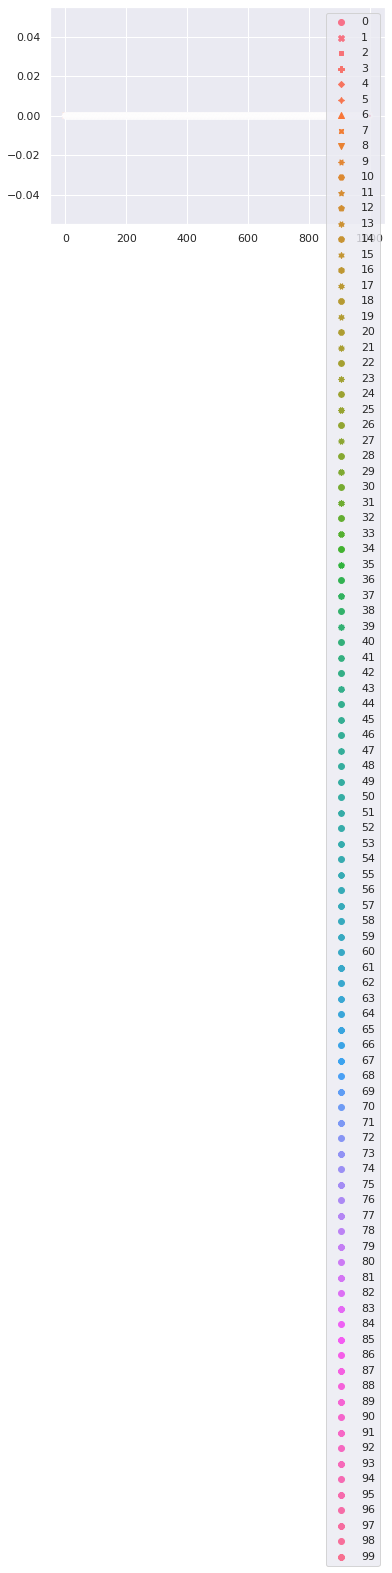

In [ ]:
import seaborn as sns
import pandas as pd

pca_mean = np.zeros((1000,100))
for idx in range(99):
  for id in range(8):
    pcaRes = np.load(os.path.join(pca_dir, f'train_layer_{id+1}.npy'))
    sns.set()
    df = pd.DataFrame(pca_mean)
    pca_mean[:,idx] = (np.mean(df, axis = 1))


sns.scatterplot(data = pca_mean)
plt.show()


Training the Alexnet


# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 



**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

In [ ]:
#@title Utility functions for regression
import sklearn.linear_model


def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None
        self.model = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        # X =  self._concatenate_ones(X)

        # X = torch.from_numpy(X).float()
        # y = torch.from_numpy(y).float()
        # if self.use_gpu:
        #     X = X.cuda()
        #     y = y.cuda()
        # XtX = torch.matmul(X.t(),X)
        # Xty = torch.matmul(X.t(),y.unsqueeze(2))
        # XtX = XtX.unsqueeze(0)
        # XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        # betas_cholesky, _ = torch.solve(Xty, XtX)
        l1_reg = linear_model.Lasso(alpha=1.0) # check for diffrent alpha vlaues ones we have a model
        l1_reg.fit(X, y)
        self.model = l1_reg
        self.coefficients = l1_reg.coefficients

    def predict(self, entry):
        # if len(entry.shape) == 1:
        #     entry = self._reshape_x(entry)
        # entry =  self._concatenate_ones(entry)
        # entry = torch.from_numpy(entry).float()
        # if self.use_gpu:
        #     entry = entry.cuda()
        # prediction = torch.matmul(entry,self.coefficients)
        # prediction = prediction.cpu().numpy()
        # prediction = np.squeeze(prediction).T
        prediction = self.model.predict(entry)  # the l1 regression prediction
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu) # it's actully l1 regression check the code
    reg.fit(train_activations, train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    # betas = reg.coef_
    # np.savez_compressed(betas)
    return fmri_pred_test

            

In [ ]:
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/activations_alexnet'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)


# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)

Total Number of Videos:  1102


In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

fmri_dir = '/content/participants_data_v2021'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/prediction'
model = 'alexnet'
# layer = ""
for layer in layers:
  for sub in subs:
    for ROI in ROIs:
      if ROI == "WB":
          track = "full_track"
      else:
          track = "mini_track"
      results_dir = os.path.join(prediction_dir,model, layer,\
                            track, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      print ("Starting ROI: ", ROI, "sub: ",sub)
      perform_encoding(activations_dir, fmri_dir,\
                      results_dir, sub, layer,\
                      ROI=ROI,mode='test')
      print ("Completed ROI: ", ROI, "sub: ",sub)
      print("----------------------------------------------------------------------------")

NameError: ignored

In [ ]:

subIDs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB"]
# ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

df = np.zeros((len(subIDs),len(ROIs)))
for layer in layers:
  for i, subID in enumerate(subIDs): 
    for j, ROI in enumerate(ROIs):
      outnp = np.load(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/prediction/alexnet/{layer}/full_track/{subID}/{ROI}_test.npy')
      # outnp = np.load(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/prediction/alexnet/{layer}/mini_track/{subID}/{ROI}_test.npy')
      # print(outnp.shape)
      mn = outnp.mean()
      df[i,j] = mn

  print(df.shape)

  # plt.imshow(df, cmap='hot')

  pos = np.arange(0,9)
  plt.figure(figsize=(15,8))
  plt.boxplot(df, labels = ROIs)
  plt.title(f'{layer}')
  plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/prediction/alexnet/BoxPlots/{layer}_full.png')
    # plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun/prediction/alexnet/BoxPlots/{layer}_mini.png')
  plt.show()

In [ ]:
# lay8 = plt.imread('/content/prediction/alexnet/results/layer8_mini.png')
# plt.figure(figsize=(15,8))
# plt.imshow(lay8)